In [118]:
#Load libraries
import os
import pickle

import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras import models

import spacy

import graphviz
import pydot
from keras.utils import plot_model


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM
from keras.models import Model, load_model, Sequential
from keras.initializers import Constant
from keras.models import load_model

In [206]:
#Variables to control which models are trained
train_cnn = True
train_lstm = True
train_simplecnn = True

In [120]:
#variables to control file storage
cache_dir = 'cache'
model_store = 'saved_models'

In [121]:
#functions to support training of models and plotting

In [122]:

def load_trained_model(path_to_weights_file):
    return load_model(path_to_weights_file)

In [123]:
def save_training_history(_history, filepath):
    with open(filepath, 'wb') as file_pi:
        pickle.dump(_history.history, file_pi)

In [124]:
def train_model(model, x_train, y_train, x_val, y_val, callbacks, epochs_num, batch_size):
    _history = model.fit(x_train, y_train, validation_data=(x_val, y_val), callbacks=callbacks,  epochs=epochs_num, batch_size=batch_size, verbose=1)
    return _history

In [125]:
#function to plot history
#I have adapted the below code to be generic to run in a function so it can be used for mutiple models, original code was  from Deep Learing with Python - Francois Chollett
import matplotlib.pyplot as plt

def plothistory(history, modelname) : 
        
    

    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'r--', label='Training acc')
    plt.plot(epochs, val_acc, 'b--', label='Validation acc')
    plt.title( modelname + ' Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'r--', label='Training loss')
    plt.plot(epochs, val_loss, 'b--', label='Validation loss')
    plt.title(modelname + ' Training and validation loss')
    plt.legend()
    plt.show()
        

In [126]:
#setting up callbacks
from keras.callbacks import ModelCheckpoint , EarlyStopping 
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir="tf_logs/{}".format(time()))


from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir="tf_logs/{}".format(time()))


def setup_callbacks(checkpoint_filename, early_stop_threshold):
    tensorboard = TensorBoard(log_dir="tf_logs/{}".format(time()))
    earlystop = EarlyStopping(monitor='val_loss', patience=early_stop_threshold)
    savemodel =  ModelCheckpoint(filepath=checkpoint_filename, 
                               verbose=1, save_best_only=True)
  
    return  [earlystop, savemodel
            ,tensorboard]


In [127]:
#function to store the text pre-proccessing for reuse
#code has been adapted from udacity nlp github repository


cache_dir = os.path.join("cache", "victorian_author")  # where to store cache files
os.makedirs(cache_dir, exist_ok=True)  # ensure cache directory exists

def pickleTextCleaning(textsToClean, cache_file):
    cache_data = None
    texts = None
    #if there is a cache file present use it
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as file:
                cache_data = pickle.load(file)
            print("Read preprocessed data from cache file:", cache_file)
        except:
            pass  #can't read data from cache so do the processing
        if cache_data is None:
            texts = cleanup_text(textsToClean, True)
            if cache_file is not None:
                cache_data = dict(texts=texts)
                with open(os.path.join(cache_dir, cache_file), "wb") as f:
                    pickle.dump(cache_data, f)
                    print("Wrote preprocessed data to cache file:", cache_file)
        else:
            # Unpack data loaded from cache file
            texts = (cache_data['texts'])
        return texts

## Deep Learning Approaches to Text Classification

In [128]:
OUTPUT_COLUMN = 'author'
TEXT_COLUMN = 'text'

#### Define Vocabulary Size and Sequence Length

In [129]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 500

In [130]:
### Load Dataset

In [131]:
file_name = '../data/victorian_author_sample_main_authors_train1.csv'
df = pd.read_csv(file_name, encoding="utf-8")

In [132]:
df.head(1)

,text,author,count
0,towards me and her little fingers round my han...,8,6914


In [133]:
df.columns

Index(['text', 'author', 'count'], dtype='object')

#### Split into Train and Test Data

In [134]:
#small sample of the data set for experiments
df_train_data, X_test,y_train_df,y_test_df = train_test_split(df.index,df[OUTPUT_COLUMN],test_size=0.2)
X_train = df.iloc[df_train_data]

In [135]:

X_train.shape

(20080, 3)

In [136]:
X_train.nunique()

text      20080
author       12
count        12
dtype: int64

### Text Preprocessing

In [137]:
from spacy.lang.en.stop_words import STOP_WORDS

#Clean the Text
#Remove Stop Words
#Convert to Lower Case
#Lematise to convert each word to head word 

def cleanup_text(docs, logging=False):
    texts = []
    counter = 1
    
    for doc in docs:
        #Logging
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(docs)))
        counter += 1
        #turn off the parser and entity recogniser as these are not required
        #tagger and tokeniser are still running
        doc = nlp(doc, disable=['parser', 'ner'])
        #text is lematised to get the head word
        #Text is lower cased
        #n.lemma_.is_punct
        tokens = [tok.lemma_.lower().strip() 
                  for tok in doc
                  
                  if tok.lemma_ != '-PRON-'  and tok.pos_ != "SYM"]
        
        #Ignore Stop Words which add noise to the data
        tokens = [tok for tok in tokens if (tok not in STOP_WORDS)]
        tokens = [tok for tok in tokens if len(tok) > 1] # filter out small words
        tokens = ' '.join(tokens)
        #remve any token of length 1
        texts.append(tokens)
    return pd.Series(texts)

In [138]:
X_train.head(5)

,text,author,count
10698,that his cousin might ride b where such a one ...,26,4441
6885,this way and some that and still others that t...,21,2307
8516,me i assure ye i ha n t seed the colour of or ...,45,2312
8968,and gentle sadness the weight of which was as ...,21,2307
7963,â it was the very address given to the driver ...,33,1742


In [139]:
#Perform text pre processing and store for future use
nlp = spacy.load('en_core_web_sm')

In [140]:

texts = pickleTextCleaning(X_train[TEXT_COLUMN], 'textcleaning_nopunct.pkl')

Processed 1000 out of 20080 documents.
Processed 2000 out of 20080 documents.
Processed 3000 out of 20080 documents.
Processed 4000 out of 20080 documents.
Processed 5000 out of 20080 documents.
Processed 6000 out of 20080 documents.
Processed 7000 out of 20080 documents.
Processed 8000 out of 20080 documents.
Processed 9000 out of 20080 documents.
Processed 10000 out of 20080 documents.
Processed 11000 out of 20080 documents.
Processed 12000 out of 20080 documents.
Processed 13000 out of 20080 documents.
Processed 14000 out of 20080 documents.
Processed 15000 out of 20080 documents.
Processed 16000 out of 20080 documents.
Processed 17000 out of 20080 documents.
Processed 18000 out of 20080 documents.
Processed 19000 out of 20080 documents.
Processed 20000 out of 20080 documents.
Wrote preprocessed data to cache file: textcleaning_nopunct.pkl


#### Observe Pre Processed Text

In [141]:
texts[0]

'cousin ride meet mind business soon complete new mare prove treasure little trouble exactly calculate purpose possession suppose thing suit like old grey pony delight mare far pleasure sort receive consideration kindness pleasure spring word express regard example thing good great possess worth appreciate entitle feeling strong pay sentiment respectful grateful confiding tender horse continue fact pro mrs use lady think objection excuse eye wait till sir thoma return september come sir thoma abroad near prospect finish business circumstance suddenly arise moment begin turn thought england great uncertainty thing involve determine send home son wait final arrangement tom arrive safely bring excellent account health little purpose far mrs concern sir thoma send away sou like parent care influence fore help feel dreadful long evening autumn come terribly haunt idea sad cottage oblige park ss refuge dining room park return engagement effect course progress mind pleasantly occupy fortune e

#### Number of Unique Classes

In [142]:
labels = X_train[OUTPUT_COLUMN]
num_classes = labels.nunique();

print(num_classes)

12


#### Prepare Text for Neural Networks

In [143]:
#Note this is only looking at the first 1000 words
#sequences are 5000 words long this is one parameter that could be tuned

print("Max Sequence Length: {}".format(MAX_SEQUENCE_LENGTH))
print("Max Number of Words: {}".format(MAX_NB_WORDS))

Max Sequence Length: 1000
Max Number of Words: 500


In [144]:
def create_tokens(max_nb_words, max_sequence_length, mode):
    print("Creating tokenizer to take into account the most common {} words".format(max_nb_words))
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~')
    print("Building Vocabulary on input Text")
    tokenizer.fit_on_texts(texts)
    print("Convert text into a sequence of integers ")
    sequences = tokenizer.texts_to_sequences(texts)

    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))

    print('Pad Sequences to be {} long'.format(max_sequence_length))
    data = pad_sequences(sequences, maxlen=max_sequence_length)

    print('Shape of data tensor:', data.shape)
    print('Shape of label tensor:', labels.shape)
    return data, tokenizer

In [145]:
### Build a Word List Using The Vocabulary of the Documents so that we can examine vocabulary
data, tokenizer = create_tokens(MAX_NB_WORDS, MAX_SEQUENCE_LENGTH, 'count' )

Creating tokenizer to take into account the most common 500 words
Building Vocabulary on input Text
Convert text into a sequence of integers 
Found 8528 unique tokens.
Pad Sequences to be 1000 long
Shape of data tensor: (20080, 1000)
Shape of label tensor: (20080,)


In [146]:
import pickle

# saving the tokenizer
print ("Saving the Tokenizer")
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading the tokenzier
with open('tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

Saving the Tokenizer


In [147]:
#Create word list using the tokenizer 
#gets a list of words from our documents
def create_word_list_from_tokenizer(tokenizer):
    word_list = []
  
    for word, i in tokenizer.word_index.items():
        word_list.append(word)
  
    return word_list

In [148]:
#observe top  words

In [149]:
word_list = create_word_list_from_tokenizer(tokenizer)

In [150]:
topwords = { key:val for key, val in tokenizer.word_index.items() if val < 200 }

print(topwords)

{'man': 1, 'know': 2, 'mr': 3, 'come': 4, 'good': 5, 'think': 6, 'time': 7, 'look': 8, 'little': 9, 'like': 10, 'day': 11, 'great': 12, 'mrs': 13, 'hand': 14, 'old': 15, 'thing': 16, 'eye': 17, 'life': 18, 'find': 19, 'tell': 20, 'way': 21, 'long': 22, 'hear': 23, 'shall': 24, 'leave': 25, 'away': 26, 'head': 27, 'love': 28, 'house': 29, 'sir': 30, 'feel': 31, 'woman': 32, 'miss': 33, 'don': 34, 'speak': 35, 'young': 36, 'face': 37, 'turn': 38, 'place': 39, 'year': 40, 'work': 41, 'mind': 42, 'word': 43, 'room': 44, 'new': 45, 'night': 46, 'dear': 47, 'ask': 48, 'lady': 49, 'want': 50, 'stand': 51, 'world': 52, 'father': 53, 'people': 54, 'mean': 55, 'let': 56, 'return': 57, 'friend': 58, 'sit': 59, 'mother': 60, 'heart': 61, 'right': 62, 'begin': 63, 'child': 64, 'bring': 65, 'moment': 66, 'lie': 67, 'pass': 68, 'state': 69, 'half': 70, 'wish': 71, 'cry': 72, 'light': 73, 'door': 74, 'home': 75, 'live': 76, 'hold': 77, 'end': 78, 'walk': 79, 'soon': 80, 'poor': 81, 'yes': 82, 'talk': 

### Split into Training and Validation set

In [151]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical


VALIDATION_SPLIT = 0.2

x_train, x_val, y_train_orig, y_val_orig = train_test_split(data, labels, test_size=VALIDATION_SPLIT,
                                                    random_state=42, stratify=labels)

### Validate the distribution in training and validation sets

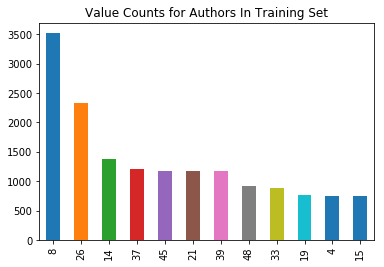

In [152]:
pd.value_counts(y_train_orig).plot(kind="bar", title='Value Counts for Authors In Training Set')

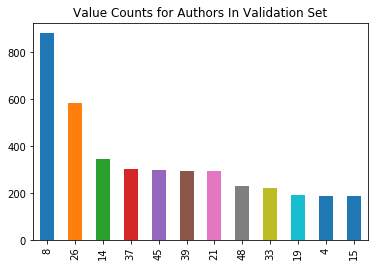

In [153]:
pd.value_counts(y_val_orig).plot(kind="bar", title='Value Counts for Authors In Validation Set')

#### One Hot Encoding

In [154]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(labels)
encoded_Y = encoder.transform(y_train_orig)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = to_categorical(encoded_Y)
dummy_y_valid = to_categorical(encoder.transform(y_val_orig))

y_train = dummy_y

y_val = dummy_y_valid


### Leveraging Semantics with Glove Vectors

In [155]:
GLOVE_DIR = 'GloveVectors/glove.6B'
EMBEDDING_DIM = 100

In [156]:
#compute an index mapping words to known embeddings, by parsing the data dump of pre-trained embeddings

embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [157]:
word_index = tokenizer.word_index

In [158]:
#reminder of the length of the vocab
print(len(word_index))

8528


Build an embedding matrix - Each entry contains an embedding vector for each of the words in the vocuabulary created by the tokenier. Any words that are not found in the embedding have a vector of all 0s. 

In [159]:
#convert to a numeric matrix for feeding into embedding layer
embedding_matrix = np.zeros((len(word_list) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [160]:
from keras.layers import Embedding

def create_embedding_layer(embedding_dim, embedding_matrix, max_sequence_length, trainable=False):
    #create the embedding layer for use in the netorks

    print("Creating Embedding layer of dimensions width {} x length {}".format(embedding_dim, max_sequence_length))

    embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_sequence_length,
                            trainable=False)
    return embedding_layer

In [161]:
embedding_layer = create_embedding_layer(EMBEDDING_DIM, embedding_matrix, MAX_SEQUENCE_LENGTH, False)

Creating Embedding layer of dimensions width 100 x length 1000


### Extracting Features from Text Using Convolutional Neural Networks and Word Embeddings

In [162]:
def build_cnn_with_glove_vectors(num_filters, kernel_size, pooling_num, dense_size, num_classes, dropout_level) :

    model = Sequential()
    model.add(embedding_layer)
    model.add(Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(Dropout(dropout_level))
    model.add(MaxPooling1D(pooling_num))
    model.add(Conv1D(int(num_filters/2), kernel_size, activation='relu'))
    model.add(MaxPooling1D(pooling_num))
    
    model.add(Conv1D(int(num_filters/4), kernel_size, activation='relu'))
    model.add(MaxPooling1D(pooling_num))
    model.add(Flatten())
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
  
    # summarize the model
    print(model.summary())
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model


In [163]:
#Compute the batch size according to the size of the training data
batch_size = int(x_train.shape[0] / 1000)
print(batch_size)


16


In [164]:
## Create Model

In [165]:
#build_cnn_with_glove_vectors(num_filters, kernel_size, pooling_num, dense_size, num_classes, dropout_level)
initial_cnn_model = build_cnn_with_glove_vectors(32, 4, 2, 24, num_classes, 0.25)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 100)         852900    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 997, 32)           12832     
_________________________________________________________________
dropout_2 (Dropout)          (None, 997, 32)           0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 498, 32)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 495, 16)           2064      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 247, 16)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 244, 8)            520       
__________

In [166]:
## setup callbacks
callbacks = setup_callbacks('saved_models/weights.best.initialcnn_glovevectors.hdf5', 5)

In [167]:
## Do training
if(train_cnn):
    print("Preparing to train CNN with glove vectors")
    
    _history_mm = train_model(initial_cnn_model, x_train, y_train, x_val, y_val, callbacks, 50, batch_size)
else:
    print ("Training of CNN with glove vectors is disabled, ")

Preparing to train CNN with glove vectors
Train on 16064 samples, validate on 4016 samples
Epoch 1/50


 3264/16064 [=====>........................] - ETA: 3:32 - loss: 2.5690 - acc: 0.0000e+0 - ETA: 2:24 - loss: 2.5315 - acc: 0.0000e+0 - ETA: 2:01 - loss: 2.5131 - acc: 0.0625    - ETA: 1:50 - loss: 2.5010 - acc: 0.109 - ETA: 1:43 - loss: 2.4890 - acc: 0.125 - ETA: 1:40 - loss: 2.4740 - acc: 0.145 - ETA: 1:37 - loss: 2.4675 - acc: 0.151 - ETA: 1:34 - loss: 2.4820 - acc: 0.132 - ETA: 1:30 - loss: 2.4654 - acc: 0.152 - ETA: 1:30 - loss: 2.4468 - acc: 0.156 - ETA: 1:29 - loss: 2.4343 - acc: 0.153 - ETA: 1:27 - loss: 2.4153 - acc: 0.177 - ETA: 1:27 - loss: 2.4053 - acc: 0.182 - ETA: 1:27 - loss: 2.3972 - acc: 0.174 - ETA: 1:26 - loss: 2.4037 - acc: 0.170 - ETA: 1:26 - loss: 2.4079 - acc: 0.171 - ETA: 1:26 - loss: 2.4157 - acc: 0.176 - ETA: 1:26 - loss: 2.4178 - acc: 0.170 - ETA: 1:26 - loss: 2.4273 - acc: 0.164 - ETA: 1:25 - loss: 2.4322 - acc: 0.165 - ETA: 1:25 - loss: 2.4280 - acc: 0.163 - ETA: 1:24 - loss: 2.4222 - acc: 0.164 - ETA: 1:24 - loss: 2.4203 - acc: 0.165 - ETA: 1:23 - loss: 2.4

10128/16064 [=================>............] - ETA: 44s - loss: 2.1051 - acc: 0.26 - ETA: 44s - loss: 2.1048 - acc: 0.26 - ETA: 44s - loss: 2.1041 - acc: 0.26 - ETA: 44s - loss: 2.1042 - acc: 0.26 - ETA: 44s - loss: 2.1036 - acc: 0.26 - ETA: 44s - loss: 2.1030 - acc: 0.26 - ETA: 44s - loss: 2.1019 - acc: 0.26 - ETA: 43s - loss: 2.1014 - acc: 0.26 - ETA: 43s - loss: 2.1012 - acc: 0.26 - ETA: 43s - loss: 2.1007 - acc: 0.26 - ETA: 43s - loss: 2.1014 - acc: 0.26 - ETA: 43s - loss: 2.1011 - acc: 0.26 - ETA: 43s - loss: 2.0998 - acc: 0.26 - ETA: 43s - loss: 2.0997 - acc: 0.26 - ETA: 43s - loss: 2.0995 - acc: 0.26 - ETA: 43s - loss: 2.0982 - acc: 0.26 - ETA: 43s - loss: 2.0984 - acc: 0.26 - ETA: 43s - loss: 2.0975 - acc: 0.26 - ETA: 43s - loss: 2.0977 - acc: 0.26 - ETA: 43s - loss: 2.0973 - acc: 0.26 - ETA: 43s - loss: 2.0961 - acc: 0.27 - ETA: 42s - loss: 2.0961 - acc: 0.27 - ETA: 42s - loss: 2.0951 - acc: 0.27 - ETA: 42s - loss: 2.0956 - acc: 0.27 - ETA: 42s - loss: 2.0957 - acc: 0.27 - ETA

13568/16064 [========================>.....] - ETA: 28s - loss: 2.0245 - acc: 0.29 - ETA: 28s - loss: 2.0238 - acc: 0.29 - ETA: 28s - loss: 2.0231 - acc: 0.29 - ETA: 28s - loss: 2.0226 - acc: 0.29 - ETA: 28s - loss: 2.0223 - acc: 0.29 - ETA: 28s - loss: 2.0223 - acc: 0.29 - ETA: 28s - loss: 2.0222 - acc: 0.29 - ETA: 28s - loss: 2.0221 - acc: 0.29 - ETA: 27s - loss: 2.0212 - acc: 0.29 - ETA: 27s - loss: 2.0207 - acc: 0.29 - ETA: 27s - loss: 2.0205 - acc: 0.29 - ETA: 27s - loss: 2.0203 - acc: 0.29 - ETA: 27s - loss: 2.0200 - acc: 0.29 - ETA: 27s - loss: 2.0196 - acc: 0.29 - ETA: 27s - loss: 2.0189 - acc: 0.29 - ETA: 27s - loss: 2.0182 - acc: 0.29 - ETA: 27s - loss: 2.0183 - acc: 0.29 - ETA: 27s - loss: 2.0179 - acc: 0.29 - ETA: 27s - loss: 2.0186 - acc: 0.29 - ETA: 27s - loss: 2.0188 - acc: 0.29 - ETA: 27s - loss: 2.0180 - acc: 0.29 - ETA: 26s - loss: 2.0174 - acc: 0.29 - ETA: 26s - loss: 2.0169 - acc: 0.29 - ETA: 26s - loss: 2.0160 - acc: 0.29 - ETA: 26s - loss: 2.0151 - acc: 0.29 - ETA

16064/16064 [==============================] - ETA: 12s - loss: 1.9368 - acc: 0.32 - ETA: 12s - loss: 1.9362 - acc: 0.32 - ETA: 12s - loss: 1.9359 - acc: 0.32 - ETA: 12s - loss: 1.9357 - acc: 0.32 - ETA: 11s - loss: 1.9353 - acc: 0.32 - ETA: 11s - loss: 1.9353 - acc: 0.32 - ETA: 11s - loss: 1.9349 - acc: 0.32 - ETA: 11s - loss: 1.9346 - acc: 0.32 - ETA: 11s - loss: 1.9344 - acc: 0.32 - ETA: 11s - loss: 1.9338 - acc: 0.32 - ETA: 11s - loss: 1.9336 - acc: 0.32 - ETA: 11s - loss: 1.9332 - acc: 0.32 - ETA: 11s - loss: 1.9323 - acc: 0.32 - ETA: 11s - loss: 1.9321 - acc: 0.32 - ETA: 11s - loss: 1.9311 - acc: 0.32 - ETA: 11s - loss: 1.9306 - acc: 0.32 - ETA: 10s - loss: 1.9303 - acc: 0.32 - ETA: 10s - loss: 1.9298 - acc: 0.32 - ETA: 10s - loss: 1.9289 - acc: 0.32 - ETA: 10s - loss: 1.9284 - acc: 0.32 - ETA: 10s - loss: 1.9273 - acc: 0.33 - ETA: 10s - loss: 1.9266 - acc: 0.33 - ETA: 10s - loss: 1.9265 - acc: 0.33 - ETA: 10s - loss: 1.9268 - acc: 0.33 - ETA: 10s - loss: 1.9260 - acc: 0.33 - ETA

 3264/16064 [=====>........................] - ETA: 1:18 - loss: 1.2808 - acc: 0.500 - ETA: 1:18 - loss: 1.2793 - acc: 0.531 - ETA: 1:19 - loss: 1.4831 - acc: 0.458 - ETA: 1:17 - loss: 1.4337 - acc: 0.468 - ETA: 1:17 - loss: 1.4755 - acc: 0.462 - ETA: 1:17 - loss: 1.4697 - acc: 0.468 - ETA: 1:16 - loss: 1.4639 - acc: 0.473 - ETA: 1:16 - loss: 1.4949 - acc: 0.468 - ETA: 1:17 - loss: 1.5164 - acc: 0.451 - ETA: 1:18 - loss: 1.5480 - acc: 0.456 - ETA: 1:18 - loss: 1.5596 - acc: 0.454 - ETA: 1:17 - loss: 1.5899 - acc: 0.437 - ETA: 1:16 - loss: 1.5863 - acc: 0.432 - ETA: 1:17 - loss: 1.5498 - acc: 0.442 - ETA: 1:16 - loss: 1.5594 - acc: 0.429 - ETA: 1:16 - loss: 1.5690 - acc: 0.425 - ETA: 1:16 - loss: 1.5890 - acc: 0.419 - ETA: 1:16 - loss: 1.6191 - acc: 0.409 - ETA: 1:15 - loss: 1.6178 - acc: 0.407 - ETA: 1:15 - loss: 1.6067 - acc: 0.415 - ETA: 1:16 - loss: 1.5974 - acc: 0.416 - ETA: 1:15 - loss: 1.5877 - acc: 0.423 - ETA: 1:15 - loss: 1.5962 - acc: 0.423 - ETA: 1:15 - loss: 1.5941 - acc: 0

10096/16064 [=================>............] - ETA: 47s - loss: 1.4772 - acc: 0.47 - ETA: 47s - loss: 1.4762 - acc: 0.47 - ETA: 46s - loss: 1.4763 - acc: 0.47 - ETA: 46s - loss: 1.4765 - acc: 0.47 - ETA: 46s - loss: 1.4776 - acc: 0.47 - ETA: 46s - loss: 1.4781 - acc: 0.47 - ETA: 46s - loss: 1.4782 - acc: 0.47 - ETA: 46s - loss: 1.4788 - acc: 0.47 - ETA: 46s - loss: 1.4781 - acc: 0.47 - ETA: 46s - loss: 1.4774 - acc: 0.47 - ETA: 46s - loss: 1.4773 - acc: 0.47 - ETA: 46s - loss: 1.4766 - acc: 0.47 - ETA: 46s - loss: 1.4756 - acc: 0.47 - ETA: 46s - loss: 1.4758 - acc: 0.47 - ETA: 45s - loss: 1.4766 - acc: 0.47 - ETA: 45s - loss: 1.4776 - acc: 0.47 - ETA: 45s - loss: 1.4777 - acc: 0.47 - ETA: 45s - loss: 1.4773 - acc: 0.47 - ETA: 45s - loss: 1.4771 - acc: 0.47 - ETA: 45s - loss: 1.4774 - acc: 0.47 - ETA: 45s - loss: 1.4766 - acc: 0.47 - ETA: 45s - loss: 1.4772 - acc: 0.47 - ETA: 45s - loss: 1.4780 - acc: 0.47 - ETA: 45s - loss: 1.4766 - acc: 0.47 - ETA: 45s - loss: 1.4764 - acc: 0.47 - ETA

13536/16064 [========================>.....] - ETA: 29s - loss: 1.4534 - acc: 0.48 - ETA: 29s - loss: 1.4532 - acc: 0.48 - ETA: 29s - loss: 1.4534 - acc: 0.48 - ETA: 29s - loss: 1.4540 - acc: 0.48 - ETA: 29s - loss: 1.4536 - acc: 0.48 - ETA: 29s - loss: 1.4533 - acc: 0.48 - ETA: 28s - loss: 1.4529 - acc: 0.48 - ETA: 28s - loss: 1.4528 - acc: 0.48 - ETA: 28s - loss: 1.4531 - acc: 0.48 - ETA: 28s - loss: 1.4522 - acc: 0.48 - ETA: 28s - loss: 1.4523 - acc: 0.48 - ETA: 28s - loss: 1.4529 - acc: 0.48 - ETA: 28s - loss: 1.4536 - acc: 0.48 - ETA: 28s - loss: 1.4533 - acc: 0.48 - ETA: 28s - loss: 1.4535 - acc: 0.48 - ETA: 28s - loss: 1.4539 - acc: 0.48 - ETA: 28s - loss: 1.4542 - acc: 0.48 - ETA: 28s - loss: 1.4540 - acc: 0.48 - ETA: 27s - loss: 1.4538 - acc: 0.48 - ETA: 27s - loss: 1.4541 - acc: 0.48 - ETA: 27s - loss: 1.4546 - acc: 0.48 - ETA: 27s - loss: 1.4556 - acc: 0.48 - ETA: 27s - loss: 1.4559 - acc: 0.48 - ETA: 27s - loss: 1.4553 - acc: 0.48 - ETA: 27s - loss: 1.4546 - acc: 0.48 - ETA

16064/16064 [==============================] - ETA: 12s - loss: 1.4459 - acc: 0.49 - ETA: 12s - loss: 1.4464 - acc: 0.48 - ETA: 12s - loss: 1.4464 - acc: 0.48 - ETA: 12s - loss: 1.4465 - acc: 0.49 - ETA: 12s - loss: 1.4468 - acc: 0.48 - ETA: 12s - loss: 1.4464 - acc: 0.49 - ETA: 11s - loss: 1.4463 - acc: 0.49 - ETA: 11s - loss: 1.4463 - acc: 0.49 - ETA: 11s - loss: 1.4468 - acc: 0.49 - ETA: 11s - loss: 1.4470 - acc: 0.49 - ETA: 11s - loss: 1.4467 - acc: 0.49 - ETA: 11s - loss: 1.4469 - acc: 0.49 - ETA: 11s - loss: 1.4467 - acc: 0.49 - ETA: 11s - loss: 1.4466 - acc: 0.49 - ETA: 11s - loss: 1.4466 - acc: 0.49 - ETA: 11s - loss: 1.4462 - acc: 0.49 - ETA: 11s - loss: 1.4459 - acc: 0.49 - ETA: 11s - loss: 1.4457 - acc: 0.49 - ETA: 10s - loss: 1.4454 - acc: 0.49 - ETA: 10s - loss: 1.4454 - acc: 0.49 - ETA: 10s - loss: 1.4450 - acc: 0.49 - ETA: 10s - loss: 1.4444 - acc: 0.49 - ETA: 10s - loss: 1.4442 - acc: 0.49 - ETA: 10s - loss: 1.4442 - acc: 0.49 - ETA: 10s - loss: 1.4438 - acc: 0.49 - ETA

 3264/16064 [=====>........................] - ETA: 1:13 - loss: 1.4334 - acc: 0.375 - ETA: 1:11 - loss: 1.3884 - acc: 0.500 - ETA: 1:13 - loss: 1.1105 - acc: 0.604 - ETA: 1:10 - loss: 1.1723 - acc: 0.578 - ETA: 1:16 - loss: 1.2486 - acc: 0.575 - ETA: 1:15 - loss: 1.2490 - acc: 0.552 - ETA: 1:13 - loss: 1.3374 - acc: 0.508 - ETA: 1:14 - loss: 1.3341 - acc: 0.515 - ETA: 1:13 - loss: 1.3497 - acc: 0.506 - ETA: 1:13 - loss: 1.3292 - acc: 0.512 - ETA: 1:14 - loss: 1.3320 - acc: 0.505 - ETA: 1:14 - loss: 1.3178 - acc: 0.510 - ETA: 1:13 - loss: 1.3106 - acc: 0.514 - ETA: 1:12 - loss: 1.2926 - acc: 0.513 - ETA: 1:13 - loss: 1.3169 - acc: 0.508 - ETA: 1:13 - loss: 1.3382 - acc: 0.500 - ETA: 1:13 - loss: 1.3404 - acc: 0.500 - ETA: 1:12 - loss: 1.3585 - acc: 0.496 - ETA: 1:13 - loss: 1.3515 - acc: 0.506 - ETA: 1:13 - loss: 1.3194 - acc: 0.518 - ETA: 1:12 - loss: 1.3259 - acc: 0.517 - ETA: 1:12 - loss: 1.3381 - acc: 0.511 - ETA: 1:13 - loss: 1.3570 - acc: 0.505 - ETA: 1:14 - loss: 1.3559 - acc: 0

10112/16064 [=================>............] - ETA: 45s - loss: 1.2795 - acc: 0.54 - ETA: 45s - loss: 1.2783 - acc: 0.54 - ETA: 45s - loss: 1.2779 - acc: 0.54 - ETA: 45s - loss: 1.2779 - acc: 0.54 - ETA: 44s - loss: 1.2776 - acc: 0.54 - ETA: 44s - loss: 1.2767 - acc: 0.54 - ETA: 44s - loss: 1.2758 - acc: 0.54 - ETA: 44s - loss: 1.2760 - acc: 0.54 - ETA: 44s - loss: 1.2762 - acc: 0.54 - ETA: 44s - loss: 1.2761 - acc: 0.54 - ETA: 44s - loss: 1.2756 - acc: 0.54 - ETA: 44s - loss: 1.2749 - acc: 0.54 - ETA: 44s - loss: 1.2754 - acc: 0.54 - ETA: 44s - loss: 1.2766 - acc: 0.54 - ETA: 44s - loss: 1.2764 - acc: 0.54 - ETA: 44s - loss: 1.2773 - acc: 0.54 - ETA: 44s - loss: 1.2764 - acc: 0.54 - ETA: 43s - loss: 1.2759 - acc: 0.54 - ETA: 43s - loss: 1.2757 - acc: 0.54 - ETA: 43s - loss: 1.2757 - acc: 0.54 - ETA: 43s - loss: 1.2754 - acc: 0.54 - ETA: 43s - loss: 1.2745 - acc: 0.54 - ETA: 43s - loss: 1.2752 - acc: 0.54 - ETA: 43s - loss: 1.2744 - acc: 0.55 - ETA: 43s - loss: 1.2743 - acc: 0.54 - ETA

13552/16064 [========================>.....] - ETA: 28s - loss: 1.2672 - acc: 0.55 - ETA: 28s - loss: 1.2666 - acc: 0.55 - ETA: 28s - loss: 1.2664 - acc: 0.55 - ETA: 28s - loss: 1.2673 - acc: 0.55 - ETA: 28s - loss: 1.2673 - acc: 0.55 - ETA: 28s - loss: 1.2667 - acc: 0.55 - ETA: 28s - loss: 1.2666 - acc: 0.55 - ETA: 28s - loss: 1.2661 - acc: 0.55 - ETA: 28s - loss: 1.2659 - acc: 0.55 - ETA: 27s - loss: 1.2659 - acc: 0.55 - ETA: 27s - loss: 1.2656 - acc: 0.55 - ETA: 27s - loss: 1.2666 - acc: 0.55 - ETA: 27s - loss: 1.2670 - acc: 0.55 - ETA: 27s - loss: 1.2671 - acc: 0.55 - ETA: 27s - loss: 1.2676 - acc: 0.55 - ETA: 27s - loss: 1.2673 - acc: 0.55 - ETA: 27s - loss: 1.2669 - acc: 0.55 - ETA: 27s - loss: 1.2668 - acc: 0.55 - ETA: 27s - loss: 1.2663 - acc: 0.55 - ETA: 27s - loss: 1.2667 - acc: 0.55 - ETA: 27s - loss: 1.2676 - acc: 0.55 - ETA: 27s - loss: 1.2677 - acc: 0.55 - ETA: 26s - loss: 1.2683 - acc: 0.55 - ETA: 26s - loss: 1.2681 - acc: 0.55 - ETA: 26s - loss: 1.2682 - acc: 0.55 - ETA

16064/16064 [==============================] - ETA: 12s - loss: 1.2732 - acc: 0.55 - ETA: 12s - loss: 1.2732 - acc: 0.55 - ETA: 11s - loss: 1.2733 - acc: 0.55 - ETA: 11s - loss: 1.2735 - acc: 0.55 - ETA: 11s - loss: 1.2737 - acc: 0.55 - ETA: 11s - loss: 1.2735 - acc: 0.55 - ETA: 11s - loss: 1.2739 - acc: 0.55 - ETA: 11s - loss: 1.2738 - acc: 0.55 - ETA: 11s - loss: 1.2738 - acc: 0.55 - ETA: 11s - loss: 1.2735 - acc: 0.55 - ETA: 11s - loss: 1.2729 - acc: 0.55 - ETA: 11s - loss: 1.2727 - acc: 0.55 - ETA: 11s - loss: 1.2727 - acc: 0.55 - ETA: 11s - loss: 1.2729 - acc: 0.55 - ETA: 11s - loss: 1.2724 - acc: 0.55 - ETA: 10s - loss: 1.2722 - acc: 0.55 - ETA: 10s - loss: 1.2731 - acc: 0.55 - ETA: 10s - loss: 1.2728 - acc: 0.55 - ETA: 10s - loss: 1.2724 - acc: 0.55 - ETA: 10s - loss: 1.2725 - acc: 0.55 - ETA: 10s - loss: 1.2720 - acc: 0.55 - ETA: 10s - loss: 1.2717 - acc: 0.55 - ETA: 10s - loss: 1.2717 - acc: 0.55 - ETA: 10s - loss: 1.2724 - acc: 0.55 - ETA: 10s - loss: 1.2723 - acc: 0.55 - ETA

 3264/16064 [=====>........................] - ETA: 1:12 - loss: 1.2427 - acc: 0.500 - ETA: 1:14 - loss: 1.2310 - acc: 0.562 - ETA: 1:14 - loss: 1.4765 - acc: 0.437 - ETA: 1:17 - loss: 1.4570 - acc: 0.484 - ETA: 1:17 - loss: 1.3920 - acc: 0.525 - ETA: 1:17 - loss: 1.3629 - acc: 0.520 - ETA: 1:16 - loss: 1.3173 - acc: 0.535 - ETA: 1:17 - loss: 1.2900 - acc: 0.554 - ETA: 1:16 - loss: 1.2626 - acc: 0.562 - ETA: 1:16 - loss: 1.2316 - acc: 0.575 - ETA: 1:16 - loss: 1.2451 - acc: 0.568 - ETA: 1:15 - loss: 1.1865 - acc: 0.588 - ETA: 1:15 - loss: 1.1821 - acc: 0.586 - ETA: 1:16 - loss: 1.1736 - acc: 0.589 - ETA: 1:15 - loss: 1.1642 - acc: 0.591 - ETA: 1:15 - loss: 1.1953 - acc: 0.578 - ETA: 1:15 - loss: 1.1850 - acc: 0.588 - ETA: 1:15 - loss: 1.1824 - acc: 0.586 - ETA: 1:14 - loss: 1.1650 - acc: 0.592 - ETA: 1:14 - loss: 1.1729 - acc: 0.587 - ETA: 1:14 - loss: 1.1768 - acc: 0.589 - ETA: 1:14 - loss: 1.1847 - acc: 0.590 - ETA: 1:14 - loss: 1.2025 - acc: 0.592 - ETA: 1:14 - loss: 1.2231 - acc: 0

10112/16064 [=================>............] - ETA: 46s - loss: 1.1574 - acc: 0.59 - ETA: 46s - loss: 1.1574 - acc: 0.59 - ETA: 46s - loss: 1.1586 - acc: 0.58 - ETA: 46s - loss: 1.1590 - acc: 0.58 - ETA: 46s - loss: 1.1592 - acc: 0.58 - ETA: 46s - loss: 1.1588 - acc: 0.58 - ETA: 46s - loss: 1.1583 - acc: 0.58 - ETA: 45s - loss: 1.1590 - acc: 0.58 - ETA: 45s - loss: 1.1599 - acc: 0.58 - ETA: 45s - loss: 1.1596 - acc: 0.58 - ETA: 45s - loss: 1.1600 - acc: 0.58 - ETA: 45s - loss: 1.1597 - acc: 0.58 - ETA: 45s - loss: 1.1595 - acc: 0.58 - ETA: 45s - loss: 1.1614 - acc: 0.58 - ETA: 45s - loss: 1.1603 - acc: 0.58 - ETA: 45s - loss: 1.1606 - acc: 0.58 - ETA: 45s - loss: 1.1610 - acc: 0.58 - ETA: 45s - loss: 1.1622 - acc: 0.58 - ETA: 45s - loss: 1.1623 - acc: 0.58 - ETA: 45s - loss: 1.1633 - acc: 0.58 - ETA: 44s - loss: 1.1635 - acc: 0.58 - ETA: 44s - loss: 1.1644 - acc: 0.58 - ETA: 44s - loss: 1.1637 - acc: 0.58 - ETA: 44s - loss: 1.1635 - acc: 0.58 - ETA: 44s - loss: 1.1626 - acc: 0.58 - ETA

13552/16064 [========================>.....] - ETA: 29s - loss: 1.1593 - acc: 0.59 - ETA: 29s - loss: 1.1596 - acc: 0.59 - ETA: 29s - loss: 1.1591 - acc: 0.59 - ETA: 29s - loss: 1.1592 - acc: 0.59 - ETA: 29s - loss: 1.1595 - acc: 0.59 - ETA: 28s - loss: 1.1594 - acc: 0.59 - ETA: 28s - loss: 1.1597 - acc: 0.59 - ETA: 28s - loss: 1.1598 - acc: 0.59 - ETA: 28s - loss: 1.1595 - acc: 0.59 - ETA: 28s - loss: 1.1602 - acc: 0.59 - ETA: 28s - loss: 1.1612 - acc: 0.59 - ETA: 28s - loss: 1.1616 - acc: 0.59 - ETA: 28s - loss: 1.1614 - acc: 0.59 - ETA: 28s - loss: 1.1617 - acc: 0.59 - ETA: 28s - loss: 1.1615 - acc: 0.59 - ETA: 28s - loss: 1.1619 - acc: 0.59 - ETA: 28s - loss: 1.1613 - acc: 0.59 - ETA: 27s - loss: 1.1607 - acc: 0.59 - ETA: 27s - loss: 1.1604 - acc: 0.59 - ETA: 27s - loss: 1.1608 - acc: 0.59 - ETA: 27s - loss: 1.1603 - acc: 0.59 - ETA: 27s - loss: 1.1607 - acc: 0.59 - ETA: 27s - loss: 1.1603 - acc: 0.59 - ETA: 27s - loss: 1.1602 - acc: 0.59 - ETA: 27s - loss: 1.1598 - acc: 0.59 - ETA

16064/16064 [==============================] - ETA: 12s - loss: 1.1554 - acc: 0.59 - ETA: 12s - loss: 1.1559 - acc: 0.59 - ETA: 12s - loss: 1.1562 - acc: 0.59 - ETA: 12s - loss: 1.1564 - acc: 0.59 - ETA: 12s - loss: 1.1573 - acc: 0.59 - ETA: 11s - loss: 1.1573 - acc: 0.59 - ETA: 11s - loss: 1.1577 - acc: 0.59 - ETA: 11s - loss: 1.1576 - acc: 0.59 - ETA: 11s - loss: 1.1581 - acc: 0.59 - ETA: 11s - loss: 1.1585 - acc: 0.59 - ETA: 11s - loss: 1.1588 - acc: 0.59 - ETA: 11s - loss: 1.1589 - acc: 0.59 - ETA: 11s - loss: 1.1590 - acc: 0.59 - ETA: 11s - loss: 1.1589 - acc: 0.59 - ETA: 11s - loss: 1.1587 - acc: 0.59 - ETA: 11s - loss: 1.1597 - acc: 0.59 - ETA: 11s - loss: 1.1600 - acc: 0.59 - ETA: 10s - loss: 1.1605 - acc: 0.59 - ETA: 10s - loss: 1.1609 - acc: 0.59 - ETA: 10s - loss: 1.1611 - acc: 0.59 - ETA: 10s - loss: 1.1612 - acc: 0.59 - ETA: 10s - loss: 1.1614 - acc: 0.59 - ETA: 10s - loss: 1.1613 - acc: 0.59 - ETA: 10s - loss: 1.1611 - acc: 0.59 - ETA: 10s - loss: 1.1611 - acc: 0.59 - ETA

 3264/16064 [=====>........................] - ETA: 1:20 - loss: 0.4726 - acc: 0.875 - ETA: 1:16 - loss: 0.7674 - acc: 0.750 - ETA: 1:15 - loss: 0.9943 - acc: 0.645 - ETA: 1:14 - loss: 0.9154 - acc: 0.703 - ETA: 1:14 - loss: 0.9500 - acc: 0.687 - ETA: 1:13 - loss: 0.9288 - acc: 0.677 - ETA: 1:13 - loss: 0.9589 - acc: 0.669 - ETA: 1:13 - loss: 0.9941 - acc: 0.648 - ETA: 1:13 - loss: 0.9996 - acc: 0.645 - ETA: 1:12 - loss: 1.0108 - acc: 0.637 - ETA: 1:12 - loss: 0.9972 - acc: 0.636 - ETA: 1:13 - loss: 1.0563 - acc: 0.625 - ETA: 1:12 - loss: 1.0155 - acc: 0.644 - ETA: 1:13 - loss: 1.0368 - acc: 0.642 - ETA: 1:13 - loss: 1.0543 - acc: 0.633 - ETA: 1:13 - loss: 1.0862 - acc: 0.625 - ETA: 1:13 - loss: 1.0940 - acc: 0.621 - ETA: 1:13 - loss: 1.0821 - acc: 0.614 - ETA: 1:13 - loss: 1.0581 - acc: 0.628 - ETA: 1:13 - loss: 1.0539 - acc: 0.631 - ETA: 1:13 - loss: 1.0661 - acc: 0.628 - ETA: 1:13 - loss: 1.0523 - acc: 0.636 - ETA: 1:13 - loss: 1.0591 - acc: 0.630 - ETA: 1:13 - loss: 1.0656 - acc: 0

10096/16064 [=================>............] - ETA: 46s - loss: 1.0583 - acc: 0.63 - ETA: 46s - loss: 1.0598 - acc: 0.63 - ETA: 46s - loss: 1.0598 - acc: 0.62 - ETA: 46s - loss: 1.0610 - acc: 0.62 - ETA: 46s - loss: 1.0610 - acc: 0.62 - ETA: 46s - loss: 1.0612 - acc: 0.62 - ETA: 46s - loss: 1.0612 - acc: 0.62 - ETA: 46s - loss: 1.0607 - acc: 0.62 - ETA: 46s - loss: 1.0599 - acc: 0.62 - ETA: 46s - loss: 1.0601 - acc: 0.62 - ETA: 46s - loss: 1.0607 - acc: 0.62 - ETA: 45s - loss: 1.0610 - acc: 0.62 - ETA: 45s - loss: 1.0604 - acc: 0.62 - ETA: 45s - loss: 1.0600 - acc: 0.62 - ETA: 45s - loss: 1.0611 - acc: 0.62 - ETA: 45s - loss: 1.0609 - acc: 0.62 - ETA: 45s - loss: 1.0604 - acc: 0.62 - ETA: 45s - loss: 1.0603 - acc: 0.62 - ETA: 45s - loss: 1.0599 - acc: 0.62 - ETA: 45s - loss: 1.0602 - acc: 0.62 - ETA: 45s - loss: 1.0591 - acc: 0.62 - ETA: 45s - loss: 1.0595 - acc: 0.62 - ETA: 45s - loss: 1.0598 - acc: 0.62 - ETA: 44s - loss: 1.0602 - acc: 0.62 - ETA: 44s - loss: 1.0617 - acc: 0.62 - ETA

13536/16064 [========================>.....] - ETA: 29s - loss: 1.0533 - acc: 0.63 - ETA: 29s - loss: 1.0531 - acc: 0.63 - ETA: 29s - loss: 1.0533 - acc: 0.63 - ETA: 29s - loss: 1.0539 - acc: 0.63 - ETA: 28s - loss: 1.0538 - acc: 0.63 - ETA: 28s - loss: 1.0528 - acc: 0.63 - ETA: 28s - loss: 1.0522 - acc: 0.63 - ETA: 28s - loss: 1.0524 - acc: 0.63 - ETA: 28s - loss: 1.0521 - acc: 0.63 - ETA: 28s - loss: 1.0516 - acc: 0.63 - ETA: 28s - loss: 1.0515 - acc: 0.63 - ETA: 28s - loss: 1.0519 - acc: 0.63 - ETA: 28s - loss: 1.0512 - acc: 0.63 - ETA: 28s - loss: 1.0506 - acc: 0.63 - ETA: 28s - loss: 1.0504 - acc: 0.63 - ETA: 28s - loss: 1.0501 - acc: 0.63 - ETA: 28s - loss: 1.0497 - acc: 0.63 - ETA: 27s - loss: 1.0500 - acc: 0.63 - ETA: 27s - loss: 1.0497 - acc: 0.63 - ETA: 27s - loss: 1.0502 - acc: 0.63 - ETA: 27s - loss: 1.0501 - acc: 0.63 - ETA: 27s - loss: 1.0508 - acc: 0.63 - ETA: 27s - loss: 1.0510 - acc: 0.63 - ETA: 27s - loss: 1.0503 - acc: 0.63 - ETA: 27s - loss: 1.0502 - acc: 0.63 - ETA

16064/16064 [==============================] - ETA: 12s - loss: 1.0591 - acc: 0.62 - ETA: 12s - loss: 1.0592 - acc: 0.62 - ETA: 12s - loss: 1.0590 - acc: 0.62 - ETA: 12s - loss: 1.0591 - acc: 0.62 - ETA: 12s - loss: 1.0593 - acc: 0.63 - ETA: 11s - loss: 1.0594 - acc: 0.62 - ETA: 11s - loss: 1.0590 - acc: 0.62 - ETA: 11s - loss: 1.0587 - acc: 0.63 - ETA: 11s - loss: 1.0587 - acc: 0.62 - ETA: 11s - loss: 1.0589 - acc: 0.62 - ETA: 11s - loss: 1.0597 - acc: 0.62 - ETA: 11s - loss: 1.0594 - acc: 0.62 - ETA: 11s - loss: 1.0592 - acc: 0.62 - ETA: 11s - loss: 1.0593 - acc: 0.62 - ETA: 11s - loss: 1.0593 - acc: 0.62 - ETA: 11s - loss: 1.0592 - acc: 0.62 - ETA: 11s - loss: 1.0591 - acc: 0.62 - ETA: 11s - loss: 1.0593 - acc: 0.62 - ETA: 10s - loss: 1.0599 - acc: 0.62 - ETA: 10s - loss: 1.0600 - acc: 0.62 - ETA: 10s - loss: 1.0598 - acc: 0.62 - ETA: 10s - loss: 1.0594 - acc: 0.62 - ETA: 10s - loss: 1.0591 - acc: 0.62 - ETA: 10s - loss: 1.0594 - acc: 0.62 - ETA: 10s - loss: 1.0589 - acc: 0.63 - ETA

 3264/16064 [=====>........................] - ETA: 1:09 - loss: 1.0307 - acc: 0.750 - ETA: 1:10 - loss: 1.0175 - acc: 0.656 - ETA: 1:11 - loss: 0.9781 - acc: 0.645 - ETA: 1:12 - loss: 0.9441 - acc: 0.656 - ETA: 1:12 - loss: 1.0061 - acc: 0.637 - ETA: 1:12 - loss: 1.0536 - acc: 0.625 - ETA: 1:15 - loss: 1.0444 - acc: 0.616 - ETA: 1:15 - loss: 1.0444 - acc: 0.617 - ETA: 1:16 - loss: 1.0549 - acc: 0.611 - ETA: 1:16 - loss: 1.0618 - acc: 0.606 - ETA: 1:15 - loss: 1.0417 - acc: 0.613 - ETA: 1:15 - loss: 1.0425 - acc: 0.609 - ETA: 1:14 - loss: 1.0177 - acc: 0.625 - ETA: 1:14 - loss: 1.0039 - acc: 0.633 - ETA: 1:14 - loss: 0.9984 - acc: 0.637 - ETA: 1:14 - loss: 0.9878 - acc: 0.640 - ETA: 1:14 - loss: 0.9892 - acc: 0.636 - ETA: 1:14 - loss: 0.9609 - acc: 0.645 - ETA: 1:14 - loss: 0.9639 - acc: 0.644 - ETA: 1:13 - loss: 0.9520 - acc: 0.659 - ETA: 1:13 - loss: 0.9629 - acc: 0.654 - ETA: 1:13 - loss: 0.9717 - acc: 0.644 - ETA: 1:13 - loss: 0.9572 - acc: 0.652 - ETA: 1:13 - loss: 0.9556 - acc: 0

10128/16064 [=================>............] - ETA: 44s - loss: 1.0224 - acc: 0.64 - ETA: 44s - loss: 1.0231 - acc: 0.64 - ETA: 44s - loss: 1.0226 - acc: 0.64 - ETA: 44s - loss: 1.0231 - acc: 0.64 - ETA: 44s - loss: 1.0232 - acc: 0.64 - ETA: 44s - loss: 1.0223 - acc: 0.64 - ETA: 44s - loss: 1.0220 - acc: 0.64 - ETA: 44s - loss: 1.0217 - acc: 0.64 - ETA: 44s - loss: 1.0212 - acc: 0.64 - ETA: 44s - loss: 1.0222 - acc: 0.64 - ETA: 44s - loss: 1.0212 - acc: 0.64 - ETA: 43s - loss: 1.0207 - acc: 0.64 - ETA: 43s - loss: 1.0220 - acc: 0.64 - ETA: 43s - loss: 1.0211 - acc: 0.64 - ETA: 43s - loss: 1.0200 - acc: 0.64 - ETA: 43s - loss: 1.0194 - acc: 0.64 - ETA: 43s - loss: 1.0202 - acc: 0.64 - ETA: 43s - loss: 1.0198 - acc: 0.64 - ETA: 43s - loss: 1.0189 - acc: 0.64 - ETA: 43s - loss: 1.0197 - acc: 0.64 - ETA: 43s - loss: 1.0206 - acc: 0.64 - ETA: 43s - loss: 1.0204 - acc: 0.64 - ETA: 43s - loss: 1.0197 - acc: 0.64 - ETA: 43s - loss: 1.0192 - acc: 0.64 - ETA: 42s - loss: 1.0200 - acc: 0.64 - ETA

13568/16064 [========================>.....] - ETA: 28s - loss: 1.0102 - acc: 0.64 - ETA: 28s - loss: 1.0111 - acc: 0.64 - ETA: 28s - loss: 1.0115 - acc: 0.64 - ETA: 28s - loss: 1.0115 - acc: 0.64 - ETA: 27s - loss: 1.0116 - acc: 0.64 - ETA: 27s - loss: 1.0117 - acc: 0.64 - ETA: 27s - loss: 1.0115 - acc: 0.64 - ETA: 27s - loss: 1.0118 - acc: 0.64 - ETA: 27s - loss: 1.0114 - acc: 0.64 - ETA: 27s - loss: 1.0114 - acc: 0.64 - ETA: 27s - loss: 1.0108 - acc: 0.64 - ETA: 27s - loss: 1.0102 - acc: 0.64 - ETA: 27s - loss: 1.0104 - acc: 0.64 - ETA: 27s - loss: 1.0100 - acc: 0.64 - ETA: 27s - loss: 1.0098 - acc: 0.64 - ETA: 27s - loss: 1.0100 - acc: 0.64 - ETA: 27s - loss: 1.0098 - acc: 0.64 - ETA: 27s - loss: 1.0099 - acc: 0.64 - ETA: 26s - loss: 1.0102 - acc: 0.64 - ETA: 26s - loss: 1.0094 - acc: 0.64 - ETA: 26s - loss: 1.0093 - acc: 0.64 - ETA: 26s - loss: 1.0095 - acc: 0.64 - ETA: 26s - loss: 1.0104 - acc: 0.64 - ETA: 26s - loss: 1.0107 - acc: 0.64 - ETA: 26s - loss: 1.0109 - acc: 0.64 - ETA

16064/16064 [==============================] - ETA: 11s - loss: 1.0069 - acc: 0.64 - ETA: 11s - loss: 1.0074 - acc: 0.64 - ETA: 11s - loss: 1.0077 - acc: 0.64 - ETA: 11s - loss: 1.0071 - acc: 0.64 - ETA: 11s - loss: 1.0075 - acc: 0.64 - ETA: 11s - loss: 1.0071 - acc: 0.64 - ETA: 11s - loss: 1.0069 - acc: 0.64 - ETA: 11s - loss: 1.0066 - acc: 0.64 - ETA: 11s - loss: 1.0072 - acc: 0.64 - ETA: 11s - loss: 1.0070 - acc: 0.64 - ETA: 11s - loss: 1.0067 - acc: 0.64 - ETA: 11s - loss: 1.0067 - acc: 0.64 - ETA: 10s - loss: 1.0070 - acc: 0.64 - ETA: 10s - loss: 1.0068 - acc: 0.64 - ETA: 10s - loss: 1.0066 - acc: 0.64 - ETA: 10s - loss: 1.0068 - acc: 0.64 - ETA: 10s - loss: 1.0070 - acc: 0.64 - ETA: 10s - loss: 1.0070 - acc: 0.64 - ETA: 10s - loss: 1.0068 - acc: 0.64 - ETA: 10s - loss: 1.0063 - acc: 0.64 - ETA: 10s - loss: 1.0065 - acc: 0.64 - ETA: 10s - loss: 1.0060 - acc: 0.64 - ETA: 10s - loss: 1.0058 - acc: 0.64 - ETA: 10s - loss: 1.0062 - acc: 0.64 - ETA: 10s - loss: 1.0061 - acc: 0.64 - ETA

 3264/16064 [=====>........................] - ETA: 1:11 - loss: 1.2387 - acc: 0.500 - ETA: 1:12 - loss: 1.3520 - acc: 0.500 - ETA: 1:14 - loss: 1.0492 - acc: 0.625 - ETA: 1:14 - loss: 1.0658 - acc: 0.593 - ETA: 1:14 - loss: 1.0124 - acc: 0.600 - ETA: 1:14 - loss: 0.9968 - acc: 0.614 - ETA: 1:14 - loss: 0.9743 - acc: 0.642 - ETA: 1:13 - loss: 0.9712 - acc: 0.656 - ETA: 1:13 - loss: 0.9507 - acc: 0.666 - ETA: 1:13 - loss: 0.9406 - acc: 0.668 - ETA: 1:13 - loss: 0.9639 - acc: 0.647 - ETA: 1:13 - loss: 0.9365 - acc: 0.661 - ETA: 1:13 - loss: 0.9272 - acc: 0.658 - ETA: 1:13 - loss: 0.9056 - acc: 0.674 - ETA: 1:13 - loss: 0.8818 - acc: 0.687 - ETA: 1:13 - loss: 0.9107 - acc: 0.675 - ETA: 1:14 - loss: 0.9218 - acc: 0.665 - ETA: 1:14 - loss: 0.9341 - acc: 0.666 - ETA: 1:14 - loss: 0.9338 - acc: 0.664 - ETA: 1:14 - loss: 0.9308 - acc: 0.662 - ETA: 1:14 - loss: 0.9295 - acc: 0.657 - ETA: 1:14 - loss: 0.9161 - acc: 0.664 - ETA: 1:14 - loss: 0.8954 - acc: 0.673 - ETA: 1:14 - loss: 0.8879 - acc: 0

10096/16064 [=================>............] - ETA: 47s - loss: 0.9257 - acc: 0.67 - ETA: 47s - loss: 0.9270 - acc: 0.67 - ETA: 47s - loss: 0.9276 - acc: 0.67 - ETA: 47s - loss: 0.9266 - acc: 0.67 - ETA: 47s - loss: 0.9268 - acc: 0.67 - ETA: 47s - loss: 0.9267 - acc: 0.67 - ETA: 47s - loss: 0.9271 - acc: 0.67 - ETA: 47s - loss: 0.9275 - acc: 0.67 - ETA: 47s - loss: 0.9278 - acc: 0.67 - ETA: 47s - loss: 0.9283 - acc: 0.67 - ETA: 47s - loss: 0.9293 - acc: 0.67 - ETA: 47s - loss: 0.9303 - acc: 0.67 - ETA: 46s - loss: 0.9307 - acc: 0.67 - ETA: 46s - loss: 0.9299 - acc: 0.67 - ETA: 46s - loss: 0.9303 - acc: 0.67 - ETA: 46s - loss: 0.9313 - acc: 0.67 - ETA: 46s - loss: 0.9308 - acc: 0.67 - ETA: 46s - loss: 0.9299 - acc: 0.67 - ETA: 46s - loss: 0.9304 - acc: 0.67 - ETA: 46s - loss: 0.9294 - acc: 0.67 - ETA: 46s - loss: 0.9288 - acc: 0.67 - ETA: 46s - loss: 0.9287 - acc: 0.67 - ETA: 46s - loss: 0.9283 - acc: 0.67 - ETA: 46s - loss: 0.9272 - acc: 0.67 - ETA: 45s - loss: 0.9279 - acc: 0.67 - ETA

13536/16064 [========================>.....] - ETA: 30s - loss: 0.9408 - acc: 0.67 - ETA: 30s - loss: 0.9409 - acc: 0.67 - ETA: 30s - loss: 0.9415 - acc: 0.67 - ETA: 30s - loss: 0.9419 - acc: 0.67 - ETA: 29s - loss: 0.9421 - acc: 0.67 - ETA: 29s - loss: 0.9417 - acc: 0.67 - ETA: 29s - loss: 0.9416 - acc: 0.67 - ETA: 29s - loss: 0.9421 - acc: 0.67 - ETA: 29s - loss: 0.9423 - acc: 0.67 - ETA: 29s - loss: 0.9419 - acc: 0.67 - ETA: 29s - loss: 0.9416 - acc: 0.67 - ETA: 29s - loss: 0.9419 - acc: 0.67 - ETA: 29s - loss: 0.9425 - acc: 0.67 - ETA: 29s - loss: 0.9431 - acc: 0.67 - ETA: 29s - loss: 0.9428 - acc: 0.67 - ETA: 29s - loss: 0.9423 - acc: 0.67 - ETA: 28s - loss: 0.9429 - acc: 0.67 - ETA: 28s - loss: 0.9425 - acc: 0.67 - ETA: 28s - loss: 0.9418 - acc: 0.67 - ETA: 28s - loss: 0.9419 - acc: 0.67 - ETA: 28s - loss: 0.9421 - acc: 0.67 - ETA: 28s - loss: 0.9424 - acc: 0.67 - ETA: 28s - loss: 0.9424 - acc: 0.67 - ETA: 28s - loss: 0.9427 - acc: 0.67 - ETA: 28s - loss: 0.9423 - acc: 0.67 - ETA

16064/16064 [==============================] - ETA: 12s - loss: 0.9506 - acc: 0.67 - ETA: 12s - loss: 0.9506 - acc: 0.67 - ETA: 12s - loss: 0.9505 - acc: 0.67 - ETA: 12s - loss: 0.9502 - acc: 0.67 - ETA: 12s - loss: 0.9500 - acc: 0.67 - ETA: 12s - loss: 0.9500 - acc: 0.67 - ETA: 12s - loss: 0.9493 - acc: 0.67 - ETA: 12s - loss: 0.9497 - acc: 0.67 - ETA: 12s - loss: 0.9494 - acc: 0.67 - ETA: 11s - loss: 0.9493 - acc: 0.67 - ETA: 11s - loss: 0.9492 - acc: 0.67 - ETA: 11s - loss: 0.9494 - acc: 0.67 - ETA: 11s - loss: 0.9498 - acc: 0.67 - ETA: 11s - loss: 0.9497 - acc: 0.67 - ETA: 11s - loss: 0.9503 - acc: 0.67 - ETA: 11s - loss: 0.9506 - acc: 0.67 - ETA: 11s - loss: 0.9504 - acc: 0.67 - ETA: 11s - loss: 0.9501 - acc: 0.67 - ETA: 11s - loss: 0.9501 - acc: 0.67 - ETA: 11s - loss: 0.9505 - acc: 0.67 - ETA: 11s - loss: 0.9502 - acc: 0.67 - ETA: 10s - loss: 0.9502 - acc: 0.67 - ETA: 10s - loss: 0.9501 - acc: 0.67 - ETA: 10s - loss: 0.9502 - acc: 0.67 - ETA: 10s - loss: 0.9516 - acc: 0.67 - ETA

 3264/16064 [=====>........................] - ETA: 1:11 - loss: 0.6998 - acc: 0.750 - ETA: 1:11 - loss: 0.7643 - acc: 0.750 - ETA: 1:12 - loss: 0.7825 - acc: 0.729 - ETA: 1:18 - loss: 0.8545 - acc: 0.687 - ETA: 1:20 - loss: 0.8630 - acc: 0.675 - ETA: 1:23 - loss: 0.8821 - acc: 0.666 - ETA: 1:22 - loss: 0.8750 - acc: 0.660 - ETA: 1:24 - loss: 0.8553 - acc: 0.671 - ETA: 1:23 - loss: 0.8162 - acc: 0.680 - ETA: 1:22 - loss: 0.8169 - acc: 0.687 - ETA: 1:22 - loss: 0.8533 - acc: 0.670 - ETA: 1:22 - loss: 0.8158 - acc: 0.687 - ETA: 1:21 - loss: 0.8024 - acc: 0.687 - ETA: 1:21 - loss: 0.8127 - acc: 0.678 - ETA: 1:20 - loss: 0.8023 - acc: 0.691 - ETA: 1:20 - loss: 0.8223 - acc: 0.683 - ETA: 1:20 - loss: 0.8050 - acc: 0.694 - ETA: 1:19 - loss: 0.8106 - acc: 0.691 - ETA: 1:19 - loss: 0.8021 - acc: 0.690 - ETA: 1:19 - loss: 0.8007 - acc: 0.693 - ETA: 1:19 - loss: 0.8028 - acc: 0.690 - ETA: 1:19 - loss: 0.7889 - acc: 0.693 - ETA: 1:18 - loss: 0.7862 - acc: 0.695 - ETA: 1:18 - loss: 0.8133 - acc: 0

10128/16064 [=================>............] - ETA: 44s - loss: 0.9048 - acc: 0.68 - ETA: 44s - loss: 0.9057 - acc: 0.68 - ETA: 44s - loss: 0.9058 - acc: 0.68 - ETA: 44s - loss: 0.9055 - acc: 0.68 - ETA: 44s - loss: 0.9046 - acc: 0.68 - ETA: 44s - loss: 0.9050 - acc: 0.68 - ETA: 44s - loss: 0.9041 - acc: 0.68 - ETA: 43s - loss: 0.9044 - acc: 0.68 - ETA: 43s - loss: 0.9052 - acc: 0.68 - ETA: 43s - loss: 0.9060 - acc: 0.68 - ETA: 43s - loss: 0.9057 - acc: 0.68 - ETA: 43s - loss: 0.9060 - acc: 0.68 - ETA: 43s - loss: 0.9061 - acc: 0.68 - ETA: 43s - loss: 0.9053 - acc: 0.68 - ETA: 43s - loss: 0.9049 - acc: 0.68 - ETA: 43s - loss: 0.9058 - acc: 0.68 - ETA: 43s - loss: 0.9060 - acc: 0.68 - ETA: 43s - loss: 0.9075 - acc: 0.68 - ETA: 43s - loss: 0.9071 - acc: 0.68 - ETA: 43s - loss: 0.9061 - acc: 0.68 - ETA: 42s - loss: 0.9064 - acc: 0.68 - ETA: 42s - loss: 0.9071 - acc: 0.68 - ETA: 42s - loss: 0.9072 - acc: 0.68 - ETA: 42s - loss: 0.9081 - acc: 0.68 - ETA: 42s - loss: 0.9076 - acc: 0.68 - ETA

13568/16064 [========================>.....] - ETA: 28s - loss: 0.9116 - acc: 0.68 - ETA: 28s - loss: 0.9113 - acc: 0.68 - ETA: 27s - loss: 0.9116 - acc: 0.68 - ETA: 27s - loss: 0.9111 - acc: 0.68 - ETA: 27s - loss: 0.9111 - acc: 0.68 - ETA: 27s - loss: 0.9108 - acc: 0.68 - ETA: 27s - loss: 0.9106 - acc: 0.68 - ETA: 27s - loss: 0.9108 - acc: 0.68 - ETA: 27s - loss: 0.9108 - acc: 0.68 - ETA: 27s - loss: 0.9104 - acc: 0.68 - ETA: 27s - loss: 0.9115 - acc: 0.68 - ETA: 27s - loss: 0.9124 - acc: 0.68 - ETA: 27s - loss: 0.9125 - acc: 0.68 - ETA: 27s - loss: 0.9121 - acc: 0.68 - ETA: 27s - loss: 0.9117 - acc: 0.68 - ETA: 27s - loss: 0.9116 - acc: 0.68 - ETA: 26s - loss: 0.9110 - acc: 0.68 - ETA: 26s - loss: 0.9110 - acc: 0.68 - ETA: 26s - loss: 0.9114 - acc: 0.68 - ETA: 26s - loss: 0.9117 - acc: 0.68 - ETA: 26s - loss: 0.9115 - acc: 0.68 - ETA: 26s - loss: 0.9110 - acc: 0.68 - ETA: 26s - loss: 0.9104 - acc: 0.68 - ETA: 26s - loss: 0.9107 - acc: 0.68 - ETA: 26s - loss: 0.9103 - acc: 0.68 - ETA

16064/16064 [==============================] - ETA: 12s - loss: 0.8999 - acc: 0.69 - ETA: 11s - loss: 0.9000 - acc: 0.69 - ETA: 11s - loss: 0.9004 - acc: 0.69 - ETA: 11s - loss: 0.9003 - acc: 0.69 - ETA: 11s - loss: 0.9004 - acc: 0.69 - ETA: 11s - loss: 0.9001 - acc: 0.69 - ETA: 11s - loss: 0.9000 - acc: 0.69 - ETA: 11s - loss: 0.9007 - acc: 0.69 - ETA: 11s - loss: 0.9009 - acc: 0.69 - ETA: 11s - loss: 0.9012 - acc: 0.69 - ETA: 11s - loss: 0.9013 - acc: 0.69 - ETA: 11s - loss: 0.9007 - acc: 0.69 - ETA: 11s - loss: 0.9015 - acc: 0.69 - ETA: 11s - loss: 0.9012 - acc: 0.69 - ETA: 10s - loss: 0.9018 - acc: 0.69 - ETA: 10s - loss: 0.9015 - acc: 0.69 - ETA: 10s - loss: 0.9012 - acc: 0.69 - ETA: 10s - loss: 0.9012 - acc: 0.69 - ETA: 10s - loss: 0.9013 - acc: 0.69 - ETA: 10s - loss: 0.9015 - acc: 0.69 - ETA: 10s - loss: 0.9014 - acc: 0.69 - ETA: 10s - loss: 0.9013 - acc: 0.69 - ETA: 10s - loss: 0.9010 - acc: 0.69 - ETA: 10s - loss: 0.9011 - acc: 0.69 - ETA: 10s - loss: 0.9011 - acc: 0.69 - ETA

 3264/16064 [=====>........................] - ETA: 1:13 - loss: 0.9960 - acc: 0.625 - ETA: 1:12 - loss: 1.1189 - acc: 0.593 - ETA: 1:13 - loss: 0.9836 - acc: 0.645 - ETA: 1:13 - loss: 0.8779 - acc: 0.671 - ETA: 1:12 - loss: 0.8136 - acc: 0.687 - ETA: 1:12 - loss: 0.7286 - acc: 0.739 - ETA: 1:12 - loss: 0.8049 - acc: 0.696 - ETA: 1:12 - loss: 0.8076 - acc: 0.710 - ETA: 1:12 - loss: 0.7726 - acc: 0.722 - ETA: 1:12 - loss: 0.7368 - acc: 0.743 - ETA: 1:12 - loss: 0.7889 - acc: 0.727 - ETA: 1:12 - loss: 0.7856 - acc: 0.729 - ETA: 1:13 - loss: 0.8018 - acc: 0.721 - ETA: 1:13 - loss: 0.7882 - acc: 0.732 - ETA: 1:12 - loss: 0.7741 - acc: 0.737 - ETA: 1:12 - loss: 0.7887 - acc: 0.734 - ETA: 1:13 - loss: 0.7787 - acc: 0.735 - ETA: 1:13 - loss: 0.7691 - acc: 0.739 - ETA: 1:13 - loss: 0.7762 - acc: 0.740 - ETA: 1:13 - loss: 0.7995 - acc: 0.734 - ETA: 1:13 - loss: 0.8149 - acc: 0.726 - ETA: 1:12 - loss: 0.8081 - acc: 0.727 - ETA: 1:12 - loss: 0.7944 - acc: 0.733 - ETA: 1:12 - loss: 0.7933 - acc: 0

10112/16064 [=================>............] - ETA: 46s - loss: 0.8693 - acc: 0.70 - ETA: 46s - loss: 0.8687 - acc: 0.70 - ETA: 45s - loss: 0.8681 - acc: 0.70 - ETA: 45s - loss: 0.8685 - acc: 0.70 - ETA: 45s - loss: 0.8674 - acc: 0.70 - ETA: 45s - loss: 0.8673 - acc: 0.70 - ETA: 45s - loss: 0.8668 - acc: 0.70 - ETA: 45s - loss: 0.8667 - acc: 0.70 - ETA: 45s - loss: 0.8663 - acc: 0.70 - ETA: 45s - loss: 0.8661 - acc: 0.70 - ETA: 45s - loss: 0.8656 - acc: 0.70 - ETA: 45s - loss: 0.8649 - acc: 0.70 - ETA: 45s - loss: 0.8652 - acc: 0.70 - ETA: 45s - loss: 0.8647 - acc: 0.70 - ETA: 44s - loss: 0.8655 - acc: 0.70 - ETA: 44s - loss: 0.8654 - acc: 0.70 - ETA: 44s - loss: 0.8657 - acc: 0.70 - ETA: 44s - loss: 0.8663 - acc: 0.70 - ETA: 44s - loss: 0.8659 - acc: 0.70 - ETA: 44s - loss: 0.8654 - acc: 0.70 - ETA: 44s - loss: 0.8648 - acc: 0.70 - ETA: 44s - loss: 0.8660 - acc: 0.70 - ETA: 44s - loss: 0.8662 - acc: 0.70 - ETA: 44s - loss: 0.8667 - acc: 0.70 - ETA: 44s - loss: 0.8665 - acc: 0.70 - ETA

13552/16064 [========================>.....] - ETA: 28s - loss: 0.8744 - acc: 0.69 - ETA: 28s - loss: 0.8755 - acc: 0.69 - ETA: 28s - loss: 0.8750 - acc: 0.69 - ETA: 28s - loss: 0.8750 - acc: 0.69 - ETA: 28s - loss: 0.8753 - acc: 0.69 - ETA: 28s - loss: 0.8752 - acc: 0.69 - ETA: 28s - loss: 0.8760 - acc: 0.69 - ETA: 28s - loss: 0.8755 - acc: 0.69 - ETA: 28s - loss: 0.8752 - acc: 0.69 - ETA: 28s - loss: 0.8750 - acc: 0.69 - ETA: 28s - loss: 0.8756 - acc: 0.69 - ETA: 27s - loss: 0.8757 - acc: 0.69 - ETA: 27s - loss: 0.8760 - acc: 0.69 - ETA: 27s - loss: 0.8758 - acc: 0.69 - ETA: 27s - loss: 0.8762 - acc: 0.69 - ETA: 27s - loss: 0.8757 - acc: 0.69 - ETA: 27s - loss: 0.8757 - acc: 0.69 - ETA: 27s - loss: 0.8763 - acc: 0.69 - ETA: 27s - loss: 0.8756 - acc: 0.69 - ETA: 27s - loss: 0.8754 - acc: 0.69 - ETA: 27s - loss: 0.8759 - acc: 0.69 - ETA: 27s - loss: 0.8757 - acc: 0.69 - ETA: 27s - loss: 0.8755 - acc: 0.69 - ETA: 27s - loss: 0.8753 - acc: 0.69 - ETA: 26s - loss: 0.8760 - acc: 0.69 - ETA

16064/16064 [==============================] - ETA: 12s - loss: 0.8761 - acc: 0.69 - ETA: 12s - loss: 0.8765 - acc: 0.69 - ETA: 11s - loss: 0.8764 - acc: 0.69 - ETA: 11s - loss: 0.8761 - acc: 0.69 - ETA: 11s - loss: 0.8759 - acc: 0.69 - ETA: 11s - loss: 0.8761 - acc: 0.69 - ETA: 11s - loss: 0.8759 - acc: 0.69 - ETA: 11s - loss: 0.8763 - acc: 0.69 - ETA: 11s - loss: 0.8760 - acc: 0.69 - ETA: 11s - loss: 0.8764 - acc: 0.69 - ETA: 11s - loss: 0.8763 - acc: 0.69 - ETA: 11s - loss: 0.8759 - acc: 0.69 - ETA: 11s - loss: 0.8756 - acc: 0.69 - ETA: 11s - loss: 0.8754 - acc: 0.69 - ETA: 11s - loss: 0.8753 - acc: 0.69 - ETA: 10s - loss: 0.8752 - acc: 0.69 - ETA: 10s - loss: 0.8749 - acc: 0.69 - ETA: 10s - loss: 0.8754 - acc: 0.69 - ETA: 10s - loss: 0.8752 - acc: 0.69 - ETA: 10s - loss: 0.8761 - acc: 0.69 - ETA: 10s - loss: 0.8757 - acc: 0.69 - ETA: 10s - loss: 0.8759 - acc: 0.69 - ETA: 10s - loss: 0.8762 - acc: 0.69 - ETA: 10s - loss: 0.8764 - acc: 0.69 - ETA: 10s - loss: 0.8766 - acc: 0.69 - ETA

 3264/16064 [=====>........................] - ETA: 1:24 - loss: 0.8028 - acc: 0.750 - ETA: 1:26 - loss: 0.7629 - acc: 0.718 - ETA: 1:24 - loss: 0.7499 - acc: 0.708 - ETA: 1:22 - loss: 0.7380 - acc: 0.718 - ETA: 1:21 - loss: 0.8228 - acc: 0.675 - ETA: 1:20 - loss: 0.7739 - acc: 0.708 - ETA: 1:19 - loss: 0.7585 - acc: 0.732 - ETA: 1:18 - loss: 0.7564 - acc: 0.726 - ETA: 1:18 - loss: 0.7200 - acc: 0.743 - ETA: 1:17 - loss: 0.7258 - acc: 0.750 - ETA: 1:17 - loss: 0.7458 - acc: 0.750 - ETA: 1:17 - loss: 0.7634 - acc: 0.739 - ETA: 1:17 - loss: 0.7647 - acc: 0.740 - ETA: 1:17 - loss: 0.7859 - acc: 0.727 - ETA: 1:17 - loss: 0.7704 - acc: 0.733 - ETA: 1:18 - loss: 0.7744 - acc: 0.726 - ETA: 1:18 - loss: 0.7629 - acc: 0.731 - ETA: 1:18 - loss: 0.7454 - acc: 0.736 - ETA: 1:17 - loss: 0.7192 - acc: 0.746 - ETA: 1:17 - loss: 0.7408 - acc: 0.737 - ETA: 1:17 - loss: 0.7462 - acc: 0.732 - ETA: 1:16 - loss: 0.7479 - acc: 0.727 - ETA: 1:16 - loss: 0.7456 - acc: 0.728 - ETA: 1:16 - loss: 0.7481 - acc: 0

10096/16064 [=================>............] - ETA: 46s - loss: 0.8307 - acc: 0.71 - ETA: 46s - loss: 0.8304 - acc: 0.71 - ETA: 46s - loss: 0.8297 - acc: 0.71 - ETA: 46s - loss: 0.8302 - acc: 0.71 - ETA: 46s - loss: 0.8297 - acc: 0.71 - ETA: 46s - loss: 0.8298 - acc: 0.71 - ETA: 46s - loss: 0.8300 - acc: 0.71 - ETA: 46s - loss: 0.8304 - acc: 0.71 - ETA: 46s - loss: 0.8298 - acc: 0.71 - ETA: 46s - loss: 0.8302 - acc: 0.71 - ETA: 46s - loss: 0.8308 - acc: 0.71 - ETA: 46s - loss: 0.8316 - acc: 0.71 - ETA: 45s - loss: 0.8323 - acc: 0.71 - ETA: 45s - loss: 0.8315 - acc: 0.71 - ETA: 45s - loss: 0.8320 - acc: 0.71 - ETA: 45s - loss: 0.8325 - acc: 0.71 - ETA: 45s - loss: 0.8316 - acc: 0.71 - ETA: 45s - loss: 0.8323 - acc: 0.71 - ETA: 45s - loss: 0.8318 - acc: 0.71 - ETA: 45s - loss: 0.8317 - acc: 0.71 - ETA: 45s - loss: 0.8328 - acc: 0.71 - ETA: 45s - loss: 0.8329 - acc: 0.71 - ETA: 45s - loss: 0.8323 - acc: 0.71 - ETA: 44s - loss: 0.8322 - acc: 0.71 - ETA: 44s - loss: 0.8326 - acc: 0.71 - ETA

13536/16064 [========================>.....] - ETA: 30s - loss: 0.8401 - acc: 0.71 - ETA: 30s - loss: 0.8402 - acc: 0.71 - ETA: 30s - loss: 0.8402 - acc: 0.71 - ETA: 30s - loss: 0.8398 - acc: 0.71 - ETA: 30s - loss: 0.8395 - acc: 0.71 - ETA: 30s - loss: 0.8399 - acc: 0.71 - ETA: 29s - loss: 0.8398 - acc: 0.71 - ETA: 29s - loss: 0.8399 - acc: 0.71 - ETA: 29s - loss: 0.8398 - acc: 0.71 - ETA: 29s - loss: 0.8394 - acc: 0.71 - ETA: 29s - loss: 0.8395 - acc: 0.71 - ETA: 29s - loss: 0.8398 - acc: 0.71 - ETA: 29s - loss: 0.8403 - acc: 0.71 - ETA: 29s - loss: 0.8410 - acc: 0.70 - ETA: 29s - loss: 0.8412 - acc: 0.70 - ETA: 29s - loss: 0.8412 - acc: 0.70 - ETA: 29s - loss: 0.8413 - acc: 0.70 - ETA: 29s - loss: 0.8412 - acc: 0.70 - ETA: 29s - loss: 0.8419 - acc: 0.70 - ETA: 28s - loss: 0.8418 - acc: 0.70 - ETA: 28s - loss: 0.8418 - acc: 0.70 - ETA: 28s - loss: 0.8414 - acc: 0.70 - ETA: 28s - loss: 0.8418 - acc: 0.70 - ETA: 28s - loss: 0.8413 - acc: 0.70 - ETA: 28s - loss: 0.8422 - acc: 0.70 - ETA

16064/16064 [==============================] - ETA: 12s - loss: 0.8469 - acc: 0.70 - ETA: 12s - loss: 0.8469 - acc: 0.70 - ETA: 12s - loss: 0.8467 - acc: 0.70 - ETA: 12s - loss: 0.8471 - acc: 0.70 - ETA: 12s - loss: 0.8469 - acc: 0.70 - ETA: 12s - loss: 0.8468 - acc: 0.70 - ETA: 12s - loss: 0.8468 - acc: 0.70 - ETA: 12s - loss: 0.8464 - acc: 0.70 - ETA: 12s - loss: 0.8462 - acc: 0.70 - ETA: 12s - loss: 0.8462 - acc: 0.70 - ETA: 11s - loss: 0.8465 - acc: 0.70 - ETA: 11s - loss: 0.8461 - acc: 0.70 - ETA: 11s - loss: 0.8457 - acc: 0.70 - ETA: 11s - loss: 0.8457 - acc: 0.70 - ETA: 11s - loss: 0.8457 - acc: 0.70 - ETA: 11s - loss: 0.8456 - acc: 0.70 - ETA: 11s - loss: 0.8458 - acc: 0.70 - ETA: 11s - loss: 0.8463 - acc: 0.70 - ETA: 11s - loss: 0.8460 - acc: 0.70 - ETA: 11s - loss: 0.8461 - acc: 0.70 - ETA: 11s - loss: 0.8462 - acc: 0.70 - ETA: 11s - loss: 0.8462 - acc: 0.70 - ETA: 10s - loss: 0.8465 - acc: 0.70 - ETA: 10s - loss: 0.8468 - acc: 0.70 - ETA: 10s - loss: 0.8466 - acc: 0.70 - ETA

 3264/16064 [=====>........................] - ETA: 1:11 - loss: 0.8029 - acc: 0.687 - ETA: 1:14 - loss: 0.8741 - acc: 0.656 - ETA: 1:18 - loss: 0.9075 - acc: 0.687 - ETA: 1:20 - loss: 0.8833 - acc: 0.687 - ETA: 1:19 - loss: 0.7623 - acc: 0.725 - ETA: 1:21 - loss: 0.7359 - acc: 0.729 - ETA: 1:21 - loss: 0.7663 - acc: 0.732 - ETA: 1:22 - loss: 0.7340 - acc: 0.750 - ETA: 1:21 - loss: 0.7334 - acc: 0.750 - ETA: 1:20 - loss: 0.7437 - acc: 0.743 - ETA: 1:22 - loss: 0.7421 - acc: 0.738 - ETA: 1:22 - loss: 0.7459 - acc: 0.744 - ETA: 1:22 - loss: 0.7370 - acc: 0.750 - ETA: 1:23 - loss: 0.7081 - acc: 0.763 - ETA: 1:23 - loss: 0.7241 - acc: 0.762 - ETA: 1:25 - loss: 0.7514 - acc: 0.757 - ETA: 1:25 - loss: 0.7453 - acc: 0.757 - ETA: 1:25 - loss: 0.7221 - acc: 0.763 - ETA: 1:24 - loss: 0.7190 - acc: 0.763 - ETA: 1:24 - loss: 0.7191 - acc: 0.762 - ETA: 1:24 - loss: 0.7175 - acc: 0.758 - ETA: 1:24 - loss: 0.7265 - acc: 0.758 - ETA: 1:23 - loss: 0.7475 - acc: 0.750 - ETA: 1:23 - loss: 0.7450 - acc: 0

10080/16064 [=================>............] - ETA: 48s - loss: 0.7800 - acc: 0.73 - ETA: 48s - loss: 0.7793 - acc: 0.73 - ETA: 48s - loss: 0.7804 - acc: 0.73 - ETA: 47s - loss: 0.7809 - acc: 0.73 - ETA: 47s - loss: 0.7798 - acc: 0.73 - ETA: 47s - loss: 0.7790 - acc: 0.73 - ETA: 47s - loss: 0.7791 - acc: 0.73 - ETA: 47s - loss: 0.7789 - acc: 0.73 - ETA: 47s - loss: 0.7788 - acc: 0.73 - ETA: 47s - loss: 0.7789 - acc: 0.73 - ETA: 47s - loss: 0.7786 - acc: 0.73 - ETA: 47s - loss: 0.7780 - acc: 0.73 - ETA: 47s - loss: 0.7778 - acc: 0.73 - ETA: 47s - loss: 0.7777 - acc: 0.73 - ETA: 46s - loss: 0.7770 - acc: 0.73 - ETA: 46s - loss: 0.7769 - acc: 0.73 - ETA: 46s - loss: 0.7767 - acc: 0.73 - ETA: 46s - loss: 0.7768 - acc: 0.73 - ETA: 46s - loss: 0.7763 - acc: 0.73 - ETA: 46s - loss: 0.7764 - acc: 0.73 - ETA: 46s - loss: 0.7778 - acc: 0.73 - ETA: 46s - loss: 0.7775 - acc: 0.73 - ETA: 46s - loss: 0.7767 - acc: 0.73 - ETA: 46s - loss: 0.7753 - acc: 0.73 - ETA: 46s - loss: 0.7755 - acc: 0.73 - ETA

13520/16064 [========================>.....] - ETA: 29s - loss: 0.7859 - acc: 0.73 - ETA: 29s - loss: 0.7863 - acc: 0.73 - ETA: 29s - loss: 0.7871 - acc: 0.73 - ETA: 29s - loss: 0.7875 - acc: 0.73 - ETA: 29s - loss: 0.7879 - acc: 0.73 - ETA: 29s - loss: 0.7888 - acc: 0.73 - ETA: 29s - loss: 0.7890 - acc: 0.73 - ETA: 29s - loss: 0.7899 - acc: 0.72 - ETA: 29s - loss: 0.7902 - acc: 0.72 - ETA: 29s - loss: 0.7903 - acc: 0.72 - ETA: 28s - loss: 0.7898 - acc: 0.73 - ETA: 28s - loss: 0.7903 - acc: 0.72 - ETA: 28s - loss: 0.7904 - acc: 0.72 - ETA: 28s - loss: 0.7912 - acc: 0.72 - ETA: 28s - loss: 0.7910 - acc: 0.72 - ETA: 28s - loss: 0.7905 - acc: 0.73 - ETA: 28s - loss: 0.7912 - acc: 0.73 - ETA: 28s - loss: 0.7908 - acc: 0.73 - ETA: 28s - loss: 0.7914 - acc: 0.72 - ETA: 28s - loss: 0.7915 - acc: 0.72 - ETA: 28s - loss: 0.7913 - acc: 0.72 - ETA: 28s - loss: 0.7915 - acc: 0.72 - ETA: 27s - loss: 0.7916 - acc: 0.72 - ETA: 27s - loss: 0.7914 - acc: 0.72 - ETA: 27s - loss: 0.7915 - acc: 0.72 - ETA

16064/16064 [==============================] - ETA: 12s - loss: 0.7960 - acc: 0.73 - ETA: 12s - loss: 0.7967 - acc: 0.73 - ETA: 12s - loss: 0.7961 - acc: 0.73 - ETA: 12s - loss: 0.7960 - acc: 0.73 - ETA: 12s - loss: 0.7959 - acc: 0.73 - ETA: 12s - loss: 0.7961 - acc: 0.73 - ETA: 12s - loss: 0.7957 - acc: 0.73 - ETA: 12s - loss: 0.7960 - acc: 0.73 - ETA: 12s - loss: 0.7963 - acc: 0.73 - ETA: 12s - loss: 0.7961 - acc: 0.73 - ETA: 11s - loss: 0.7954 - acc: 0.73 - ETA: 11s - loss: 0.7953 - acc: 0.73 - ETA: 11s - loss: 0.7950 - acc: 0.73 - ETA: 11s - loss: 0.7953 - acc: 0.73 - ETA: 11s - loss: 0.7951 - acc: 0.73 - ETA: 11s - loss: 0.7949 - acc: 0.73 - ETA: 11s - loss: 0.7949 - acc: 0.73 - ETA: 11s - loss: 0.7953 - acc: 0.73 - ETA: 11s - loss: 0.7950 - acc: 0.73 - ETA: 11s - loss: 0.7954 - acc: 0.73 - ETA: 11s - loss: 0.7952 - acc: 0.73 - ETA: 11s - loss: 0.7952 - acc: 0.73 - ETA: 10s - loss: 0.7955 - acc: 0.73 - ETA: 10s - loss: 0.7956 - acc: 0.73 - ETA: 10s - loss: 0.7955 - acc: 0.73 - ETA

 3264/16064 [=====>........................] - ETA: 1:28 - loss: 0.6725 - acc: 0.812 - ETA: 1:26 - loss: 0.5836 - acc: 0.812 - ETA: 1:26 - loss: 0.6838 - acc: 0.770 - ETA: 1:25 - loss: 0.6562 - acc: 0.781 - ETA: 1:25 - loss: 0.6512 - acc: 0.775 - ETA: 1:24 - loss: 0.6427 - acc: 0.770 - ETA: 1:24 - loss: 0.6770 - acc: 0.758 - ETA: 1:24 - loss: 0.6592 - acc: 0.773 - ETA: 1:25 - loss: 0.6580 - acc: 0.784 - ETA: 1:25 - loss: 0.6715 - acc: 0.781 - ETA: 1:26 - loss: 0.7113 - acc: 0.767 - ETA: 1:26 - loss: 0.7082 - acc: 0.765 - ETA: 1:26 - loss: 0.7354 - acc: 0.754 - ETA: 1:25 - loss: 0.7330 - acc: 0.758 - ETA: 1:25 - loss: 0.7132 - acc: 0.766 - ETA: 1:25 - loss: 0.6880 - acc: 0.773 - ETA: 1:25 - loss: 0.6837 - acc: 0.772 - ETA: 1:25 - loss: 0.6590 - acc: 0.781 - ETA: 1:25 - loss: 0.6671 - acc: 0.773 - ETA: 1:25 - loss: 0.6848 - acc: 0.762 - ETA: 1:25 - loss: 0.6867 - acc: 0.761 - ETA: 1:25 - loss: 0.6847 - acc: 0.764 - ETA: 1:25 - loss: 0.6853 - acc: 0.760 - ETA: 1:25 - loss: 0.6933 - acc: 0

10112/16064 [=================>............] - ETA: 47s - loss: 0.7827 - acc: 0.73 - ETA: 47s - loss: 0.7823 - acc: 0.73 - ETA: 47s - loss: 0.7823 - acc: 0.73 - ETA: 47s - loss: 0.7824 - acc: 0.73 - ETA: 47s - loss: 0.7822 - acc: 0.72 - ETA: 47s - loss: 0.7822 - acc: 0.72 - ETA: 47s - loss: 0.7826 - acc: 0.72 - ETA: 47s - loss: 0.7840 - acc: 0.72 - ETA: 46s - loss: 0.7847 - acc: 0.72 - ETA: 46s - loss: 0.7846 - acc: 0.72 - ETA: 46s - loss: 0.7839 - acc: 0.72 - ETA: 46s - loss: 0.7836 - acc: 0.72 - ETA: 46s - loss: 0.7836 - acc: 0.72 - ETA: 46s - loss: 0.7835 - acc: 0.72 - ETA: 46s - loss: 0.7835 - acc: 0.72 - ETA: 46s - loss: 0.7835 - acc: 0.72 - ETA: 46s - loss: 0.7836 - acc: 0.72 - ETA: 46s - loss: 0.7835 - acc: 0.72 - ETA: 46s - loss: 0.7836 - acc: 0.72 - ETA: 46s - loss: 0.7838 - acc: 0.72 - ETA: 46s - loss: 0.7835 - acc: 0.72 - ETA: 46s - loss: 0.7827 - acc: 0.73 - ETA: 45s - loss: 0.7822 - acc: 0.73 - ETA: 45s - loss: 0.7815 - acc: 0.73 - ETA: 45s - loss: 0.7827 - acc: 0.73 - ETA

13552/16064 [========================>.....] - ETA: 29s - loss: 0.7847 - acc: 0.73 - ETA: 29s - loss: 0.7848 - acc: 0.73 - ETA: 29s - loss: 0.7849 - acc: 0.73 - ETA: 29s - loss: 0.7846 - acc: 0.73 - ETA: 29s - loss: 0.7848 - acc: 0.73 - ETA: 29s - loss: 0.7848 - acc: 0.73 - ETA: 29s - loss: 0.7847 - acc: 0.73 - ETA: 29s - loss: 0.7841 - acc: 0.73 - ETA: 29s - loss: 0.7838 - acc: 0.73 - ETA: 29s - loss: 0.7843 - acc: 0.73 - ETA: 29s - loss: 0.7839 - acc: 0.73 - ETA: 28s - loss: 0.7840 - acc: 0.73 - ETA: 28s - loss: 0.7839 - acc: 0.73 - ETA: 28s - loss: 0.7836 - acc: 0.73 - ETA: 28s - loss: 0.7833 - acc: 0.73 - ETA: 28s - loss: 0.7833 - acc: 0.73 - ETA: 28s - loss: 0.7831 - acc: 0.73 - ETA: 28s - loss: 0.7833 - acc: 0.73 - ETA: 28s - loss: 0.7839 - acc: 0.73 - ETA: 28s - loss: 0.7841 - acc: 0.73 - ETA: 28s - loss: 0.7842 - acc: 0.73 - ETA: 28s - loss: 0.7843 - acc: 0.73 - ETA: 28s - loss: 0.7843 - acc: 0.73 - ETA: 27s - loss: 0.7837 - acc: 0.73 - ETA: 27s - loss: 0.7832 - acc: 0.73 - ETA

16064/16064 [==============================] - ETA: 12s - loss: 0.7889 - acc: 0.73 - ETA: 12s - loss: 0.7890 - acc: 0.73 - ETA: 12s - loss: 0.7889 - acc: 0.73 - ETA: 12s - loss: 0.7883 - acc: 0.73 - ETA: 12s - loss: 0.7881 - acc: 0.73 - ETA: 12s - loss: 0.7882 - acc: 0.73 - ETA: 11s - loss: 0.7882 - acc: 0.73 - ETA: 11s - loss: 0.7883 - acc: 0.73 - ETA: 11s - loss: 0.7879 - acc: 0.73 - ETA: 11s - loss: 0.7874 - acc: 0.73 - ETA: 11s - loss: 0.7877 - acc: 0.73 - ETA: 11s - loss: 0.7879 - acc: 0.73 - ETA: 11s - loss: 0.7883 - acc: 0.73 - ETA: 11s - loss: 0.7880 - acc: 0.73 - ETA: 11s - loss: 0.7882 - acc: 0.73 - ETA: 11s - loss: 0.7880 - acc: 0.73 - ETA: 11s - loss: 0.7879 - acc: 0.73 - ETA: 11s - loss: 0.7885 - acc: 0.73 - ETA: 11s - loss: 0.7885 - acc: 0.73 - ETA: 10s - loss: 0.7883 - acc: 0.73 - ETA: 10s - loss: 0.7880 - acc: 0.73 - ETA: 10s - loss: 0.7879 - acc: 0.73 - ETA: 10s - loss: 0.7873 - acc: 0.73 - ETA: 10s - loss: 0.7873 - acc: 0.73 - ETA: 10s - loss: 0.7869 - acc: 0.73 - ETA

 3264/16064 [=====>........................] - ETA: 1:08 - loss: 0.5707 - acc: 0.812 - ETA: 1:15 - loss: 0.5865 - acc: 0.812 - ETA: 1:11 - loss: 0.5405 - acc: 0.812 - ETA: 1:15 - loss: 0.6943 - acc: 0.750 - ETA: 1:15 - loss: 0.7275 - acc: 0.762 - ETA: 1:17 - loss: 0.7662 - acc: 0.718 - ETA: 1:25 - loss: 0.7069 - acc: 0.741 - ETA: 1:26 - loss: 0.7002 - acc: 0.734 - ETA: 1:32 - loss: 0.6652 - acc: 0.750 - ETA: 1:32 - loss: 0.6433 - acc: 0.756 - ETA: 1:33 - loss: 0.6305 - acc: 0.755 - ETA: 1:32 - loss: 0.6304 - acc: 0.755 - ETA: 1:30 - loss: 0.6542 - acc: 0.750 - ETA: 1:31 - loss: 0.6632 - acc: 0.736 - ETA: 1:31 - loss: 0.6448 - acc: 0.750 - ETA: 1:31 - loss: 0.6528 - acc: 0.746 - ETA: 1:31 - loss: 0.6493 - acc: 0.746 - ETA: 1:31 - loss: 0.6435 - acc: 0.750 - ETA: 1:31 - loss: 0.6599 - acc: 0.750 - ETA: 1:31 - loss: 0.6567 - acc: 0.753 - ETA: 1:32 - loss: 0.6596 - acc: 0.750 - ETA: 1:32 - loss: 0.6641 - acc: 0.755 - ETA: 1:32 - loss: 0.6562 - acc: 0.755 - ETA: 1:32 - loss: 0.6619 - acc: 0

10096/16064 [=================>............] - ETA: 46s - loss: 0.7271 - acc: 0.75 - ETA: 46s - loss: 0.7266 - acc: 0.75 - ETA: 46s - loss: 0.7266 - acc: 0.75 - ETA: 46s - loss: 0.7272 - acc: 0.75 - ETA: 46s - loss: 0.7277 - acc: 0.75 - ETA: 45s - loss: 0.7277 - acc: 0.75 - ETA: 45s - loss: 0.7268 - acc: 0.75 - ETA: 45s - loss: 0.7265 - acc: 0.75 - ETA: 45s - loss: 0.7274 - acc: 0.75 - ETA: 45s - loss: 0.7275 - acc: 0.75 - ETA: 45s - loss: 0.7266 - acc: 0.75 - ETA: 45s - loss: 0.7259 - acc: 0.75 - ETA: 45s - loss: 0.7272 - acc: 0.75 - ETA: 45s - loss: 0.7272 - acc: 0.75 - ETA: 45s - loss: 0.7273 - acc: 0.75 - ETA: 45s - loss: 0.7273 - acc: 0.75 - ETA: 45s - loss: 0.7266 - acc: 0.75 - ETA: 45s - loss: 0.7264 - acc: 0.75 - ETA: 44s - loss: 0.7259 - acc: 0.75 - ETA: 44s - loss: 0.7262 - acc: 0.75 - ETA: 44s - loss: 0.7260 - acc: 0.75 - ETA: 44s - loss: 0.7264 - acc: 0.75 - ETA: 44s - loss: 0.7268 - acc: 0.75 - ETA: 44s - loss: 0.7265 - acc: 0.75 - ETA: 44s - loss: 0.7279 - acc: 0.75 - ETA

13536/16064 [========================>.....] - ETA: 30s - loss: 0.7385 - acc: 0.74 - ETA: 30s - loss: 0.7383 - acc: 0.74 - ETA: 30s - loss: 0.7388 - acc: 0.74 - ETA: 30s - loss: 0.7385 - acc: 0.74 - ETA: 30s - loss: 0.7383 - acc: 0.74 - ETA: 30s - loss: 0.7375 - acc: 0.74 - ETA: 30s - loss: 0.7383 - acc: 0.74 - ETA: 30s - loss: 0.7379 - acc: 0.74 - ETA: 30s - loss: 0.7386 - acc: 0.74 - ETA: 30s - loss: 0.7384 - acc: 0.74 - ETA: 29s - loss: 0.7389 - acc: 0.74 - ETA: 29s - loss: 0.7390 - acc: 0.74 - ETA: 29s - loss: 0.7392 - acc: 0.74 - ETA: 29s - loss: 0.7393 - acc: 0.74 - ETA: 29s - loss: 0.7390 - acc: 0.74 - ETA: 29s - loss: 0.7391 - acc: 0.74 - ETA: 29s - loss: 0.7394 - acc: 0.74 - ETA: 29s - loss: 0.7389 - acc: 0.74 - ETA: 29s - loss: 0.7387 - acc: 0.74 - ETA: 29s - loss: 0.7388 - acc: 0.74 - ETA: 29s - loss: 0.7384 - acc: 0.74 - ETA: 29s - loss: 0.7385 - acc: 0.74 - ETA: 28s - loss: 0.7390 - acc: 0.74 - ETA: 28s - loss: 0.7390 - acc: 0.74 - ETA: 28s - loss: 0.7385 - acc: 0.74 - ETA

16064/16064 [==============================] - ETA: 12s - loss: 0.7461 - acc: 0.74 - ETA: 12s - loss: 0.7460 - acc: 0.74 - ETA: 12s - loss: 0.7465 - acc: 0.74 - ETA: 12s - loss: 0.7465 - acc: 0.74 - ETA: 12s - loss: 0.7464 - acc: 0.74 - ETA: 12s - loss: 0.7464 - acc: 0.74 - ETA: 12s - loss: 0.7466 - acc: 0.74 - ETA: 12s - loss: 0.7467 - acc: 0.74 - ETA: 12s - loss: 0.7474 - acc: 0.74 - ETA: 12s - loss: 0.7470 - acc: 0.74 - ETA: 12s - loss: 0.7479 - acc: 0.74 - ETA: 11s - loss: 0.7482 - acc: 0.74 - ETA: 11s - loss: 0.7484 - acc: 0.74 - ETA: 11s - loss: 0.7483 - acc: 0.74 - ETA: 11s - loss: 0.7485 - acc: 0.74 - ETA: 11s - loss: 0.7491 - acc: 0.74 - ETA: 11s - loss: 0.7488 - acc: 0.74 - ETA: 11s - loss: 0.7487 - acc: 0.74 - ETA: 11s - loss: 0.7482 - acc: 0.74 - ETA: 11s - loss: 0.7482 - acc: 0.74 - ETA: 11s - loss: 0.7480 - acc: 0.74 - ETA: 11s - loss: 0.7477 - acc: 0.74 - ETA: 11s - loss: 0.7473 - acc: 0.74 - ETA: 10s - loss: 0.7475 - acc: 0.74 - ETA: 10s - loss: 0.7475 - acc: 0.74 - ETA

 3264/16064 [=====>........................] - ETA: 1:02 - loss: 1.1212 - acc: 0.750 - ETA: 1:10 - loss: 0.9129 - acc: 0.781 - ETA: 1:16 - loss: 0.8057 - acc: 0.791 - ETA: 1:14 - loss: 0.8665 - acc: 0.765 - ETA: 1:15 - loss: 0.8948 - acc: 0.750 - ETA: 1:13 - loss: 0.7914 - acc: 0.770 - ETA: 1:14 - loss: 0.8032 - acc: 0.750 - ETA: 1:14 - loss: 0.8567 - acc: 0.734 - ETA: 1:14 - loss: 0.8816 - acc: 0.715 - ETA: 1:15 - loss: 0.8556 - acc: 0.718 - ETA: 1:16 - loss: 0.8880 - acc: 0.715 - ETA: 1:16 - loss: 0.8476 - acc: 0.734 - ETA: 1:17 - loss: 0.8211 - acc: 0.740 - ETA: 1:19 - loss: 0.8256 - acc: 0.745 - ETA: 1:17 - loss: 0.8023 - acc: 0.758 - ETA: 1:17 - loss: 0.8167 - acc: 0.750 - ETA: 1:17 - loss: 0.8418 - acc: 0.735 - ETA: 1:17 - loss: 0.8323 - acc: 0.736 - ETA: 1:16 - loss: 0.8540 - acc: 0.723 - ETA: 1:16 - loss: 0.8249 - acc: 0.737 - ETA: 1:16 - loss: 0.8389 - acc: 0.735 - ETA: 1:15 - loss: 0.8254 - acc: 0.741 - ETA: 1:15 - loss: 0.8137 - acc: 0.744 - ETA: 1:15 - loss: 0.8025 - acc: 0

10128/16064 [=================>............] - ETA: 45s - loss: 0.7440 - acc: 0.74 - ETA: 45s - loss: 0.7432 - acc: 0.75 - ETA: 44s - loss: 0.7431 - acc: 0.75 - ETA: 44s - loss: 0.7437 - acc: 0.74 - ETA: 44s - loss: 0.7438 - acc: 0.74 - ETA: 44s - loss: 0.7446 - acc: 0.74 - ETA: 44s - loss: 0.7444 - acc: 0.74 - ETA: 44s - loss: 0.7438 - acc: 0.74 - ETA: 44s - loss: 0.7434 - acc: 0.74 - ETA: 44s - loss: 0.7434 - acc: 0.74 - ETA: 44s - loss: 0.7437 - acc: 0.74 - ETA: 44s - loss: 0.7432 - acc: 0.74 - ETA: 44s - loss: 0.7432 - acc: 0.74 - ETA: 44s - loss: 0.7436 - acc: 0.74 - ETA: 43s - loss: 0.7439 - acc: 0.74 - ETA: 43s - loss: 0.7436 - acc: 0.74 - ETA: 43s - loss: 0.7434 - acc: 0.74 - ETA: 43s - loss: 0.7444 - acc: 0.74 - ETA: 43s - loss: 0.7448 - acc: 0.74 - ETA: 43s - loss: 0.7455 - acc: 0.74 - ETA: 43s - loss: 0.7459 - acc: 0.74 - ETA: 43s - loss: 0.7454 - acc: 0.74 - ETA: 43s - loss: 0.7455 - acc: 0.74 - ETA: 43s - loss: 0.7458 - acc: 0.74 - ETA: 43s - loss: 0.7457 - acc: 0.74 - ETA

13568/16064 [========================>.....] - ETA: 28s - loss: 0.7418 - acc: 0.74 - ETA: 28s - loss: 0.7415 - acc: 0.74 - ETA: 28s - loss: 0.7415 - acc: 0.74 - ETA: 28s - loss: 0.7420 - acc: 0.74 - ETA: 28s - loss: 0.7414 - acc: 0.74 - ETA: 28s - loss: 0.7413 - acc: 0.74 - ETA: 28s - loss: 0.7409 - acc: 0.74 - ETA: 28s - loss: 0.7407 - acc: 0.74 - ETA: 28s - loss: 0.7412 - acc: 0.74 - ETA: 28s - loss: 0.7414 - acc: 0.74 - ETA: 28s - loss: 0.7408 - acc: 0.74 - ETA: 28s - loss: 0.7416 - acc: 0.74 - ETA: 27s - loss: 0.7417 - acc: 0.74 - ETA: 27s - loss: 0.7413 - acc: 0.74 - ETA: 27s - loss: 0.7418 - acc: 0.74 - ETA: 27s - loss: 0.7413 - acc: 0.74 - ETA: 27s - loss: 0.7412 - acc: 0.74 - ETA: 27s - loss: 0.7407 - acc: 0.74 - ETA: 27s - loss: 0.7406 - acc: 0.74 - ETA: 27s - loss: 0.7415 - acc: 0.74 - ETA: 27s - loss: 0.7416 - acc: 0.74 - ETA: 27s - loss: 0.7414 - acc: 0.74 - ETA: 27s - loss: 0.7415 - acc: 0.74 - ETA: 27s - loss: 0.7426 - acc: 0.74 - ETA: 27s - loss: 0.7429 - acc: 0.74 - ETA

16064/16064 [==============================] - ETA: 12s - loss: 0.7441 - acc: 0.74 - ETA: 12s - loss: 0.7453 - acc: 0.74 - ETA: 11s - loss: 0.7453 - acc: 0.74 - ETA: 11s - loss: 0.7452 - acc: 0.74 - ETA: 11s - loss: 0.7451 - acc: 0.74 - ETA: 11s - loss: 0.7455 - acc: 0.74 - ETA: 11s - loss: 0.7457 - acc: 0.74 - ETA: 11s - loss: 0.7458 - acc: 0.74 - ETA: 11s - loss: 0.7453 - acc: 0.74 - ETA: 11s - loss: 0.7456 - acc: 0.74 - ETA: 11s - loss: 0.7455 - acc: 0.74 - ETA: 11s - loss: 0.7457 - acc: 0.74 - ETA: 11s - loss: 0.7454 - acc: 0.74 - ETA: 11s - loss: 0.7451 - acc: 0.74 - ETA: 11s - loss: 0.7452 - acc: 0.74 - ETA: 10s - loss: 0.7453 - acc: 0.74 - ETA: 10s - loss: 0.7454 - acc: 0.74 - ETA: 10s - loss: 0.7452 - acc: 0.74 - ETA: 10s - loss: 0.7454 - acc: 0.74 - ETA: 10s - loss: 0.7457 - acc: 0.74 - ETA: 10s - loss: 0.7456 - acc: 0.74 - ETA: 10s - loss: 0.7453 - acc: 0.74 - ETA: 10s - loss: 0.7461 - acc: 0.74 - ETA: 10s - loss: 0.7465 - acc: 0.74 - ETA: 10s - loss: 0.7466 - acc: 0.74 - ETA

 3264/16064 [=====>........................] - ETA: 1:12 - loss: 0.3925 - acc: 0.875 - ETA: 1:09 - loss: 0.4658 - acc: 0.843 - ETA: 1:13 - loss: 0.3988 - acc: 0.854 - ETA: 1:12 - loss: 0.4699 - acc: 0.812 - ETA: 1:12 - loss: 0.4363 - acc: 0.825 - ETA: 1:11 - loss: 0.4929 - acc: 0.812 - ETA: 1:11 - loss: 0.5975 - acc: 0.776 - ETA: 1:12 - loss: 0.6525 - acc: 0.757 - ETA: 1:13 - loss: 0.6469 - acc: 0.756 - ETA: 1:12 - loss: 0.6322 - acc: 0.756 - ETA: 1:13 - loss: 0.6968 - acc: 0.733 - ETA: 1:13 - loss: 0.7233 - acc: 0.734 - ETA: 1:13 - loss: 0.7485 - acc: 0.721 - ETA: 1:13 - loss: 0.7357 - acc: 0.732 - ETA: 1:13 - loss: 0.7272 - acc: 0.741 - ETA: 1:13 - loss: 0.7248 - acc: 0.742 - ETA: 1:13 - loss: 0.7342 - acc: 0.739 - ETA: 1:12 - loss: 0.7510 - acc: 0.725 - ETA: 1:12 - loss: 0.7439 - acc: 0.730 - ETA: 1:13 - loss: 0.7277 - acc: 0.734 - ETA: 1:12 - loss: 0.7235 - acc: 0.741 - ETA: 1:12 - loss: 0.7150 - acc: 0.747 - ETA: 1:12 - loss: 0.7079 - acc: 0.750 - ETA: 1:12 - loss: 0.7070 - acc: 0

10128/16064 [=================>............] - ETA: 47s - loss: 0.6871 - acc: 0.75 - ETA: 47s - loss: 0.6868 - acc: 0.75 - ETA: 47s - loss: 0.6866 - acc: 0.75 - ETA: 47s - loss: 0.6859 - acc: 0.75 - ETA: 47s - loss: 0.6857 - acc: 0.75 - ETA: 46s - loss: 0.6853 - acc: 0.75 - ETA: 46s - loss: 0.6864 - acc: 0.75 - ETA: 46s - loss: 0.6863 - acc: 0.75 - ETA: 46s - loss: 0.6854 - acc: 0.75 - ETA: 46s - loss: 0.6854 - acc: 0.75 - ETA: 46s - loss: 0.6857 - acc: 0.75 - ETA: 46s - loss: 0.6853 - acc: 0.75 - ETA: 46s - loss: 0.6845 - acc: 0.75 - ETA: 46s - loss: 0.6841 - acc: 0.75 - ETA: 46s - loss: 0.6845 - acc: 0.75 - ETA: 46s - loss: 0.6843 - acc: 0.75 - ETA: 46s - loss: 0.6844 - acc: 0.75 - ETA: 46s - loss: 0.6840 - acc: 0.75 - ETA: 45s - loss: 0.6844 - acc: 0.75 - ETA: 45s - loss: 0.6846 - acc: 0.75 - ETA: 45s - loss: 0.6852 - acc: 0.75 - ETA: 45s - loss: 0.6848 - acc: 0.75 - ETA: 45s - loss: 0.6846 - acc: 0.75 - ETA: 45s - loss: 0.6842 - acc: 0.75 - ETA: 45s - loss: 0.6849 - acc: 0.75 - ETA

13568/16064 [========================>.....] - ETA: 30s - loss: 0.6931 - acc: 0.75 - ETA: 30s - loss: 0.6943 - acc: 0.75 - ETA: 30s - loss: 0.6944 - acc: 0.75 - ETA: 30s - loss: 0.6948 - acc: 0.75 - ETA: 30s - loss: 0.6950 - acc: 0.75 - ETA: 30s - loss: 0.6947 - acc: 0.75 - ETA: 30s - loss: 0.6944 - acc: 0.75 - ETA: 30s - loss: 0.6943 - acc: 0.75 - ETA: 30s - loss: 0.6943 - acc: 0.75 - ETA: 29s - loss: 0.6945 - acc: 0.75 - ETA: 29s - loss: 0.6957 - acc: 0.75 - ETA: 29s - loss: 0.6953 - acc: 0.75 - ETA: 29s - loss: 0.6949 - acc: 0.75 - ETA: 29s - loss: 0.6952 - acc: 0.75 - ETA: 29s - loss: 0.6952 - acc: 0.75 - ETA: 29s - loss: 0.6954 - acc: 0.75 - ETA: 29s - loss: 0.6950 - acc: 0.75 - ETA: 29s - loss: 0.6943 - acc: 0.75 - ETA: 29s - loss: 0.6946 - acc: 0.75 - ETA: 29s - loss: 0.6945 - acc: 0.75 - ETA: 29s - loss: 0.6940 - acc: 0.75 - ETA: 28s - loss: 0.6936 - acc: 0.75 - ETA: 28s - loss: 0.6929 - acc: 0.75 - ETA: 28s - loss: 0.6930 - acc: 0.75 - ETA: 28s - loss: 0.6941 - acc: 0.75 - ETA

16064/16064 [==============================] - ETA: 12s - loss: 0.7070 - acc: 0.75 - ETA: 12s - loss: 0.7073 - acc: 0.75 - ETA: 12s - loss: 0.7071 - acc: 0.75 - ETA: 12s - loss: 0.7071 - acc: 0.75 - ETA: 12s - loss: 0.7077 - acc: 0.75 - ETA: 12s - loss: 0.7077 - acc: 0.75 - ETA: 12s - loss: 0.7078 - acc: 0.75 - ETA: 12s - loss: 0.7081 - acc: 0.75 - ETA: 12s - loss: 0.7080 - acc: 0.75 - ETA: 12s - loss: 0.7076 - acc: 0.75 - ETA: 11s - loss: 0.7084 - acc: 0.75 - ETA: 11s - loss: 0.7083 - acc: 0.75 - ETA: 11s - loss: 0.7079 - acc: 0.75 - ETA: 11s - loss: 0.7081 - acc: 0.75 - ETA: 11s - loss: 0.7079 - acc: 0.75 - ETA: 11s - loss: 0.7075 - acc: 0.75 - ETA: 11s - loss: 0.7071 - acc: 0.75 - ETA: 11s - loss: 0.7066 - acc: 0.75 - ETA: 11s - loss: 0.7070 - acc: 0.75 - ETA: 11s - loss: 0.7072 - acc: 0.75 - ETA: 11s - loss: 0.7072 - acc: 0.75 - ETA: 11s - loss: 0.7075 - acc: 0.75 - ETA: 10s - loss: 0.7075 - acc: 0.75 - ETA: 10s - loss: 0.7070 - acc: 0.75 - ETA: 10s - loss: 0.7071 - acc: 0.75 - ETA

 3264/16064 [=====>........................] - ETA: 1:15 - loss: 0.8179 - acc: 0.687 - ETA: 1:25 - loss: 0.5647 - acc: 0.781 - ETA: 1:38 - loss: 0.5226 - acc: 0.791 - ETA: 1:34 - loss: 0.4917 - acc: 0.796 - ETA: 1:31 - loss: 0.4865 - acc: 0.800 - ETA: 1:28 - loss: 0.6026 - acc: 0.760 - ETA: 1:26 - loss: 0.6460 - acc: 0.741 - ETA: 1:24 - loss: 0.7080 - acc: 0.710 - ETA: 1:23 - loss: 0.6650 - acc: 0.722 - ETA: 1:22 - loss: 0.6649 - acc: 0.725 - ETA: 1:22 - loss: 0.6600 - acc: 0.738 - ETA: 1:21 - loss: 0.6751 - acc: 0.734 - ETA: 1:20 - loss: 0.6602 - acc: 0.740 - ETA: 1:20 - loss: 0.6556 - acc: 0.745 - ETA: 1:20 - loss: 0.6508 - acc: 0.750 - ETA: 1:19 - loss: 0.6389 - acc: 0.757 - ETA: 1:19 - loss: 0.6453 - acc: 0.757 - ETA: 1:18 - loss: 0.6268 - acc: 0.767 - ETA: 1:18 - loss: 0.6212 - acc: 0.769 - ETA: 1:17 - loss: 0.6337 - acc: 0.765 - ETA: 1:17 - loss: 0.6280 - acc: 0.761 - ETA: 1:17 - loss: 0.6113 - acc: 0.772 - ETA: 1:16 - loss: 0.6063 - acc: 0.774 - ETA: 1:16 - loss: 0.5962 - acc: 0

10096/16064 [=================>............] - ETA: 47s - loss: 0.6557 - acc: 0.77 - ETA: 47s - loss: 0.6553 - acc: 0.77 - ETA: 47s - loss: 0.6565 - acc: 0.77 - ETA: 47s - loss: 0.6575 - acc: 0.77 - ETA: 47s - loss: 0.6564 - acc: 0.77 - ETA: 47s - loss: 0.6580 - acc: 0.77 - ETA: 47s - loss: 0.6587 - acc: 0.77 - ETA: 47s - loss: 0.6581 - acc: 0.77 - ETA: 47s - loss: 0.6582 - acc: 0.77 - ETA: 47s - loss: 0.6573 - acc: 0.77 - ETA: 46s - loss: 0.6587 - acc: 0.77 - ETA: 46s - loss: 0.6585 - acc: 0.77 - ETA: 46s - loss: 0.6581 - acc: 0.77 - ETA: 46s - loss: 0.6580 - acc: 0.77 - ETA: 46s - loss: 0.6574 - acc: 0.77 - ETA: 46s - loss: 0.6568 - acc: 0.77 - ETA: 46s - loss: 0.6582 - acc: 0.77 - ETA: 46s - loss: 0.6577 - acc: 0.77 - ETA: 46s - loss: 0.6580 - acc: 0.77 - ETA: 46s - loss: 0.6575 - acc: 0.77 - ETA: 46s - loss: 0.6577 - acc: 0.77 - ETA: 46s - loss: 0.6580 - acc: 0.77 - ETA: 45s - loss: 0.6578 - acc: 0.77 - ETA: 45s - loss: 0.6577 - acc: 0.77 - ETA: 45s - loss: 0.6579 - acc: 0.77 - ETA

13536/16064 [========================>.....] - ETA: 30s - loss: 0.6761 - acc: 0.76 - ETA: 30s - loss: 0.6760 - acc: 0.76 - ETA: 30s - loss: 0.6761 - acc: 0.76 - ETA: 30s - loss: 0.6756 - acc: 0.76 - ETA: 30s - loss: 0.6757 - acc: 0.76 - ETA: 30s - loss: 0.6764 - acc: 0.76 - ETA: 30s - loss: 0.6763 - acc: 0.76 - ETA: 29s - loss: 0.6763 - acc: 0.76 - ETA: 29s - loss: 0.6762 - acc: 0.76 - ETA: 29s - loss: 0.6759 - acc: 0.76 - ETA: 29s - loss: 0.6755 - acc: 0.76 - ETA: 29s - loss: 0.6756 - acc: 0.76 - ETA: 29s - loss: 0.6758 - acc: 0.76 - ETA: 29s - loss: 0.6762 - acc: 0.76 - ETA: 29s - loss: 0.6768 - acc: 0.76 - ETA: 29s - loss: 0.6763 - acc: 0.76 - ETA: 29s - loss: 0.6764 - acc: 0.76 - ETA: 29s - loss: 0.6764 - acc: 0.76 - ETA: 29s - loss: 0.6765 - acc: 0.76 - ETA: 28s - loss: 0.6763 - acc: 0.76 - ETA: 28s - loss: 0.6765 - acc: 0.76 - ETA: 28s - loss: 0.6760 - acc: 0.76 - ETA: 28s - loss: 0.6758 - acc: 0.76 - ETA: 28s - loss: 0.6758 - acc: 0.76 - ETA: 28s - loss: 0.6769 - acc: 0.76 - ETA

16064/16064 [==============================] - ETA: 12s - loss: 0.6932 - acc: 0.76 - ETA: 12s - loss: 0.6936 - acc: 0.76 - ETA: 12s - loss: 0.6938 - acc: 0.76 - ETA: 12s - loss: 0.6937 - acc: 0.76 - ETA: 12s - loss: 0.6939 - acc: 0.76 - ETA: 12s - loss: 0.6941 - acc: 0.76 - ETA: 12s - loss: 0.6940 - acc: 0.76 - ETA: 12s - loss: 0.6935 - acc: 0.76 - ETA: 12s - loss: 0.6935 - acc: 0.76 - ETA: 11s - loss: 0.6934 - acc: 0.76 - ETA: 11s - loss: 0.6931 - acc: 0.76 - ETA: 11s - loss: 0.6937 - acc: 0.76 - ETA: 11s - loss: 0.6936 - acc: 0.76 - ETA: 11s - loss: 0.6940 - acc: 0.76 - ETA: 11s - loss: 0.6945 - acc: 0.76 - ETA: 11s - loss: 0.6949 - acc: 0.76 - ETA: 11s - loss: 0.6950 - acc: 0.76 - ETA: 11s - loss: 0.6951 - acc: 0.76 - ETA: 11s - loss: 0.6949 - acc: 0.76 - ETA: 11s - loss: 0.6956 - acc: 0.76 - ETA: 11s - loss: 0.6953 - acc: 0.76 - ETA: 10s - loss: 0.6951 - acc: 0.76 - ETA: 10s - loss: 0.6956 - acc: 0.76 - ETA: 10s - loss: 0.6955 - acc: 0.76 - ETA: 10s - loss: 0.6955 - acc: 0.76 - ETA

 3264/16064 [=====>........................] - ETA: 1:35 - loss: 0.6876 - acc: 0.687 - ETA: 1:30 - loss: 0.8157 - acc: 0.687 - ETA: 1:26 - loss: 0.5849 - acc: 0.791 - ETA: 1:22 - loss: 0.6399 - acc: 0.796 - ETA: 1:20 - loss: 0.5976 - acc: 0.825 - ETA: 1:19 - loss: 0.6590 - acc: 0.791 - ETA: 1:18 - loss: 0.7022 - acc: 0.776 - ETA: 1:17 - loss: 0.7143 - acc: 0.757 - ETA: 1:15 - loss: 0.7095 - acc: 0.750 - ETA: 1:15 - loss: 0.6941 - acc: 0.750 - ETA: 1:16 - loss: 0.7395 - acc: 0.733 - ETA: 1:15 - loss: 0.7414 - acc: 0.739 - ETA: 1:15 - loss: 0.7450 - acc: 0.730 - ETA: 1:15 - loss: 0.7207 - acc: 0.736 - ETA: 1:16 - loss: 0.7460 - acc: 0.725 - ETA: 1:15 - loss: 0.7258 - acc: 0.734 - ETA: 1:15 - loss: 0.7099 - acc: 0.739 - ETA: 1:14 - loss: 0.7026 - acc: 0.739 - ETA: 1:14 - loss: 0.6891 - acc: 0.743 - ETA: 1:14 - loss: 0.6825 - acc: 0.743 - ETA: 1:14 - loss: 0.6852 - acc: 0.744 - ETA: 1:14 - loss: 0.6903 - acc: 0.738 - ETA: 1:15 - loss: 0.6871 - acc: 0.741 - ETA: 1:15 - loss: 0.6746 - acc: 0

10096/16064 [=================>............] - ETA: 46s - loss: 0.6549 - acc: 0.77 - ETA: 46s - loss: 0.6544 - acc: 0.77 - ETA: 46s - loss: 0.6541 - acc: 0.77 - ETA: 46s - loss: 0.6541 - acc: 0.77 - ETA: 45s - loss: 0.6538 - acc: 0.77 - ETA: 45s - loss: 0.6539 - acc: 0.77 - ETA: 45s - loss: 0.6527 - acc: 0.77 - ETA: 45s - loss: 0.6529 - acc: 0.77 - ETA: 45s - loss: 0.6523 - acc: 0.77 - ETA: 45s - loss: 0.6532 - acc: 0.77 - ETA: 45s - loss: 0.6532 - acc: 0.77 - ETA: 45s - loss: 0.6524 - acc: 0.77 - ETA: 45s - loss: 0.6534 - acc: 0.77 - ETA: 45s - loss: 0.6529 - acc: 0.77 - ETA: 45s - loss: 0.6523 - acc: 0.77 - ETA: 45s - loss: 0.6519 - acc: 0.77 - ETA: 45s - loss: 0.6528 - acc: 0.77 - ETA: 44s - loss: 0.6533 - acc: 0.77 - ETA: 44s - loss: 0.6527 - acc: 0.77 - ETA: 44s - loss: 0.6534 - acc: 0.77 - ETA: 44s - loss: 0.6526 - acc: 0.77 - ETA: 44s - loss: 0.6526 - acc: 0.77 - ETA: 44s - loss: 0.6522 - acc: 0.77 - ETA: 44s - loss: 0.6527 - acc: 0.77 - ETA: 44s - loss: 0.6525 - acc: 0.77 - ETA

13536/16064 [========================>.....] - ETA: 29s - loss: 0.6724 - acc: 0.76 - ETA: 29s - loss: 0.6723 - acc: 0.76 - ETA: 28s - loss: 0.6721 - acc: 0.76 - ETA: 28s - loss: 0.6721 - acc: 0.76 - ETA: 28s - loss: 0.6723 - acc: 0.76 - ETA: 28s - loss: 0.6722 - acc: 0.76 - ETA: 28s - loss: 0.6722 - acc: 0.76 - ETA: 28s - loss: 0.6720 - acc: 0.76 - ETA: 28s - loss: 0.6716 - acc: 0.76 - ETA: 28s - loss: 0.6721 - acc: 0.76 - ETA: 28s - loss: 0.6718 - acc: 0.76 - ETA: 28s - loss: 0.6717 - acc: 0.76 - ETA: 28s - loss: 0.6715 - acc: 0.76 - ETA: 28s - loss: 0.6722 - acc: 0.76 - ETA: 28s - loss: 0.6722 - acc: 0.76 - ETA: 28s - loss: 0.6728 - acc: 0.76 - ETA: 28s - loss: 0.6723 - acc: 0.76 - ETA: 27s - loss: 0.6719 - acc: 0.76 - ETA: 27s - loss: 0.6719 - acc: 0.76 - ETA: 27s - loss: 0.6721 - acc: 0.76 - ETA: 27s - loss: 0.6717 - acc: 0.76 - ETA: 27s - loss: 0.6724 - acc: 0.76 - ETA: 27s - loss: 0.6726 - acc: 0.76 - ETA: 27s - loss: 0.6730 - acc: 0.76 - ETA: 27s - loss: 0.6732 - acc: 0.76 - ETA

16064/16064 [==============================] - ETA: 12s - loss: 0.6763 - acc: 0.76 - ETA: 12s - loss: 0.6762 - acc: 0.76 - ETA: 12s - loss: 0.6767 - acc: 0.76 - ETA: 12s - loss: 0.6766 - acc: 0.76 - ETA: 12s - loss: 0.6778 - acc: 0.76 - ETA: 12s - loss: 0.6776 - acc: 0.76 - ETA: 12s - loss: 0.6778 - acc: 0.76 - ETA: 11s - loss: 0.6778 - acc: 0.76 - ETA: 11s - loss: 0.6776 - acc: 0.76 - ETA: 11s - loss: 0.6774 - acc: 0.76 - ETA: 11s - loss: 0.6770 - acc: 0.76 - ETA: 11s - loss: 0.6769 - acc: 0.76 - ETA: 11s - loss: 0.6769 - acc: 0.76 - ETA: 11s - loss: 0.6765 - acc: 0.76 - ETA: 11s - loss: 0.6765 - acc: 0.76 - ETA: 11s - loss: 0.6764 - acc: 0.76 - ETA: 11s - loss: 0.6762 - acc: 0.76 - ETA: 11s - loss: 0.6761 - acc: 0.76 - ETA: 11s - loss: 0.6761 - acc: 0.76 - ETA: 11s - loss: 0.6755 - acc: 0.76 - ETA: 10s - loss: 0.6752 - acc: 0.76 - ETA: 10s - loss: 0.6749 - acc: 0.76 - ETA: 10s - loss: 0.6748 - acc: 0.76 - ETA: 10s - loss: 0.6750 - acc: 0.76 - ETA: 10s - loss: 0.6749 - acc: 0.76 - ETA

In [168]:
## remember the history
if(train_cnn):
    save_training_history(_history_mm, 'saved_models/initialcnn_glove_vectors_train_history' )

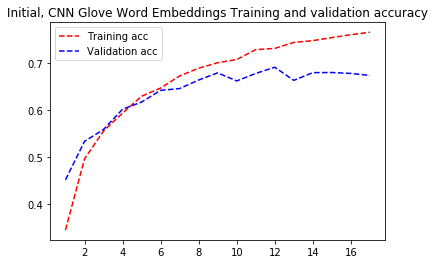

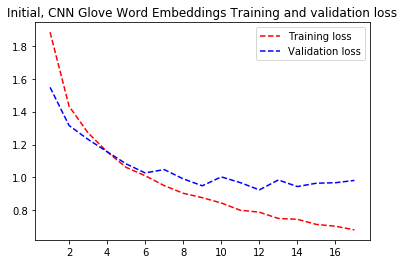

In [169]:
## plot the history
if(train_cnn):
    plothistory(_history_mm, 'Initial, CNN Glove Word Embeddings')

In [180]:
from keras.models import load_model

results = [] 

def evaluate_model(saved_model, x_test, y_test):
    model = load_model(saved_model)
    scores = model.evaluate(x_val, y_val, verbose=0)
    print(saved_model)
    results.append((saved_model, model.metrics_names[1], scores[1]*100, model.metrics_names[0], scores[0]))
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    print("%s: %.2f%%" % (model.metrics_names[0], scores[0]))

In [181]:

evaluate_model('saved_models/weights.best.initialcnn_glovevectors.hdf5', x_val, y_val)

saved_models/weights.best.initialcnn_glovevectors.hdf5
acc: 69.15%
loss: 0.92%


### Remembering Sequences - Long Term Short Term Memory Networks

In [190]:
from keras.models import Sequential

def build_cnn_lstm_model(N_outputs, dense_size, embedding_dim, conv_layer_size, conv_kernel_size, dropout_fraction, lstm_activation, dense_activation, cnn_activation):
    model = None
    model = Sequential()
    model.add(embedding_layer)
    conv_layer_size = int(embedding_dim/2)
    model.add(Conv1D(conv_layer_size, conv_kernel_size, activation=cnn_activation))
    model.add(Dropout(dropout_fraction))
    pool_size = int(conv_kernel_size/2)
    model.add(MaxPooling1D(pool_size=pool_size))
    lstm_size = int (embedding_dim / 2)
    model.add(LSTM(lstm_size, activation=lstm_activation))
    model.add(Dropout(dropout_fraction))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dense(N_outputs, activation=dense_activation))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [191]:
## setup callbacks
callbacks = setup_callbacks('saved_models/weights.best.initiallstemglovevectors.hdf5', 5)

In [192]:
initial_lstm_model = build_cnn_lstm_model(num_classes, num_classes, EMBEDDING_DIM, 32, 5, 0.5, 'relu', 'relu', 'relu')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 100)         852900    
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 996, 50)           25050     
_________________________________________________________________
dropout_7 (Dropout)          (None, 996, 50)           0         
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 498, 50)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 12)                612       
__________

In [197]:
if(train_lstm) :
    _history_lstm = train_model(initial_lstm_model, x_train, y_train, x_val, y_val, callbacks, 50, batch_size)

In [198]:
if(train_lstm) :
## remember the history
    save_training_history(_history_lstm, 'saved_models/initialcnnlstm_glove_vectors_train_history' )

In [199]:
## plot the history
if(train_lstm) :
    plothistory( _history_lstm, 'Initial, CNN With LSTM Layer Glove Word Embeddings')

In [200]:
evaluate_model('saved_models/weights.best.initiallstemglovevectors.hdf5', x_val, y_val)

saved_models/weights.best.initiallstemglovevectors.hdf5
acc: 21.94%
loss: 3.44%


In [201]:
def build_simple_cnn_with_glove_vectors(num_filters, kernel_size, pooling_num, dense_size, num_classes, dropout_level) :


    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    #embedding layer
    embedded_sequences = embedding_layer(sequence_input)
    #convolution layer for extracting features
    x = Conv1D(num_filters, kernel_size, activation='relu')(embedded_sequences)
    #Pooling layer for extracting the most important features 
    x = Dropout(dropout_level)(x)
    x = MaxPooling1D(pooling_num)(x)
    #Convolution layer with num_filters feature maps
   
    x = Flatten()(x)
    x = Dense(dense_size, activation='relu')(x)
    preds = Dense(num_classes, activation='softmax')(x)

    model = Model(sequence_input, preds)

    # summarize the model
    print(model.summary())
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model


In [202]:
## setup callbacks
callbacks = setup_callbacks('saved_models/weights.best.simplecnn_glovevectors.hdf5', 5)

In [203]:
#build_cnn_with_glove_vectors(num_filters, kernel_size, pooling_num, dense_size, num_classes, dropout_level)
simple_cnn_model = build_simple_cnn_with_glove_vectors(32, 4, 2, 24, num_classes, 0.25)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 1000, 100)         852900    
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 997, 32)           12832     
_________________________________________________________________
dropout_9 (Dropout)          (None, 997, 32)           0         
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 498, 32)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 15936)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 24)                382488    
__________

In [207]:
if(train_simplecnn):
    _simple_cnn = train_model(simple_cnn_model, x_train, y_train, x_val, y_val, callbacks, 50, batch_size)

Train on 16064 samples, validate on 4016 samples
Epoch 1/50


 3264/16064 [=====>........................] - ETA: 3:54 - loss: 2.5103 - acc: 0.0000e+0 - ETA: 2:28 - loss: 2.6235 - acc: 0.0938    - ETA: 2:05 - loss: 2.6412 - acc: 0.083 - ETA: 1:53 - loss: 2.5861 - acc: 0.078 - ETA: 1:48 - loss: 2.5827 - acc: 0.062 - ETA: 1:43 - loss: 2.5432 - acc: 0.052 - ETA: 1:38 - loss: 2.5221 - acc: 0.053 - ETA: 1:35 - loss: 2.5147 - acc: 0.054 - ETA: 1:32 - loss: 2.5017 - acc: 0.062 - ETA: 1:30 - loss: 2.4704 - acc: 0.081 - ETA: 1:29 - loss: 2.4459 - acc: 0.096 - ETA: 1:28 - loss: 2.4362 - acc: 0.104 - ETA: 1:29 - loss: 2.4337 - acc: 0.110 - ETA: 1:28 - loss: 2.4204 - acc: 0.111 - ETA: 1:26 - loss: 2.4385 - acc: 0.104 - ETA: 1:25 - loss: 2.4390 - acc: 0.109 - ETA: 1:24 - loss: 2.4245 - acc: 0.114 - ETA: 1:24 - loss: 2.4170 - acc: 0.121 - ETA: 1:23 - loss: 2.4187 - acc: 0.118 - ETA: 1:22 - loss: 2.4151 - acc: 0.118 - ETA: 1:21 - loss: 2.4009 - acc: 0.125 - ETA: 1:21 - loss: 2.3977 - acc: 0.125 - ETA: 1:20 - loss: 2.3955 - acc: 0.127 - ETA: 1:20 - loss: 2.3861 

10144/16064 [=================>............] - ETA: 42s - loss: 2.0456 - acc: 0.31 - ETA: 41s - loss: 2.0457 - acc: 0.31 - ETA: 41s - loss: 2.0446 - acc: 0.31 - ETA: 41s - loss: 2.0447 - acc: 0.31 - ETA: 41s - loss: 2.0444 - acc: 0.31 - ETA: 41s - loss: 2.0437 - acc: 0.31 - ETA: 41s - loss: 2.0430 - acc: 0.31 - ETA: 41s - loss: 2.0425 - acc: 0.31 - ETA: 41s - loss: 2.0416 - acc: 0.31 - ETA: 41s - loss: 2.0425 - acc: 0.31 - ETA: 41s - loss: 2.0427 - acc: 0.31 - ETA: 41s - loss: 2.0421 - acc: 0.31 - ETA: 41s - loss: 2.0425 - acc: 0.31 - ETA: 41s - loss: 2.0417 - acc: 0.31 - ETA: 41s - loss: 2.0406 - acc: 0.32 - ETA: 40s - loss: 2.0399 - acc: 0.32 - ETA: 40s - loss: 2.0388 - acc: 0.32 - ETA: 40s - loss: 2.0377 - acc: 0.32 - ETA: 40s - loss: 2.0373 - acc: 0.32 - ETA: 40s - loss: 2.0369 - acc: 0.32 - ETA: 40s - loss: 2.0367 - acc: 0.32 - ETA: 40s - loss: 2.0358 - acc: 0.32 - ETA: 40s - loss: 2.0348 - acc: 0.32 - ETA: 40s - loss: 2.0346 - acc: 0.32 - ETA: 40s - loss: 2.0342 - acc: 0.32 - ETA

13584/16064 [========================>.....] - ETA: 26s - loss: 1.9602 - acc: 0.34 - ETA: 26s - loss: 1.9596 - acc: 0.34 - ETA: 26s - loss: 1.9594 - acc: 0.34 - ETA: 26s - loss: 1.9590 - acc: 0.34 - ETA: 26s - loss: 1.9587 - acc: 0.34 - ETA: 26s - loss: 1.9579 - acc: 0.34 - ETA: 26s - loss: 1.9573 - acc: 0.34 - ETA: 26s - loss: 1.9571 - acc: 0.34 - ETA: 25s - loss: 1.9568 - acc: 0.34 - ETA: 25s - loss: 1.9560 - acc: 0.34 - ETA: 25s - loss: 1.9545 - acc: 0.34 - ETA: 25s - loss: 1.9542 - acc: 0.35 - ETA: 25s - loss: 1.9541 - acc: 0.34 - ETA: 25s - loss: 1.9538 - acc: 0.35 - ETA: 25s - loss: 1.9535 - acc: 0.35 - ETA: 25s - loss: 1.9535 - acc: 0.35 - ETA: 25s - loss: 1.9534 - acc: 0.35 - ETA: 25s - loss: 1.9532 - acc: 0.35 - ETA: 25s - loss: 1.9518 - acc: 0.35 - ETA: 25s - loss: 1.9510 - acc: 0.35 - ETA: 25s - loss: 1.9506 - acc: 0.35 - ETA: 25s - loss: 1.9495 - acc: 0.35 - ETA: 25s - loss: 1.9498 - acc: 0.35 - ETA: 24s - loss: 1.9492 - acc: 0.35 - ETA: 24s - loss: 1.9488 - acc: 0.35 - ETA

16064/16064 [==============================] - ETA: 11s - loss: 1.8707 - acc: 0.37 - ETA: 11s - loss: 1.8699 - acc: 0.37 - ETA: 11s - loss: 1.8696 - acc: 0.37 - ETA: 11s - loss: 1.8691 - acc: 0.37 - ETA: 11s - loss: 1.8688 - acc: 0.37 - ETA: 11s - loss: 1.8683 - acc: 0.37 - ETA: 10s - loss: 1.8687 - acc: 0.37 - ETA: 10s - loss: 1.8683 - acc: 0.37 - ETA: 10s - loss: 1.8684 - acc: 0.37 - ETA: 10s - loss: 1.8684 - acc: 0.37 - ETA: 10s - loss: 1.8676 - acc: 0.37 - ETA: 10s - loss: 1.8669 - acc: 0.37 - ETA: 10s - loss: 1.8675 - acc: 0.37 - ETA: 10s - loss: 1.8671 - acc: 0.37 - ETA: 10s - loss: 1.8671 - acc: 0.37 - ETA: 10s - loss: 1.8670 - acc: 0.37 - ETA: 10s - loss: 1.8663 - acc: 0.37 - ETA: 10s - loss: 1.8659 - acc: 0.37 - ETA: 10s - loss: 1.8653 - acc: 0.37 - ETA: 9s - loss: 1.8650 - acc: 0.3774 - ETA: 9s - loss: 1.8647 - acc: 0.377 - ETA: 9s - loss: 1.8648 - acc: 0.377 - ETA: 9s - loss: 1.8639 - acc: 0.377 - ETA: 9s - loss: 1.8634 - acc: 0.378 - ETA: 9s - loss: 1.8631 - acc: 0.378 - ET

 3264/16064 [=====>........................] - ETA: 1:54 - loss: 1.4910 - acc: 0.312 - ETA: 1:41 - loss: 1.5344 - acc: 0.312 - ETA: 1:31 - loss: 1.5115 - acc: 0.395 - ETA: 1:26 - loss: 1.4814 - acc: 0.437 - ETA: 1:26 - loss: 1.4084 - acc: 0.462 - ETA: 1:22 - loss: 1.4008 - acc: 0.479 - ETA: 1:21 - loss: 1.3900 - acc: 0.500 - ETA: 1:21 - loss: 1.3916 - acc: 0.492 - ETA: 1:21 - loss: 1.3897 - acc: 0.479 - ETA: 1:20 - loss: 1.3985 - acc: 0.487 - ETA: 1:20 - loss: 1.3798 - acc: 0.505 - ETA: 1:19 - loss: 1.4123 - acc: 0.510 - ETA: 1:19 - loss: 1.4246 - acc: 0.509 - ETA: 1:18 - loss: 1.4500 - acc: 0.504 - ETA: 1:18 - loss: 1.4586 - acc: 0.500 - ETA: 1:17 - loss: 1.4641 - acc: 0.488 - ETA: 1:16 - loss: 1.4491 - acc: 0.496 - ETA: 1:16 - loss: 1.4268 - acc: 0.503 - ETA: 1:16 - loss: 1.4041 - acc: 0.509 - ETA: 1:16 - loss: 1.4007 - acc: 0.512 - ETA: 1:15 - loss: 1.3765 - acc: 0.523 - ETA: 1:15 - loss: 1.3749 - acc: 0.528 - ETA: 1:15 - loss: 1.3800 - acc: 0.527 - ETA: 1:16 - loss: 1.3851 - acc: 0

10096/16064 [=================>............] - ETA: 46s - loss: 1.4083 - acc: 0.52 - ETA: 46s - loss: 1.4087 - acc: 0.51 - ETA: 45s - loss: 1.4078 - acc: 0.51 - ETA: 45s - loss: 1.4085 - acc: 0.51 - ETA: 45s - loss: 1.4088 - acc: 0.51 - ETA: 45s - loss: 1.4097 - acc: 0.51 - ETA: 45s - loss: 1.4105 - acc: 0.51 - ETA: 45s - loss: 1.4096 - acc: 0.51 - ETA: 45s - loss: 1.4098 - acc: 0.51 - ETA: 45s - loss: 1.4097 - acc: 0.51 - ETA: 45s - loss: 1.4103 - acc: 0.51 - ETA: 45s - loss: 1.4115 - acc: 0.51 - ETA: 45s - loss: 1.4123 - acc: 0.51 - ETA: 45s - loss: 1.4120 - acc: 0.51 - ETA: 45s - loss: 1.4127 - acc: 0.51 - ETA: 45s - loss: 1.4124 - acc: 0.51 - ETA: 44s - loss: 1.4127 - acc: 0.51 - ETA: 44s - loss: 1.4118 - acc: 0.51 - ETA: 44s - loss: 1.4115 - acc: 0.51 - ETA: 44s - loss: 1.4101 - acc: 0.51 - ETA: 44s - loss: 1.4093 - acc: 0.51 - ETA: 44s - loss: 1.4087 - acc: 0.52 - ETA: 44s - loss: 1.4091 - acc: 0.52 - ETA: 44s - loss: 1.4096 - acc: 0.51 - ETA: 44s - loss: 1.4090 - acc: 0.52 - ETA

13536/16064 [========================>.....] - ETA: 29s - loss: 1.3997 - acc: 0.52 - ETA: 29s - loss: 1.3988 - acc: 0.52 - ETA: 29s - loss: 1.3989 - acc: 0.52 - ETA: 29s - loss: 1.3989 - acc: 0.52 - ETA: 28s - loss: 1.3987 - acc: 0.52 - ETA: 28s - loss: 1.3980 - acc: 0.52 - ETA: 28s - loss: 1.3981 - acc: 0.52 - ETA: 28s - loss: 1.3983 - acc: 0.52 - ETA: 28s - loss: 1.3980 - acc: 0.52 - ETA: 28s - loss: 1.3981 - acc: 0.52 - ETA: 28s - loss: 1.3978 - acc: 0.52 - ETA: 28s - loss: 1.3980 - acc: 0.52 - ETA: 28s - loss: 1.3978 - acc: 0.52 - ETA: 28s - loss: 1.3972 - acc: 0.52 - ETA: 28s - loss: 1.3965 - acc: 0.52 - ETA: 28s - loss: 1.3965 - acc: 0.52 - ETA: 28s - loss: 1.3965 - acc: 0.52 - ETA: 27s - loss: 1.3960 - acc: 0.52 - ETA: 27s - loss: 1.3962 - acc: 0.52 - ETA: 27s - loss: 1.3968 - acc: 0.52 - ETA: 27s - loss: 1.3962 - acc: 0.52 - ETA: 27s - loss: 1.3967 - acc: 0.52 - ETA: 27s - loss: 1.3971 - acc: 0.52 - ETA: 27s - loss: 1.3973 - acc: 0.52 - ETA: 27s - loss: 1.3968 - acc: 0.52 - ETA

16064/16064 [==============================] - ETA: 12s - loss: 1.3756 - acc: 0.52 - ETA: 12s - loss: 1.3754 - acc: 0.52 - ETA: 12s - loss: 1.3757 - acc: 0.52 - ETA: 11s - loss: 1.3759 - acc: 0.52 - ETA: 11s - loss: 1.3755 - acc: 0.52 - ETA: 11s - loss: 1.3756 - acc: 0.52 - ETA: 11s - loss: 1.3757 - acc: 0.52 - ETA: 11s - loss: 1.3750 - acc: 0.52 - ETA: 11s - loss: 1.3744 - acc: 0.52 - ETA: 11s - loss: 1.3746 - acc: 0.52 - ETA: 11s - loss: 1.3746 - acc: 0.52 - ETA: 11s - loss: 1.3743 - acc: 0.52 - ETA: 11s - loss: 1.3747 - acc: 0.52 - ETA: 11s - loss: 1.3744 - acc: 0.52 - ETA: 11s - loss: 1.3745 - acc: 0.52 - ETA: 11s - loss: 1.3755 - acc: 0.52 - ETA: 10s - loss: 1.3752 - acc: 0.52 - ETA: 10s - loss: 1.3750 - acc: 0.52 - ETA: 10s - loss: 1.3749 - acc: 0.52 - ETA: 10s - loss: 1.3746 - acc: 0.52 - ETA: 10s - loss: 1.3742 - acc: 0.52 - ETA: 10s - loss: 1.3743 - acc: 0.52 - ETA: 10s - loss: 1.3736 - acc: 0.52 - ETA: 10s - loss: 1.3734 - acc: 0.52 - ETA: 10s - loss: 1.3732 - acc: 0.52 - ETA

 3280/16064 [=====>........................] - ETA: 1:17 - loss: 1.0356 - acc: 0.687 - ETA: 1:16 - loss: 1.3442 - acc: 0.625 - ETA: 1:16 - loss: 1.2543 - acc: 0.645 - ETA: 1:16 - loss: 1.1688 - acc: 0.671 - ETA: 1:27 - loss: 1.1986 - acc: 0.662 - ETA: 1:25 - loss: 1.1898 - acc: 0.635 - ETA: 1:24 - loss: 1.2370 - acc: 0.607 - ETA: 1:22 - loss: 1.2589 - acc: 0.601 - ETA: 1:22 - loss: 1.2589 - acc: 0.597 - ETA: 1:23 - loss: 1.2698 - acc: 0.587 - ETA: 1:23 - loss: 1.2546 - acc: 0.590 - ETA: 1:23 - loss: 1.2667 - acc: 0.578 - ETA: 1:24 - loss: 1.2277 - acc: 0.591 - ETA: 1:23 - loss: 1.2223 - acc: 0.598 - ETA: 1:22 - loss: 1.2240 - acc: 0.591 - ETA: 1:21 - loss: 1.2258 - acc: 0.593 - ETA: 1:20 - loss: 1.2031 - acc: 0.595 - ETA: 1:19 - loss: 1.2110 - acc: 0.593 - ETA: 1:19 - loss: 1.2340 - acc: 0.575 - ETA: 1:19 - loss: 1.2609 - acc: 0.565 - ETA: 1:19 - loss: 1.2742 - acc: 0.556 - ETA: 1:18 - loss: 1.2942 - acc: 0.548 - ETA: 1:18 - loss: 1.2738 - acc: 0.554 - ETA: 1:18 - loss: 1.2858 - acc: 0

10160/16064 [=================>............] - ETA: 41s - loss: 1.1619 - acc: 0.59 - ETA: 41s - loss: 1.1618 - acc: 0.59 - ETA: 41s - loss: 1.1629 - acc: 0.59 - ETA: 41s - loss: 1.1626 - acc: 0.59 - ETA: 41s - loss: 1.1628 - acc: 0.59 - ETA: 41s - loss: 1.1624 - acc: 0.59 - ETA: 41s - loss: 1.1631 - acc: 0.59 - ETA: 41s - loss: 1.1632 - acc: 0.59 - ETA: 41s - loss: 1.1631 - acc: 0.59 - ETA: 41s - loss: 1.1635 - acc: 0.59 - ETA: 41s - loss: 1.1632 - acc: 0.59 - ETA: 41s - loss: 1.1645 - acc: 0.59 - ETA: 41s - loss: 1.1646 - acc: 0.59 - ETA: 41s - loss: 1.1636 - acc: 0.59 - ETA: 40s - loss: 1.1644 - acc: 0.59 - ETA: 40s - loss: 1.1635 - acc: 0.59 - ETA: 40s - loss: 1.1638 - acc: 0.59 - ETA: 40s - loss: 1.1633 - acc: 0.59 - ETA: 40s - loss: 1.1631 - acc: 0.59 - ETA: 40s - loss: 1.1632 - acc: 0.59 - ETA: 40s - loss: 1.1639 - acc: 0.59 - ETA: 40s - loss: 1.1645 - acc: 0.59 - ETA: 40s - loss: 1.1649 - acc: 0.59 - ETA: 40s - loss: 1.1654 - acc: 0.59 - ETA: 40s - loss: 1.1653 - acc: 0.59 - ETA

13600/16064 [========================>.....] - ETA: 26s - loss: 1.1660 - acc: 0.59 - ETA: 26s - loss: 1.1654 - acc: 0.59 - ETA: 26s - loss: 1.1650 - acc: 0.59 - ETA: 26s - loss: 1.1649 - acc: 0.59 - ETA: 26s - loss: 1.1641 - acc: 0.59 - ETA: 26s - loss: 1.1635 - acc: 0.59 - ETA: 26s - loss: 1.1633 - acc: 0.59 - ETA: 25s - loss: 1.1641 - acc: 0.59 - ETA: 25s - loss: 1.1638 - acc: 0.59 - ETA: 25s - loss: 1.1640 - acc: 0.59 - ETA: 25s - loss: 1.1649 - acc: 0.59 - ETA: 25s - loss: 1.1649 - acc: 0.59 - ETA: 25s - loss: 1.1649 - acc: 0.59 - ETA: 25s - loss: 1.1647 - acc: 0.59 - ETA: 25s - loss: 1.1644 - acc: 0.59 - ETA: 25s - loss: 1.1639 - acc: 0.59 - ETA: 25s - loss: 1.1640 - acc: 0.59 - ETA: 25s - loss: 1.1637 - acc: 0.59 - ETA: 25s - loss: 1.1640 - acc: 0.59 - ETA: 25s - loss: 1.1644 - acc: 0.59 - ETA: 25s - loss: 1.1636 - acc: 0.59 - ETA: 25s - loss: 1.1634 - acc: 0.59 - ETA: 24s - loss: 1.1632 - acc: 0.59 - ETA: 24s - loss: 1.1635 - acc: 0.59 - ETA: 24s - loss: 1.1636 - acc: 0.59 - ETA

16064/16064 [==============================] - ETA: 11s - loss: 1.1583 - acc: 0.59 - ETA: 11s - loss: 1.1584 - acc: 0.59 - ETA: 11s - loss: 1.1586 - acc: 0.59 - ETA: 10s - loss: 1.1588 - acc: 0.59 - ETA: 10s - loss: 1.1588 - acc: 0.59 - ETA: 10s - loss: 1.1584 - acc: 0.59 - ETA: 10s - loss: 1.1584 - acc: 0.59 - ETA: 10s - loss: 1.1580 - acc: 0.59 - ETA: 10s - loss: 1.1578 - acc: 0.59 - ETA: 10s - loss: 1.1579 - acc: 0.59 - ETA: 10s - loss: 1.1580 - acc: 0.59 - ETA: 10s - loss: 1.1574 - acc: 0.59 - ETA: 10s - loss: 1.1569 - acc: 0.59 - ETA: 10s - loss: 1.1570 - acc: 0.59 - ETA: 10s - loss: 1.1573 - acc: 0.59 - ETA: 10s - loss: 1.1573 - acc: 0.59 - ETA: 9s - loss: 1.1572 - acc: 0.5960 - ETA: 9s - loss: 1.1578 - acc: 0.596 - ETA: 9s - loss: 1.1577 - acc: 0.596 - ETA: 9s - loss: 1.1580 - acc: 0.596 - ETA: 9s - loss: 1.1580 - acc: 0.596 - ETA: 9s - loss: 1.1580 - acc: 0.596 - ETA: 9s - loss: 1.1581 - acc: 0.596 - ETA: 9s - loss: 1.1579 - acc: 0.596 - ETA: 9s - loss: 1.1579 - acc: 0.596 - ET

 3264/16064 [=====>........................] - ETA: 1:14 - loss: 1.1644 - acc: 0.562 - ETA: 1:11 - loss: 0.9728 - acc: 0.687 - ETA: 1:10 - loss: 0.9465 - acc: 0.666 - ETA: 1:10 - loss: 0.9824 - acc: 0.656 - ETA: 1:10 - loss: 0.9726 - acc: 0.662 - ETA: 1:10 - loss: 0.9832 - acc: 0.666 - ETA: 1:11 - loss: 0.9558 - acc: 0.669 - ETA: 1:12 - loss: 0.9479 - acc: 0.671 - ETA: 1:11 - loss: 0.9454 - acc: 0.659 - ETA: 1:11 - loss: 0.9294 - acc: 0.668 - ETA: 1:11 - loss: 0.9563 - acc: 0.664 - ETA: 1:12 - loss: 0.9382 - acc: 0.666 - ETA: 1:12 - loss: 0.9268 - acc: 0.668 - ETA: 1:12 - loss: 0.9453 - acc: 0.660 - ETA: 1:12 - loss: 0.9213 - acc: 0.666 - ETA: 1:11 - loss: 0.9232 - acc: 0.664 - ETA: 1:12 - loss: 0.9177 - acc: 0.669 - ETA: 1:12 - loss: 0.9249 - acc: 0.670 - ETA: 1:12 - loss: 0.9316 - acc: 0.667 - ETA: 1:12 - loss: 0.9256 - acc: 0.662 - ETA: 1:13 - loss: 0.9200 - acc: 0.666 - ETA: 1:13 - loss: 0.9104 - acc: 0.670 - ETA: 1:13 - loss: 0.9131 - acc: 0.673 - ETA: 1:12 - loss: 0.9056 - acc: 0

10144/16064 [=================>............] - ETA: 43s - loss: 0.9931 - acc: 0.65 - ETA: 42s - loss: 0.9944 - acc: 0.65 - ETA: 42s - loss: 0.9946 - acc: 0.65 - ETA: 42s - loss: 0.9951 - acc: 0.65 - ETA: 42s - loss: 0.9949 - acc: 0.65 - ETA: 42s - loss: 0.9959 - acc: 0.65 - ETA: 42s - loss: 0.9952 - acc: 0.65 - ETA: 42s - loss: 0.9958 - acc: 0.65 - ETA: 42s - loss: 0.9962 - acc: 0.65 - ETA: 42s - loss: 0.9961 - acc: 0.65 - ETA: 42s - loss: 0.9969 - acc: 0.65 - ETA: 42s - loss: 0.9971 - acc: 0.65 - ETA: 42s - loss: 0.9975 - acc: 0.65 - ETA: 41s - loss: 0.9976 - acc: 0.65 - ETA: 41s - loss: 0.9981 - acc: 0.64 - ETA: 41s - loss: 0.9982 - acc: 0.64 - ETA: 41s - loss: 0.9980 - acc: 0.64 - ETA: 41s - loss: 0.9973 - acc: 0.65 - ETA: 41s - loss: 0.9966 - acc: 0.65 - ETA: 41s - loss: 0.9973 - acc: 0.65 - ETA: 41s - loss: 0.9978 - acc: 0.65 - ETA: 41s - loss: 0.9982 - acc: 0.64 - ETA: 41s - loss: 0.9980 - acc: 0.65 - ETA: 41s - loss: 0.9975 - acc: 0.65 - ETA: 41s - loss: 0.9979 - acc: 0.65 - ETA

13584/16064 [========================>.....] - ETA: 26s - loss: 1.0051 - acc: 0.64 - ETA: 26s - loss: 1.0049 - acc: 0.64 - ETA: 26s - loss: 1.0041 - acc: 0.64 - ETA: 26s - loss: 1.0038 - acc: 0.64 - ETA: 26s - loss: 1.0040 - acc: 0.64 - ETA: 26s - loss: 1.0044 - acc: 0.64 - ETA: 26s - loss: 1.0037 - acc: 0.64 - ETA: 26s - loss: 1.0039 - acc: 0.64 - ETA: 26s - loss: 1.0039 - acc: 0.64 - ETA: 26s - loss: 1.0045 - acc: 0.64 - ETA: 26s - loss: 1.0040 - acc: 0.64 - ETA: 26s - loss: 1.0038 - acc: 0.64 - ETA: 26s - loss: 1.0034 - acc: 0.64 - ETA: 25s - loss: 1.0037 - acc: 0.64 - ETA: 25s - loss: 1.0045 - acc: 0.64 - ETA: 25s - loss: 1.0049 - acc: 0.64 - ETA: 25s - loss: 1.0046 - acc: 0.64 - ETA: 25s - loss: 1.0045 - acc: 0.64 - ETA: 25s - loss: 1.0046 - acc: 0.64 - ETA: 25s - loss: 1.0049 - acc: 0.64 - ETA: 25s - loss: 1.0051 - acc: 0.64 - ETA: 25s - loss: 1.0050 - acc: 0.64 - ETA: 25s - loss: 1.0044 - acc: 0.64 - ETA: 25s - loss: 1.0038 - acc: 0.64 - ETA: 25s - loss: 1.0041 - acc: 0.64 - ETA

16064/16064 [==============================] - ETA: 11s - loss: 1.0077 - acc: 0.64 - ETA: 11s - loss: 1.0076 - acc: 0.64 - ETA: 11s - loss: 1.0082 - acc: 0.64 - ETA: 10s - loss: 1.0087 - acc: 0.64 - ETA: 10s - loss: 1.0087 - acc: 0.64 - ETA: 10s - loss: 1.0087 - acc: 0.64 - ETA: 10s - loss: 1.0086 - acc: 0.64 - ETA: 10s - loss: 1.0084 - acc: 0.64 - ETA: 10s - loss: 1.0083 - acc: 0.64 - ETA: 10s - loss: 1.0085 - acc: 0.64 - ETA: 10s - loss: 1.0086 - acc: 0.64 - ETA: 10s - loss: 1.0087 - acc: 0.64 - ETA: 10s - loss: 1.0082 - acc: 0.64 - ETA: 10s - loss: 1.0081 - acc: 0.64 - ETA: 10s - loss: 1.0083 - acc: 0.64 - ETA: 10s - loss: 1.0085 - acc: 0.64 - ETA: 10s - loss: 1.0084 - acc: 0.64 - ETA: 9s - loss: 1.0083 - acc: 0.6469 - ETA: 9s - loss: 1.0081 - acc: 0.646 - ETA: 9s - loss: 1.0080 - acc: 0.646 - ETA: 9s - loss: 1.0078 - acc: 0.646 - ETA: 9s - loss: 1.0077 - acc: 0.647 - ETA: 9s - loss: 1.0075 - acc: 0.647 - ETA: 9s - loss: 1.0077 - acc: 0.647 - ETA: 9s - loss: 1.0085 - acc: 0.647 - ET

 3312/16064 [=====>........................] - ETA: 1:02 - loss: 1.0000 - acc: 0.687 - ETA: 1:18 - loss: 0.8871 - acc: 0.687 - ETA: 1:12 - loss: 0.9433 - acc: 0.687 - ETA: 1:10 - loss: 0.8407 - acc: 0.750 - ETA: 1:11 - loss: 0.8802 - acc: 0.700 - ETA: 1:10 - loss: 0.8788 - acc: 0.687 - ETA: 1:08 - loss: 0.8686 - acc: 0.687 - ETA: 1:08 - loss: 0.8964 - acc: 0.664 - ETA: 1:09 - loss: 0.8681 - acc: 0.687 - ETA: 1:08 - loss: 0.9390 - acc: 0.662 - ETA: 1:07 - loss: 0.9422 - acc: 0.664 - ETA: 1:07 - loss: 0.9153 - acc: 0.682 - ETA: 1:08 - loss: 0.8796 - acc: 0.692 - ETA: 1:08 - loss: 0.8631 - acc: 0.700 - ETA: 1:09 - loss: 0.8729 - acc: 0.695 - ETA: 1:10 - loss: 0.8480 - acc: 0.703 - ETA: 1:10 - loss: 0.8338 - acc: 0.705 - ETA: 1:12 - loss: 0.8363 - acc: 0.704 - ETA: 1:12 - loss: 0.8256 - acc: 0.710 - ETA: 1:13 - loss: 0.8341 - acc: 0.703 - ETA: 1:13 - loss: 0.8614 - acc: 0.699 - ETA: 1:13 - loss: 0.8599 - acc: 0.704 - ETA: 1:13 - loss: 0.8584 - acc: 0.706 - ETA: 1:13 - loss: 0.8365 - acc: 0

10192/16064 [==================>...........] - ETA: 40s - loss: 0.8900 - acc: 0.68 - ETA: 40s - loss: 0.8898 - acc: 0.68 - ETA: 40s - loss: 0.8922 - acc: 0.68 - ETA: 39s - loss: 0.8916 - acc: 0.68 - ETA: 39s - loss: 0.8916 - acc: 0.68 - ETA: 39s - loss: 0.8912 - acc: 0.68 - ETA: 39s - loss: 0.8909 - acc: 0.68 - ETA: 39s - loss: 0.8912 - acc: 0.68 - ETA: 39s - loss: 0.8916 - acc: 0.68 - ETA: 39s - loss: 0.8907 - acc: 0.68 - ETA: 39s - loss: 0.8911 - acc: 0.68 - ETA: 39s - loss: 0.8906 - acc: 0.68 - ETA: 39s - loss: 0.8912 - acc: 0.68 - ETA: 39s - loss: 0.8907 - acc: 0.68 - ETA: 39s - loss: 0.8901 - acc: 0.68 - ETA: 39s - loss: 0.8903 - acc: 0.68 - ETA: 39s - loss: 0.8894 - acc: 0.68 - ETA: 39s - loss: 0.8885 - acc: 0.68 - ETA: 38s - loss: 0.8879 - acc: 0.68 - ETA: 38s - loss: 0.8883 - acc: 0.68 - ETA: 38s - loss: 0.8906 - acc: 0.68 - ETA: 38s - loss: 0.8911 - acc: 0.68 - ETA: 38s - loss: 0.8917 - acc: 0.68 - ETA: 38s - loss: 0.8920 - acc: 0.68 - ETA: 38s - loss: 0.8926 - acc: 0.68 - ETA

13632/16064 [========================>.....] - ETA: 25s - loss: 0.8995 - acc: 0.67 - ETA: 25s - loss: 0.8997 - acc: 0.67 - ETA: 25s - loss: 0.9003 - acc: 0.67 - ETA: 25s - loss: 0.9006 - acc: 0.67 - ETA: 25s - loss: 0.9007 - acc: 0.67 - ETA: 25s - loss: 0.9003 - acc: 0.67 - ETA: 25s - loss: 0.9005 - acc: 0.67 - ETA: 25s - loss: 0.9005 - acc: 0.67 - ETA: 25s - loss: 0.9006 - acc: 0.67 - ETA: 25s - loss: 0.9003 - acc: 0.67 - ETA: 25s - loss: 0.9014 - acc: 0.67 - ETA: 25s - loss: 0.9008 - acc: 0.67 - ETA: 25s - loss: 0.8999 - acc: 0.67 - ETA: 25s - loss: 0.8998 - acc: 0.67 - ETA: 25s - loss: 0.8995 - acc: 0.67 - ETA: 24s - loss: 0.8996 - acc: 0.67 - ETA: 24s - loss: 0.8994 - acc: 0.67 - ETA: 24s - loss: 0.8996 - acc: 0.67 - ETA: 24s - loss: 0.8994 - acc: 0.67 - ETA: 24s - loss: 0.8993 - acc: 0.67 - ETA: 24s - loss: 0.8991 - acc: 0.67 - ETA: 24s - loss: 0.8990 - acc: 0.67 - ETA: 24s - loss: 0.8993 - acc: 0.67 - ETA: 24s - loss: 0.8996 - acc: 0.67 - ETA: 24s - loss: 0.8994 - acc: 0.67 - ETA

16064/16064 [==============================] - ETA: 10s - loss: 0.8982 - acc: 0.67 - ETA: 10s - loss: 0.8984 - acc: 0.67 - ETA: 10s - loss: 0.8979 - acc: 0.67 - ETA: 10s - loss: 0.8977 - acc: 0.67 - ETA: 10s - loss: 0.8973 - acc: 0.67 - ETA: 10s - loss: 0.8975 - acc: 0.67 - ETA: 10s - loss: 0.8973 - acc: 0.67 - ETA: 10s - loss: 0.8977 - acc: 0.67 - ETA: 10s - loss: 0.8976 - acc: 0.67 - ETA: 10s - loss: 0.8976 - acc: 0.67 - ETA: 10s - loss: 0.8976 - acc: 0.67 - ETA: 10s - loss: 0.8980 - acc: 0.67 - ETA: 10s - loss: 0.8978 - acc: 0.67 - ETA: 10s - loss: 0.8974 - acc: 0.67 - ETA: 9s - loss: 0.8972 - acc: 0.6781 - ETA: 9s - loss: 0.8978 - acc: 0.677 - ETA: 9s - loss: 0.8985 - acc: 0.677 - ETA: 9s - loss: 0.8987 - acc: 0.677 - ETA: 9s - loss: 0.8986 - acc: 0.677 - ETA: 9s - loss: 0.8986 - acc: 0.677 - ETA: 9s - loss: 0.8987 - acc: 0.677 - ETA: 9s - loss: 0.8993 - acc: 0.676 - ETA: 9s - loss: 0.8991 - acc: 0.676 - ETA: 9s - loss: 0.8987 - acc: 0.677 - ETA: 9s - loss: 0.8986 - acc: 0.677 - ET

 3280/16064 [=====>........................] - ETA: 1:11 - loss: 0.6259 - acc: 0.812 - ETA: 1:17 - loss: 0.5643 - acc: 0.843 - ETA: 1:18 - loss: 0.6406 - acc: 0.791 - ETA: 1:16 - loss: 0.6663 - acc: 0.796 - ETA: 1:16 - loss: 0.7008 - acc: 0.775 - ETA: 1:13 - loss: 0.7578 - acc: 0.739 - ETA: 1:14 - loss: 0.7433 - acc: 0.741 - ETA: 1:13 - loss: 0.7408 - acc: 0.734 - ETA: 1:13 - loss: 0.7135 - acc: 0.743 - ETA: 1:11 - loss: 0.7243 - acc: 0.743 - ETA: 1:12 - loss: 0.7274 - acc: 0.733 - ETA: 1:11 - loss: 0.7501 - acc: 0.734 - ETA: 1:10 - loss: 0.7522 - acc: 0.735 - ETA: 1:11 - loss: 0.7351 - acc: 0.741 - ETA: 1:09 - loss: 0.7213 - acc: 0.745 - ETA: 1:10 - loss: 0.7071 - acc: 0.746 - ETA: 1:10 - loss: 0.7069 - acc: 0.750 - ETA: 1:10 - loss: 0.7031 - acc: 0.753 - ETA: 1:10 - loss: 0.7092 - acc: 0.753 - ETA: 1:10 - loss: 0.7100 - acc: 0.756 - ETA: 1:10 - loss: 0.7044 - acc: 0.756 - ETA: 1:10 - loss: 0.7204 - acc: 0.752 - ETA: 1:10 - loss: 0.7308 - acc: 0.750 - ETA: 1:10 - loss: 0.7464 - acc: 0

10160/16064 [=================>............] - ETA: 43s - loss: 0.7915 - acc: 0.71 - ETA: 43s - loss: 0.7910 - acc: 0.71 - ETA: 42s - loss: 0.7920 - acc: 0.71 - ETA: 42s - loss: 0.7925 - acc: 0.71 - ETA: 42s - loss: 0.7922 - acc: 0.71 - ETA: 42s - loss: 0.7927 - acc: 0.71 - ETA: 42s - loss: 0.7923 - acc: 0.71 - ETA: 42s - loss: 0.7924 - acc: 0.71 - ETA: 42s - loss: 0.7932 - acc: 0.71 - ETA: 42s - loss: 0.7937 - acc: 0.71 - ETA: 42s - loss: 0.7935 - acc: 0.71 - ETA: 42s - loss: 0.7945 - acc: 0.71 - ETA: 42s - loss: 0.7946 - acc: 0.71 - ETA: 42s - loss: 0.7951 - acc: 0.71 - ETA: 42s - loss: 0.7944 - acc: 0.71 - ETA: 42s - loss: 0.7943 - acc: 0.71 - ETA: 41s - loss: 0.7943 - acc: 0.71 - ETA: 41s - loss: 0.7954 - acc: 0.71 - ETA: 41s - loss: 0.7959 - acc: 0.71 - ETA: 41s - loss: 0.7952 - acc: 0.71 - ETA: 41s - loss: 0.7948 - acc: 0.71 - ETA: 41s - loss: 0.7947 - acc: 0.71 - ETA: 41s - loss: 0.7951 - acc: 0.71 - ETA: 41s - loss: 0.7943 - acc: 0.71 - ETA: 41s - loss: 0.7947 - acc: 0.71 - ETA

13600/16064 [========================>.....] - ETA: 27s - loss: 0.8007 - acc: 0.71 - ETA: 27s - loss: 0.8000 - acc: 0.71 - ETA: 27s - loss: 0.7997 - acc: 0.71 - ETA: 27s - loss: 0.7995 - acc: 0.71 - ETA: 26s - loss: 0.7994 - acc: 0.71 - ETA: 26s - loss: 0.7996 - acc: 0.71 - ETA: 26s - loss: 0.7993 - acc: 0.71 - ETA: 26s - loss: 0.7996 - acc: 0.71 - ETA: 26s - loss: 0.7996 - acc: 0.71 - ETA: 26s - loss: 0.7993 - acc: 0.71 - ETA: 26s - loss: 0.7995 - acc: 0.71 - ETA: 26s - loss: 0.7991 - acc: 0.71 - ETA: 26s - loss: 0.7991 - acc: 0.71 - ETA: 26s - loss: 0.7997 - acc: 0.71 - ETA: 26s - loss: 0.8000 - acc: 0.71 - ETA: 26s - loss: 0.8000 - acc: 0.71 - ETA: 26s - loss: 0.8002 - acc: 0.71 - ETA: 25s - loss: 0.8001 - acc: 0.71 - ETA: 25s - loss: 0.8005 - acc: 0.71 - ETA: 25s - loss: 0.8010 - acc: 0.71 - ETA: 25s - loss: 0.8016 - acc: 0.71 - ETA: 25s - loss: 0.8022 - acc: 0.71 - ETA: 25s - loss: 0.8027 - acc: 0.71 - ETA: 25s - loss: 0.8030 - acc: 0.71 - ETA: 25s - loss: 0.8025 - acc: 0.71 - ETA

16064/16064 [==============================] - ETA: 11s - loss: 0.8154 - acc: 0.70 - ETA: 11s - loss: 0.8155 - acc: 0.70 - ETA: 11s - loss: 0.8151 - acc: 0.70 - ETA: 11s - loss: 0.8149 - acc: 0.70 - ETA: 10s - loss: 0.8153 - acc: 0.70 - ETA: 10s - loss: 0.8149 - acc: 0.70 - ETA: 10s - loss: 0.8148 - acc: 0.70 - ETA: 10s - loss: 0.8149 - acc: 0.70 - ETA: 10s - loss: 0.8148 - acc: 0.70 - ETA: 10s - loss: 0.8149 - acc: 0.70 - ETA: 10s - loss: 0.8147 - acc: 0.70 - ETA: 10s - loss: 0.8148 - acc: 0.70 - ETA: 10s - loss: 0.8147 - acc: 0.70 - ETA: 10s - loss: 0.8148 - acc: 0.70 - ETA: 10s - loss: 0.8152 - acc: 0.70 - ETA: 10s - loss: 0.8152 - acc: 0.70 - ETA: 10s - loss: 0.8152 - acc: 0.70 - ETA: 9s - loss: 0.8158 - acc: 0.7072 - ETA: 9s - loss: 0.8156 - acc: 0.707 - ETA: 9s - loss: 0.8153 - acc: 0.707 - ETA: 9s - loss: 0.8150 - acc: 0.707 - ETA: 9s - loss: 0.8148 - acc: 0.707 - ETA: 9s - loss: 0.8156 - acc: 0.707 - ETA: 9s - loss: 0.8153 - acc: 0.707 - ETA: 9s - loss: 0.8151 - acc: 0.707 - ET

 3280/16064 [=====>........................] - ETA: 1:10 - loss: 1.5032 - acc: 0.625 - ETA: 1:08 - loss: 1.1886 - acc: 0.687 - ETA: 1:10 - loss: 1.0613 - acc: 0.708 - ETA: 1:16 - loss: 0.9397 - acc: 0.703 - ETA: 1:17 - loss: 0.8885 - acc: 0.700 - ETA: 1:17 - loss: 0.8000 - acc: 0.739 - ETA: 1:19 - loss: 0.7916 - acc: 0.741 - ETA: 1:21 - loss: 0.7666 - acc: 0.750 - ETA: 1:18 - loss: 0.7320 - acc: 0.763 - ETA: 1:18 - loss: 0.7259 - acc: 0.775 - ETA: 1:16 - loss: 0.7247 - acc: 0.767 - ETA: 1:16 - loss: 0.7361 - acc: 0.760 - ETA: 1:16 - loss: 0.7377 - acc: 0.764 - ETA: 1:15 - loss: 0.7055 - acc: 0.776 - ETA: 1:14 - loss: 0.7324 - acc: 0.775 - ETA: 1:15 - loss: 0.7192 - acc: 0.781 - ETA: 1:15 - loss: 0.7205 - acc: 0.775 - ETA: 1:15 - loss: 0.7086 - acc: 0.781 - ETA: 1:14 - loss: 0.7209 - acc: 0.776 - ETA: 1:14 - loss: 0.7175 - acc: 0.775 - ETA: 1:14 - loss: 0.7086 - acc: 0.773 - ETA: 1:14 - loss: 0.7085 - acc: 0.778 - ETA: 1:14 - loss: 0.7140 - acc: 0.779 - ETA: 1:14 - loss: 0.6980 - acc: 0

10160/16064 [=================>............] - ETA: 44s - loss: 0.7141 - acc: 0.74 - ETA: 44s - loss: 0.7145 - acc: 0.74 - ETA: 44s - loss: 0.7151 - acc: 0.74 - ETA: 44s - loss: 0.7166 - acc: 0.74 - ETA: 43s - loss: 0.7162 - acc: 0.74 - ETA: 43s - loss: 0.7163 - acc: 0.74 - ETA: 43s - loss: 0.7163 - acc: 0.74 - ETA: 43s - loss: 0.7164 - acc: 0.74 - ETA: 43s - loss: 0.7160 - acc: 0.74 - ETA: 43s - loss: 0.7169 - acc: 0.74 - ETA: 43s - loss: 0.7158 - acc: 0.74 - ETA: 43s - loss: 0.7158 - acc: 0.74 - ETA: 43s - loss: 0.7156 - acc: 0.74 - ETA: 43s - loss: 0.7156 - acc: 0.74 - ETA: 43s - loss: 0.7152 - acc: 0.74 - ETA: 43s - loss: 0.7151 - acc: 0.74 - ETA: 42s - loss: 0.7143 - acc: 0.74 - ETA: 42s - loss: 0.7145 - acc: 0.74 - ETA: 42s - loss: 0.7151 - acc: 0.74 - ETA: 42s - loss: 0.7149 - acc: 0.74 - ETA: 42s - loss: 0.7152 - acc: 0.74 - ETA: 42s - loss: 0.7155 - acc: 0.74 - ETA: 42s - loss: 0.7152 - acc: 0.74 - ETA: 42s - loss: 0.7158 - acc: 0.74 - ETA: 42s - loss: 0.7157 - acc: 0.74 - ETA

13600/16064 [========================>.....] - ETA: 27s - loss: 0.7257 - acc: 0.74 - ETA: 27s - loss: 0.7265 - acc: 0.74 - ETA: 27s - loss: 0.7273 - acc: 0.74 - ETA: 27s - loss: 0.7278 - acc: 0.73 - ETA: 27s - loss: 0.7283 - acc: 0.73 - ETA: 27s - loss: 0.7288 - acc: 0.73 - ETA: 27s - loss: 0.7286 - acc: 0.73 - ETA: 26s - loss: 0.7289 - acc: 0.73 - ETA: 26s - loss: 0.7296 - acc: 0.73 - ETA: 26s - loss: 0.7293 - acc: 0.73 - ETA: 26s - loss: 0.7297 - acc: 0.73 - ETA: 26s - loss: 0.7303 - acc: 0.73 - ETA: 26s - loss: 0.7303 - acc: 0.73 - ETA: 26s - loss: 0.7307 - acc: 0.73 - ETA: 26s - loss: 0.7302 - acc: 0.73 - ETA: 26s - loss: 0.7305 - acc: 0.73 - ETA: 26s - loss: 0.7309 - acc: 0.73 - ETA: 26s - loss: 0.7312 - acc: 0.73 - ETA: 26s - loss: 0.7311 - acc: 0.73 - ETA: 26s - loss: 0.7312 - acc: 0.73 - ETA: 25s - loss: 0.7314 - acc: 0.73 - ETA: 25s - loss: 0.7319 - acc: 0.73 - ETA: 25s - loss: 0.7320 - acc: 0.73 - ETA: 25s - loss: 0.7315 - acc: 0.73 - ETA: 25s - loss: 0.7314 - acc: 0.73 - ETA

16064/16064 [==============================] - ETA: 11s - loss: 0.7423 - acc: 0.73 - ETA: 11s - loss: 0.7419 - acc: 0.73 - ETA: 11s - loss: 0.7420 - acc: 0.73 - ETA: 11s - loss: 0.7426 - acc: 0.73 - ETA: 11s - loss: 0.7428 - acc: 0.73 - ETA: 10s - loss: 0.7429 - acc: 0.73 - ETA: 10s - loss: 0.7428 - acc: 0.73 - ETA: 10s - loss: 0.7426 - acc: 0.73 - ETA: 10s - loss: 0.7425 - acc: 0.73 - ETA: 10s - loss: 0.7433 - acc: 0.73 - ETA: 10s - loss: 0.7430 - acc: 0.73 - ETA: 10s - loss: 0.7428 - acc: 0.73 - ETA: 10s - loss: 0.7426 - acc: 0.73 - ETA: 10s - loss: 0.7425 - acc: 0.73 - ETA: 10s - loss: 0.7432 - acc: 0.73 - ETA: 10s - loss: 0.7431 - acc: 0.73 - ETA: 10s - loss: 0.7429 - acc: 0.73 - ETA: 10s - loss: 0.7428 - acc: 0.73 - ETA: 9s - loss: 0.7429 - acc: 0.7345 - ETA: 9s - loss: 0.7428 - acc: 0.734 - ETA: 9s - loss: 0.7434 - acc: 0.734 - ETA: 9s - loss: 0.7434 - acc: 0.734 - ETA: 9s - loss: 0.7434 - acc: 0.734 - ETA: 9s - loss: 0.7434 - acc: 0.734 - ETA: 9s - loss: 0.7437 - acc: 0.734 - ET

 3296/16064 [=====>........................] - ETA: 1:05 - loss: 0.9705 - acc: 0.812 - ETA: 1:05 - loss: 0.8702 - acc: 0.750 - ETA: 1:07 - loss: 0.7314 - acc: 0.791 - ETA: 1:07 - loss: 0.6882 - acc: 0.796 - ETA: 1:07 - loss: 0.7251 - acc: 0.787 - ETA: 1:07 - loss: 0.7378 - acc: 0.770 - ETA: 1:07 - loss: 0.6788 - acc: 0.785 - ETA: 1:08 - loss: 0.7850 - acc: 0.734 - ETA: 1:08 - loss: 0.7666 - acc: 0.750 - ETA: 1:08 - loss: 0.7469 - acc: 0.756 - ETA: 1:08 - loss: 0.7459 - acc: 0.750 - ETA: 1:08 - loss: 0.7169 - acc: 0.750 - ETA: 1:08 - loss: 0.6999 - acc: 0.759 - ETA: 1:08 - loss: 0.6923 - acc: 0.758 - ETA: 1:08 - loss: 0.6745 - acc: 0.766 - ETA: 1:08 - loss: 0.6722 - acc: 0.769 - ETA: 1:08 - loss: 0.6733 - acc: 0.772 - ETA: 1:08 - loss: 0.6529 - acc: 0.781 - ETA: 1:08 - loss: 0.6568 - acc: 0.773 - ETA: 1:08 - loss: 0.6587 - acc: 0.768 - ETA: 1:10 - loss: 0.6557 - acc: 0.770 - ETA: 1:10 - loss: 0.6406 - acc: 0.775 - ETA: 1:10 - loss: 0.6462 - acc: 0.769 - ETA: 1:10 - loss: 0.6550 - acc: 0

10176/16064 [==================>...........] - ETA: 41s - loss: 0.6827 - acc: 0.76 - ETA: 41s - loss: 0.6833 - acc: 0.76 - ETA: 41s - loss: 0.6847 - acc: 0.75 - ETA: 41s - loss: 0.6844 - acc: 0.75 - ETA: 41s - loss: 0.6855 - acc: 0.75 - ETA: 41s - loss: 0.6855 - acc: 0.75 - ETA: 41s - loss: 0.6854 - acc: 0.75 - ETA: 41s - loss: 0.6852 - acc: 0.75 - ETA: 41s - loss: 0.6861 - acc: 0.75 - ETA: 41s - loss: 0.6859 - acc: 0.75 - ETA: 41s - loss: 0.6859 - acc: 0.75 - ETA: 40s - loss: 0.6857 - acc: 0.75 - ETA: 40s - loss: 0.6868 - acc: 0.75 - ETA: 40s - loss: 0.6870 - acc: 0.75 - ETA: 40s - loss: 0.6869 - acc: 0.75 - ETA: 40s - loss: 0.6861 - acc: 0.75 - ETA: 40s - loss: 0.6864 - acc: 0.75 - ETA: 40s - loss: 0.6860 - acc: 0.75 - ETA: 40s - loss: 0.6858 - acc: 0.75 - ETA: 40s - loss: 0.6855 - acc: 0.75 - ETA: 40s - loss: 0.6850 - acc: 0.75 - ETA: 40s - loss: 0.6849 - acc: 0.75 - ETA: 40s - loss: 0.6846 - acc: 0.75 - ETA: 40s - loss: 0.6849 - acc: 0.75 - ETA: 40s - loss: 0.6848 - acc: 0.75 - ETA

13616/16064 [========================>.....] - ETA: 26s - loss: 0.6926 - acc: 0.75 - ETA: 26s - loss: 0.6921 - acc: 0.75 - ETA: 26s - loss: 0.6931 - acc: 0.75 - ETA: 26s - loss: 0.6926 - acc: 0.75 - ETA: 26s - loss: 0.6931 - acc: 0.75 - ETA: 26s - loss: 0.6933 - acc: 0.75 - ETA: 26s - loss: 0.6932 - acc: 0.75 - ETA: 25s - loss: 0.6930 - acc: 0.75 - ETA: 25s - loss: 0.6923 - acc: 0.75 - ETA: 25s - loss: 0.6922 - acc: 0.75 - ETA: 25s - loss: 0.6925 - acc: 0.75 - ETA: 25s - loss: 0.6923 - acc: 0.75 - ETA: 25s - loss: 0.6919 - acc: 0.75 - ETA: 25s - loss: 0.6927 - acc: 0.75 - ETA: 25s - loss: 0.6934 - acc: 0.75 - ETA: 25s - loss: 0.6928 - acc: 0.75 - ETA: 25s - loss: 0.6928 - acc: 0.75 - ETA: 25s - loss: 0.6927 - acc: 0.75 - ETA: 25s - loss: 0.6925 - acc: 0.75 - ETA: 25s - loss: 0.6928 - acc: 0.75 - ETA: 25s - loss: 0.6928 - acc: 0.75 - ETA: 24s - loss: 0.6924 - acc: 0.75 - ETA: 24s - loss: 0.6922 - acc: 0.75 - ETA: 24s - loss: 0.6927 - acc: 0.75 - ETA: 24s - loss: 0.6927 - acc: 0.75 - ETA

16064/16064 [==============================] - ETA: 10s - loss: 0.7075 - acc: 0.74 - ETA: 10s - loss: 0.7074 - acc: 0.74 - ETA: 10s - loss: 0.7071 - acc: 0.74 - ETA: 10s - loss: 0.7071 - acc: 0.74 - ETA: 10s - loss: 0.7069 - acc: 0.74 - ETA: 10s - loss: 0.7068 - acc: 0.74 - ETA: 10s - loss: 0.7066 - acc: 0.74 - ETA: 10s - loss: 0.7065 - acc: 0.74 - ETA: 10s - loss: 0.7064 - acc: 0.74 - ETA: 10s - loss: 0.7063 - acc: 0.74 - ETA: 10s - loss: 0.7063 - acc: 0.74 - ETA: 10s - loss: 0.7062 - acc: 0.74 - ETA: 10s - loss: 0.7061 - acc: 0.74 - ETA: 10s - loss: 0.7066 - acc: 0.74 - ETA: 9s - loss: 0.7068 - acc: 0.7473 - ETA: 9s - loss: 0.7067 - acc: 0.747 - ETA: 9s - loss: 0.7071 - acc: 0.747 - ETA: 9s - loss: 0.7068 - acc: 0.747 - ETA: 9s - loss: 0.7064 - acc: 0.747 - ETA: 9s - loss: 0.7066 - acc: 0.747 - ETA: 9s - loss: 0.7064 - acc: 0.747 - ETA: 9s - loss: 0.7066 - acc: 0.747 - ETA: 9s - loss: 0.7064 - acc: 0.747 - ETA: 9s - loss: 0.7067 - acc: 0.747 - ETA: 9s - loss: 0.7070 - acc: 0.747 - ET

 3296/16064 [=====>........................] - ETA: 1:12 - loss: 1.1280 - acc: 0.562 - ETA: 1:12 - loss: 0.9687 - acc: 0.625 - ETA: 1:05 - loss: 0.7503 - acc: 0.729 - ETA: 1:10 - loss: 0.6845 - acc: 0.765 - ETA: 1:12 - loss: 0.7104 - acc: 0.725 - ETA: 1:11 - loss: 0.7225 - acc: 0.718 - ETA: 1:10 - loss: 0.6939 - acc: 0.741 - ETA: 1:09 - loss: 0.7195 - acc: 0.726 - ETA: 1:10 - loss: 0.7233 - acc: 0.729 - ETA: 1:10 - loss: 0.7728 - acc: 0.712 - ETA: 1:10 - loss: 0.8007 - acc: 0.693 - ETA: 1:10 - loss: 0.7714 - acc: 0.703 - ETA: 1:09 - loss: 0.7467 - acc: 0.716 - ETA: 1:09 - loss: 0.7228 - acc: 0.709 - ETA: 1:09 - loss: 0.7231 - acc: 0.708 - ETA: 1:09 - loss: 0.7208 - acc: 0.710 - ETA: 1:09 - loss: 0.7300 - acc: 0.705 - ETA: 1:09 - loss: 0.7194 - acc: 0.711 - ETA: 1:08 - loss: 0.7020 - acc: 0.717 - ETA: 1:09 - loss: 0.7003 - acc: 0.715 - ETA: 1:09 - loss: 0.6933 - acc: 0.717 - ETA: 1:09 - loss: 0.7027 - acc: 0.718 - ETA: 1:09 - loss: 0.7062 - acc: 0.720 - ETA: 1:09 - loss: 0.7098 - acc: 0

10176/16064 [==================>...........] - ETA: 42s - loss: 0.6288 - acc: 0.77 - ETA: 42s - loss: 0.6291 - acc: 0.77 - ETA: 42s - loss: 0.6296 - acc: 0.77 - ETA: 42s - loss: 0.6295 - acc: 0.77 - ETA: 42s - loss: 0.6296 - acc: 0.77 - ETA: 42s - loss: 0.6297 - acc: 0.77 - ETA: 42s - loss: 0.6295 - acc: 0.77 - ETA: 42s - loss: 0.6299 - acc: 0.77 - ETA: 42s - loss: 0.6308 - acc: 0.77 - ETA: 42s - loss: 0.6304 - acc: 0.77 - ETA: 41s - loss: 0.6309 - acc: 0.77 - ETA: 41s - loss: 0.6305 - acc: 0.77 - ETA: 41s - loss: 0.6305 - acc: 0.77 - ETA: 41s - loss: 0.6306 - acc: 0.77 - ETA: 41s - loss: 0.6311 - acc: 0.77 - ETA: 41s - loss: 0.6306 - acc: 0.77 - ETA: 41s - loss: 0.6302 - acc: 0.77 - ETA: 41s - loss: 0.6299 - acc: 0.77 - ETA: 41s - loss: 0.6299 - acc: 0.77 - ETA: 41s - loss: 0.6296 - acc: 0.77 - ETA: 41s - loss: 0.6297 - acc: 0.77 - ETA: 41s - loss: 0.6290 - acc: 0.77 - ETA: 41s - loss: 0.6289 - acc: 0.77 - ETA: 41s - loss: 0.6295 - acc: 0.77 - ETA: 41s - loss: 0.6295 - acc: 0.77 - ETA

13616/16064 [========================>.....] - ETA: 27s - loss: 0.6402 - acc: 0.76 - ETA: 27s - loss: 0.6401 - acc: 0.76 - ETA: 27s - loss: 0.6402 - acc: 0.76 - ETA: 27s - loss: 0.6409 - acc: 0.76 - ETA: 27s - loss: 0.6408 - acc: 0.76 - ETA: 27s - loss: 0.6407 - acc: 0.76 - ETA: 27s - loss: 0.6408 - acc: 0.76 - ETA: 26s - loss: 0.6404 - acc: 0.76 - ETA: 26s - loss: 0.6406 - acc: 0.76 - ETA: 26s - loss: 0.6405 - acc: 0.76 - ETA: 26s - loss: 0.6405 - acc: 0.76 - ETA: 26s - loss: 0.6407 - acc: 0.76 - ETA: 26s - loss: 0.6408 - acc: 0.76 - ETA: 26s - loss: 0.6406 - acc: 0.76 - ETA: 26s - loss: 0.6401 - acc: 0.76 - ETA: 26s - loss: 0.6402 - acc: 0.76 - ETA: 26s - loss: 0.6401 - acc: 0.76 - ETA: 26s - loss: 0.6407 - acc: 0.76 - ETA: 26s - loss: 0.6408 - acc: 0.76 - ETA: 26s - loss: 0.6411 - acc: 0.76 - ETA: 25s - loss: 0.6408 - acc: 0.76 - ETA: 25s - loss: 0.6403 - acc: 0.76 - ETA: 25s - loss: 0.6409 - acc: 0.76 - ETA: 25s - loss: 0.6411 - acc: 0.76 - ETA: 25s - loss: 0.6410 - acc: 0.76 - ETA

16064/16064 [==============================] - ETA: 11s - loss: 0.6514 - acc: 0.76 - ETA: 11s - loss: 0.6522 - acc: 0.76 - ETA: 11s - loss: 0.6519 - acc: 0.76 - ETA: 11s - loss: 0.6520 - acc: 0.76 - ETA: 11s - loss: 0.6523 - acc: 0.76 - ETA: 10s - loss: 0.6524 - acc: 0.76 - ETA: 10s - loss: 0.6525 - acc: 0.76 - ETA: 10s - loss: 0.6523 - acc: 0.76 - ETA: 10s - loss: 0.6531 - acc: 0.76 - ETA: 10s - loss: 0.6530 - acc: 0.76 - ETA: 10s - loss: 0.6533 - acc: 0.76 - ETA: 10s - loss: 0.6529 - acc: 0.76 - ETA: 10s - loss: 0.6537 - acc: 0.76 - ETA: 10s - loss: 0.6536 - acc: 0.76 - ETA: 10s - loss: 0.6531 - acc: 0.76 - ETA: 10s - loss: 0.6530 - acc: 0.76 - ETA: 10s - loss: 0.6528 - acc: 0.76 - ETA: 10s - loss: 0.6528 - acc: 0.76 - ETA: 9s - loss: 0.6526 - acc: 0.7648 - ETA: 9s - loss: 0.6522 - acc: 0.765 - ETA: 9s - loss: 0.6523 - acc: 0.765 - ETA: 9s - loss: 0.6528 - acc: 0.765 - ETA: 9s - loss: 0.6531 - acc: 0.764 - ETA: 9s - loss: 0.6534 - acc: 0.764 - ETA: 9s - loss: 0.6537 - acc: 0.764 - ET

 3264/16064 [=====>........................] - ETA: 1:13 - loss: 0.8859 - acc: 0.625 - ETA: 1:20 - loss: 0.5846 - acc: 0.781 - ETA: 1:27 - loss: 0.5590 - acc: 0.791 - ETA: 1:31 - loss: 0.5436 - acc: 0.796 - ETA: 1:30 - loss: 0.6092 - acc: 0.775 - ETA: 1:35 - loss: 0.5465 - acc: 0.802 - ETA: 1:33 - loss: 0.5659 - acc: 0.803 - ETA: 1:34 - loss: 0.5158 - acc: 0.820 - ETA: 1:32 - loss: 0.5263 - acc: 0.819 - ETA: 1:31 - loss: 0.5122 - acc: 0.818 - ETA: 1:31 - loss: 0.5121 - acc: 0.818 - ETA: 1:30 - loss: 0.4952 - acc: 0.822 - ETA: 1:29 - loss: 0.4892 - acc: 0.822 - ETA: 1:28 - loss: 0.4940 - acc: 0.821 - ETA: 1:27 - loss: 0.4795 - acc: 0.829 - ETA: 1:27 - loss: 0.4783 - acc: 0.824 - ETA: 1:26 - loss: 0.4770 - acc: 0.823 - ETA: 1:28 - loss: 0.4730 - acc: 0.826 - ETA: 1:28 - loss: 0.4871 - acc: 0.815 - ETA: 1:30 - loss: 0.4923 - acc: 0.815 - ETA: 1:29 - loss: 0.4936 - acc: 0.812 - ETA: 1:29 - loss: 0.4929 - acc: 0.809 - ETA: 1:29 - loss: 0.4982 - acc: 0.804 - ETA: 1:28 - loss: 0.4984 - acc: 0

10144/16064 [=================>............] - ETA: 43s - loss: 0.5964 - acc: 0.78 - ETA: 43s - loss: 0.5977 - acc: 0.78 - ETA: 43s - loss: 0.5976 - acc: 0.78 - ETA: 43s - loss: 0.5978 - acc: 0.78 - ETA: 43s - loss: 0.5977 - acc: 0.78 - ETA: 43s - loss: 0.5970 - acc: 0.78 - ETA: 42s - loss: 0.5974 - acc: 0.78 - ETA: 42s - loss: 0.5973 - acc: 0.78 - ETA: 42s - loss: 0.5981 - acc: 0.78 - ETA: 42s - loss: 0.5982 - acc: 0.78 - ETA: 42s - loss: 0.5975 - acc: 0.78 - ETA: 42s - loss: 0.5991 - acc: 0.78 - ETA: 42s - loss: 0.5989 - acc: 0.78 - ETA: 42s - loss: 0.5992 - acc: 0.78 - ETA: 42s - loss: 0.5995 - acc: 0.78 - ETA: 42s - loss: 0.6000 - acc: 0.78 - ETA: 42s - loss: 0.6011 - acc: 0.78 - ETA: 42s - loss: 0.6011 - acc: 0.78 - ETA: 42s - loss: 0.6012 - acc: 0.78 - ETA: 41s - loss: 0.6005 - acc: 0.78 - ETA: 41s - loss: 0.6004 - acc: 0.78 - ETA: 41s - loss: 0.6001 - acc: 0.78 - ETA: 41s - loss: 0.6001 - acc: 0.78 - ETA: 41s - loss: 0.6003 - acc: 0.78 - ETA: 41s - loss: 0.6008 - acc: 0.78 - ETA

13584/16064 [========================>.....] - ETA: 27s - loss: 0.6144 - acc: 0.77 - ETA: 27s - loss: 0.6143 - acc: 0.77 - ETA: 27s - loss: 0.6150 - acc: 0.77 - ETA: 26s - loss: 0.6148 - acc: 0.77 - ETA: 26s - loss: 0.6144 - acc: 0.77 - ETA: 26s - loss: 0.6151 - acc: 0.77 - ETA: 26s - loss: 0.6152 - acc: 0.77 - ETA: 26s - loss: 0.6152 - acc: 0.77 - ETA: 26s - loss: 0.6151 - acc: 0.77 - ETA: 26s - loss: 0.6150 - acc: 0.77 - ETA: 26s - loss: 0.6145 - acc: 0.77 - ETA: 26s - loss: 0.6143 - acc: 0.77 - ETA: 26s - loss: 0.6143 - acc: 0.77 - ETA: 26s - loss: 0.6144 - acc: 0.77 - ETA: 26s - loss: 0.6148 - acc: 0.77 - ETA: 26s - loss: 0.6145 - acc: 0.77 - ETA: 25s - loss: 0.6141 - acc: 0.77 - ETA: 25s - loss: 0.6135 - acc: 0.77 - ETA: 25s - loss: 0.6132 - acc: 0.78 - ETA: 25s - loss: 0.6133 - acc: 0.78 - ETA: 25s - loss: 0.6141 - acc: 0.78 - ETA: 25s - loss: 0.6147 - acc: 0.77 - ETA: 25s - loss: 0.6149 - acc: 0.77 - ETA: 25s - loss: 0.6148 - acc: 0.77 - ETA: 25s - loss: 0.6149 - acc: 0.77 - ETA

16064/16064 [==============================] - ETA: 11s - loss: 0.6194 - acc: 0.77 - ETA: 11s - loss: 0.6193 - acc: 0.77 - ETA: 10s - loss: 0.6193 - acc: 0.77 - ETA: 10s - loss: 0.6189 - acc: 0.77 - ETA: 10s - loss: 0.6189 - acc: 0.77 - ETA: 10s - loss: 0.6188 - acc: 0.77 - ETA: 10s - loss: 0.6190 - acc: 0.77 - ETA: 10s - loss: 0.6194 - acc: 0.77 - ETA: 10s - loss: 0.6192 - acc: 0.77 - ETA: 10s - loss: 0.6190 - acc: 0.77 - ETA: 10s - loss: 0.6188 - acc: 0.77 - ETA: 10s - loss: 0.6191 - acc: 0.77 - ETA: 10s - loss: 0.6189 - acc: 0.77 - ETA: 10s - loss: 0.6189 - acc: 0.77 - ETA: 10s - loss: 0.6190 - acc: 0.77 - ETA: 10s - loss: 0.6189 - acc: 0.77 - ETA: 9s - loss: 0.6187 - acc: 0.7794 - ETA: 9s - loss: 0.6189 - acc: 0.779 - ETA: 9s - loss: 0.6194 - acc: 0.779 - ETA: 9s - loss: 0.6191 - acc: 0.779 - ETA: 9s - loss: 0.6194 - acc: 0.779 - ETA: 9s - loss: 0.6196 - acc: 0.779 - ETA: 9s - loss: 0.6194 - acc: 0.779 - ETA: 9s - loss: 0.6193 - acc: 0.779 - ETA: 9s - loss: 0.6195 - acc: 0.779 - ET

 3328/16064 [=====>........................] - ETA: 1:02 - loss: 0.5645 - acc: 0.687 - ETA: 1:10 - loss: 0.5149 - acc: 0.812 - ETA: 1:07 - loss: 0.4319 - acc: 0.854 - ETA: 1:06 - loss: 0.4424 - acc: 0.843 - ETA: 1:05 - loss: 0.4395 - acc: 0.850 - ETA: 1:04 - loss: 0.4203 - acc: 0.864 - ETA: 1:08 - loss: 0.4303 - acc: 0.848 - ETA: 1:08 - loss: 0.4085 - acc: 0.859 - ETA: 1:07 - loss: 0.4444 - acc: 0.847 - ETA: 1:08 - loss: 0.4307 - acc: 0.856 - ETA: 1:07 - loss: 0.4415 - acc: 0.852 - ETA: 1:06 - loss: 0.4904 - acc: 0.833 - ETA: 1:06 - loss: 0.4854 - acc: 0.836 - ETA: 1:07 - loss: 0.5088 - acc: 0.825 - ETA: 1:07 - loss: 0.5076 - acc: 0.825 - ETA: 1:08 - loss: 0.5200 - acc: 0.824 - ETA: 1:07 - loss: 0.5246 - acc: 0.816 - ETA: 1:07 - loss: 0.5213 - acc: 0.816 - ETA: 1:06 - loss: 0.5367 - acc: 0.805 - ETA: 1:06 - loss: 0.5288 - acc: 0.809 - ETA: 1:06 - loss: 0.5318 - acc: 0.803 - ETA: 1:06 - loss: 0.5257 - acc: 0.806 - ETA: 1:06 - loss: 0.5152 - acc: 0.812 - ETA: 1:06 - loss: 0.5094 - acc: 0

10208/16064 [==================>...........] - ETA: 40s - loss: 0.5380 - acc: 0.80 - ETA: 40s - loss: 0.5383 - acc: 0.80 - ETA: 40s - loss: 0.5382 - acc: 0.80 - ETA: 40s - loss: 0.5384 - acc: 0.80 - ETA: 40s - loss: 0.5382 - acc: 0.80 - ETA: 40s - loss: 0.5377 - acc: 0.80 - ETA: 40s - loss: 0.5383 - acc: 0.80 - ETA: 40s - loss: 0.5389 - acc: 0.80 - ETA: 40s - loss: 0.5392 - acc: 0.80 - ETA: 40s - loss: 0.5393 - acc: 0.80 - ETA: 40s - loss: 0.5395 - acc: 0.80 - ETA: 40s - loss: 0.5404 - acc: 0.80 - ETA: 40s - loss: 0.5399 - acc: 0.80 - ETA: 40s - loss: 0.5395 - acc: 0.80 - ETA: 40s - loss: 0.5398 - acc: 0.80 - ETA: 39s - loss: 0.5396 - acc: 0.80 - ETA: 39s - loss: 0.5396 - acc: 0.80 - ETA: 39s - loss: 0.5401 - acc: 0.80 - ETA: 39s - loss: 0.5401 - acc: 0.80 - ETA: 39s - loss: 0.5408 - acc: 0.80 - ETA: 39s - loss: 0.5405 - acc: 0.80 - ETA: 39s - loss: 0.5401 - acc: 0.80 - ETA: 39s - loss: 0.5411 - acc: 0.80 - ETA: 39s - loss: 0.5415 - acc: 0.80 - ETA: 39s - loss: 0.5417 - acc: 0.80 - ETA

13648/16064 [========================>.....] - ETA: 25s - loss: 0.5627 - acc: 0.79 - ETA: 25s - loss: 0.5631 - acc: 0.79 - ETA: 25s - loss: 0.5637 - acc: 0.79 - ETA: 25s - loss: 0.5634 - acc: 0.79 - ETA: 25s - loss: 0.5639 - acc: 0.79 - ETA: 25s - loss: 0.5647 - acc: 0.79 - ETA: 25s - loss: 0.5646 - acc: 0.79 - ETA: 25s - loss: 0.5646 - acc: 0.79 - ETA: 25s - loss: 0.5649 - acc: 0.79 - ETA: 25s - loss: 0.5650 - acc: 0.79 - ETA: 25s - loss: 0.5657 - acc: 0.79 - ETA: 25s - loss: 0.5655 - acc: 0.79 - ETA: 25s - loss: 0.5657 - acc: 0.79 - ETA: 24s - loss: 0.5657 - acc: 0.79 - ETA: 24s - loss: 0.5658 - acc: 0.79 - ETA: 24s - loss: 0.5658 - acc: 0.79 - ETA: 24s - loss: 0.5661 - acc: 0.79 - ETA: 24s - loss: 0.5661 - acc: 0.79 - ETA: 24s - loss: 0.5664 - acc: 0.79 - ETA: 24s - loss: 0.5663 - acc: 0.79 - ETA: 24s - loss: 0.5658 - acc: 0.79 - ETA: 24s - loss: 0.5660 - acc: 0.79 - ETA: 24s - loss: 0.5661 - acc: 0.79 - ETA: 24s - loss: 0.5658 - acc: 0.79 - ETA: 24s - loss: 0.5659 - acc: 0.79 - ETA

16064/16064 [==============================] - ETA: 10s - loss: 0.5740 - acc: 0.79 - ETA: 10s - loss: 0.5739 - acc: 0.79 - ETA: 10s - loss: 0.5740 - acc: 0.79 - ETA: 10s - loss: 0.5740 - acc: 0.79 - ETA: 10s - loss: 0.5741 - acc: 0.79 - ETA: 10s - loss: 0.5741 - acc: 0.79 - ETA: 10s - loss: 0.5740 - acc: 0.79 - ETA: 10s - loss: 0.5741 - acc: 0.79 - ETA: 9s - loss: 0.5749 - acc: 0.7901 - ETA: 9s - loss: 0.5749 - acc: 0.790 - ETA: 9s - loss: 0.5752 - acc: 0.790 - ETA: 9s - loss: 0.5752 - acc: 0.790 - ETA: 9s - loss: 0.5753 - acc: 0.789 - ETA: 9s - loss: 0.5750 - acc: 0.790 - ETA: 9s - loss: 0.5749 - acc: 0.790 - ETA: 9s - loss: 0.5750 - acc: 0.790 - ETA: 9s - loss: 0.5750 - acc: 0.789 - ETA: 9s - loss: 0.5749 - acc: 0.789 - ETA: 9s - loss: 0.5749 - acc: 0.789 - ETA: 9s - loss: 0.5744 - acc: 0.790 - ETA: 9s - loss: 0.5742 - acc: 0.790 - ETA: 9s - loss: 0.5748 - acc: 0.790 - ETA: 9s - loss: 0.5751 - acc: 0.789 - ETA: 8s - loss: 0.5751 - acc: 0.789 - ETA: 8s - loss: 0.5755 - acc: 0.789 - ET

In [208]:
if(train_simplecnn):
## remember the history
    save_training_history(_simple_cnn, 'saved_models/simplecnn_glove_vectors_train_history' )

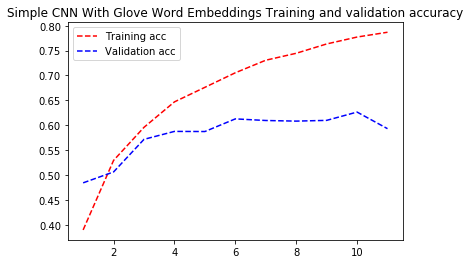

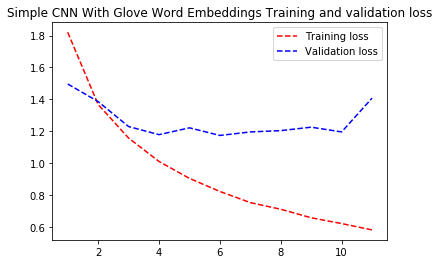

In [209]:
if(train_simplecnn):
    plothistory( _simple_cnn, 'Simple CNN With Glove Word Embeddings')

In [210]:
evaluate_model('saved_models/weights.best.simplecnn_glovevectors.hdf5', x_val, y_val)

saved_models/weights.best.simplecnn_glovevectors.hdf5
acc: 61.28%
loss: 1.17%


In [ ]:
#### Exploring the impact of kernel size

In [211]:
#build_cnn_with_glove_vectors(num_filters, kernel_size, pooling_num, dense_size, num_classes, dropout_level)
kernel10_cnn_model = build_cnn_with_glove_vectors(32, 10, 2, 24, num_classes, 0.25)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 100)         852900    
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 991, 32)           32032     
_________________________________________________________________
dropout_10 (Dropout)         (None, 991, 32)           0         
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 495, 32)           0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 486, 16)           5136      
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 243, 16)           0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 234, 8)            1288      
__________

In [212]:
callbacks = setup_callbacks('saved_models/weights.best.cnnkernel10_glovevectors.hdf5', 5)

In [213]:
 _kernel10_cnn = train_model(kernel10_cnn_model, x_train, y_train, x_val, y_val, callbacks, 50, batch_size)

Train on 16064 samples, validate on 4016 samples
Epoch 1/50


 3248/16064 [=====>........................] - ETA: 4:51 - loss: 2.3725 - acc: 0.062 - ETA: 3:30 - loss: 2.4605 - acc: 0.062 - ETA: 3:06 - loss: 2.4635 - acc: 0.125 - ETA: 2:51 - loss: 2.4163 - acc: 0.156 - ETA: 2:45 - loss: 2.4334 - acc: 0.175 - ETA: 2:40 - loss: 2.4002 - acc: 0.177 - ETA: 2:36 - loss: 2.4310 - acc: 0.151 - ETA: 2:32 - loss: 2.4134 - acc: 0.148 - ETA: 2:30 - loss: 2.4205 - acc: 0.145 - ETA: 2:29 - loss: 2.4401 - acc: 0.137 - ETA: 2:28 - loss: 2.4418 - acc: 0.142 - ETA: 2:27 - loss: 2.4538 - acc: 0.140 - ETA: 2:25 - loss: 2.4693 - acc: 0.134 - ETA: 2:24 - loss: 2.4703 - acc: 0.129 - ETA: 2:23 - loss: 2.4703 - acc: 0.125 - ETA: 2:23 - loss: 2.4708 - acc: 0.125 - ETA: 2:21 - loss: 2.4620 - acc: 0.139 - ETA: 2:21 - loss: 2.4559 - acc: 0.152 - ETA: 2:21 - loss: 2.4496 - acc: 0.164 - ETA: 2:20 - loss: 2.4542 - acc: 0.162 - ETA: 2:20 - loss: 2.4598 - acc: 0.157 - ETA: 2:19 - loss: 2.4606 - acc: 0.159 - ETA: 2:19 - loss: 2.4590 - acc: 0.157 - ETA: 2:18 - loss: 2.4579 - acc: 0

 9808/16064 [=================>............] - ETA: 1:20 - loss: 2.0122 - acc: 0.322 - ETA: 1:20 - loss: 2.0108 - acc: 0.323 - ETA: 1:20 - loss: 2.0097 - acc: 0.323 - ETA: 1:20 - loss: 2.0098 - acc: 0.323 - ETA: 1:20 - loss: 2.0107 - acc: 0.323 - ETA: 1:20 - loss: 2.0111 - acc: 0.323 - ETA: 1:20 - loss: 2.0111 - acc: 0.323 - ETA: 1:19 - loss: 2.0101 - acc: 0.324 - ETA: 1:19 - loss: 2.0087 - acc: 0.324 - ETA: 1:19 - loss: 2.0086 - acc: 0.324 - ETA: 1:19 - loss: 2.0093 - acc: 0.324 - ETA: 1:19 - loss: 2.0088 - acc: 0.325 - ETA: 1:19 - loss: 2.0092 - acc: 0.325 - ETA: 1:19 - loss: 2.0090 - acc: 0.324 - ETA: 1:18 - loss: 2.0092 - acc: 0.324 - ETA: 1:18 - loss: 2.0088 - acc: 0.324 - ETA: 1:18 - loss: 2.0091 - acc: 0.324 - ETA: 1:18 - loss: 2.0084 - acc: 0.324 - ETA: 1:18 - loss: 2.0091 - acc: 0.324 - ETA: 1:18 - loss: 2.0094 - acc: 0.324 - ETA: 1:18 - loss: 2.0097 - acc: 0.323 - ETA: 1:18 - loss: 2.0094 - acc: 0.323 - ETA: 1:18 - loss: 2.0091 - acc: 0.323 - ETA: 1:17 - loss: 2.0088 - acc: 0

13248/16064 [=======================>......] - ETA: 53s - loss: 1.8904 - acc: 0.36 - ETA: 53s - loss: 1.8898 - acc: 0.36 - ETA: 53s - loss: 1.8898 - acc: 0.36 - ETA: 53s - loss: 1.8889 - acc: 0.36 - ETA: 52s - loss: 1.8885 - acc: 0.36 - ETA: 52s - loss: 1.8880 - acc: 0.36 - ETA: 52s - loss: 1.8879 - acc: 0.36 - ETA: 52s - loss: 1.8876 - acc: 0.36 - ETA: 52s - loss: 1.8867 - acc: 0.36 - ETA: 52s - loss: 1.8868 - acc: 0.36 - ETA: 52s - loss: 1.8870 - acc: 0.36 - ETA: 51s - loss: 1.8871 - acc: 0.36 - ETA: 51s - loss: 1.8867 - acc: 0.36 - ETA: 51s - loss: 1.8858 - acc: 0.36 - ETA: 51s - loss: 1.8849 - acc: 0.36 - ETA: 51s - loss: 1.8848 - acc: 0.36 - ETA: 51s - loss: 1.8841 - acc: 0.36 - ETA: 51s - loss: 1.8839 - acc: 0.36 - ETA: 51s - loss: 1.8831 - acc: 0.36 - ETA: 50s - loss: 1.8833 - acc: 0.36 - ETA: 50s - loss: 1.8835 - acc: 0.36 - ETA: 50s - loss: 1.8834 - acc: 0.36 - ETA: 50s - loss: 1.8824 - acc: 0.36 - ETA: 50s - loss: 1.8822 - acc: 0.36 - ETA: 50s - loss: 1.8821 - acc: 0.36 - ETA

16064/16064 [==============================] - ETA: 25s - loss: 1.8141 - acc: 0.38 - ETA: 24s - loss: 1.8134 - acc: 0.38 - ETA: 24s - loss: 1.8131 - acc: 0.38 - ETA: 24s - loss: 1.8126 - acc: 0.38 - ETA: 24s - loss: 1.8121 - acc: 0.38 - ETA: 24s - loss: 1.8116 - acc: 0.38 - ETA: 24s - loss: 1.8112 - acc: 0.38 - ETA: 24s - loss: 1.8108 - acc: 0.38 - ETA: 23s - loss: 1.8108 - acc: 0.38 - ETA: 23s - loss: 1.8102 - acc: 0.38 - ETA: 23s - loss: 1.8096 - acc: 0.38 - ETA: 23s - loss: 1.8095 - acc: 0.38 - ETA: 23s - loss: 1.8094 - acc: 0.38 - ETA: 23s - loss: 1.8093 - acc: 0.38 - ETA: 23s - loss: 1.8089 - acc: 0.38 - ETA: 22s - loss: 1.8082 - acc: 0.38 - ETA: 22s - loss: 1.8077 - acc: 0.38 - ETA: 22s - loss: 1.8077 - acc: 0.38 - ETA: 22s - loss: 1.8073 - acc: 0.38 - ETA: 22s - loss: 1.8067 - acc: 0.38 - ETA: 22s - loss: 1.8073 - acc: 0.38 - ETA: 22s - loss: 1.8074 - acc: 0.38 - ETA: 22s - loss: 1.8074 - acc: 0.38 - ETA: 21s - loss: 1.8072 - acc: 0.38 - ETA: 21s - loss: 1.8070 - acc: 0.38 - ETA

 3264/16064 [=====>........................] - ETA: 2:39 - loss: 1.4744 - acc: 0.500 - ETA: 2:35 - loss: 1.8778 - acc: 0.406 - ETA: 2:32 - loss: 1.7143 - acc: 0.458 - ETA: 2:28 - loss: 1.5624 - acc: 0.484 - ETA: 2:24 - loss: 1.5506 - acc: 0.487 - ETA: 2:19 - loss: 1.4929 - acc: 0.500 - ETA: 2:20 - loss: 1.4818 - acc: 0.500 - ETA: 2:20 - loss: 1.5047 - acc: 0.484 - ETA: 2:19 - loss: 1.5168 - acc: 0.479 - ETA: 2:19 - loss: 1.5074 - acc: 0.481 - ETA: 2:19 - loss: 1.4498 - acc: 0.522 - ETA: 2:19 - loss: 1.4094 - acc: 0.536 - ETA: 2:19 - loss: 1.4146 - acc: 0.538 - ETA: 2:19 - loss: 1.4049 - acc: 0.535 - ETA: 2:18 - loss: 1.4419 - acc: 0.529 - ETA: 2:18 - loss: 1.4651 - acc: 0.511 - ETA: 2:18 - loss: 1.4352 - acc: 0.525 - ETA: 2:20 - loss: 1.4599 - acc: 0.517 - ETA: 2:19 - loss: 1.4598 - acc: 0.513 - ETA: 2:19 - loss: 1.4577 - acc: 0.509 - ETA: 2:20 - loss: 1.4735 - acc: 0.503 - ETA: 2:20 - loss: 1.4702 - acc: 0.511 - ETA: 2:19 - loss: 1.4707 - acc: 0.502 - ETA: 2:19 - loss: 1.4860 - acc: 0

 9808/16064 [=================>............] - ETA: 1:26 - loss: 1.4160 - acc: 0.514 - ETA: 1:26 - loss: 1.4158 - acc: 0.514 - ETA: 1:26 - loss: 1.4169 - acc: 0.514 - ETA: 1:26 - loss: 1.4174 - acc: 0.514 - ETA: 1:26 - loss: 1.4159 - acc: 0.515 - ETA: 1:26 - loss: 1.4153 - acc: 0.515 - ETA: 1:25 - loss: 1.4156 - acc: 0.515 - ETA: 1:25 - loss: 1.4157 - acc: 0.515 - ETA: 1:25 - loss: 1.4163 - acc: 0.515 - ETA: 1:25 - loss: 1.4160 - acc: 0.515 - ETA: 1:25 - loss: 1.4163 - acc: 0.515 - ETA: 1:25 - loss: 1.4156 - acc: 0.515 - ETA: 1:25 - loss: 1.4160 - acc: 0.515 - ETA: 1:24 - loss: 1.4160 - acc: 0.515 - ETA: 1:24 - loss: 1.4145 - acc: 0.516 - ETA: 1:24 - loss: 1.4140 - acc: 0.516 - ETA: 1:24 - loss: 1.4142 - acc: 0.516 - ETA: 1:24 - loss: 1.4127 - acc: 0.516 - ETA: 1:24 - loss: 1.4132 - acc: 0.516 - ETA: 1:23 - loss: 1.4128 - acc: 0.516 - ETA: 1:23 - loss: 1.4130 - acc: 0.516 - ETA: 1:23 - loss: 1.4124 - acc: 0.517 - ETA: 1:23 - loss: 1.4126 - acc: 0.517 - ETA: 1:23 - loss: 1.4121 - acc: 0

13248/16064 [=======================>......] - ETA: 56s - loss: 1.4093 - acc: 0.51 - ETA: 56s - loss: 1.4099 - acc: 0.51 - ETA: 56s - loss: 1.4098 - acc: 0.51 - ETA: 55s - loss: 1.4102 - acc: 0.51 - ETA: 55s - loss: 1.4092 - acc: 0.51 - ETA: 55s - loss: 1.4095 - acc: 0.51 - ETA: 55s - loss: 1.4092 - acc: 0.51 - ETA: 55s - loss: 1.4099 - acc: 0.51 - ETA: 55s - loss: 1.4095 - acc: 0.51 - ETA: 55s - loss: 1.4096 - acc: 0.51 - ETA: 54s - loss: 1.4099 - acc: 0.51 - ETA: 54s - loss: 1.4096 - acc: 0.51 - ETA: 54s - loss: 1.4097 - acc: 0.51 - ETA: 54s - loss: 1.4090 - acc: 0.51 - ETA: 54s - loss: 1.4087 - acc: 0.51 - ETA: 54s - loss: 1.4084 - acc: 0.51 - ETA: 54s - loss: 1.4078 - acc: 0.51 - ETA: 53s - loss: 1.4080 - acc: 0.51 - ETA: 53s - loss: 1.4076 - acc: 0.51 - ETA: 53s - loss: 1.4067 - acc: 0.51 - ETA: 53s - loss: 1.4062 - acc: 0.51 - ETA: 53s - loss: 1.4057 - acc: 0.51 - ETA: 53s - loss: 1.4062 - acc: 0.51 - ETA: 53s - loss: 1.4062 - acc: 0.51 - ETA: 52s - loss: 1.4060 - acc: 0.51 - ETA

16064/16064 [==============================] - ETA: 25s - loss: 1.3966 - acc: 0.51 - ETA: 25s - loss: 1.3969 - acc: 0.52 - ETA: 24s - loss: 1.3967 - acc: 0.52 - ETA: 24s - loss: 1.3970 - acc: 0.52 - ETA: 24s - loss: 1.3969 - acc: 0.52 - ETA: 24s - loss: 1.3970 - acc: 0.52 - ETA: 24s - loss: 1.3969 - acc: 0.51 - ETA: 24s - loss: 1.3968 - acc: 0.52 - ETA: 24s - loss: 1.3971 - acc: 0.51 - ETA: 23s - loss: 1.3965 - acc: 0.52 - ETA: 23s - loss: 1.3966 - acc: 0.52 - ETA: 23s - loss: 1.3963 - acc: 0.52 - ETA: 23s - loss: 1.3962 - acc: 0.52 - ETA: 23s - loss: 1.3960 - acc: 0.52 - ETA: 23s - loss: 1.3966 - acc: 0.52 - ETA: 23s - loss: 1.3964 - acc: 0.52 - ETA: 22s - loss: 1.3960 - acc: 0.52 - ETA: 22s - loss: 1.3954 - acc: 0.52 - ETA: 22s - loss: 1.3958 - acc: 0.52 - ETA: 22s - loss: 1.3963 - acc: 0.52 - ETA: 22s - loss: 1.3966 - acc: 0.52 - ETA: 22s - loss: 1.3960 - acc: 0.52 - ETA: 22s - loss: 1.3961 - acc: 0.52 - ETA: 21s - loss: 1.3964 - acc: 0.52 - ETA: 21s - loss: 1.3960 - acc: 0.52 - ETA

 3264/16064 [=====>........................] - ETA: 2:03 - loss: 1.5583 - acc: 0.375 - ETA: 2:10 - loss: 1.3751 - acc: 0.468 - ETA: 2:13 - loss: 1.3471 - acc: 0.479 - ETA: 2:11 - loss: 1.4016 - acc: 0.468 - ETA: 2:14 - loss: 1.4142 - acc: 0.475 - ETA: 2:12 - loss: 1.4637 - acc: 0.447 - ETA: 2:14 - loss: 1.4753 - acc: 0.455 - ETA: 2:12 - loss: 1.5100 - acc: 0.429 - ETA: 2:13 - loss: 1.5233 - acc: 0.423 - ETA: 2:13 - loss: 1.5266 - acc: 0.431 - ETA: 2:13 - loss: 1.5295 - acc: 0.431 - ETA: 2:12 - loss: 1.4849 - acc: 0.453 - ETA: 2:13 - loss: 1.4671 - acc: 0.461 - ETA: 2:15 - loss: 1.4497 - acc: 0.473 - ETA: 2:14 - loss: 1.4380 - acc: 0.475 - ETA: 2:15 - loss: 1.4046 - acc: 0.500 - ETA: 2:14 - loss: 1.4003 - acc: 0.511 - ETA: 2:14 - loss: 1.4009 - acc: 0.517 - ETA: 2:13 - loss: 1.3876 - acc: 0.526 - ETA: 2:13 - loss: 1.3984 - acc: 0.525 - ETA: 2:14 - loss: 1.3714 - acc: 0.532 - ETA: 2:13 - loss: 1.3698 - acc: 0.536 - ETA: 2:13 - loss: 1.3548 - acc: 0.540 - ETA: 2:13 - loss: 1.3598 - acc: 0

 9792/16064 [=================>............] - ETA: 1:32 - loss: 1.2700 - acc: 0.558 - ETA: 1:32 - loss: 1.2702 - acc: 0.558 - ETA: 1:32 - loss: 1.2700 - acc: 0.558 - ETA: 1:32 - loss: 1.2691 - acc: 0.558 - ETA: 1:32 - loss: 1.2690 - acc: 0.558 - ETA: 1:31 - loss: 1.2690 - acc: 0.558 - ETA: 1:31 - loss: 1.2684 - acc: 0.558 - ETA: 1:31 - loss: 1.2690 - acc: 0.558 - ETA: 1:31 - loss: 1.2687 - acc: 0.558 - ETA: 1:31 - loss: 1.2681 - acc: 0.558 - ETA: 1:30 - loss: 1.2677 - acc: 0.558 - ETA: 1:30 - loss: 1.2682 - acc: 0.558 - ETA: 1:30 - loss: 1.2680 - acc: 0.558 - ETA: 1:30 - loss: 1.2673 - acc: 0.558 - ETA: 1:30 - loss: 1.2675 - acc: 0.558 - ETA: 1:30 - loss: 1.2669 - acc: 0.558 - ETA: 1:29 - loss: 1.2667 - acc: 0.558 - ETA: 1:29 - loss: 1.2655 - acc: 0.558 - ETA: 1:29 - loss: 1.2652 - acc: 0.558 - ETA: 1:29 - loss: 1.2658 - acc: 0.559 - ETA: 1:29 - loss: 1.2654 - acc: 0.559 - ETA: 1:28 - loss: 1.2666 - acc: 0.558 - ETA: 1:28 - loss: 1.2660 - acc: 0.558 - ETA: 1:28 - loss: 1.2655 - acc: 0

13232/16064 [=======================>......] - ETA: 59s - loss: 1.2615 - acc: 0.563 - ETA: 59s - loss: 1.2612 - acc: 0.56 - ETA: 59s - loss: 1.2610 - acc: 0.56 - ETA: 59s - loss: 1.2610 - acc: 0.56 - ETA: 59s - loss: 1.2613 - acc: 0.56 - ETA: 59s - loss: 1.2608 - acc: 0.56 - ETA: 58s - loss: 1.2608 - acc: 0.56 - ETA: 58s - loss: 1.2604 - acc: 0.56 - ETA: 58s - loss: 1.2603 - acc: 0.56 - ETA: 58s - loss: 1.2601 - acc: 0.56 - ETA: 58s - loss: 1.2605 - acc: 0.56 - ETA: 58s - loss: 1.2604 - acc: 0.56 - ETA: 58s - loss: 1.2605 - acc: 0.56 - ETA: 57s - loss: 1.2610 - acc: 0.56 - ETA: 57s - loss: 1.2621 - acc: 0.56 - ETA: 57s - loss: 1.2618 - acc: 0.56 - ETA: 57s - loss: 1.2619 - acc: 0.56 - ETA: 57s - loss: 1.2617 - acc: 0.56 - ETA: 57s - loss: 1.2620 - acc: 0.56 - ETA: 56s - loss: 1.2626 - acc: 0.56 - ETA: 56s - loss: 1.2629 - acc: 0.56 - ETA: 56s - loss: 1.2627 - acc: 0.56 - ETA: 56s - loss: 1.2630 - acc: 0.56 - ETA: 56s - loss: 1.2625 - acc: 0.56 - ETA: 56s - loss: 1.2622 - acc: 0.56 - ET

16064/16064 [==============================] - ETA: 27s - loss: 1.2602 - acc: 0.56 - ETA: 26s - loss: 1.2604 - acc: 0.56 - ETA: 26s - loss: 1.2605 - acc: 0.56 - ETA: 26s - loss: 1.2609 - acc: 0.56 - ETA: 26s - loss: 1.2609 - acc: 0.56 - ETA: 26s - loss: 1.2607 - acc: 0.56 - ETA: 26s - loss: 1.2611 - acc: 0.56 - ETA: 26s - loss: 1.2613 - acc: 0.56 - ETA: 25s - loss: 1.2610 - acc: 0.56 - ETA: 25s - loss: 1.2610 - acc: 0.56 - ETA: 25s - loss: 1.2613 - acc: 0.56 - ETA: 25s - loss: 1.2608 - acc: 0.56 - ETA: 25s - loss: 1.2609 - acc: 0.56 - ETA: 25s - loss: 1.2608 - acc: 0.56 - ETA: 24s - loss: 1.2609 - acc: 0.56 - ETA: 24s - loss: 1.2615 - acc: 0.56 - ETA: 24s - loss: 1.2616 - acc: 0.56 - ETA: 24s - loss: 1.2621 - acc: 0.56 - ETA: 24s - loss: 1.2620 - acc: 0.56 - ETA: 24s - loss: 1.2616 - acc: 0.56 - ETA: 24s - loss: 1.2609 - acc: 0.56 - ETA: 23s - loss: 1.2607 - acc: 0.56 - ETA: 23s - loss: 1.2602 - acc: 0.56 - ETA: 23s - loss: 1.2605 - acc: 0.56 - ETA: 23s - loss: 1.2603 - acc: 0.56 - ETA

 3264/16064 [=====>........................] - ETA: 2:34 - loss: 1.3620 - acc: 0.437 - ETA: 2:28 - loss: 1.3600 - acc: 0.500 - ETA: 2:27 - loss: 1.2106 - acc: 0.583 - ETA: 2:26 - loss: 1.1155 - acc: 0.609 - ETA: 2:30 - loss: 1.2319 - acc: 0.587 - ETA: 2:28 - loss: 1.2136 - acc: 0.593 - ETA: 2:29 - loss: 1.2088 - acc: 0.607 - ETA: 2:29 - loss: 1.1967 - acc: 0.609 - ETA: 2:30 - loss: 1.2479 - acc: 0.618 - ETA: 2:30 - loss: 1.1960 - acc: 0.631 - ETA: 2:29 - loss: 1.2013 - acc: 0.625 - ETA: 2:28 - loss: 1.1971 - acc: 0.640 - ETA: 2:28 - loss: 1.1845 - acc: 0.644 - ETA: 2:28 - loss: 1.2042 - acc: 0.638 - ETA: 2:29 - loss: 1.1732 - acc: 0.641 - ETA: 2:28 - loss: 1.1430 - acc: 0.656 - ETA: 2:28 - loss: 1.1502 - acc: 0.647 - ETA: 2:28 - loss: 1.1439 - acc: 0.649 - ETA: 2:28 - loss: 1.1414 - acc: 0.648 - ETA: 2:28 - loss: 1.1432 - acc: 0.640 - ETA: 2:28 - loss: 1.1602 - acc: 0.633 - ETA: 2:28 - loss: 1.1571 - acc: 0.627 - ETA: 2:27 - loss: 1.1978 - acc: 0.616 - ETA: 2:27 - loss: 1.1996 - acc: 0

 9792/16064 [=================>............] - ETA: 1:30 - loss: 1.1974 - acc: 0.588 - ETA: 1:30 - loss: 1.1972 - acc: 0.588 - ETA: 1:30 - loss: 1.1978 - acc: 0.588 - ETA: 1:30 - loss: 1.1978 - acc: 0.588 - ETA: 1:30 - loss: 1.1974 - acc: 0.589 - ETA: 1:29 - loss: 1.1975 - acc: 0.588 - ETA: 1:29 - loss: 1.1977 - acc: 0.588 - ETA: 1:29 - loss: 1.1984 - acc: 0.588 - ETA: 1:29 - loss: 1.1987 - acc: 0.588 - ETA: 1:29 - loss: 1.2009 - acc: 0.587 - ETA: 1:29 - loss: 1.2004 - acc: 0.588 - ETA: 1:28 - loss: 1.2006 - acc: 0.587 - ETA: 1:28 - loss: 1.2003 - acc: 0.587 - ETA: 1:28 - loss: 1.2000 - acc: 0.587 - ETA: 1:28 - loss: 1.1999 - acc: 0.587 - ETA: 1:28 - loss: 1.2002 - acc: 0.587 - ETA: 1:28 - loss: 1.1990 - acc: 0.587 - ETA: 1:28 - loss: 1.1985 - acc: 0.588 - ETA: 1:27 - loss: 1.1975 - acc: 0.588 - ETA: 1:27 - loss: 1.1971 - acc: 0.589 - ETA: 1:27 - loss: 1.1965 - acc: 0.589 - ETA: 1:27 - loss: 1.1978 - acc: 0.589 - ETA: 1:27 - loss: 1.1975 - acc: 0.588 - ETA: 1:27 - loss: 1.1972 - acc: 0

13232/16064 [=======================>......] - ETA: 59s - loss: 1.1784 - acc: 0.589 - ETA: 59s - loss: 1.1781 - acc: 0.59 - ETA: 59s - loss: 1.1783 - acc: 0.58 - ETA: 59s - loss: 1.1782 - acc: 0.59 - ETA: 59s - loss: 1.1780 - acc: 0.59 - ETA: 59s - loss: 1.1782 - acc: 0.58 - ETA: 58s - loss: 1.1778 - acc: 0.58 - ETA: 58s - loss: 1.1775 - acc: 0.58 - ETA: 58s - loss: 1.1779 - acc: 0.58 - ETA: 58s - loss: 1.1781 - acc: 0.58 - ETA: 58s - loss: 1.1783 - acc: 0.58 - ETA: 58s - loss: 1.1781 - acc: 0.58 - ETA: 57s - loss: 1.1787 - acc: 0.58 - ETA: 57s - loss: 1.1787 - acc: 0.58 - ETA: 57s - loss: 1.1788 - acc: 0.58 - ETA: 57s - loss: 1.1793 - acc: 0.58 - ETA: 57s - loss: 1.1794 - acc: 0.58 - ETA: 57s - loss: 1.1786 - acc: 0.58 - ETA: 57s - loss: 1.1786 - acc: 0.58 - ETA: 56s - loss: 1.1784 - acc: 0.58 - ETA: 56s - loss: 1.1783 - acc: 0.58 - ETA: 56s - loss: 1.1780 - acc: 0.58 - ETA: 56s - loss: 1.1771 - acc: 0.58 - ETA: 56s - loss: 1.1765 - acc: 0.58 - ETA: 56s - loss: 1.1763 - acc: 0.58 - ET

16064/16064 [==============================] - ETA: 26s - loss: 1.1788 - acc: 0.58 - ETA: 26s - loss: 1.1783 - acc: 0.59 - ETA: 25s - loss: 1.1782 - acc: 0.59 - ETA: 25s - loss: 1.1780 - acc: 0.59 - ETA: 25s - loss: 1.1778 - acc: 0.59 - ETA: 25s - loss: 1.1777 - acc: 0.59 - ETA: 25s - loss: 1.1774 - acc: 0.59 - ETA: 25s - loss: 1.1775 - acc: 0.59 - ETA: 25s - loss: 1.1772 - acc: 0.59 - ETA: 24s - loss: 1.1768 - acc: 0.59 - ETA: 24s - loss: 1.1759 - acc: 0.59 - ETA: 24s - loss: 1.1757 - acc: 0.59 - ETA: 24s - loss: 1.1761 - acc: 0.59 - ETA: 24s - loss: 1.1762 - acc: 0.59 - ETA: 24s - loss: 1.1763 - acc: 0.59 - ETA: 23s - loss: 1.1757 - acc: 0.59 - ETA: 23s - loss: 1.1757 - acc: 0.59 - ETA: 23s - loss: 1.1753 - acc: 0.59 - ETA: 23s - loss: 1.1749 - acc: 0.59 - ETA: 23s - loss: 1.1759 - acc: 0.59 - ETA: 23s - loss: 1.1762 - acc: 0.59 - ETA: 23s - loss: 1.1752 - acc: 0.59 - ETA: 22s - loss: 1.1750 - acc: 0.59 - ETA: 22s - loss: 1.1753 - acc: 0.59 - ETA: 22s - loss: 1.1753 - acc: 0.59 - ETA

 3264/16064 [=====>........................] - ETA: 2:05 - loss: 0.7664 - acc: 0.812 - ETA: 2:13 - loss: 0.9814 - acc: 0.718 - ETA: 2:12 - loss: 1.0379 - acc: 0.687 - ETA: 2:12 - loss: 0.9767 - acc: 0.671 - ETA: 2:12 - loss: 1.0733 - acc: 0.637 - ETA: 2:11 - loss: 1.1208 - acc: 0.614 - ETA: 2:12 - loss: 1.1782 - acc: 0.616 - ETA: 2:13 - loss: 1.2007 - acc: 0.609 - ETA: 2:13 - loss: 1.1337 - acc: 0.631 - ETA: 2:14 - loss: 1.1109 - acc: 0.637 - ETA: 2:14 - loss: 1.0924 - acc: 0.636 - ETA: 2:13 - loss: 1.0743 - acc: 0.640 - ETA: 2:13 - loss: 1.0366 - acc: 0.653 - ETA: 2:13 - loss: 1.0369 - acc: 0.651 - ETA: 2:13 - loss: 1.0188 - acc: 0.654 - ETA: 2:13 - loss: 1.0090 - acc: 0.652 - ETA: 2:12 - loss: 1.0129 - acc: 0.650 - ETA: 2:13 - loss: 0.9965 - acc: 0.652 - ETA: 2:12 - loss: 1.0045 - acc: 0.648 - ETA: 2:12 - loss: 1.0081 - acc: 0.643 - ETA: 2:11 - loss: 1.0189 - acc: 0.636 - ETA: 2:11 - loss: 1.0121 - acc: 0.639 - ETA: 2:12 - loss: 1.0095 - acc: 0.644 - ETA: 2:12 - loss: 1.0344 - acc: 0

 9824/16064 [=================>............] - ETA: 1:20 - loss: 1.1161 - acc: 0.614 - ETA: 1:20 - loss: 1.1160 - acc: 0.615 - ETA: 1:20 - loss: 1.1159 - acc: 0.615 - ETA: 1:20 - loss: 1.1161 - acc: 0.614 - ETA: 1:20 - loss: 1.1156 - acc: 0.614 - ETA: 1:20 - loss: 1.1148 - acc: 0.614 - ETA: 1:19 - loss: 1.1147 - acc: 0.614 - ETA: 1:19 - loss: 1.1154 - acc: 0.614 - ETA: 1:19 - loss: 1.1163 - acc: 0.614 - ETA: 1:19 - loss: 1.1164 - acc: 0.614 - ETA: 1:19 - loss: 1.1156 - acc: 0.614 - ETA: 1:19 - loss: 1.1164 - acc: 0.614 - ETA: 1:19 - loss: 1.1162 - acc: 0.614 - ETA: 1:18 - loss: 1.1162 - acc: 0.614 - ETA: 1:18 - loss: 1.1157 - acc: 0.614 - ETA: 1:18 - loss: 1.1153 - acc: 0.614 - ETA: 1:18 - loss: 1.1155 - acc: 0.614 - ETA: 1:18 - loss: 1.1154 - acc: 0.613 - ETA: 1:18 - loss: 1.1161 - acc: 0.613 - ETA: 1:18 - loss: 1.1163 - acc: 0.613 - ETA: 1:18 - loss: 1.1171 - acc: 0.612 - ETA: 1:17 - loss: 1.1177 - acc: 0.612 - ETA: 1:17 - loss: 1.1172 - acc: 0.613 - ETA: 1:17 - loss: 1.1167 - acc: 0

13264/16064 [=======================>......] - ETA: 55s - loss: 1.1039 - acc: 0.61 - ETA: 55s - loss: 1.1040 - acc: 0.61 - ETA: 55s - loss: 1.1038 - acc: 0.61 - ETA: 54s - loss: 1.1043 - acc: 0.61 - ETA: 54s - loss: 1.1046 - acc: 0.61 - ETA: 54s - loss: 1.1047 - acc: 0.61 - ETA: 54s - loss: 1.1044 - acc: 0.61 - ETA: 54s - loss: 1.1046 - acc: 0.61 - ETA: 54s - loss: 1.1041 - acc: 0.61 - ETA: 54s - loss: 1.1040 - acc: 0.61 - ETA: 53s - loss: 1.1045 - acc: 0.61 - ETA: 53s - loss: 1.1050 - acc: 0.61 - ETA: 53s - loss: 1.1060 - acc: 0.61 - ETA: 53s - loss: 1.1058 - acc: 0.61 - ETA: 53s - loss: 1.1063 - acc: 0.61 - ETA: 53s - loss: 1.1060 - acc: 0.61 - ETA: 53s - loss: 1.1058 - acc: 0.61 - ETA: 53s - loss: 1.1064 - acc: 0.61 - ETA: 52s - loss: 1.1062 - acc: 0.61 - ETA: 52s - loss: 1.1061 - acc: 0.61 - ETA: 52s - loss: 1.1064 - acc: 0.61 - ETA: 52s - loss: 1.1063 - acc: 0.61 - ETA: 52s - loss: 1.1064 - acc: 0.61 - ETA: 52s - loss: 1.1068 - acc: 0.61 - ETA: 52s - loss: 1.1064 - acc: 0.61 - ETA

16064/16064 [==============================] - ETA: 25s - loss: 1.1051 - acc: 0.61 - ETA: 25s - loss: 1.1049 - acc: 0.61 - ETA: 24s - loss: 1.1053 - acc: 0.61 - ETA: 24s - loss: 1.1055 - acc: 0.61 - ETA: 24s - loss: 1.1050 - acc: 0.61 - ETA: 24s - loss: 1.1054 - acc: 0.61 - ETA: 24s - loss: 1.1051 - acc: 0.61 - ETA: 24s - loss: 1.1047 - acc: 0.61 - ETA: 24s - loss: 1.1050 - acc: 0.61 - ETA: 23s - loss: 1.1047 - acc: 0.61 - ETA: 23s - loss: 1.1054 - acc: 0.61 - ETA: 23s - loss: 1.1048 - acc: 0.61 - ETA: 23s - loss: 1.1049 - acc: 0.61 - ETA: 23s - loss: 1.1052 - acc: 0.61 - ETA: 23s - loss: 1.1050 - acc: 0.61 - ETA: 23s - loss: 1.1050 - acc: 0.61 - ETA: 22s - loss: 1.1046 - acc: 0.61 - ETA: 22s - loss: 1.1042 - acc: 0.61 - ETA: 22s - loss: 1.1044 - acc: 0.61 - ETA: 22s - loss: 1.1041 - acc: 0.61 - ETA: 22s - loss: 1.1040 - acc: 0.61 - ETA: 22s - loss: 1.1036 - acc: 0.61 - ETA: 22s - loss: 1.1036 - acc: 0.61 - ETA: 21s - loss: 1.1037 - acc: 0.61 - ETA: 21s - loss: 1.1040 - acc: 0.61 - ETA

 3264/16064 [=====>........................] - ETA: 2:36 - loss: 0.7447 - acc: 0.750 - ETA: 2:27 - loss: 1.0216 - acc: 0.593 - ETA: 2:31 - loss: 0.9535 - acc: 0.666 - ETA: 2:32 - loss: 0.9334 - acc: 0.687 - ETA: 2:30 - loss: 0.9432 - acc: 0.675 - ETA: 2:30 - loss: 1.0319 - acc: 0.645 - ETA: 2:29 - loss: 0.9776 - acc: 0.660 - ETA: 2:29 - loss: 0.9475 - acc: 0.664 - ETA: 2:30 - loss: 0.9363 - acc: 0.666 - ETA: 2:30 - loss: 0.9409 - acc: 0.675 - ETA: 2:29 - loss: 0.9373 - acc: 0.664 - ETA: 2:30 - loss: 0.9609 - acc: 0.666 - ETA: 2:30 - loss: 0.9330 - acc: 0.682 - ETA: 2:29 - loss: 0.9484 - acc: 0.674 - ETA: 2:29 - loss: 0.9265 - acc: 0.683 - ETA: 2:29 - loss: 0.9352 - acc: 0.675 - ETA: 2:29 - loss: 0.9317 - acc: 0.687 - ETA: 2:29 - loss: 0.9269 - acc: 0.694 - ETA: 2:29 - loss: 0.9235 - acc: 0.694 - ETA: 2:29 - loss: 0.9471 - acc: 0.681 - ETA: 2:29 - loss: 0.9743 - acc: 0.669 - ETA: 2:28 - loss: 1.0098 - acc: 0.667 - ETA: 2:30 - loss: 1.0009 - acc: 0.671 - ETA: 2:29 - loss: 1.0030 - acc: 0

 9792/16064 [=================>............] - ETA: 1:31 - loss: 1.0275 - acc: 0.640 - ETA: 1:31 - loss: 1.0278 - acc: 0.641 - ETA: 1:31 - loss: 1.0271 - acc: 0.641 - ETA: 1:31 - loss: 1.0267 - acc: 0.641 - ETA: 1:31 - loss: 1.0280 - acc: 0.640 - ETA: 1:31 - loss: 1.0296 - acc: 0.640 - ETA: 1:30 - loss: 1.0293 - acc: 0.640 - ETA: 1:30 - loss: 1.0297 - acc: 0.640 - ETA: 1:30 - loss: 1.0297 - acc: 0.640 - ETA: 1:30 - loss: 1.0296 - acc: 0.640 - ETA: 1:30 - loss: 1.0291 - acc: 0.640 - ETA: 1:30 - loss: 1.0287 - acc: 0.640 - ETA: 1:29 - loss: 1.0284 - acc: 0.640 - ETA: 1:29 - loss: 1.0286 - acc: 0.640 - ETA: 1:29 - loss: 1.0287 - acc: 0.641 - ETA: 1:29 - loss: 1.0290 - acc: 0.641 - ETA: 1:29 - loss: 1.0295 - acc: 0.641 - ETA: 1:29 - loss: 1.0299 - acc: 0.640 - ETA: 1:28 - loss: 1.0297 - acc: 0.641 - ETA: 1:28 - loss: 1.0291 - acc: 0.641 - ETA: 1:28 - loss: 1.0305 - acc: 0.641 - ETA: 1:28 - loss: 1.0312 - acc: 0.640 - ETA: 1:28 - loss: 1.0318 - acc: 0.640 - ETA: 1:28 - loss: 1.0324 - acc: 0

13232/16064 [=======================>......] - ETA: 1:00 - loss: 1.0364 - acc: 0.640 - ETA: 59s - loss: 1.0365 - acc: 0.640 - ETA: 59s - loss: 1.0364 - acc: 0.64 - ETA: 59s - loss: 1.0363 - acc: 0.64 - ETA: 59s - loss: 1.0363 - acc: 0.64 - ETA: 59s - loss: 1.0363 - acc: 0.64 - ETA: 59s - loss: 1.0363 - acc: 0.64 - ETA: 58s - loss: 1.0356 - acc: 0.64 - ETA: 58s - loss: 1.0350 - acc: 0.64 - ETA: 58s - loss: 1.0343 - acc: 0.64 - ETA: 58s - loss: 1.0339 - acc: 0.64 - ETA: 58s - loss: 1.0334 - acc: 0.64 - ETA: 58s - loss: 1.0336 - acc: 0.64 - ETA: 58s - loss: 1.0342 - acc: 0.64 - ETA: 57s - loss: 1.0342 - acc: 0.64 - ETA: 57s - loss: 1.0347 - acc: 0.64 - ETA: 57s - loss: 1.0346 - acc: 0.64 - ETA: 57s - loss: 1.0341 - acc: 0.64 - ETA: 57s - loss: 1.0339 - acc: 0.64 - ETA: 57s - loss: 1.0340 - acc: 0.64 - ETA: 56s - loss: 1.0342 - acc: 0.64 - ETA: 56s - loss: 1.0341 - acc: 0.64 - ETA: 56s - loss: 1.0334 - acc: 0.64 - ETA: 56s - loss: 1.0330 - acc: 0.64 - ETA: 56s - loss: 1.0329 - acc: 0.64 - 

16064/16064 [==============================] - ETA: 26s - loss: 1.0351 - acc: 0.64 - ETA: 26s - loss: 1.0356 - acc: 0.64 - ETA: 26s - loss: 1.0355 - acc: 0.64 - ETA: 26s - loss: 1.0353 - acc: 0.64 - ETA: 26s - loss: 1.0352 - acc: 0.64 - ETA: 26s - loss: 1.0350 - acc: 0.64 - ETA: 26s - loss: 1.0350 - acc: 0.64 - ETA: 25s - loss: 1.0353 - acc: 0.64 - ETA: 25s - loss: 1.0356 - acc: 0.64 - ETA: 25s - loss: 1.0358 - acc: 0.64 - ETA: 25s - loss: 1.0358 - acc: 0.64 - ETA: 25s - loss: 1.0362 - acc: 0.64 - ETA: 25s - loss: 1.0358 - acc: 0.64 - ETA: 24s - loss: 1.0356 - acc: 0.64 - ETA: 24s - loss: 1.0361 - acc: 0.64 - ETA: 24s - loss: 1.0369 - acc: 0.64 - ETA: 24s - loss: 1.0374 - acc: 0.64 - ETA: 24s - loss: 1.0369 - acc: 0.64 - ETA: 24s - loss: 1.0365 - acc: 0.64 - ETA: 24s - loss: 1.0366 - acc: 0.64 - ETA: 23s - loss: 1.0367 - acc: 0.64 - ETA: 23s - loss: 1.0361 - acc: 0.64 - ETA: 23s - loss: 1.0357 - acc: 0.64 - ETA: 23s - loss: 1.0354 - acc: 0.64 - ETA: 23s - loss: 1.0351 - acc: 0.64 - ETA

 3264/16064 [=====>........................] - ETA: 2:26 - loss: 1.1196 - acc: 0.625 - ETA: 2:31 - loss: 1.2788 - acc: 0.531 - ETA: 2:34 - loss: 1.1148 - acc: 0.562 - ETA: 2:33 - loss: 1.1624 - acc: 0.562 - ETA: 2:34 - loss: 1.1128 - acc: 0.587 - ETA: 2:32 - loss: 1.1826 - acc: 0.562 - ETA: 2:30 - loss: 1.2091 - acc: 0.571 - ETA: 2:31 - loss: 1.1488 - acc: 0.593 - ETA: 2:33 - loss: 1.1421 - acc: 0.590 - ETA: 2:33 - loss: 1.1256 - acc: 0.600 - ETA: 2:33 - loss: 1.0883 - acc: 0.625 - ETA: 2:33 - loss: 1.0953 - acc: 0.619 - ETA: 2:33 - loss: 1.0852 - acc: 0.620 - ETA: 2:33 - loss: 1.0865 - acc: 0.616 - ETA: 2:33 - loss: 1.0567 - acc: 0.620 - ETA: 2:33 - loss: 1.0593 - acc: 0.625 - ETA: 2:33 - loss: 1.0411 - acc: 0.628 - ETA: 2:32 - loss: 1.0689 - acc: 0.618 - ETA: 2:32 - loss: 1.0655 - acc: 0.618 - ETA: 2:32 - loss: 1.0793 - acc: 0.609 - ETA: 2:31 - loss: 1.0527 - acc: 0.622 - ETA: 2:31 - loss: 1.0505 - acc: 0.622 - ETA: 2:31 - loss: 1.0645 - acc: 0.622 - ETA: 2:30 - loss: 1.0708 - acc: 0

 9792/16064 [=================>............] - ETA: 1:31 - loss: 0.9500 - acc: 0.666 - ETA: 1:31 - loss: 0.9502 - acc: 0.666 - ETA: 1:30 - loss: 0.9503 - acc: 0.666 - ETA: 1:30 - loss: 0.9513 - acc: 0.666 - ETA: 1:30 - loss: 0.9513 - acc: 0.666 - ETA: 1:30 - loss: 0.9502 - acc: 0.666 - ETA: 1:30 - loss: 0.9509 - acc: 0.666 - ETA: 1:30 - loss: 0.9512 - acc: 0.666 - ETA: 1:30 - loss: 0.9518 - acc: 0.666 - ETA: 1:29 - loss: 0.9516 - acc: 0.666 - ETA: 1:29 - loss: 0.9514 - acc: 0.666 - ETA: 1:29 - loss: 0.9507 - acc: 0.666 - ETA: 1:29 - loss: 0.9511 - acc: 0.666 - ETA: 1:29 - loss: 0.9505 - acc: 0.666 - ETA: 1:29 - loss: 0.9507 - acc: 0.666 - ETA: 1:28 - loss: 0.9502 - acc: 0.666 - ETA: 1:28 - loss: 0.9505 - acc: 0.666 - ETA: 1:28 - loss: 0.9510 - acc: 0.666 - ETA: 1:28 - loss: 0.9501 - acc: 0.666 - ETA: 1:28 - loss: 0.9496 - acc: 0.666 - ETA: 1:28 - loss: 0.9491 - acc: 0.666 - ETA: 1:27 - loss: 0.9501 - acc: 0.666 - ETA: 1:27 - loss: 0.9491 - acc: 0.667 - ETA: 1:27 - loss: 0.9479 - acc: 0

13232/16064 [=======================>......] - ETA: 59s - loss: 0.9668 - acc: 0.660 - ETA: 59s - loss: 0.9683 - acc: 0.65 - ETA: 59s - loss: 0.9691 - acc: 0.65 - ETA: 59s - loss: 0.9694 - acc: 0.65 - ETA: 59s - loss: 0.9697 - acc: 0.65 - ETA: 59s - loss: 0.9699 - acc: 0.65 - ETA: 58s - loss: 0.9692 - acc: 0.65 - ETA: 58s - loss: 0.9694 - acc: 0.65 - ETA: 58s - loss: 0.9689 - acc: 0.65 - ETA: 58s - loss: 0.9690 - acc: 0.65 - ETA: 58s - loss: 0.9684 - acc: 0.65 - ETA: 58s - loss: 0.9680 - acc: 0.66 - ETA: 58s - loss: 0.9683 - acc: 0.66 - ETA: 57s - loss: 0.9687 - acc: 0.65 - ETA: 57s - loss: 0.9684 - acc: 0.66 - ETA: 57s - loss: 0.9686 - acc: 0.65 - ETA: 57s - loss: 0.9687 - acc: 0.66 - ETA: 57s - loss: 0.9691 - acc: 0.65 - ETA: 57s - loss: 0.9691 - acc: 0.66 - ETA: 56s - loss: 0.9694 - acc: 0.65 - ETA: 56s - loss: 0.9697 - acc: 0.65 - ETA: 56s - loss: 0.9697 - acc: 0.65 - ETA: 56s - loss: 0.9700 - acc: 0.65 - ETA: 56s - loss: 0.9700 - acc: 0.65 - ETA: 56s - loss: 0.9707 - acc: 0.65 - ET

16064/16064 [==============================] - ETA: 26s - loss: 0.9647 - acc: 0.65 - ETA: 26s - loss: 0.9648 - acc: 0.65 - ETA: 26s - loss: 0.9652 - acc: 0.65 - ETA: 26s - loss: 0.9655 - acc: 0.65 - ETA: 26s - loss: 0.9653 - acc: 0.65 - ETA: 26s - loss: 0.9650 - acc: 0.65 - ETA: 25s - loss: 0.9644 - acc: 0.65 - ETA: 25s - loss: 0.9648 - acc: 0.65 - ETA: 25s - loss: 0.9655 - acc: 0.65 - ETA: 25s - loss: 0.9656 - acc: 0.65 - ETA: 25s - loss: 0.9657 - acc: 0.65 - ETA: 25s - loss: 0.9661 - acc: 0.65 - ETA: 25s - loss: 0.9665 - acc: 0.65 - ETA: 24s - loss: 0.9671 - acc: 0.65 - ETA: 24s - loss: 0.9673 - acc: 0.65 - ETA: 24s - loss: 0.9672 - acc: 0.65 - ETA: 24s - loss: 0.9671 - acc: 0.65 - ETA: 24s - loss: 0.9673 - acc: 0.65 - ETA: 24s - loss: 0.9678 - acc: 0.65 - ETA: 24s - loss: 0.9679 - acc: 0.65 - ETA: 23s - loss: 0.9679 - acc: 0.65 - ETA: 23s - loss: 0.9676 - acc: 0.65 - ETA: 23s - loss: 0.9682 - acc: 0.65 - ETA: 23s - loss: 0.9680 - acc: 0.65 - ETA: 23s - loss: 0.9677 - acc: 0.65 - ETA

 3264/16064 [=====>........................] - ETA: 2:38 - loss: 0.6951 - acc: 0.625 - ETA: 2:29 - loss: 0.7319 - acc: 0.718 - ETA: 2:32 - loss: 0.7415 - acc: 0.708 - ETA: 2:29 - loss: 0.8573 - acc: 0.656 - ETA: 2:30 - loss: 0.9200 - acc: 0.650 - ETA: 2:31 - loss: 0.9720 - acc: 0.635 - ETA: 2:30 - loss: 0.9234 - acc: 0.651 - ETA: 2:30 - loss: 0.9561 - acc: 0.656 - ETA: 2:32 - loss: 0.9522 - acc: 0.659 - ETA: 2:32 - loss: 0.9688 - acc: 0.662 - ETA: 2:31 - loss: 0.9839 - acc: 0.664 - ETA: 2:30 - loss: 1.0014 - acc: 0.666 - ETA: 2:30 - loss: 1.0395 - acc: 0.663 - ETA: 2:30 - loss: 1.0450 - acc: 0.656 - ETA: 2:30 - loss: 1.0273 - acc: 0.666 - ETA: 2:29 - loss: 1.0016 - acc: 0.671 - ETA: 2:29 - loss: 0.9916 - acc: 0.676 - ETA: 2:29 - loss: 1.0081 - acc: 0.666 - ETA: 2:29 - loss: 1.0059 - acc: 0.661 - ETA: 2:29 - loss: 0.9919 - acc: 0.665 - ETA: 2:29 - loss: 0.9794 - acc: 0.672 - ETA: 2:29 - loss: 0.9816 - acc: 0.673 - ETA: 2:30 - loss: 0.9699 - acc: 0.679 - ETA: 2:29 - loss: 0.9501 - acc: 0

 9792/16064 [=================>............] - ETA: 1:31 - loss: 0.9056 - acc: 0.685 - ETA: 1:30 - loss: 0.9047 - acc: 0.685 - ETA: 1:30 - loss: 0.9044 - acc: 0.685 - ETA: 1:30 - loss: 0.9034 - acc: 0.685 - ETA: 1:30 - loss: 0.9038 - acc: 0.685 - ETA: 1:30 - loss: 0.9024 - acc: 0.685 - ETA: 1:30 - loss: 0.9018 - acc: 0.686 - ETA: 1:30 - loss: 0.9018 - acc: 0.685 - ETA: 1:29 - loss: 0.9026 - acc: 0.685 - ETA: 1:29 - loss: 0.9032 - acc: 0.685 - ETA: 1:29 - loss: 0.9036 - acc: 0.685 - ETA: 1:29 - loss: 0.9035 - acc: 0.685 - ETA: 1:29 - loss: 0.9030 - acc: 0.685 - ETA: 1:29 - loss: 0.9031 - acc: 0.685 - ETA: 1:28 - loss: 0.9044 - acc: 0.685 - ETA: 1:28 - loss: 0.9049 - acc: 0.685 - ETA: 1:28 - loss: 0.9053 - acc: 0.685 - ETA: 1:28 - loss: 0.9062 - acc: 0.685 - ETA: 1:28 - loss: 0.9070 - acc: 0.684 - ETA: 1:28 - loss: 0.9067 - acc: 0.684 - ETA: 1:28 - loss: 0.9075 - acc: 0.684 - ETA: 1:27 - loss: 0.9075 - acc: 0.684 - ETA: 1:27 - loss: 0.9079 - acc: 0.684 - ETA: 1:27 - loss: 0.9082 - acc: 0

13232/16064 [=======================>......] - ETA: 59s - loss: 0.9094 - acc: 0.68 - ETA: 59s - loss: 0.9103 - acc: 0.68 - ETA: 59s - loss: 0.9104 - acc: 0.68 - ETA: 59s - loss: 0.9110 - acc: 0.68 - ETA: 59s - loss: 0.9117 - acc: 0.68 - ETA: 59s - loss: 0.9115 - acc: 0.68 - ETA: 58s - loss: 0.9110 - acc: 0.68 - ETA: 58s - loss: 0.9107 - acc: 0.68 - ETA: 58s - loss: 0.9109 - acc: 0.68 - ETA: 58s - loss: 0.9103 - acc: 0.68 - ETA: 58s - loss: 0.9107 - acc: 0.68 - ETA: 58s - loss: 0.9117 - acc: 0.68 - ETA: 57s - loss: 0.9110 - acc: 0.68 - ETA: 57s - loss: 0.9110 - acc: 0.68 - ETA: 57s - loss: 0.9116 - acc: 0.68 - ETA: 57s - loss: 0.9110 - acc: 0.68 - ETA: 57s - loss: 0.9111 - acc: 0.68 - ETA: 57s - loss: 0.9106 - acc: 0.68 - ETA: 57s - loss: 0.9109 - acc: 0.68 - ETA: 56s - loss: 0.9104 - acc: 0.68 - ETA: 56s - loss: 0.9099 - acc: 0.68 - ETA: 56s - loss: 0.9102 - acc: 0.68 - ETA: 56s - loss: 0.9099 - acc: 0.68 - ETA: 56s - loss: 0.9091 - acc: 0.68 - ETA: 56s - loss: 0.9097 - acc: 0.68 - ETA

16064/16064 [==============================] - ETA: 26s - loss: 0.9175 - acc: 0.68 - ETA: 26s - loss: 0.9175 - acc: 0.68 - ETA: 26s - loss: 0.9172 - acc: 0.68 - ETA: 26s - loss: 0.9175 - acc: 0.68 - ETA: 26s - loss: 0.9175 - acc: 0.68 - ETA: 26s - loss: 0.9173 - acc: 0.68 - ETA: 25s - loss: 0.9174 - acc: 0.68 - ETA: 25s - loss: 0.9171 - acc: 0.68 - ETA: 25s - loss: 0.9170 - acc: 0.68 - ETA: 25s - loss: 0.9171 - acc: 0.68 - ETA: 25s - loss: 0.9174 - acc: 0.68 - ETA: 25s - loss: 0.9175 - acc: 0.68 - ETA: 25s - loss: 0.9178 - acc: 0.68 - ETA: 24s - loss: 0.9173 - acc: 0.68 - ETA: 24s - loss: 0.9181 - acc: 0.68 - ETA: 24s - loss: 0.9186 - acc: 0.68 - ETA: 24s - loss: 0.9187 - acc: 0.68 - ETA: 24s - loss: 0.9191 - acc: 0.68 - ETA: 24s - loss: 0.9190 - acc: 0.68 - ETA: 23s - loss: 0.9187 - acc: 0.68 - ETA: 23s - loss: 0.9185 - acc: 0.68 - ETA: 23s - loss: 0.9188 - acc: 0.68 - ETA: 23s - loss: 0.9192 - acc: 0.68 - ETA: 23s - loss: 0.9203 - acc: 0.68 - ETA: 23s - loss: 0.9202 - acc: 0.68 - ETA

 3264/16064 [=====>........................] - ETA: 2:19 - loss: 1.2297 - acc: 0.625 - ETA: 2:26 - loss: 1.0581 - acc: 0.593 - ETA: 2:26 - loss: 1.0471 - acc: 0.562 - ETA: 2:26 - loss: 0.9990 - acc: 0.578 - ETA: 2:28 - loss: 0.9563 - acc: 0.612 - ETA: 2:31 - loss: 0.8829 - acc: 0.635 - ETA: 2:30 - loss: 0.8743 - acc: 0.651 - ETA: 2:30 - loss: 0.8302 - acc: 0.671 - ETA: 2:30 - loss: 0.8555 - acc: 0.673 - ETA: 2:29 - loss: 0.8550 - acc: 0.675 - ETA: 2:29 - loss: 0.8477 - acc: 0.670 - ETA: 2:29 - loss: 0.8414 - acc: 0.666 - ETA: 2:29 - loss: 0.8464 - acc: 0.663 - ETA: 2:29 - loss: 0.8101 - acc: 0.683 - ETA: 2:29 - loss: 0.8072 - acc: 0.683 - ETA: 2:30 - loss: 0.8262 - acc: 0.679 - ETA: 2:30 - loss: 0.8223 - acc: 0.672 - ETA: 2:30 - loss: 0.8119 - acc: 0.673 - ETA: 2:29 - loss: 0.8078 - acc: 0.677 - ETA: 2:29 - loss: 0.7990 - acc: 0.684 - ETA: 2:29 - loss: 0.8003 - acc: 0.690 - ETA: 2:29 - loss: 0.8296 - acc: 0.681 - ETA: 2:28 - loss: 0.8270 - acc: 0.682 - ETA: 2:28 - loss: 0.8258 - acc: 0

 9792/16064 [=================>............] - ETA: 1:31 - loss: 0.8507 - acc: 0.702 - ETA: 1:31 - loss: 0.8521 - acc: 0.701 - ETA: 1:30 - loss: 0.8517 - acc: 0.701 - ETA: 1:30 - loss: 0.8515 - acc: 0.701 - ETA: 1:30 - loss: 0.8526 - acc: 0.701 - ETA: 1:30 - loss: 0.8525 - acc: 0.701 - ETA: 1:30 - loss: 0.8522 - acc: 0.701 - ETA: 1:30 - loss: 0.8525 - acc: 0.701 - ETA: 1:29 - loss: 0.8516 - acc: 0.701 - ETA: 1:29 - loss: 0.8518 - acc: 0.701 - ETA: 1:29 - loss: 0.8518 - acc: 0.701 - ETA: 1:29 - loss: 0.8531 - acc: 0.701 - ETA: 1:29 - loss: 0.8537 - acc: 0.700 - ETA: 1:29 - loss: 0.8533 - acc: 0.701 - ETA: 1:29 - loss: 0.8528 - acc: 0.701 - ETA: 1:28 - loss: 0.8525 - acc: 0.701 - ETA: 1:28 - loss: 0.8528 - acc: 0.701 - ETA: 1:28 - loss: 0.8523 - acc: 0.701 - ETA: 1:28 - loss: 0.8522 - acc: 0.701 - ETA: 1:28 - loss: 0.8517 - acc: 0.701 - ETA: 1:28 - loss: 0.8510 - acc: 0.701 - ETA: 1:27 - loss: 0.8508 - acc: 0.701 - ETA: 1:27 - loss: 0.8501 - acc: 0.701 - ETA: 1:27 - loss: 0.8502 - acc: 0

13232/16064 [=======================>......] - ETA: 59s - loss: 0.8597 - acc: 0.697 - ETA: 59s - loss: 0.8601 - acc: 0.69 - ETA: 59s - loss: 0.8601 - acc: 0.69 - ETA: 59s - loss: 0.8611 - acc: 0.69 - ETA: 59s - loss: 0.8621 - acc: 0.69 - ETA: 59s - loss: 0.8624 - acc: 0.69 - ETA: 59s - loss: 0.8623 - acc: 0.69 - ETA: 58s - loss: 0.8627 - acc: 0.69 - ETA: 58s - loss: 0.8627 - acc: 0.69 - ETA: 58s - loss: 0.8631 - acc: 0.69 - ETA: 58s - loss: 0.8629 - acc: 0.69 - ETA: 58s - loss: 0.8634 - acc: 0.69 - ETA: 58s - loss: 0.8634 - acc: 0.69 - ETA: 57s - loss: 0.8636 - acc: 0.69 - ETA: 57s - loss: 0.8638 - acc: 0.69 - ETA: 57s - loss: 0.8645 - acc: 0.69 - ETA: 57s - loss: 0.8639 - acc: 0.69 - ETA: 57s - loss: 0.8636 - acc: 0.69 - ETA: 57s - loss: 0.8639 - acc: 0.69 - ETA: 57s - loss: 0.8638 - acc: 0.69 - ETA: 56s - loss: 0.8643 - acc: 0.69 - ETA: 56s - loss: 0.8646 - acc: 0.69 - ETA: 56s - loss: 0.8641 - acc: 0.69 - ETA: 56s - loss: 0.8647 - acc: 0.69 - ETA: 56s - loss: 0.8639 - acc: 0.69 - ET

16064/16064 [==============================] - ETA: 27s - loss: 0.8754 - acc: 0.69 - ETA: 27s - loss: 0.8751 - acc: 0.69 - ETA: 27s - loss: 0.8749 - acc: 0.69 - ETA: 27s - loss: 0.8748 - acc: 0.69 - ETA: 27s - loss: 0.8753 - acc: 0.69 - ETA: 26s - loss: 0.8753 - acc: 0.69 - ETA: 26s - loss: 0.8750 - acc: 0.69 - ETA: 26s - loss: 0.8752 - acc: 0.69 - ETA: 26s - loss: 0.8750 - acc: 0.69 - ETA: 26s - loss: 0.8748 - acc: 0.69 - ETA: 26s - loss: 0.8747 - acc: 0.69 - ETA: 25s - loss: 0.8746 - acc: 0.69 - ETA: 25s - loss: 0.8743 - acc: 0.69 - ETA: 25s - loss: 0.8742 - acc: 0.69 - ETA: 25s - loss: 0.8741 - acc: 0.69 - ETA: 25s - loss: 0.8744 - acc: 0.69 - ETA: 25s - loss: 0.8742 - acc: 0.69 - ETA: 25s - loss: 0.8742 - acc: 0.69 - ETA: 24s - loss: 0.8743 - acc: 0.69 - ETA: 24s - loss: 0.8741 - acc: 0.69 - ETA: 24s - loss: 0.8737 - acc: 0.69 - ETA: 24s - loss: 0.8744 - acc: 0.69 - ETA: 24s - loss: 0.8745 - acc: 0.69 - ETA: 24s - loss: 0.8740 - acc: 0.69 - ETA: 23s - loss: 0.8739 - acc: 0.69 - ETA

 3264/16064 [=====>........................] - ETA: 2:21 - loss: 0.6096 - acc: 0.750 - ETA: 2:25 - loss: 0.7606 - acc: 0.718 - ETA: 2:27 - loss: 0.7438 - acc: 0.708 - ETA: 2:28 - loss: 0.7016 - acc: 0.718 - ETA: 2:30 - loss: 0.7700 - acc: 0.700 - ETA: 2:30 - loss: 0.7672 - acc: 0.708 - ETA: 2:31 - loss: 0.7170 - acc: 0.723 - ETA: 2:30 - loss: 0.7499 - acc: 0.703 - ETA: 2:28 - loss: 0.7449 - acc: 0.722 - ETA: 2:27 - loss: 0.7426 - acc: 0.718 - ETA: 2:26 - loss: 0.7296 - acc: 0.715 - ETA: 2:26 - loss: 0.7292 - acc: 0.713 - ETA: 2:25 - loss: 0.7275 - acc: 0.706 - ETA: 2:24 - loss: 0.7196 - acc: 0.714 - ETA: 2:23 - loss: 0.7359 - acc: 0.712 - ETA: 2:22 - loss: 0.7712 - acc: 0.707 - ETA: 2:21 - loss: 0.7594 - acc: 0.713 - ETA: 2:21 - loss: 0.7595 - acc: 0.718 - ETA: 2:20 - loss: 0.7479 - acc: 0.720 - ETA: 2:20 - loss: 0.7575 - acc: 0.718 - ETA: 2:19 - loss: 0.7382 - acc: 0.729 - ETA: 2:19 - loss: 0.7355 - acc: 0.730 - ETA: 2:18 - loss: 0.7321 - acc: 0.731 - ETA: 2:17 - loss: 0.7350 - acc: 0

 9824/16064 [=================>............] - ETA: 1:26 - loss: 0.8217 - acc: 0.713 - ETA: 1:26 - loss: 0.8227 - acc: 0.712 - ETA: 1:25 - loss: 0.8230 - acc: 0.712 - ETA: 1:25 - loss: 0.8232 - acc: 0.712 - ETA: 1:25 - loss: 0.8240 - acc: 0.712 - ETA: 1:25 - loss: 0.8235 - acc: 0.712 - ETA: 1:25 - loss: 0.8231 - acc: 0.712 - ETA: 1:25 - loss: 0.8231 - acc: 0.712 - ETA: 1:25 - loss: 0.8226 - acc: 0.713 - ETA: 1:24 - loss: 0.8221 - acc: 0.713 - ETA: 1:24 - loss: 0.8224 - acc: 0.713 - ETA: 1:24 - loss: 0.8219 - acc: 0.714 - ETA: 1:24 - loss: 0.8219 - acc: 0.713 - ETA: 1:24 - loss: 0.8212 - acc: 0.714 - ETA: 1:24 - loss: 0.8215 - acc: 0.713 - ETA: 1:23 - loss: 0.8214 - acc: 0.714 - ETA: 1:23 - loss: 0.8207 - acc: 0.714 - ETA: 1:23 - loss: 0.8209 - acc: 0.713 - ETA: 1:23 - loss: 0.8204 - acc: 0.713 - ETA: 1:23 - loss: 0.8203 - acc: 0.713 - ETA: 1:23 - loss: 0.8209 - acc: 0.713 - ETA: 1:22 - loss: 0.8202 - acc: 0.714 - ETA: 1:22 - loss: 0.8201 - acc: 0.714 - ETA: 1:22 - loss: 0.8203 - acc: 0

13264/16064 [=======================>......] - ETA: 55s - loss: 0.8206 - acc: 0.71 - ETA: 55s - loss: 0.8198 - acc: 0.71 - ETA: 55s - loss: 0.8193 - acc: 0.71 - ETA: 54s - loss: 0.8194 - acc: 0.71 - ETA: 54s - loss: 0.8192 - acc: 0.71 - ETA: 54s - loss: 0.8191 - acc: 0.71 - ETA: 54s - loss: 0.8195 - acc: 0.71 - ETA: 54s - loss: 0.8191 - acc: 0.71 - ETA: 54s - loss: 0.8202 - acc: 0.71 - ETA: 53s - loss: 0.8197 - acc: 0.71 - ETA: 53s - loss: 0.8194 - acc: 0.71 - ETA: 53s - loss: 0.8201 - acc: 0.71 - ETA: 53s - loss: 0.8208 - acc: 0.71 - ETA: 53s - loss: 0.8207 - acc: 0.71 - ETA: 53s - loss: 0.8209 - acc: 0.71 - ETA: 53s - loss: 0.8202 - acc: 0.71 - ETA: 52s - loss: 0.8202 - acc: 0.71 - ETA: 52s - loss: 0.8201 - acc: 0.71 - ETA: 52s - loss: 0.8205 - acc: 0.71 - ETA: 52s - loss: 0.8212 - acc: 0.71 - ETA: 52s - loss: 0.8211 - acc: 0.71 - ETA: 52s - loss: 0.8211 - acc: 0.71 - ETA: 52s - loss: 0.8212 - acc: 0.71 - ETA: 51s - loss: 0.8212 - acc: 0.71 - ETA: 51s - loss: 0.8211 - acc: 0.71 - ETA

16064/16064 [==============================] - ETA: 24s - loss: 0.8287 - acc: 0.71 - ETA: 24s - loss: 0.8285 - acc: 0.71 - ETA: 24s - loss: 0.8283 - acc: 0.71 - ETA: 24s - loss: 0.8288 - acc: 0.71 - ETA: 24s - loss: 0.8286 - acc: 0.71 - ETA: 23s - loss: 0.8290 - acc: 0.71 - ETA: 23s - loss: 0.8288 - acc: 0.71 - ETA: 23s - loss: 0.8287 - acc: 0.71 - ETA: 23s - loss: 0.8290 - acc: 0.71 - ETA: 23s - loss: 0.8288 - acc: 0.71 - ETA: 23s - loss: 0.8289 - acc: 0.71 - ETA: 23s - loss: 0.8287 - acc: 0.71 - ETA: 22s - loss: 0.8291 - acc: 0.71 - ETA: 22s - loss: 0.8289 - acc: 0.71 - ETA: 22s - loss: 0.8285 - acc: 0.71 - ETA: 22s - loss: 0.8287 - acc: 0.71 - ETA: 22s - loss: 0.8291 - acc: 0.71 - ETA: 22s - loss: 0.8291 - acc: 0.71 - ETA: 22s - loss: 0.8290 - acc: 0.71 - ETA: 21s - loss: 0.8297 - acc: 0.71 - ETA: 21s - loss: 0.8295 - acc: 0.71 - ETA: 21s - loss: 0.8297 - acc: 0.71 - ETA: 21s - loss: 0.8293 - acc: 0.71 - ETA: 21s - loss: 0.8288 - acc: 0.71 - ETA: 21s - loss: 0.8291 - acc: 0.71 - ETA

 3264/16064 [=====>........................] - ETA: 2:13 - loss: 1.0051 - acc: 0.562 - ETA: 2:18 - loss: 0.9581 - acc: 0.718 - ETA: 2:18 - loss: 0.8724 - acc: 0.750 - ETA: 2:18 - loss: 0.9665 - acc: 0.703 - ETA: 2:20 - loss: 0.9415 - acc: 0.700 - ETA: 2:22 - loss: 0.9288 - acc: 0.687 - ETA: 2:21 - loss: 0.8959 - acc: 0.687 - ETA: 2:21 - loss: 0.8416 - acc: 0.703 - ETA: 2:20 - loss: 0.8529 - acc: 0.687 - ETA: 2:19 - loss: 0.8238 - acc: 0.693 - ETA: 2:19 - loss: 0.8058 - acc: 0.704 - ETA: 2:19 - loss: 0.8017 - acc: 0.708 - ETA: 2:20 - loss: 0.7869 - acc: 0.711 - ETA: 2:19 - loss: 0.7451 - acc: 0.732 - ETA: 2:19 - loss: 0.7463 - acc: 0.729 - ETA: 2:19 - loss: 0.7565 - acc: 0.726 - ETA: 2:18 - loss: 0.7393 - acc: 0.731 - ETA: 2:21 - loss: 0.7490 - acc: 0.725 - ETA: 2:25 - loss: 0.7486 - acc: 0.727 - ETA: 2:27 - loss: 0.7623 - acc: 0.721 - ETA: 2:28 - loss: 0.7691 - acc: 0.720 - ETA: 2:29 - loss: 0.7668 - acc: 0.721 - ETA: 2:30 - loss: 0.7534 - acc: 0.725 - ETA: 2:30 - loss: 0.7387 - acc: 0

 9792/16064 [=================>............] - ETA: 1:34 - loss: 0.7664 - acc: 0.727 - ETA: 1:34 - loss: 0.7661 - acc: 0.728 - ETA: 1:34 - loss: 0.7659 - acc: 0.728 - ETA: 1:34 - loss: 0.7647 - acc: 0.728 - ETA: 1:33 - loss: 0.7646 - acc: 0.728 - ETA: 1:33 - loss: 0.7637 - acc: 0.729 - ETA: 1:33 - loss: 0.7628 - acc: 0.729 - ETA: 1:33 - loss: 0.7627 - acc: 0.729 - ETA: 1:33 - loss: 0.7619 - acc: 0.729 - ETA: 1:33 - loss: 0.7610 - acc: 0.730 - ETA: 1:33 - loss: 0.7607 - acc: 0.730 - ETA: 1:32 - loss: 0.7601 - acc: 0.730 - ETA: 1:32 - loss: 0.7600 - acc: 0.730 - ETA: 1:32 - loss: 0.7603 - acc: 0.730 - ETA: 1:32 - loss: 0.7605 - acc: 0.730 - ETA: 1:32 - loss: 0.7612 - acc: 0.730 - ETA: 1:31 - loss: 0.7617 - acc: 0.730 - ETA: 1:31 - loss: 0.7612 - acc: 0.730 - ETA: 1:31 - loss: 0.7615 - acc: 0.730 - ETA: 1:31 - loss: 0.7614 - acc: 0.731 - ETA: 1:31 - loss: 0.7603 - acc: 0.731 - ETA: 1:31 - loss: 0.7603 - acc: 0.731 - ETA: 1:30 - loss: 0.7612 - acc: 0.731 - ETA: 1:30 - loss: 0.7617 - acc: 0

13216/16064 [=======================>......] - ETA: 1:01 - loss: 0.7757 - acc: 0.728 - ETA: 1:00 - loss: 0.7757 - acc: 0.727 - ETA: 1:00 - loss: 0.7757 - acc: 0.727 - ETA: 1:00 - loss: 0.7762 - acc: 0.727 - ETA: 1:00 - loss: 0.7768 - acc: 0.727 - ETA: 1:00 - loss: 0.7765 - acc: 0.727 - ETA: 1:00 - loss: 0.7763 - acc: 0.727 - ETA: 1:00 - loss: 0.7763 - acc: 0.727 - ETA: 59s - loss: 0.7762 - acc: 0.727 - ETA: 59s - loss: 0.7758 - acc: 0.72 - ETA: 59s - loss: 0.7767 - acc: 0.72 - ETA: 59s - loss: 0.7772 - acc: 0.72 - ETA: 59s - loss: 0.7779 - acc: 0.72 - ETA: 59s - loss: 0.7780 - acc: 0.72 - ETA: 58s - loss: 0.7784 - acc: 0.72 - ETA: 58s - loss: 0.7791 - acc: 0.72 - ETA: 58s - loss: 0.7792 - acc: 0.72 - ETA: 58s - loss: 0.7804 - acc: 0.72 - ETA: 58s - loss: 0.7806 - acc: 0.72 - ETA: 58s - loss: 0.7802 - acc: 0.72 - ETA: 58s - loss: 0.7801 - acc: 0.72 - ETA: 57s - loss: 0.7806 - acc: 0.72 - ETA: 57s - loss: 0.7821 - acc: 0.72 - ETA: 57s - loss: 0.7826 - acc: 0.72 - ETA: 57s - loss: 0.7819 

16064/16064 [==============================] - ETA: 27s - loss: 0.7885 - acc: 0.72 - ETA: 27s - loss: 0.7886 - acc: 0.72 - ETA: 27s - loss: 0.7882 - acc: 0.72 - ETA: 27s - loss: 0.7879 - acc: 0.72 - ETA: 27s - loss: 0.7876 - acc: 0.72 - ETA: 26s - loss: 0.7880 - acc: 0.72 - ETA: 26s - loss: 0.7877 - acc: 0.72 - ETA: 26s - loss: 0.7877 - acc: 0.72 - ETA: 26s - loss: 0.7873 - acc: 0.72 - ETA: 26s - loss: 0.7872 - acc: 0.72 - ETA: 26s - loss: 0.7876 - acc: 0.72 - ETA: 25s - loss: 0.7876 - acc: 0.72 - ETA: 25s - loss: 0.7876 - acc: 0.72 - ETA: 25s - loss: 0.7873 - acc: 0.72 - ETA: 25s - loss: 0.7871 - acc: 0.72 - ETA: 25s - loss: 0.7875 - acc: 0.72 - ETA: 25s - loss: 0.7870 - acc: 0.72 - ETA: 25s - loss: 0.7868 - acc: 0.72 - ETA: 24s - loss: 0.7868 - acc: 0.72 - ETA: 24s - loss: 0.7870 - acc: 0.72 - ETA: 24s - loss: 0.7866 - acc: 0.72 - ETA: 24s - loss: 0.7866 - acc: 0.72 - ETA: 24s - loss: 0.7866 - acc: 0.72 - ETA: 24s - loss: 0.7863 - acc: 0.72 - ETA: 23s - loss: 0.7870 - acc: 0.72 - ETA

 3264/16064 [=====>........................] - ETA: 2:14 - loss: 0.3247 - acc: 0.875 - ETA: 2:18 - loss: 0.6357 - acc: 0.781 - ETA: 2:23 - loss: 0.6923 - acc: 0.729 - ETA: 2:23 - loss: 0.6239 - acc: 0.765 - ETA: 2:24 - loss: 0.5753 - acc: 0.787 - ETA: 2:23 - loss: 0.5682 - acc: 0.791 - ETA: 2:22 - loss: 0.5377 - acc: 0.803 - ETA: 2:22 - loss: 0.5470 - acc: 0.804 - ETA: 2:21 - loss: 0.5247 - acc: 0.812 - ETA: 2:20 - loss: 0.5602 - acc: 0.800 - ETA: 2:20 - loss: 0.5972 - acc: 0.795 - ETA: 2:21 - loss: 0.6236 - acc: 0.781 - ETA: 2:21 - loss: 0.6299 - acc: 0.774 - ETA: 2:21 - loss: 0.6495 - acc: 0.763 - ETA: 2:20 - loss: 0.6482 - acc: 0.754 - ETA: 2:20 - loss: 0.6569 - acc: 0.753 - ETA: 2:20 - loss: 0.6526 - acc: 0.753 - ETA: 2:20 - loss: 0.6814 - acc: 0.746 - ETA: 2:21 - loss: 0.6706 - acc: 0.750 - ETA: 2:21 - loss: 0.6775 - acc: 0.743 - ETA: 2:22 - loss: 0.6782 - acc: 0.747 - ETA: 2:22 - loss: 0.6854 - acc: 0.750 - ETA: 2:22 - loss: 0.6847 - acc: 0.750 - ETA: 2:22 - loss: 0.6904 - acc: 0

 9792/16064 [=================>............] - ETA: 1:26 - loss: 0.7428 - acc: 0.745 - ETA: 1:26 - loss: 0.7427 - acc: 0.745 - ETA: 1:26 - loss: 0.7421 - acc: 0.745 - ETA: 1:26 - loss: 0.7425 - acc: 0.744 - ETA: 1:26 - loss: 0.7423 - acc: 0.744 - ETA: 1:25 - loss: 0.7417 - acc: 0.744 - ETA: 1:25 - loss: 0.7420 - acc: 0.744 - ETA: 1:25 - loss: 0.7415 - acc: 0.744 - ETA: 1:25 - loss: 0.7419 - acc: 0.744 - ETA: 1:25 - loss: 0.7417 - acc: 0.744 - ETA: 1:25 - loss: 0.7422 - acc: 0.744 - ETA: 1:25 - loss: 0.7426 - acc: 0.744 - ETA: 1:25 - loss: 0.7429 - acc: 0.744 - ETA: 1:24 - loss: 0.7430 - acc: 0.744 - ETA: 1:24 - loss: 0.7423 - acc: 0.744 - ETA: 1:24 - loss: 0.7428 - acc: 0.744 - ETA: 1:24 - loss: 0.7436 - acc: 0.744 - ETA: 1:24 - loss: 0.7441 - acc: 0.744 - ETA: 1:24 - loss: 0.7439 - acc: 0.744 - ETA: 1:24 - loss: 0.7440 - acc: 0.744 - ETA: 1:24 - loss: 0.7441 - acc: 0.743 - ETA: 1:23 - loss: 0.7438 - acc: 0.743 - ETA: 1:23 - loss: 0.7432 - acc: 0.744 - ETA: 1:23 - loss: 0.7435 - acc: 0

13232/16064 [=======================>......] - ETA: 59s - loss: 0.7412 - acc: 0.74 - ETA: 58s - loss: 0.7414 - acc: 0.74 - ETA: 58s - loss: 0.7414 - acc: 0.74 - ETA: 58s - loss: 0.7412 - acc: 0.74 - ETA: 58s - loss: 0.7412 - acc: 0.74 - ETA: 58s - loss: 0.7405 - acc: 0.74 - ETA: 58s - loss: 0.7404 - acc: 0.74 - ETA: 58s - loss: 0.7397 - acc: 0.74 - ETA: 57s - loss: 0.7393 - acc: 0.74 - ETA: 57s - loss: 0.7387 - acc: 0.74 - ETA: 57s - loss: 0.7385 - acc: 0.74 - ETA: 57s - loss: 0.7384 - acc: 0.74 - ETA: 57s - loss: 0.7380 - acc: 0.74 - ETA: 57s - loss: 0.7377 - acc: 0.74 - ETA: 56s - loss: 0.7373 - acc: 0.74 - ETA: 56s - loss: 0.7378 - acc: 0.74 - ETA: 56s - loss: 0.7384 - acc: 0.74 - ETA: 56s - loss: 0.7380 - acc: 0.74 - ETA: 56s - loss: 0.7377 - acc: 0.74 - ETA: 56s - loss: 0.7374 - acc: 0.74 - ETA: 56s - loss: 0.7378 - acc: 0.74 - ETA: 55s - loss: 0.7377 - acc: 0.74 - ETA: 55s - loss: 0.7377 - acc: 0.74 - ETA: 55s - loss: 0.7381 - acc: 0.74 - ETA: 55s - loss: 0.7382 - acc: 0.74 - ETA

16064/16064 [==============================] - ETA: 26s - loss: 0.7351 - acc: 0.74 - ETA: 26s - loss: 0.7345 - acc: 0.74 - ETA: 26s - loss: 0.7348 - acc: 0.74 - ETA: 26s - loss: 0.7344 - acc: 0.74 - ETA: 26s - loss: 0.7344 - acc: 0.74 - ETA: 26s - loss: 0.7346 - acc: 0.74 - ETA: 25s - loss: 0.7348 - acc: 0.74 - ETA: 25s - loss: 0.7348 - acc: 0.74 - ETA: 25s - loss: 0.7345 - acc: 0.74 - ETA: 25s - loss: 0.7342 - acc: 0.74 - ETA: 25s - loss: 0.7340 - acc: 0.74 - ETA: 25s - loss: 0.7338 - acc: 0.74 - ETA: 24s - loss: 0.7340 - acc: 0.74 - ETA: 24s - loss: 0.7342 - acc: 0.74 - ETA: 24s - loss: 0.7346 - acc: 0.74 - ETA: 24s - loss: 0.7349 - acc: 0.74 - ETA: 24s - loss: 0.7346 - acc: 0.74 - ETA: 24s - loss: 0.7348 - acc: 0.74 - ETA: 24s - loss: 0.7345 - acc: 0.74 - ETA: 23s - loss: 0.7345 - acc: 0.74 - ETA: 23s - loss: 0.7344 - acc: 0.74 - ETA: 23s - loss: 0.7344 - acc: 0.74 - ETA: 23s - loss: 0.7343 - acc: 0.74 - ETA: 23s - loss: 0.7344 - acc: 0.74 - ETA: 23s - loss: 0.7342 - acc: 0.74 - ETA

 3264/16064 [=====>........................] - ETA: 2:10 - loss: 0.9092 - acc: 0.687 - ETA: 2:13 - loss: 0.7041 - acc: 0.781 - ETA: 2:16 - loss: 0.6256 - acc: 0.791 - ETA: 2:15 - loss: 0.6268 - acc: 0.812 - ETA: 2:15 - loss: 0.6963 - acc: 0.800 - ETA: 2:15 - loss: 0.6318 - acc: 0.822 - ETA: 2:14 - loss: 0.6223 - acc: 0.821 - ETA: 2:14 - loss: 0.7173 - acc: 0.812 - ETA: 2:15 - loss: 0.6632 - acc: 0.819 - ETA: 2:15 - loss: 0.6781 - acc: 0.800 - ETA: 2:15 - loss: 0.7150 - acc: 0.778 - ETA: 2:15 - loss: 0.6897 - acc: 0.781 - ETA: 2:15 - loss: 0.6748 - acc: 0.783 - ETA: 2:16 - loss: 0.7029 - acc: 0.772 - ETA: 2:15 - loss: 0.7276 - acc: 0.766 - ETA: 2:15 - loss: 0.7076 - acc: 0.777 - ETA: 2:15 - loss: 0.6868 - acc: 0.783 - ETA: 2:14 - loss: 0.6679 - acc: 0.784 - ETA: 2:14 - loss: 0.6590 - acc: 0.789 - ETA: 2:14 - loss: 0.6538 - acc: 0.787 - ETA: 2:13 - loss: 0.6499 - acc: 0.785 - ETA: 2:13 - loss: 0.6481 - acc: 0.789 - ETA: 2:13 - loss: 0.6442 - acc: 0.790 - ETA: 2:13 - loss: 0.6452 - acc: 0

 9808/16064 [=================>............] - ETA: 1:29 - loss: 0.6847 - acc: 0.759 - ETA: 1:29 - loss: 0.6845 - acc: 0.758 - ETA: 1:29 - loss: 0.6839 - acc: 0.759 - ETA: 1:28 - loss: 0.6835 - acc: 0.759 - ETA: 1:28 - loss: 0.6838 - acc: 0.759 - ETA: 1:28 - loss: 0.6843 - acc: 0.758 - ETA: 1:28 - loss: 0.6858 - acc: 0.758 - ETA: 1:28 - loss: 0.6853 - acc: 0.758 - ETA: 1:28 - loss: 0.6854 - acc: 0.758 - ETA: 1:28 - loss: 0.6875 - acc: 0.757 - ETA: 1:27 - loss: 0.6874 - acc: 0.757 - ETA: 1:27 - loss: 0.6869 - acc: 0.758 - ETA: 1:27 - loss: 0.6882 - acc: 0.757 - ETA: 1:27 - loss: 0.6882 - acc: 0.757 - ETA: 1:27 - loss: 0.6887 - acc: 0.757 - ETA: 1:27 - loss: 0.6884 - acc: 0.757 - ETA: 1:26 - loss: 0.6876 - acc: 0.757 - ETA: 1:26 - loss: 0.6874 - acc: 0.757 - ETA: 1:26 - loss: 0.6877 - acc: 0.757 - ETA: 1:26 - loss: 0.6889 - acc: 0.757 - ETA: 1:26 - loss: 0.6888 - acc: 0.757 - ETA: 1:26 - loss: 0.6890 - acc: 0.757 - ETA: 1:25 - loss: 0.6880 - acc: 0.757 - ETA: 1:25 - loss: 0.6874 - acc: 0

13248/16064 [=======================>......] - ETA: 57s - loss: 0.7092 - acc: 0.75 - ETA: 57s - loss: 0.7089 - acc: 0.75 - ETA: 57s - loss: 0.7093 - acc: 0.75 - ETA: 57s - loss: 0.7093 - acc: 0.75 - ETA: 57s - loss: 0.7097 - acc: 0.75 - ETA: 57s - loss: 0.7098 - acc: 0.75 - ETA: 57s - loss: 0.7096 - acc: 0.75 - ETA: 56s - loss: 0.7089 - acc: 0.75 - ETA: 56s - loss: 0.7091 - acc: 0.75 - ETA: 56s - loss: 0.7092 - acc: 0.75 - ETA: 56s - loss: 0.7089 - acc: 0.75 - ETA: 56s - loss: 0.7092 - acc: 0.75 - ETA: 56s - loss: 0.7095 - acc: 0.75 - ETA: 56s - loss: 0.7105 - acc: 0.75 - ETA: 56s - loss: 0.7106 - acc: 0.75 - ETA: 55s - loss: 0.7107 - acc: 0.75 - ETA: 55s - loss: 0.7110 - acc: 0.75 - ETA: 55s - loss: 0.7106 - acc: 0.75 - ETA: 55s - loss: 0.7105 - acc: 0.75 - ETA: 55s - loss: 0.7099 - acc: 0.75 - ETA: 55s - loss: 0.7103 - acc: 0.75 - ETA: 54s - loss: 0.7101 - acc: 0.75 - ETA: 54s - loss: 0.7097 - acc: 0.75 - ETA: 54s - loss: 0.7095 - acc: 0.75 - ETA: 54s - loss: 0.7099 - acc: 0.75 - ETA

16064/16064 [==============================] - ETA: 26s - loss: 0.7087 - acc: 0.75 - ETA: 26s - loss: 0.7089 - acc: 0.75 - ETA: 26s - loss: 0.7087 - acc: 0.75 - ETA: 26s - loss: 0.7089 - acc: 0.75 - ETA: 25s - loss: 0.7086 - acc: 0.75 - ETA: 25s - loss: 0.7084 - acc: 0.75 - ETA: 25s - loss: 0.7086 - acc: 0.75 - ETA: 25s - loss: 0.7086 - acc: 0.75 - ETA: 25s - loss: 0.7089 - acc: 0.75 - ETA: 25s - loss: 0.7088 - acc: 0.75 - ETA: 25s - loss: 0.7096 - acc: 0.75 - ETA: 24s - loss: 0.7100 - acc: 0.75 - ETA: 24s - loss: 0.7101 - acc: 0.75 - ETA: 24s - loss: 0.7099 - acc: 0.75 - ETA: 24s - loss: 0.7110 - acc: 0.75 - ETA: 24s - loss: 0.7110 - acc: 0.75 - ETA: 24s - loss: 0.7109 - acc: 0.75 - ETA: 23s - loss: 0.7106 - acc: 0.75 - ETA: 23s - loss: 0.7109 - acc: 0.75 - ETA: 23s - loss: 0.7110 - acc: 0.75 - ETA: 23s - loss: 0.7115 - acc: 0.75 - ETA: 23s - loss: 0.7111 - acc: 0.75 - ETA: 23s - loss: 0.7109 - acc: 0.75 - ETA: 23s - loss: 0.7110 - acc: 0.75 - ETA: 22s - loss: 0.7109 - acc: 0.75 - ETA

 3264/16064 [=====>........................] - ETA: 4:19 - loss: 0.3464 - acc: 0.875 - ETA: 3:42 - loss: 0.4659 - acc: 0.843 - ETA: 3:27 - loss: 0.6166 - acc: 0.812 - ETA: 3:18 - loss: 0.5149 - acc: 0.859 - ETA: 3:11 - loss: 0.5587 - acc: 0.850 - ETA: 3:07 - loss: 0.5308 - acc: 0.843 - ETA: 3:02 - loss: 0.5999 - acc: 0.803 - ETA: 2:59 - loss: 0.6021 - acc: 0.789 - ETA: 2:55 - loss: 0.5813 - acc: 0.805 - ETA: 2:52 - loss: 0.5613 - acc: 0.812 - ETA: 2:53 - loss: 0.5545 - acc: 0.806 - ETA: 2:51 - loss: 0.6200 - acc: 0.776 - ETA: 2:51 - loss: 0.6465 - acc: 0.774 - ETA: 2:50 - loss: 0.6323 - acc: 0.781 - ETA: 2:48 - loss: 0.6298 - acc: 0.779 - ETA: 2:47 - loss: 0.6148 - acc: 0.785 - ETA: 2:46 - loss: 0.6069 - acc: 0.783 - ETA: 2:45 - loss: 0.6175 - acc: 0.777 - ETA: 2:44 - loss: 0.6474 - acc: 0.769 - ETA: 2:43 - loss: 0.6637 - acc: 0.768 - ETA: 2:42 - loss: 0.6743 - acc: 0.770 - ETA: 2:41 - loss: 0.6666 - acc: 0.769 - ETA: 2:41 - loss: 0.6773 - acc: 0.763 - ETA: 2:41 - loss: 0.6984 - acc: 0

 9792/16064 [=================>............] - ETA: 1:31 - loss: 0.6942 - acc: 0.760 - ETA: 1:31 - loss: 0.6945 - acc: 0.759 - ETA: 1:30 - loss: 0.6947 - acc: 0.759 - ETA: 1:30 - loss: 0.6955 - acc: 0.759 - ETA: 1:30 - loss: 0.6957 - acc: 0.759 - ETA: 1:30 - loss: 0.6951 - acc: 0.759 - ETA: 1:30 - loss: 0.6941 - acc: 0.759 - ETA: 1:30 - loss: 0.6941 - acc: 0.759 - ETA: 1:29 - loss: 0.6939 - acc: 0.759 - ETA: 1:29 - loss: 0.6951 - acc: 0.759 - ETA: 1:29 - loss: 0.6950 - acc: 0.759 - ETA: 1:29 - loss: 0.6950 - acc: 0.759 - ETA: 1:29 - loss: 0.6952 - acc: 0.758 - ETA: 1:29 - loss: 0.6952 - acc: 0.758 - ETA: 1:28 - loss: 0.6955 - acc: 0.759 - ETA: 1:28 - loss: 0.6948 - acc: 0.759 - ETA: 1:28 - loss: 0.6952 - acc: 0.759 - ETA: 1:28 - loss: 0.6956 - acc: 0.758 - ETA: 1:28 - loss: 0.6954 - acc: 0.758 - ETA: 1:28 - loss: 0.6949 - acc: 0.759 - ETA: 1:28 - loss: 0.6944 - acc: 0.759 - ETA: 1:27 - loss: 0.6938 - acc: 0.759 - ETA: 1:27 - loss: 0.6934 - acc: 0.759 - ETA: 1:27 - loss: 0.6932 - acc: 0

13232/16064 [=======================>......] - ETA: 59s - loss: 0.6861 - acc: 0.759 - ETA: 59s - loss: 0.6857 - acc: 0.75 - ETA: 59s - loss: 0.6857 - acc: 0.76 - ETA: 59s - loss: 0.6862 - acc: 0.76 - ETA: 59s - loss: 0.6872 - acc: 0.75 - ETA: 59s - loss: 0.6875 - acc: 0.76 - ETA: 58s - loss: 0.6876 - acc: 0.75 - ETA: 58s - loss: 0.6877 - acc: 0.75 - ETA: 58s - loss: 0.6877 - acc: 0.75 - ETA: 58s - loss: 0.6877 - acc: 0.75 - ETA: 58s - loss: 0.6873 - acc: 0.75 - ETA: 58s - loss: 0.6874 - acc: 0.75 - ETA: 58s - loss: 0.6873 - acc: 0.75 - ETA: 57s - loss: 0.6879 - acc: 0.75 - ETA: 57s - loss: 0.6875 - acc: 0.75 - ETA: 57s - loss: 0.6872 - acc: 0.76 - ETA: 57s - loss: 0.6872 - acc: 0.76 - ETA: 57s - loss: 0.6868 - acc: 0.76 - ETA: 57s - loss: 0.6868 - acc: 0.76 - ETA: 56s - loss: 0.6863 - acc: 0.76 - ETA: 56s - loss: 0.6859 - acc: 0.76 - ETA: 56s - loss: 0.6854 - acc: 0.76 - ETA: 56s - loss: 0.6856 - acc: 0.76 - ETA: 56s - loss: 0.6863 - acc: 0.76 - ETA: 56s - loss: 0.6861 - acc: 0.76 - ET

16064/16064 [==============================] - ETA: 26s - loss: 0.6866 - acc: 0.76 - ETA: 26s - loss: 0.6867 - acc: 0.76 - ETA: 26s - loss: 0.6866 - acc: 0.76 - ETA: 26s - loss: 0.6867 - acc: 0.76 - ETA: 26s - loss: 0.6865 - acc: 0.76 - ETA: 26s - loss: 0.6864 - acc: 0.76 - ETA: 26s - loss: 0.6866 - acc: 0.76 - ETA: 25s - loss: 0.6875 - acc: 0.76 - ETA: 25s - loss: 0.6871 - acc: 0.76 - ETA: 25s - loss: 0.6875 - acc: 0.76 - ETA: 25s - loss: 0.6875 - acc: 0.76 - ETA: 25s - loss: 0.6870 - acc: 0.76 - ETA: 25s - loss: 0.6866 - acc: 0.76 - ETA: 24s - loss: 0.6865 - acc: 0.76 - ETA: 24s - loss: 0.6862 - acc: 0.76 - ETA: 24s - loss: 0.6858 - acc: 0.76 - ETA: 24s - loss: 0.6861 - acc: 0.76 - ETA: 24s - loss: 0.6859 - acc: 0.76 - ETA: 24s - loss: 0.6856 - acc: 0.76 - ETA: 24s - loss: 0.6854 - acc: 0.76 - ETA: 23s - loss: 0.6860 - acc: 0.76 - ETA: 23s - loss: 0.6865 - acc: 0.76 - ETA: 23s - loss: 0.6865 - acc: 0.76 - ETA: 23s - loss: 0.6870 - acc: 0.75 - ETA: 23s - loss: 0.6866 - acc: 0.76 - ETA

 3264/16064 [=====>........................] - ETA: 2:49 - loss: 1.4344 - acc: 0.562 - ETA: 2:52 - loss: 1.1862 - acc: 0.656 - ETA: 2:46 - loss: 0.9936 - acc: 0.708 - ETA: 2:39 - loss: 0.8304 - acc: 0.765 - ETA: 2:41 - loss: 0.7657 - acc: 0.775 - ETA: 2:40 - loss: 0.7486 - acc: 0.770 - ETA: 2:36 - loss: 0.7735 - acc: 0.758 - ETA: 2:36 - loss: 0.7409 - acc: 0.765 - ETA: 2:37 - loss: 0.7175 - acc: 0.763 - ETA: 2:38 - loss: 0.6899 - acc: 0.781 - ETA: 2:37 - loss: 0.6892 - acc: 0.778 - ETA: 2:37 - loss: 0.7174 - acc: 0.770 - ETA: 2:39 - loss: 0.6817 - acc: 0.783 - ETA: 2:39 - loss: 0.6988 - acc: 0.767 - ETA: 2:38 - loss: 0.7174 - acc: 0.758 - ETA: 2:38 - loss: 0.7109 - acc: 0.757 - ETA: 2:37 - loss: 0.6881 - acc: 0.768 - ETA: 2:35 - loss: 0.6768 - acc: 0.767 - ETA: 2:35 - loss: 0.7036 - acc: 0.759 - ETA: 2:35 - loss: 0.7083 - acc: 0.756 - ETA: 2:34 - loss: 0.6951 - acc: 0.761 - ETA: 2:33 - loss: 0.7008 - acc: 0.764 - ETA: 2:33 - loss: 0.6777 - acc: 0.774 - ETA: 2:33 - loss: 0.6719 - acc: 0

 9792/16064 [=================>............] - ETA: 1:31 - loss: 0.6428 - acc: 0.773 - ETA: 1:31 - loss: 0.6427 - acc: 0.773 - ETA: 1:30 - loss: 0.6421 - acc: 0.773 - ETA: 1:30 - loss: 0.6416 - acc: 0.773 - ETA: 1:30 - loss: 0.6420 - acc: 0.773 - ETA: 1:30 - loss: 0.6423 - acc: 0.773 - ETA: 1:30 - loss: 0.6435 - acc: 0.773 - ETA: 1:30 - loss: 0.6440 - acc: 0.773 - ETA: 1:29 - loss: 0.6440 - acc: 0.772 - ETA: 1:29 - loss: 0.6440 - acc: 0.772 - ETA: 1:29 - loss: 0.6451 - acc: 0.772 - ETA: 1:29 - loss: 0.6448 - acc: 0.772 - ETA: 1:29 - loss: 0.6441 - acc: 0.773 - ETA: 1:29 - loss: 0.6436 - acc: 0.773 - ETA: 1:29 - loss: 0.6432 - acc: 0.773 - ETA: 1:28 - loss: 0.6428 - acc: 0.773 - ETA: 1:28 - loss: 0.6421 - acc: 0.773 - ETA: 1:28 - loss: 0.6443 - acc: 0.773 - ETA: 1:28 - loss: 0.6451 - acc: 0.773 - ETA: 1:28 - loss: 0.6456 - acc: 0.773 - ETA: 1:28 - loss: 0.6452 - acc: 0.773 - ETA: 1:27 - loss: 0.6446 - acc: 0.773 - ETA: 1:27 - loss: 0.6452 - acc: 0.772 - ETA: 1:27 - loss: 0.6452 - acc: 0

13232/16064 [=======================>......] - ETA: 59s - loss: 0.6528 - acc: 0.772 - ETA: 59s - loss: 0.6526 - acc: 0.77 - ETA: 59s - loss: 0.6525 - acc: 0.77 - ETA: 59s - loss: 0.6521 - acc: 0.77 - ETA: 59s - loss: 0.6514 - acc: 0.77 - ETA: 59s - loss: 0.6506 - acc: 0.77 - ETA: 58s - loss: 0.6514 - acc: 0.77 - ETA: 58s - loss: 0.6506 - acc: 0.77 - ETA: 58s - loss: 0.6507 - acc: 0.77 - ETA: 58s - loss: 0.6503 - acc: 0.77 - ETA: 58s - loss: 0.6503 - acc: 0.77 - ETA: 58s - loss: 0.6503 - acc: 0.77 - ETA: 57s - loss: 0.6509 - acc: 0.77 - ETA: 57s - loss: 0.6508 - acc: 0.77 - ETA: 57s - loss: 0.6510 - acc: 0.77 - ETA: 57s - loss: 0.6507 - acc: 0.77 - ETA: 57s - loss: 0.6505 - acc: 0.77 - ETA: 57s - loss: 0.6507 - acc: 0.77 - ETA: 57s - loss: 0.6507 - acc: 0.77 - ETA: 56s - loss: 0.6500 - acc: 0.77 - ETA: 56s - loss: 0.6500 - acc: 0.77 - ETA: 56s - loss: 0.6498 - acc: 0.77 - ETA: 56s - loss: 0.6499 - acc: 0.77 - ETA: 56s - loss: 0.6496 - acc: 0.77 - ETA: 56s - loss: 0.6495 - acc: 0.77 - ET

16064/16064 [==============================] - ETA: 26s - loss: 0.6538 - acc: 0.77 - ETA: 26s - loss: 0.6538 - acc: 0.77 - ETA: 26s - loss: 0.6538 - acc: 0.77 - ETA: 26s - loss: 0.6541 - acc: 0.77 - ETA: 26s - loss: 0.6537 - acc: 0.77 - ETA: 25s - loss: 0.6532 - acc: 0.77 - ETA: 25s - loss: 0.6531 - acc: 0.77 - ETA: 25s - loss: 0.6536 - acc: 0.77 - ETA: 25s - loss: 0.6538 - acc: 0.77 - ETA: 25s - loss: 0.6533 - acc: 0.77 - ETA: 25s - loss: 0.6531 - acc: 0.77 - ETA: 25s - loss: 0.6529 - acc: 0.77 - ETA: 24s - loss: 0.6531 - acc: 0.77 - ETA: 24s - loss: 0.6533 - acc: 0.77 - ETA: 24s - loss: 0.6536 - acc: 0.77 - ETA: 24s - loss: 0.6543 - acc: 0.77 - ETA: 24s - loss: 0.6539 - acc: 0.77 - ETA: 24s - loss: 0.6541 - acc: 0.77 - ETA: 24s - loss: 0.6541 - acc: 0.77 - ETA: 23s - loss: 0.6542 - acc: 0.77 - ETA: 23s - loss: 0.6540 - acc: 0.77 - ETA: 23s - loss: 0.6544 - acc: 0.77 - ETA: 23s - loss: 0.6540 - acc: 0.77 - ETA: 23s - loss: 0.6540 - acc: 0.77 - ETA: 23s - loss: 0.6539 - acc: 0.77 - ETA

 3264/16064 [=====>........................] - ETA: 2:24 - loss: 0.5650 - acc: 0.875 - ETA: 2:25 - loss: 0.5371 - acc: 0.812 - ETA: 2:18 - loss: 0.5315 - acc: 0.833 - ETA: 2:19 - loss: 0.5281 - acc: 0.828 - ETA: 2:20 - loss: 0.6121 - acc: 0.800 - ETA: 2:21 - loss: 0.5615 - acc: 0.812 - ETA: 2:23 - loss: 0.5225 - acc: 0.821 - ETA: 2:23 - loss: 0.4953 - acc: 0.828 - ETA: 2:23 - loss: 0.5161 - acc: 0.833 - ETA: 2:24 - loss: 0.5214 - acc: 0.825 - ETA: 2:24 - loss: 0.5242 - acc: 0.829 - ETA: 2:25 - loss: 0.5291 - acc: 0.822 - ETA: 2:24 - loss: 0.5530 - acc: 0.817 - ETA: 2:26 - loss: 0.5384 - acc: 0.817 - ETA: 2:26 - loss: 0.5314 - acc: 0.820 - ETA: 2:26 - loss: 0.5563 - acc: 0.812 - ETA: 2:26 - loss: 0.5633 - acc: 0.808 - ETA: 2:26 - loss: 0.5561 - acc: 0.809 - ETA: 2:26 - loss: 0.5369 - acc: 0.815 - ETA: 2:26 - loss: 0.5361 - acc: 0.818 - ETA: 2:27 - loss: 0.5344 - acc: 0.821 - ETA: 2:27 - loss: 0.5308 - acc: 0.826 - ETA: 2:26 - loss: 0.5454 - acc: 0.820 - ETA: 2:26 - loss: 0.5328 - acc: 0

 9792/16064 [=================>............] - ETA: 1:30 - loss: 0.5942 - acc: 0.796 - ETA: 1:30 - loss: 0.5941 - acc: 0.796 - ETA: 1:30 - loss: 0.5948 - acc: 0.795 - ETA: 1:30 - loss: 0.5951 - acc: 0.795 - ETA: 1:29 - loss: 0.5963 - acc: 0.795 - ETA: 1:29 - loss: 0.5957 - acc: 0.795 - ETA: 1:29 - loss: 0.5956 - acc: 0.795 - ETA: 1:29 - loss: 0.5965 - acc: 0.795 - ETA: 1:29 - loss: 0.5970 - acc: 0.795 - ETA: 1:29 - loss: 0.5974 - acc: 0.795 - ETA: 1:28 - loss: 0.5994 - acc: 0.794 - ETA: 1:28 - loss: 0.6000 - acc: 0.794 - ETA: 1:28 - loss: 0.6003 - acc: 0.794 - ETA: 1:28 - loss: 0.6001 - acc: 0.795 - ETA: 1:28 - loss: 0.5990 - acc: 0.795 - ETA: 1:28 - loss: 0.5989 - acc: 0.795 - ETA: 1:27 - loss: 0.5986 - acc: 0.795 - ETA: 1:27 - loss: 0.5993 - acc: 0.795 - ETA: 1:27 - loss: 0.5998 - acc: 0.794 - ETA: 1:27 - loss: 0.5998 - acc: 0.795 - ETA: 1:27 - loss: 0.5987 - acc: 0.795 - ETA: 1:27 - loss: 0.5987 - acc: 0.795 - ETA: 1:27 - loss: 0.5980 - acc: 0.796 - ETA: 1:26 - loss: 0.5988 - acc: 0

13232/16064 [=======================>......] - ETA: 59s - loss: 0.6104 - acc: 0.79 - ETA: 59s - loss: 0.6114 - acc: 0.79 - ETA: 59s - loss: 0.6127 - acc: 0.78 - ETA: 59s - loss: 0.6126 - acc: 0.79 - ETA: 59s - loss: 0.6137 - acc: 0.78 - ETA: 58s - loss: 0.6140 - acc: 0.78 - ETA: 58s - loss: 0.6145 - acc: 0.78 - ETA: 58s - loss: 0.6147 - acc: 0.78 - ETA: 58s - loss: 0.6150 - acc: 0.78 - ETA: 58s - loss: 0.6151 - acc: 0.78 - ETA: 58s - loss: 0.6149 - acc: 0.78 - ETA: 57s - loss: 0.6150 - acc: 0.78 - ETA: 57s - loss: 0.6153 - acc: 0.78 - ETA: 57s - loss: 0.6149 - acc: 0.78 - ETA: 57s - loss: 0.6148 - acc: 0.78 - ETA: 57s - loss: 0.6143 - acc: 0.78 - ETA: 57s - loss: 0.6148 - acc: 0.78 - ETA: 57s - loss: 0.6143 - acc: 0.78 - ETA: 56s - loss: 0.6147 - acc: 0.78 - ETA: 56s - loss: 0.6145 - acc: 0.78 - ETA: 56s - loss: 0.6143 - acc: 0.78 - ETA: 56s - loss: 0.6141 - acc: 0.78 - ETA: 56s - loss: 0.6146 - acc: 0.78 - ETA: 56s - loss: 0.6144 - acc: 0.78 - ETA: 56s - loss: 0.6145 - acc: 0.78 - ETA

16064/16064 [==============================] - ETA: 27s - loss: 0.6338 - acc: 0.78 - ETA: 26s - loss: 0.6338 - acc: 0.78 - ETA: 26s - loss: 0.6336 - acc: 0.78 - ETA: 26s - loss: 0.6337 - acc: 0.78 - ETA: 26s - loss: 0.6337 - acc: 0.78 - ETA: 26s - loss: 0.6338 - acc: 0.78 - ETA: 26s - loss: 0.6334 - acc: 0.78 - ETA: 26s - loss: 0.6332 - acc: 0.78 - ETA: 25s - loss: 0.6328 - acc: 0.78 - ETA: 25s - loss: 0.6327 - acc: 0.78 - ETA: 25s - loss: 0.6327 - acc: 0.78 - ETA: 25s - loss: 0.6329 - acc: 0.78 - ETA: 25s - loss: 0.6328 - acc: 0.78 - ETA: 25s - loss: 0.6330 - acc: 0.78 - ETA: 24s - loss: 0.6327 - acc: 0.78 - ETA: 24s - loss: 0.6323 - acc: 0.78 - ETA: 24s - loss: 0.6323 - acc: 0.78 - ETA: 24s - loss: 0.6330 - acc: 0.78 - ETA: 24s - loss: 0.6330 - acc: 0.78 - ETA: 24s - loss: 0.6332 - acc: 0.78 - ETA: 24s - loss: 0.6335 - acc: 0.78 - ETA: 23s - loss: 0.6335 - acc: 0.78 - ETA: 23s - loss: 0.6336 - acc: 0.78 - ETA: 23s - loss: 0.6337 - acc: 0.78 - ETA: 23s - loss: 0.6340 - acc: 0.77 - ETA

 3264/16064 [=====>........................] - ETA: 2:38 - loss: 0.6285 - acc: 0.812 - ETA: 2:39 - loss: 0.7689 - acc: 0.750 - ETA: 2:31 - loss: 0.7127 - acc: 0.770 - ETA: 2:32 - loss: 0.6301 - acc: 0.796 - ETA: 2:30 - loss: 0.6317 - acc: 0.787 - ETA: 2:31 - loss: 0.6199 - acc: 0.791 - ETA: 2:31 - loss: 0.6001 - acc: 0.803 - ETA: 2:31 - loss: 0.6416 - acc: 0.773 - ETA: 2:32 - loss: 0.6664 - acc: 0.750 - ETA: 2:33 - loss: 0.6496 - acc: 0.756 - ETA: 2:34 - loss: 0.6341 - acc: 0.772 - ETA: 2:34 - loss: 0.6317 - acc: 0.770 - ETA: 2:35 - loss: 0.6352 - acc: 0.764 - ETA: 2:35 - loss: 0.6719 - acc: 0.754 - ETA: 2:35 - loss: 0.6875 - acc: 0.741 - ETA: 2:34 - loss: 0.6691 - acc: 0.753 - ETA: 2:33 - loss: 0.6743 - acc: 0.750 - ETA: 2:31 - loss: 0.6620 - acc: 0.756 - ETA: 2:31 - loss: 0.6716 - acc: 0.753 - ETA: 2:30 - loss: 0.6739 - acc: 0.756 - ETA: 2:30 - loss: 0.6532 - acc: 0.764 - ETA: 2:30 - loss: 0.6606 - acc: 0.764 - ETA: 2:30 - loss: 0.6794 - acc: 0.760 - ETA: 2:30 - loss: 0.6677 - acc: 0

 9792/16064 [=================>............] - ETA: 1:31 - loss: 0.5811 - acc: 0.795 - ETA: 1:30 - loss: 0.5801 - acc: 0.796 - ETA: 1:30 - loss: 0.5809 - acc: 0.795 - ETA: 1:30 - loss: 0.5815 - acc: 0.795 - ETA: 1:30 - loss: 0.5821 - acc: 0.795 - ETA: 1:30 - loss: 0.5824 - acc: 0.794 - ETA: 1:30 - loss: 0.5820 - acc: 0.794 - ETA: 1:30 - loss: 0.5816 - acc: 0.794 - ETA: 1:29 - loss: 0.5834 - acc: 0.794 - ETA: 1:29 - loss: 0.5835 - acc: 0.794 - ETA: 1:29 - loss: 0.5836 - acc: 0.794 - ETA: 1:29 - loss: 0.5828 - acc: 0.794 - ETA: 1:29 - loss: 0.5836 - acc: 0.794 - ETA: 1:29 - loss: 0.5841 - acc: 0.794 - ETA: 1:29 - loss: 0.5846 - acc: 0.794 - ETA: 1:28 - loss: 0.5843 - acc: 0.794 - ETA: 1:28 - loss: 0.5838 - acc: 0.794 - ETA: 1:28 - loss: 0.5835 - acc: 0.794 - ETA: 1:28 - loss: 0.5840 - acc: 0.794 - ETA: 1:28 - loss: 0.5838 - acc: 0.794 - ETA: 1:28 - loss: 0.5843 - acc: 0.794 - ETA: 1:28 - loss: 0.5845 - acc: 0.794 - ETA: 1:27 - loss: 0.5841 - acc: 0.794 - ETA: 1:27 - loss: 0.5840 - acc: 0

13232/16064 [=======================>......] - ETA: 1:00 - loss: 0.5912 - acc: 0.793 - ETA: 1:00 - loss: 0.5913 - acc: 0.793 - ETA: 59s - loss: 0.5915 - acc: 0.793 - ETA: 59s - loss: 0.5914 - acc: 0.79 - ETA: 59s - loss: 0.5912 - acc: 0.79 - ETA: 59s - loss: 0.5906 - acc: 0.79 - ETA: 59s - loss: 0.5909 - acc: 0.79 - ETA: 59s - loss: 0.5909 - acc: 0.79 - ETA: 59s - loss: 0.5910 - acc: 0.79 - ETA: 58s - loss: 0.5904 - acc: 0.79 - ETA: 58s - loss: 0.5903 - acc: 0.79 - ETA: 58s - loss: 0.5901 - acc: 0.79 - ETA: 58s - loss: 0.5910 - acc: 0.79 - ETA: 58s - loss: 0.5908 - acc: 0.79 - ETA: 58s - loss: 0.5915 - acc: 0.79 - ETA: 58s - loss: 0.5914 - acc: 0.79 - ETA: 57s - loss: 0.5920 - acc: 0.79 - ETA: 57s - loss: 0.5921 - acc: 0.79 - ETA: 57s - loss: 0.5923 - acc: 0.79 - ETA: 57s - loss: 0.5921 - acc: 0.79 - ETA: 57s - loss: 0.5920 - acc: 0.79 - ETA: 57s - loss: 0.5921 - acc: 0.79 - ETA: 56s - loss: 0.5921 - acc: 0.79 - ETA: 56s - loss: 0.5925 - acc: 0.79 - ETA: 56s - loss: 0.5928 - acc: 0.79 

16064/16064 [==============================] - ETA: 27s - loss: 0.5989 - acc: 0.79 - ETA: 27s - loss: 0.5985 - acc: 0.79 - ETA: 26s - loss: 0.5981 - acc: 0.79 - ETA: 26s - loss: 0.5981 - acc: 0.79 - ETA: 26s - loss: 0.5974 - acc: 0.79 - ETA: 26s - loss: 0.5975 - acc: 0.79 - ETA: 26s - loss: 0.5973 - acc: 0.79 - ETA: 26s - loss: 0.5976 - acc: 0.79 - ETA: 26s - loss: 0.5975 - acc: 0.79 - ETA: 25s - loss: 0.5981 - acc: 0.79 - ETA: 25s - loss: 0.5980 - acc: 0.79 - ETA: 25s - loss: 0.5976 - acc: 0.79 - ETA: 25s - loss: 0.5974 - acc: 0.79 - ETA: 25s - loss: 0.5973 - acc: 0.79 - ETA: 25s - loss: 0.5974 - acc: 0.79 - ETA: 24s - loss: 0.5976 - acc: 0.79 - ETA: 24s - loss: 0.5981 - acc: 0.79 - ETA: 24s - loss: 0.5979 - acc: 0.79 - ETA: 24s - loss: 0.5976 - acc: 0.79 - ETA: 24s - loss: 0.5981 - acc: 0.79 - ETA: 24s - loss: 0.5981 - acc: 0.79 - ETA: 23s - loss: 0.5978 - acc: 0.79 - ETA: 23s - loss: 0.5979 - acc: 0.79 - ETA: 23s - loss: 0.5981 - acc: 0.79 - ETA: 23s - loss: 0.5982 - acc: 0.79 - ETA

 3264/16064 [=====>........................] - ETA: 2:45 - loss: 0.7678 - acc: 0.625 - ETA: 2:59 - loss: 0.7873 - acc: 0.687 - ETA: 2:55 - loss: 0.8064 - acc: 0.687 - ETA: 2:55 - loss: 0.7739 - acc: 0.718 - ETA: 2:53 - loss: 0.6937 - acc: 0.762 - ETA: 2:47 - loss: 0.6492 - acc: 0.781 - ETA: 2:46 - loss: 0.7450 - acc: 0.758 - ETA: 2:44 - loss: 0.7401 - acc: 0.750 - ETA: 2:41 - loss: 0.7501 - acc: 0.756 - ETA: 2:41 - loss: 0.7791 - acc: 0.750 - ETA: 2:39 - loss: 0.7573 - acc: 0.755 - ETA: 2:38 - loss: 0.7187 - acc: 0.765 - ETA: 2:36 - loss: 0.6960 - acc: 0.774 - ETA: 2:37 - loss: 0.6513 - acc: 0.790 - ETA: 2:39 - loss: 0.6402 - acc: 0.795 - ETA: 2:38 - loss: 0.6334 - acc: 0.796 - ETA: 2:38 - loss: 0.6263 - acc: 0.801 - ETA: 2:38 - loss: 0.6271 - acc: 0.802 - ETA: 2:38 - loss: 0.6434 - acc: 0.802 - ETA: 2:37 - loss: 0.6415 - acc: 0.803 - ETA: 2:35 - loss: 0.6271 - acc: 0.806 - ETA: 2:34 - loss: 0.6351 - acc: 0.801 - ETA: 2:33 - loss: 0.6491 - acc: 0.796 - ETA: 2:33 - loss: 0.6341 - acc: 0

 9792/16064 [=================>............] - ETA: 1:31 - loss: 0.5772 - acc: 0.797 - ETA: 1:31 - loss: 0.5763 - acc: 0.797 - ETA: 1:31 - loss: 0.5756 - acc: 0.797 - ETA: 1:31 - loss: 0.5753 - acc: 0.797 - ETA: 1:31 - loss: 0.5756 - acc: 0.797 - ETA: 1:30 - loss: 0.5754 - acc: 0.798 - ETA: 1:30 - loss: 0.5753 - acc: 0.798 - ETA: 1:30 - loss: 0.5752 - acc: 0.798 - ETA: 1:30 - loss: 0.5747 - acc: 0.798 - ETA: 1:30 - loss: 0.5755 - acc: 0.797 - ETA: 1:30 - loss: 0.5746 - acc: 0.797 - ETA: 1:29 - loss: 0.5738 - acc: 0.798 - ETA: 1:29 - loss: 0.5733 - acc: 0.798 - ETA: 1:29 - loss: 0.5736 - acc: 0.798 - ETA: 1:29 - loss: 0.5741 - acc: 0.798 - ETA: 1:29 - loss: 0.5741 - acc: 0.798 - ETA: 1:29 - loss: 0.5748 - acc: 0.797 - ETA: 1:29 - loss: 0.5753 - acc: 0.797 - ETA: 1:28 - loss: 0.5748 - acc: 0.797 - ETA: 1:28 - loss: 0.5750 - acc: 0.797 - ETA: 1:28 - loss: 0.5749 - acc: 0.797 - ETA: 1:28 - loss: 0.5749 - acc: 0.797 - ETA: 1:28 - loss: 0.5741 - acc: 0.797 - ETA: 1:28 - loss: 0.5748 - acc: 0

13232/16064 [=======================>......] - ETA: 59s - loss: 0.5725 - acc: 0.797 - ETA: 59s - loss: 0.5730 - acc: 0.79 - ETA: 59s - loss: 0.5727 - acc: 0.79 - ETA: 59s - loss: 0.5725 - acc: 0.79 - ETA: 59s - loss: 0.5729 - acc: 0.79 - ETA: 59s - loss: 0.5730 - acc: 0.79 - ETA: 59s - loss: 0.5733 - acc: 0.79 - ETA: 58s - loss: 0.5746 - acc: 0.79 - ETA: 58s - loss: 0.5746 - acc: 0.79 - ETA: 58s - loss: 0.5750 - acc: 0.79 - ETA: 58s - loss: 0.5751 - acc: 0.79 - ETA: 58s - loss: 0.5747 - acc: 0.79 - ETA: 58s - loss: 0.5744 - acc: 0.79 - ETA: 57s - loss: 0.5742 - acc: 0.79 - ETA: 57s - loss: 0.5739 - acc: 0.79 - ETA: 57s - loss: 0.5740 - acc: 0.79 - ETA: 57s - loss: 0.5740 - acc: 0.79 - ETA: 57s - loss: 0.5748 - acc: 0.79 - ETA: 57s - loss: 0.5749 - acc: 0.79 - ETA: 56s - loss: 0.5758 - acc: 0.79 - ETA: 56s - loss: 0.5754 - acc: 0.79 - ETA: 56s - loss: 0.5756 - acc: 0.79 - ETA: 56s - loss: 0.5756 - acc: 0.79 - ETA: 56s - loss: 0.5756 - acc: 0.79 - ETA: 56s - loss: 0.5764 - acc: 0.79 - ET

16064/16064 [==============================] - ETA: 26s - loss: 0.5806 - acc: 0.79 - ETA: 26s - loss: 0.5810 - acc: 0.79 - ETA: 26s - loss: 0.5810 - acc: 0.79 - ETA: 26s - loss: 0.5808 - acc: 0.79 - ETA: 25s - loss: 0.5807 - acc: 0.79 - ETA: 25s - loss: 0.5815 - acc: 0.79 - ETA: 25s - loss: 0.5815 - acc: 0.79 - ETA: 25s - loss: 0.5816 - acc: 0.79 - ETA: 25s - loss: 0.5817 - acc: 0.79 - ETA: 25s - loss: 0.5817 - acc: 0.79 - ETA: 24s - loss: 0.5813 - acc: 0.79 - ETA: 24s - loss: 0.5815 - acc: 0.79 - ETA: 24s - loss: 0.5816 - acc: 0.79 - ETA: 24s - loss: 0.5817 - acc: 0.79 - ETA: 24s - loss: 0.5814 - acc: 0.79 - ETA: 24s - loss: 0.5809 - acc: 0.79 - ETA: 24s - loss: 0.5811 - acc: 0.79 - ETA: 23s - loss: 0.5812 - acc: 0.79 - ETA: 23s - loss: 0.5811 - acc: 0.79 - ETA: 23s - loss: 0.5814 - acc: 0.79 - ETA: 23s - loss: 0.5812 - acc: 0.79 - ETA: 23s - loss: 0.5810 - acc: 0.79 - ETA: 23s - loss: 0.5811 - acc: 0.79 - ETA: 22s - loss: 0.5820 - acc: 0.79 - ETA: 22s - loss: 0.5824 - acc: 0.79 - ETA

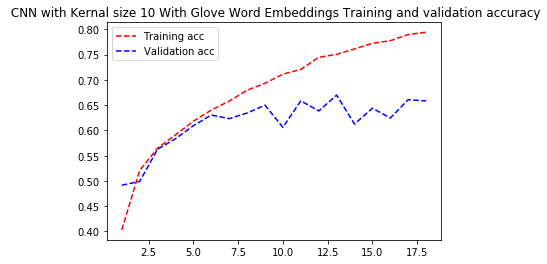

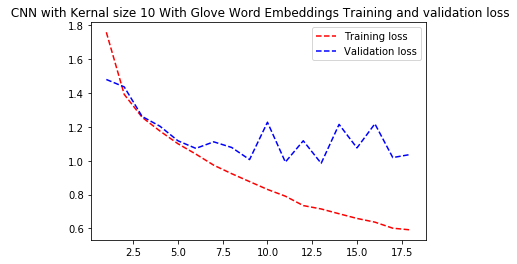

In [214]:
plothistory(  _kernel10_cnn, ' CNN with Kernal size 10 With Glove Word Embeddings')

In [215]:
evaluate_model('saved_models/weights.best.cnnkernel10_glovevectors.hdf5', x_val, y_val)

saved_models/weights.best.cnnkernel10_glovevectors.hdf5
acc: 66.98%
loss: 0.98%


In [216]:
callbacks = setup_callbacks('saved_models/weights.best.cnnkernel5_glovevectors.hdf5', 5)

In [217]:
kernel5_cnn_model = build_cnn_with_glove_vectors(32, 5, 2, 24, num_classes, 0.25)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 100)         852900    
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 996, 32)           16032     
_________________________________________________________________
dropout_11 (Dropout)         (None, 996, 32)           0         
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 498, 32)           0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 494, 16)           2576      
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 247, 16)           0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 243, 8)            648       
__________

In [218]:
 _kernel5_cnn = train_model(kernel5_cnn_model, x_train, y_train, x_val, y_val, callbacks, 50, batch_size)

Train on 16064 samples, validate on 4016 samples
Epoch 1/50


 3248/16064 [=====>........................] - ETA: 4:26 - loss: 2.7531 - acc: 0.062 - ETA: 2:51 - loss: 2.6121 - acc: 0.031 - ETA: 2:25 - loss: 2.6117 - acc: 0.020 - ETA: 2:12 - loss: 2.5747 - acc: 0.046 - ETA: 2:03 - loss: 2.5495 - acc: 0.037 - ETA: 1:57 - loss: 2.5567 - acc: 0.031 - ETA: 1:52 - loss: 2.5454 - acc: 0.035 - ETA: 1:49 - loss: 2.5459 - acc: 0.031 - ETA: 1:46 - loss: 2.5416 - acc: 0.034 - ETA: 1:45 - loss: 2.5325 - acc: 0.050 - ETA: 1:43 - loss: 2.5299 - acc: 0.045 - ETA: 1:41 - loss: 2.5284 - acc: 0.041 - ETA: 1:40 - loss: 2.5248 - acc: 0.043 - ETA: 1:40 - loss: 2.5236 - acc: 0.044 - ETA: 1:38 - loss: 2.5209 - acc: 0.041 - ETA: 1:38 - loss: 2.5172 - acc: 0.050 - ETA: 1:37 - loss: 2.5140 - acc: 0.058 - ETA: 1:37 - loss: 2.5114 - acc: 0.059 - ETA: 1:37 - loss: 2.5093 - acc: 0.062 - ETA: 1:36 - loss: 2.5050 - acc: 0.065 - ETA: 1:35 - loss: 2.5055 - acc: 0.068 - ETA: 1:35 - loss: 2.5030 - acc: 0.073 - ETA: 1:35 - loss: 2.5033 - acc: 0.070 - ETA: 1:34 - loss: 2.5020 - acc: 0

10000/16064 [=================>............] - ETA: 55s - loss: 2.1321 - acc: 0.27 - ETA: 55s - loss: 2.1316 - acc: 0.27 - ETA: 55s - loss: 2.1314 - acc: 0.27 - ETA: 55s - loss: 2.1315 - acc: 0.27 - ETA: 55s - loss: 2.1311 - acc: 0.27 - ETA: 55s - loss: 2.1307 - acc: 0.27 - ETA: 55s - loss: 2.1301 - acc: 0.27 - ETA: 55s - loss: 2.1302 - acc: 0.27 - ETA: 55s - loss: 2.1281 - acc: 0.27 - ETA: 54s - loss: 2.1274 - acc: 0.27 - ETA: 54s - loss: 2.1268 - acc: 0.27 - ETA: 54s - loss: 2.1264 - acc: 0.27 - ETA: 54s - loss: 2.1269 - acc: 0.27 - ETA: 54s - loss: 2.1266 - acc: 0.27 - ETA: 54s - loss: 2.1256 - acc: 0.27 - ETA: 54s - loss: 2.1247 - acc: 0.27 - ETA: 54s - loss: 2.1241 - acc: 0.27 - ETA: 54s - loss: 2.1231 - acc: 0.27 - ETA: 54s - loss: 2.1230 - acc: 0.27 - ETA: 54s - loss: 2.1222 - acc: 0.27 - ETA: 53s - loss: 2.1219 - acc: 0.27 - ETA: 53s - loss: 2.1226 - acc: 0.27 - ETA: 53s - loss: 2.1219 - acc: 0.27 - ETA: 53s - loss: 2.1210 - acc: 0.27 - ETA: 53s - loss: 2.1203 - acc: 0.27 - ETA

13440/16064 [========================>.....] - ETA: 35s - loss: 1.9982 - acc: 0.31 - ETA: 35s - loss: 1.9974 - acc: 0.31 - ETA: 35s - loss: 1.9971 - acc: 0.31 - ETA: 35s - loss: 1.9960 - acc: 0.31 - ETA: 35s - loss: 1.9951 - acc: 0.31 - ETA: 35s - loss: 1.9945 - acc: 0.31 - ETA: 35s - loss: 1.9934 - acc: 0.31 - ETA: 35s - loss: 1.9936 - acc: 0.31 - ETA: 35s - loss: 1.9930 - acc: 0.31 - ETA: 34s - loss: 1.9923 - acc: 0.32 - ETA: 34s - loss: 1.9919 - acc: 0.32 - ETA: 34s - loss: 1.9914 - acc: 0.32 - ETA: 34s - loss: 1.9898 - acc: 0.32 - ETA: 34s - loss: 1.9893 - acc: 0.32 - ETA: 34s - loss: 1.9881 - acc: 0.32 - ETA: 34s - loss: 1.9877 - acc: 0.32 - ETA: 34s - loss: 1.9877 - acc: 0.32 - ETA: 34s - loss: 1.9870 - acc: 0.32 - ETA: 34s - loss: 1.9862 - acc: 0.32 - ETA: 33s - loss: 1.9853 - acc: 0.32 - ETA: 33s - loss: 1.9850 - acc: 0.32 - ETA: 33s - loss: 1.9843 - acc: 0.32 - ETA: 33s - loss: 1.9831 - acc: 0.32 - ETA: 33s - loss: 1.9823 - acc: 0.32 - ETA: 33s - loss: 1.9826 - acc: 0.32 - ETA

16064/16064 [==============================] - ETA: 15s - loss: 1.8980 - acc: 0.35 - ETA: 15s - loss: 1.8979 - acc: 0.35 - ETA: 15s - loss: 1.8983 - acc: 0.35 - ETA: 15s - loss: 1.8979 - acc: 0.35 - ETA: 15s - loss: 1.8973 - acc: 0.35 - ETA: 15s - loss: 1.8970 - acc: 0.35 - ETA: 14s - loss: 1.8969 - acc: 0.35 - ETA: 14s - loss: 1.8962 - acc: 0.35 - ETA: 14s - loss: 1.8960 - acc: 0.35 - ETA: 14s - loss: 1.8955 - acc: 0.35 - ETA: 14s - loss: 1.8951 - acc: 0.35 - ETA: 14s - loss: 1.8945 - acc: 0.35 - ETA: 14s - loss: 1.8941 - acc: 0.35 - ETA: 14s - loss: 1.8940 - acc: 0.35 - ETA: 14s - loss: 1.8938 - acc: 0.35 - ETA: 14s - loss: 1.8929 - acc: 0.35 - ETA: 13s - loss: 1.8921 - acc: 0.35 - ETA: 13s - loss: 1.8915 - acc: 0.35 - ETA: 13s - loss: 1.8910 - acc: 0.35 - ETA: 13s - loss: 1.8908 - acc: 0.35 - ETA: 13s - loss: 1.8901 - acc: 0.35 - ETA: 13s - loss: 1.8894 - acc: 0.35 - ETA: 13s - loss: 1.8883 - acc: 0.35 - ETA: 13s - loss: 1.8879 - acc: 0.35 - ETA: 13s - loss: 1.8877 - acc: 0.35 - ETA

 3264/16064 [=====>........................] - ETA: 1:24 - loss: 1.7199 - acc: 0.375 - ETA: 1:30 - loss: 1.8380 - acc: 0.281 - ETA: 1:38 - loss: 1.7088 - acc: 0.333 - ETA: 1:42 - loss: 1.5881 - acc: 0.390 - ETA: 1:45 - loss: 1.5302 - acc: 0.437 - ETA: 1:43 - loss: 1.5310 - acc: 0.468 - ETA: 1:44 - loss: 1.5287 - acc: 0.446 - ETA: 1:46 - loss: 1.5450 - acc: 0.445 - ETA: 1:47 - loss: 1.5796 - acc: 0.444 - ETA: 1:46 - loss: 1.5877 - acc: 0.443 - ETA: 1:45 - loss: 1.5783 - acc: 0.448 - ETA: 1:44 - loss: 1.5480 - acc: 0.453 - ETA: 1:43 - loss: 1.5594 - acc: 0.447 - ETA: 1:42 - loss: 1.5599 - acc: 0.459 - ETA: 1:42 - loss: 1.5271 - acc: 0.479 - ETA: 1:42 - loss: 1.5148 - acc: 0.492 - ETA: 1:41 - loss: 1.5240 - acc: 0.485 - ETA: 1:41 - loss: 1.5324 - acc: 0.479 - ETA: 1:41 - loss: 1.5233 - acc: 0.473 - ETA: 1:40 - loss: 1.5335 - acc: 0.468 - ETA: 1:40 - loss: 1.5485 - acc: 0.476 - ETA: 1:40 - loss: 1.5400 - acc: 0.477 - ETA: 1:40 - loss: 1.5477 - acc: 0.475 - ETA: 1:39 - loss: 1.5445 - acc: 0

 9984/16064 [=================>............] - ETA: 57s - loss: 1.5065 - acc: 0.46 - ETA: 57s - loss: 1.5065 - acc: 0.46 - ETA: 57s - loss: 1.5062 - acc: 0.46 - ETA: 57s - loss: 1.5053 - acc: 0.46 - ETA: 57s - loss: 1.5055 - acc: 0.46 - ETA: 57s - loss: 1.5063 - acc: 0.46 - ETA: 57s - loss: 1.5073 - acc: 0.46 - ETA: 57s - loss: 1.5077 - acc: 0.46 - ETA: 57s - loss: 1.5077 - acc: 0.46 - ETA: 56s - loss: 1.5074 - acc: 0.46 - ETA: 56s - loss: 1.5072 - acc: 0.46 - ETA: 56s - loss: 1.5066 - acc: 0.46 - ETA: 56s - loss: 1.5078 - acc: 0.46 - ETA: 56s - loss: 1.5071 - acc: 0.46 - ETA: 56s - loss: 1.5060 - acc: 0.46 - ETA: 56s - loss: 1.5059 - acc: 0.46 - ETA: 56s - loss: 1.5057 - acc: 0.46 - ETA: 56s - loss: 1.5043 - acc: 0.46 - ETA: 56s - loss: 1.5045 - acc: 0.46 - ETA: 56s - loss: 1.5043 - acc: 0.46 - ETA: 55s - loss: 1.5037 - acc: 0.46 - ETA: 55s - loss: 1.5039 - acc: 0.46 - ETA: 55s - loss: 1.5036 - acc: 0.46 - ETA: 55s - loss: 1.5038 - acc: 0.46 - ETA: 55s - loss: 1.5031 - acc: 0.46 - ETA

13424/16064 [========================>.....] - ETA: 36s - loss: 1.4827 - acc: 0.48 - ETA: 36s - loss: 1.4823 - acc: 0.48 - ETA: 36s - loss: 1.4813 - acc: 0.48 - ETA: 36s - loss: 1.4819 - acc: 0.48 - ETA: 35s - loss: 1.4819 - acc: 0.48 - ETA: 35s - loss: 1.4829 - acc: 0.48 - ETA: 35s - loss: 1.4832 - acc: 0.48 - ETA: 35s - loss: 1.4831 - acc: 0.48 - ETA: 35s - loss: 1.4840 - acc: 0.48 - ETA: 35s - loss: 1.4840 - acc: 0.48 - ETA: 35s - loss: 1.4831 - acc: 0.48 - ETA: 35s - loss: 1.4837 - acc: 0.48 - ETA: 35s - loss: 1.4834 - acc: 0.48 - ETA: 35s - loss: 1.4827 - acc: 0.48 - ETA: 34s - loss: 1.4825 - acc: 0.48 - ETA: 34s - loss: 1.4828 - acc: 0.48 - ETA: 34s - loss: 1.4833 - acc: 0.48 - ETA: 34s - loss: 1.4830 - acc: 0.48 - ETA: 34s - loss: 1.4829 - acc: 0.48 - ETA: 34s - loss: 1.4824 - acc: 0.48 - ETA: 34s - loss: 1.4815 - acc: 0.48 - ETA: 34s - loss: 1.4813 - acc: 0.48 - ETA: 34s - loss: 1.4814 - acc: 0.48 - ETA: 34s - loss: 1.4817 - acc: 0.48 - ETA: 33s - loss: 1.4814 - acc: 0.48 - ETA

16064/16064 [==============================] - ETA: 15s - loss: 1.4657 - acc: 0.48 - ETA: 15s - loss: 1.4656 - acc: 0.48 - ETA: 15s - loss: 1.4660 - acc: 0.48 - ETA: 15s - loss: 1.4661 - acc: 0.48 - ETA: 15s - loss: 1.4660 - acc: 0.48 - ETA: 15s - loss: 1.4654 - acc: 0.48 - ETA: 15s - loss: 1.4654 - acc: 0.48 - ETA: 15s - loss: 1.4653 - acc: 0.48 - ETA: 15s - loss: 1.4650 - acc: 0.48 - ETA: 14s - loss: 1.4652 - acc: 0.48 - ETA: 14s - loss: 1.4654 - acc: 0.48 - ETA: 14s - loss: 1.4654 - acc: 0.48 - ETA: 14s - loss: 1.4660 - acc: 0.48 - ETA: 14s - loss: 1.4663 - acc: 0.48 - ETA: 14s - loss: 1.4664 - acc: 0.48 - ETA: 14s - loss: 1.4662 - acc: 0.48 - ETA: 14s - loss: 1.4664 - acc: 0.48 - ETA: 14s - loss: 1.4662 - acc: 0.48 - ETA: 14s - loss: 1.4662 - acc: 0.48 - ETA: 14s - loss: 1.4661 - acc: 0.48 - ETA: 13s - loss: 1.4658 - acc: 0.48 - ETA: 13s - loss: 1.4655 - acc: 0.48 - ETA: 13s - loss: 1.4656 - acc: 0.48 - ETA: 13s - loss: 1.4653 - acc: 0.48 - ETA: 13s - loss: 1.4660 - acc: 0.48 - ETA

 3264/16064 [=====>........................] - ETA: 1:18 - loss: 1.1297 - acc: 0.500 - ETA: 1:24 - loss: 1.1929 - acc: 0.531 - ETA: 1:29 - loss: 1.3024 - acc: 0.541 - ETA: 1:29 - loss: 1.3954 - acc: 0.484 - ETA: 1:31 - loss: 1.4476 - acc: 0.450 - ETA: 1:33 - loss: 1.4034 - acc: 0.489 - ETA: 1:33 - loss: 1.4210 - acc: 0.473 - ETA: 1:31 - loss: 1.4628 - acc: 0.484 - ETA: 1:32 - loss: 1.4637 - acc: 0.486 - ETA: 1:30 - loss: 1.4747 - acc: 0.487 - ETA: 1:30 - loss: 1.4539 - acc: 0.483 - ETA: 1:30 - loss: 1.4283 - acc: 0.500 - ETA: 1:31 - loss: 1.3960 - acc: 0.509 - ETA: 1:31 - loss: 1.4332 - acc: 0.486 - ETA: 1:32 - loss: 1.4344 - acc: 0.487 - ETA: 1:32 - loss: 1.4162 - acc: 0.496 - ETA: 1:32 - loss: 1.4064 - acc: 0.496 - ETA: 1:32 - loss: 1.4072 - acc: 0.493 - ETA: 1:32 - loss: 1.4039 - acc: 0.493 - ETA: 1:31 - loss: 1.4200 - acc: 0.490 - ETA: 1:31 - loss: 1.4149 - acc: 0.491 - ETA: 1:31 - loss: 1.4108 - acc: 0.491 - ETA: 1:31 - loss: 1.4230 - acc: 0.489 - ETA: 1:32 - loss: 1.4129 - acc: 0

10000/16064 [=================>............] - ETA: 55s - loss: 1.3574 - acc: 0.52 - ETA: 55s - loss: 1.3566 - acc: 0.52 - ETA: 55s - loss: 1.3573 - acc: 0.52 - ETA: 55s - loss: 1.3586 - acc: 0.52 - ETA: 55s - loss: 1.3574 - acc: 0.52 - ETA: 55s - loss: 1.3572 - acc: 0.52 - ETA: 55s - loss: 1.3576 - acc: 0.52 - ETA: 55s - loss: 1.3578 - acc: 0.52 - ETA: 54s - loss: 1.3571 - acc: 0.52 - ETA: 54s - loss: 1.3560 - acc: 0.52 - ETA: 54s - loss: 1.3557 - acc: 0.52 - ETA: 54s - loss: 1.3559 - acc: 0.52 - ETA: 54s - loss: 1.3569 - acc: 0.52 - ETA: 54s - loss: 1.3556 - acc: 0.52 - ETA: 54s - loss: 1.3548 - acc: 0.52 - ETA: 54s - loss: 1.3561 - acc: 0.52 - ETA: 54s - loss: 1.3548 - acc: 0.52 - ETA: 54s - loss: 1.3550 - acc: 0.52 - ETA: 54s - loss: 1.3545 - acc: 0.52 - ETA: 53s - loss: 1.3550 - acc: 0.52 - ETA: 53s - loss: 1.3542 - acc: 0.52 - ETA: 53s - loss: 1.3539 - acc: 0.52 - ETA: 53s - loss: 1.3546 - acc: 0.52 - ETA: 53s - loss: 1.3540 - acc: 0.52 - ETA: 53s - loss: 1.3535 - acc: 0.52 - ETA

13440/16064 [========================>.....] - ETA: 35s - loss: 1.3401 - acc: 0.52 - ETA: 35s - loss: 1.3400 - acc: 0.52 - ETA: 35s - loss: 1.3401 - acc: 0.52 - ETA: 35s - loss: 1.3394 - acc: 0.52 - ETA: 35s - loss: 1.3392 - acc: 0.52 - ETA: 35s - loss: 1.3385 - acc: 0.52 - ETA: 34s - loss: 1.3388 - acc: 0.52 - ETA: 34s - loss: 1.3393 - acc: 0.52 - ETA: 34s - loss: 1.3394 - acc: 0.52 - ETA: 34s - loss: 1.3387 - acc: 0.52 - ETA: 34s - loss: 1.3385 - acc: 0.52 - ETA: 34s - loss: 1.3390 - acc: 0.52 - ETA: 34s - loss: 1.3389 - acc: 0.52 - ETA: 34s - loss: 1.3395 - acc: 0.52 - ETA: 34s - loss: 1.3394 - acc: 0.52 - ETA: 34s - loss: 1.3396 - acc: 0.52 - ETA: 33s - loss: 1.3390 - acc: 0.52 - ETA: 33s - loss: 1.3387 - acc: 0.52 - ETA: 33s - loss: 1.3388 - acc: 0.52 - ETA: 33s - loss: 1.3391 - acc: 0.52 - ETA: 33s - loss: 1.3390 - acc: 0.52 - ETA: 33s - loss: 1.3387 - acc: 0.52 - ETA: 33s - loss: 1.3390 - acc: 0.52 - ETA: 33s - loss: 1.3393 - acc: 0.52 - ETA: 33s - loss: 1.3390 - acc: 0.52 - ETA

16064/16064 [==============================] - ETA: 15s - loss: 1.3383 - acc: 0.53 - ETA: 15s - loss: 1.3385 - acc: 0.53 - ETA: 15s - loss: 1.3386 - acc: 0.53 - ETA: 15s - loss: 1.3391 - acc: 0.53 - ETA: 14s - loss: 1.3386 - acc: 0.53 - ETA: 14s - loss: 1.3382 - acc: 0.53 - ETA: 14s - loss: 1.3378 - acc: 0.53 - ETA: 14s - loss: 1.3383 - acc: 0.53 - ETA: 14s - loss: 1.3381 - acc: 0.53 - ETA: 14s - loss: 1.3380 - acc: 0.53 - ETA: 14s - loss: 1.3375 - acc: 0.53 - ETA: 14s - loss: 1.3376 - acc: 0.53 - ETA: 14s - loss: 1.3379 - acc: 0.53 - ETA: 14s - loss: 1.3384 - acc: 0.53 - ETA: 14s - loss: 1.3387 - acc: 0.53 - ETA: 13s - loss: 1.3385 - acc: 0.53 - ETA: 13s - loss: 1.3388 - acc: 0.53 - ETA: 13s - loss: 1.3390 - acc: 0.53 - ETA: 13s - loss: 1.3391 - acc: 0.53 - ETA: 13s - loss: 1.3387 - acc: 0.53 - ETA: 13s - loss: 1.3386 - acc: 0.53 - ETA: 13s - loss: 1.3386 - acc: 0.53 - ETA: 13s - loss: 1.3382 - acc: 0.53 - ETA: 13s - loss: 1.3382 - acc: 0.53 - ETA: 13s - loss: 1.3383 - acc: 0.53 - ETA

 3264/16064 [=====>........................] - ETA: 1:26 - loss: 1.1909 - acc: 0.437 - ETA: 1:22 - loss: 1.1660 - acc: 0.562 - ETA: 1:26 - loss: 1.1994 - acc: 0.562 - ETA: 1:24 - loss: 1.2113 - acc: 0.531 - ETA: 1:26 - loss: 1.2463 - acc: 0.525 - ETA: 1:27 - loss: 1.2176 - acc: 0.541 - ETA: 1:25 - loss: 1.2569 - acc: 0.508 - ETA: 1:26 - loss: 1.2927 - acc: 0.492 - ETA: 1:27 - loss: 1.2921 - acc: 0.506 - ETA: 1:26 - loss: 1.2983 - acc: 0.512 - ETA: 1:26 - loss: 1.2803 - acc: 0.522 - ETA: 1:26 - loss: 1.2669 - acc: 0.526 - ETA: 1:26 - loss: 1.2382 - acc: 0.538 - ETA: 1:26 - loss: 1.2348 - acc: 0.544 - ETA: 1:25 - loss: 1.2242 - acc: 0.545 - ETA: 1:25 - loss: 1.2026 - acc: 0.550 - ETA: 1:26 - loss: 1.2219 - acc: 0.544 - ETA: 1:25 - loss: 1.2274 - acc: 0.541 - ETA: 1:25 - loss: 1.2289 - acc: 0.539 - ETA: 1:25 - loss: 1.2174 - acc: 0.543 - ETA: 1:24 - loss: 1.2145 - acc: 0.547 - ETA: 1:25 - loss: 1.1983 - acc: 0.559 - ETA: 1:25 - loss: 1.2118 - acc: 0.551 - ETA: 1:25 - loss: 1.1955 - acc: 0

10000/16064 [=================>............] - ETA: 56s - loss: 1.2346 - acc: 0.56 - ETA: 56s - loss: 1.2357 - acc: 0.56 - ETA: 56s - loss: 1.2355 - acc: 0.56 - ETA: 56s - loss: 1.2354 - acc: 0.56 - ETA: 55s - loss: 1.2351 - acc: 0.56 - ETA: 55s - loss: 1.2354 - acc: 0.56 - ETA: 55s - loss: 1.2361 - acc: 0.56 - ETA: 55s - loss: 1.2359 - acc: 0.56 - ETA: 55s - loss: 1.2355 - acc: 0.56 - ETA: 55s - loss: 1.2346 - acc: 0.56 - ETA: 55s - loss: 1.2348 - acc: 0.56 - ETA: 55s - loss: 1.2349 - acc: 0.56 - ETA: 55s - loss: 1.2352 - acc: 0.56 - ETA: 55s - loss: 1.2358 - acc: 0.56 - ETA: 54s - loss: 1.2359 - acc: 0.56 - ETA: 54s - loss: 1.2364 - acc: 0.56 - ETA: 54s - loss: 1.2356 - acc: 0.56 - ETA: 54s - loss: 1.2360 - acc: 0.56 - ETA: 54s - loss: 1.2359 - acc: 0.56 - ETA: 54s - loss: 1.2368 - acc: 0.56 - ETA: 54s - loss: 1.2377 - acc: 0.56 - ETA: 54s - loss: 1.2373 - acc: 0.56 - ETA: 54s - loss: 1.2375 - acc: 0.56 - ETA: 54s - loss: 1.2382 - acc: 0.56 - ETA: 54s - loss: 1.2378 - acc: 0.56 - ETA

13440/16064 [========================>.....] - ETA: 36s - loss: 1.2191 - acc: 0.57 - ETA: 36s - loss: 1.2192 - acc: 0.57 - ETA: 35s - loss: 1.2194 - acc: 0.57 - ETA: 35s - loss: 1.2196 - acc: 0.56 - ETA: 35s - loss: 1.2197 - acc: 0.56 - ETA: 35s - loss: 1.2197 - acc: 0.56 - ETA: 35s - loss: 1.2193 - acc: 0.56 - ETA: 35s - loss: 1.2200 - acc: 0.56 - ETA: 35s - loss: 1.2204 - acc: 0.56 - ETA: 35s - loss: 1.2202 - acc: 0.56 - ETA: 35s - loss: 1.2203 - acc: 0.56 - ETA: 35s - loss: 1.2196 - acc: 0.56 - ETA: 34s - loss: 1.2187 - acc: 0.56 - ETA: 34s - loss: 1.2194 - acc: 0.56 - ETA: 34s - loss: 1.2197 - acc: 0.56 - ETA: 34s - loss: 1.2207 - acc: 0.56 - ETA: 34s - loss: 1.2205 - acc: 0.56 - ETA: 34s - loss: 1.2202 - acc: 0.56 - ETA: 34s - loss: 1.2199 - acc: 0.56 - ETA: 34s - loss: 1.2201 - acc: 0.56 - ETA: 34s - loss: 1.2206 - acc: 0.56 - ETA: 34s - loss: 1.2205 - acc: 0.56 - ETA: 34s - loss: 1.2209 - acc: 0.56 - ETA: 33s - loss: 1.2218 - acc: 0.56 - ETA: 33s - loss: 1.2223 - acc: 0.56 - ETA

16064/16064 [==============================] - ETA: 15s - loss: 1.2192 - acc: 0.57 - ETA: 15s - loss: 1.2191 - acc: 0.57 - ETA: 15s - loss: 1.2189 - acc: 0.57 - ETA: 15s - loss: 1.2184 - acc: 0.57 - ETA: 14s - loss: 1.2180 - acc: 0.57 - ETA: 14s - loss: 1.2175 - acc: 0.57 - ETA: 14s - loss: 1.2178 - acc: 0.57 - ETA: 14s - loss: 1.2179 - acc: 0.57 - ETA: 14s - loss: 1.2178 - acc: 0.57 - ETA: 14s - loss: 1.2179 - acc: 0.57 - ETA: 14s - loss: 1.2175 - acc: 0.57 - ETA: 14s - loss: 1.2177 - acc: 0.57 - ETA: 14s - loss: 1.2185 - acc: 0.57 - ETA: 14s - loss: 1.2183 - acc: 0.57 - ETA: 14s - loss: 1.2178 - acc: 0.57 - ETA: 13s - loss: 1.2177 - acc: 0.57 - ETA: 13s - loss: 1.2178 - acc: 0.57 - ETA: 13s - loss: 1.2178 - acc: 0.57 - ETA: 13s - loss: 1.2176 - acc: 0.57 - ETA: 13s - loss: 1.2177 - acc: 0.57 - ETA: 13s - loss: 1.2175 - acc: 0.57 - ETA: 13s - loss: 1.2173 - acc: 0.57 - ETA: 13s - loss: 1.2175 - acc: 0.57 - ETA: 13s - loss: 1.2177 - acc: 0.57 - ETA: 13s - loss: 1.2182 - acc: 0.57 - ETA

 3264/16064 [=====>........................] - ETA: 1:33 - loss: 0.9667 - acc: 0.625 - ETA: 1:33 - loss: 1.0603 - acc: 0.593 - ETA: 1:28 - loss: 1.1302 - acc: 0.562 - ETA: 1:28 - loss: 1.1846 - acc: 0.546 - ETA: 1:31 - loss: 1.1507 - acc: 0.575 - ETA: 1:33 - loss: 1.1219 - acc: 0.614 - ETA: 1:34 - loss: 1.1480 - acc: 0.607 - ETA: 1:34 - loss: 1.1227 - acc: 0.625 - ETA: 1:34 - loss: 1.1064 - acc: 0.618 - ETA: 1:33 - loss: 1.0497 - acc: 0.643 - ETA: 1:32 - loss: 1.0333 - acc: 0.659 - ETA: 1:32 - loss: 1.0266 - acc: 0.656 - ETA: 1:31 - loss: 1.0606 - acc: 0.653 - ETA: 1:30 - loss: 1.0525 - acc: 0.656 - ETA: 1:31 - loss: 1.0569 - acc: 0.662 - ETA: 1:30 - loss: 1.0475 - acc: 0.668 - ETA: 1:31 - loss: 1.0426 - acc: 0.661 - ETA: 1:32 - loss: 1.0604 - acc: 0.656 - ETA: 1:32 - loss: 1.0725 - acc: 0.648 - ETA: 1:32 - loss: 1.0931 - acc: 0.646 - ETA: 1:32 - loss: 1.1082 - acc: 0.642 - ETA: 1:31 - loss: 1.1130 - acc: 0.633 - ETA: 1:31 - loss: 1.1197 - acc: 0.633 - ETA: 1:31 - loss: 1.1224 - acc: 0

10016/16064 [=================>............] - ETA: 55s - loss: 1.1316 - acc: 0.60 - ETA: 54s - loss: 1.1327 - acc: 0.60 - ETA: 54s - loss: 1.1329 - acc: 0.60 - ETA: 54s - loss: 1.1325 - acc: 0.60 - ETA: 54s - loss: 1.1322 - acc: 0.60 - ETA: 54s - loss: 1.1319 - acc: 0.60 - ETA: 54s - loss: 1.1324 - acc: 0.60 - ETA: 54s - loss: 1.1330 - acc: 0.60 - ETA: 54s - loss: 1.1334 - acc: 0.60 - ETA: 54s - loss: 1.1331 - acc: 0.60 - ETA: 54s - loss: 1.1336 - acc: 0.60 - ETA: 53s - loss: 1.1336 - acc: 0.60 - ETA: 53s - loss: 1.1336 - acc: 0.60 - ETA: 53s - loss: 1.1327 - acc: 0.60 - ETA: 53s - loss: 1.1326 - acc: 0.60 - ETA: 53s - loss: 1.1329 - acc: 0.60 - ETA: 53s - loss: 1.1328 - acc: 0.60 - ETA: 53s - loss: 1.1325 - acc: 0.60 - ETA: 53s - loss: 1.1325 - acc: 0.60 - ETA: 53s - loss: 1.1311 - acc: 0.60 - ETA: 53s - loss: 1.1304 - acc: 0.60 - ETA: 53s - loss: 1.1306 - acc: 0.60 - ETA: 52s - loss: 1.1310 - acc: 0.60 - ETA: 52s - loss: 1.1304 - acc: 0.60 - ETA: 52s - loss: 1.1297 - acc: 0.60 - ETA

13456/16064 [========================>.....] - ETA: 35s - loss: 1.1273 - acc: 0.60 - ETA: 35s - loss: 1.1263 - acc: 0.60 - ETA: 35s - loss: 1.1260 - acc: 0.60 - ETA: 35s - loss: 1.1256 - acc: 0.60 - ETA: 35s - loss: 1.1253 - acc: 0.60 - ETA: 35s - loss: 1.1246 - acc: 0.60 - ETA: 35s - loss: 1.1246 - acc: 0.60 - ETA: 35s - loss: 1.1244 - acc: 0.60 - ETA: 35s - loss: 1.1239 - acc: 0.60 - ETA: 34s - loss: 1.1235 - acc: 0.60 - ETA: 34s - loss: 1.1235 - acc: 0.60 - ETA: 34s - loss: 1.1241 - acc: 0.61 - ETA: 34s - loss: 1.1241 - acc: 0.61 - ETA: 34s - loss: 1.1251 - acc: 0.60 - ETA: 34s - loss: 1.1249 - acc: 0.60 - ETA: 34s - loss: 1.1247 - acc: 0.61 - ETA: 34s - loss: 1.1245 - acc: 0.61 - ETA: 34s - loss: 1.1252 - acc: 0.60 - ETA: 34s - loss: 1.1254 - acc: 0.60 - ETA: 34s - loss: 1.1247 - acc: 0.61 - ETA: 33s - loss: 1.1246 - acc: 0.61 - ETA: 33s - loss: 1.1248 - acc: 0.61 - ETA: 33s - loss: 1.1252 - acc: 0.60 - ETA: 33s - loss: 1.1247 - acc: 0.60 - ETA: 33s - loss: 1.1248 - acc: 0.60 - ETA

16064/16064 [==============================] - ETA: 15s - loss: 1.1209 - acc: 0.61 - ETA: 15s - loss: 1.1206 - acc: 0.61 - ETA: 15s - loss: 1.1207 - acc: 0.61 - ETA: 15s - loss: 1.1215 - acc: 0.61 - ETA: 15s - loss: 1.1211 - acc: 0.61 - ETA: 14s - loss: 1.1213 - acc: 0.61 - ETA: 14s - loss: 1.1207 - acc: 0.61 - ETA: 14s - loss: 1.1208 - acc: 0.61 - ETA: 14s - loss: 1.1208 - acc: 0.61 - ETA: 14s - loss: 1.1210 - acc: 0.61 - ETA: 14s - loss: 1.1209 - acc: 0.61 - ETA: 14s - loss: 1.1209 - acc: 0.61 - ETA: 14s - loss: 1.1208 - acc: 0.61 - ETA: 14s - loss: 1.1209 - acc: 0.61 - ETA: 14s - loss: 1.1205 - acc: 0.61 - ETA: 13s - loss: 1.1206 - acc: 0.61 - ETA: 13s - loss: 1.1204 - acc: 0.61 - ETA: 13s - loss: 1.1203 - acc: 0.61 - ETA: 13s - loss: 1.1204 - acc: 0.61 - ETA: 13s - loss: 1.1203 - acc: 0.61 - ETA: 13s - loss: 1.1201 - acc: 0.61 - ETA: 13s - loss: 1.1200 - acc: 0.61 - ETA: 13s - loss: 1.1196 - acc: 0.61 - ETA: 13s - loss: 1.1196 - acc: 0.61 - ETA: 13s - loss: 1.1198 - acc: 0.61 - ETA

 3264/16064 [=====>........................] - ETA: 1:30 - loss: 0.8645 - acc: 0.625 - ETA: 1:29 - loss: 1.0255 - acc: 0.593 - ETA: 1:29 - loss: 0.9393 - acc: 0.625 - ETA: 1:26 - loss: 0.9444 - acc: 0.640 - ETA: 1:28 - loss: 1.0211 - acc: 0.612 - ETA: 1:25 - loss: 1.0871 - acc: 0.604 - ETA: 1:26 - loss: 1.1018 - acc: 0.580 - ETA: 1:29 - loss: 1.1505 - acc: 0.578 - ETA: 1:29 - loss: 1.1347 - acc: 0.590 - ETA: 1:29 - loss: 1.1060 - acc: 0.593 - ETA: 1:28 - loss: 1.1025 - acc: 0.590 - ETA: 1:29 - loss: 1.0882 - acc: 0.599 - ETA: 1:30 - loss: 1.0971 - acc: 0.591 - ETA: 1:31 - loss: 1.1046 - acc: 0.584 - ETA: 1:31 - loss: 1.0958 - acc: 0.595 - ETA: 1:30 - loss: 1.0777 - acc: 0.605 - ETA: 1:30 - loss: 1.0434 - acc: 0.617 - ETA: 1:30 - loss: 1.0483 - acc: 0.618 - ETA: 1:29 - loss: 1.0618 - acc: 0.618 - ETA: 1:31 - loss: 1.0661 - acc: 0.612 - ETA: 1:30 - loss: 1.0536 - acc: 0.619 - ETA: 1:31 - loss: 1.0570 - acc: 0.613 - ETA: 1:32 - loss: 1.0788 - acc: 0.614 - ETA: 1:32 - loss: 1.1155 - acc: 0

10016/16064 [=================>............] - ETA: 55s - loss: 1.0676 - acc: 0.62 - ETA: 54s - loss: 1.0667 - acc: 0.62 - ETA: 54s - loss: 1.0655 - acc: 0.62 - ETA: 54s - loss: 1.0641 - acc: 0.62 - ETA: 54s - loss: 1.0633 - acc: 0.62 - ETA: 54s - loss: 1.0627 - acc: 0.62 - ETA: 54s - loss: 1.0630 - acc: 0.62 - ETA: 54s - loss: 1.0634 - acc: 0.62 - ETA: 54s - loss: 1.0629 - acc: 0.62 - ETA: 54s - loss: 1.0629 - acc: 0.62 - ETA: 54s - loss: 1.0637 - acc: 0.62 - ETA: 54s - loss: 1.0634 - acc: 0.62 - ETA: 53s - loss: 1.0638 - acc: 0.62 - ETA: 53s - loss: 1.0635 - acc: 0.62 - ETA: 53s - loss: 1.0631 - acc: 0.62 - ETA: 53s - loss: 1.0639 - acc: 0.62 - ETA: 53s - loss: 1.0637 - acc: 0.62 - ETA: 53s - loss: 1.0634 - acc: 0.62 - ETA: 53s - loss: 1.0631 - acc: 0.62 - ETA: 53s - loss: 1.0639 - acc: 0.62 - ETA: 53s - loss: 1.0631 - acc: 0.62 - ETA: 53s - loss: 1.0623 - acc: 0.62 - ETA: 52s - loss: 1.0613 - acc: 0.62 - ETA: 52s - loss: 1.0611 - acc: 0.62 - ETA: 52s - loss: 1.0621 - acc: 0.62 - ETA

13456/16064 [========================>.....] - ETA: 34s - loss: 1.0617 - acc: 0.62 - ETA: 34s - loss: 1.0607 - acc: 0.62 - ETA: 34s - loss: 1.0608 - acc: 0.62 - ETA: 34s - loss: 1.0619 - acc: 0.62 - ETA: 34s - loss: 1.0620 - acc: 0.62 - ETA: 34s - loss: 1.0615 - acc: 0.62 - ETA: 34s - loss: 1.0619 - acc: 0.62 - ETA: 34s - loss: 1.0619 - acc: 0.62 - ETA: 34s - loss: 1.0619 - acc: 0.62 - ETA: 34s - loss: 1.0629 - acc: 0.62 - ETA: 33s - loss: 1.0632 - acc: 0.62 - ETA: 33s - loss: 1.0632 - acc: 0.62 - ETA: 33s - loss: 1.0626 - acc: 0.62 - ETA: 33s - loss: 1.0633 - acc: 0.62 - ETA: 33s - loss: 1.0624 - acc: 0.62 - ETA: 33s - loss: 1.0628 - acc: 0.62 - ETA: 33s - loss: 1.0621 - acc: 0.62 - ETA: 33s - loss: 1.0614 - acc: 0.62 - ETA: 33s - loss: 1.0613 - acc: 0.62 - ETA: 33s - loss: 1.0615 - acc: 0.62 - ETA: 32s - loss: 1.0610 - acc: 0.62 - ETA: 32s - loss: 1.0602 - acc: 0.62 - ETA: 32s - loss: 1.0605 - acc: 0.62 - ETA: 32s - loss: 1.0603 - acc: 0.62 - ETA: 32s - loss: 1.0603 - acc: 0.62 - ETA

16064/16064 [==============================] - ETA: 14s - loss: 1.0473 - acc: 0.63 - ETA: 14s - loss: 1.0472 - acc: 0.63 - ETA: 14s - loss: 1.0469 - acc: 0.63 - ETA: 14s - loss: 1.0467 - acc: 0.63 - ETA: 14s - loss: 1.0461 - acc: 0.63 - ETA: 14s - loss: 1.0464 - acc: 0.63 - ETA: 14s - loss: 1.0470 - acc: 0.63 - ETA: 14s - loss: 1.0464 - acc: 0.63 - ETA: 14s - loss: 1.0462 - acc: 0.63 - ETA: 14s - loss: 1.0465 - acc: 0.63 - ETA: 14s - loss: 1.0462 - acc: 0.63 - ETA: 13s - loss: 1.0464 - acc: 0.63 - ETA: 13s - loss: 1.0459 - acc: 0.63 - ETA: 13s - loss: 1.0460 - acc: 0.63 - ETA: 13s - loss: 1.0452 - acc: 0.63 - ETA: 13s - loss: 1.0456 - acc: 0.63 - ETA: 13s - loss: 1.0453 - acc: 0.63 - ETA: 13s - loss: 1.0451 - acc: 0.63 - ETA: 13s - loss: 1.0451 - acc: 0.63 - ETA: 13s - loss: 1.0461 - acc: 0.63 - ETA: 13s - loss: 1.0463 - acc: 0.63 - ETA: 12s - loss: 1.0456 - acc: 0.63 - ETA: 12s - loss: 1.0460 - acc: 0.63 - ETA: 12s - loss: 1.0459 - acc: 0.63 - ETA: 12s - loss: 1.0460 - acc: 0.63 - ETA

 3264/16064 [=====>........................] - ETA: 1:38 - loss: 1.0813 - acc: 0.562 - ETA: 1:33 - loss: 0.9811 - acc: 0.593 - ETA: 1:33 - loss: 0.9490 - acc: 0.645 - ETA: 1:30 - loss: 1.0790 - acc: 0.609 - ETA: 1:28 - loss: 1.0903 - acc: 0.612 - ETA: 1:30 - loss: 1.0756 - acc: 0.614 - ETA: 1:29 - loss: 1.0938 - acc: 0.589 - ETA: 1:29 - loss: 1.1084 - acc: 0.578 - ETA: 1:29 - loss: 1.0754 - acc: 0.590 - ETA: 1:29 - loss: 1.0553 - acc: 0.600 - ETA: 1:28 - loss: 1.0536 - acc: 0.596 - ETA: 1:28 - loss: 1.0326 - acc: 0.609 - ETA: 1:28 - loss: 1.0311 - acc: 0.610 - ETA: 1:27 - loss: 1.0488 - acc: 0.602 - ETA: 1:28 - loss: 1.0280 - acc: 0.612 - ETA: 1:28 - loss: 1.0119 - acc: 0.621 - ETA: 1:28 - loss: 1.0204 - acc: 0.621 - ETA: 1:28 - loss: 1.0127 - acc: 0.625 - ETA: 1:28 - loss: 1.0102 - acc: 0.618 - ETA: 1:28 - loss: 1.0059 - acc: 0.621 - ETA: 1:28 - loss: 0.9830 - acc: 0.631 - ETA: 1:28 - loss: 0.9565 - acc: 0.639 - ETA: 1:27 - loss: 0.9746 - acc: 0.641 - ETA: 1:28 - loss: 0.9863 - acc: 0

10016/16064 [=================>............] - ETA: 55s - loss: 0.9626 - acc: 0.66 - ETA: 55s - loss: 0.9631 - acc: 0.66 - ETA: 55s - loss: 0.9628 - acc: 0.66 - ETA: 55s - loss: 0.9622 - acc: 0.66 - ETA: 55s - loss: 0.9623 - acc: 0.66 - ETA: 55s - loss: 0.9622 - acc: 0.66 - ETA: 55s - loss: 0.9616 - acc: 0.66 - ETA: 54s - loss: 0.9606 - acc: 0.66 - ETA: 54s - loss: 0.9609 - acc: 0.66 - ETA: 54s - loss: 0.9610 - acc: 0.66 - ETA: 54s - loss: 0.9601 - acc: 0.66 - ETA: 54s - loss: 0.9598 - acc: 0.66 - ETA: 54s - loss: 0.9596 - acc: 0.66 - ETA: 54s - loss: 0.9597 - acc: 0.66 - ETA: 54s - loss: 0.9594 - acc: 0.66 - ETA: 54s - loss: 0.9601 - acc: 0.66 - ETA: 54s - loss: 0.9597 - acc: 0.66 - ETA: 54s - loss: 0.9598 - acc: 0.66 - ETA: 54s - loss: 0.9603 - acc: 0.66 - ETA: 53s - loss: 0.9594 - acc: 0.66 - ETA: 53s - loss: 0.9600 - acc: 0.66 - ETA: 53s - loss: 0.9588 - acc: 0.66 - ETA: 53s - loss: 0.9578 - acc: 0.66 - ETA: 53s - loss: 0.9575 - acc: 0.66 - ETA: 53s - loss: 0.9567 - acc: 0.66 - ETA

13456/16064 [========================>.....] - ETA: 36s - loss: 0.9680 - acc: 0.66 - ETA: 36s - loss: 0.9685 - acc: 0.66 - ETA: 36s - loss: 0.9681 - acc: 0.66 - ETA: 36s - loss: 0.9681 - acc: 0.66 - ETA: 35s - loss: 0.9681 - acc: 0.66 - ETA: 35s - loss: 0.9685 - acc: 0.66 - ETA: 35s - loss: 0.9687 - acc: 0.66 - ETA: 35s - loss: 0.9691 - acc: 0.66 - ETA: 35s - loss: 0.9691 - acc: 0.66 - ETA: 35s - loss: 0.9701 - acc: 0.66 - ETA: 35s - loss: 0.9702 - acc: 0.66 - ETA: 35s - loss: 0.9700 - acc: 0.66 - ETA: 35s - loss: 0.9695 - acc: 0.66 - ETA: 35s - loss: 0.9704 - acc: 0.66 - ETA: 35s - loss: 0.9716 - acc: 0.65 - ETA: 34s - loss: 0.9730 - acc: 0.65 - ETA: 34s - loss: 0.9727 - acc: 0.65 - ETA: 34s - loss: 0.9725 - acc: 0.65 - ETA: 34s - loss: 0.9720 - acc: 0.66 - ETA: 34s - loss: 0.9717 - acc: 0.66 - ETA: 34s - loss: 0.9715 - acc: 0.66 - ETA: 34s - loss: 0.9718 - acc: 0.66 - ETA: 34s - loss: 0.9717 - acc: 0.66 - ETA: 34s - loss: 0.9724 - acc: 0.65 - ETA: 34s - loss: 0.9724 - acc: 0.65 - ETA

16064/16064 [==============================] - ETA: 15s - loss: 0.9872 - acc: 0.65 - ETA: 15s - loss: 0.9873 - acc: 0.65 - ETA: 15s - loss: 0.9875 - acc: 0.65 - ETA: 15s - loss: 0.9874 - acc: 0.65 - ETA: 15s - loss: 0.9877 - acc: 0.65 - ETA: 15s - loss: 0.9873 - acc: 0.65 - ETA: 15s - loss: 0.9874 - acc: 0.65 - ETA: 14s - loss: 0.9876 - acc: 0.65 - ETA: 14s - loss: 0.9880 - acc: 0.65 - ETA: 14s - loss: 0.9882 - acc: 0.65 - ETA: 14s - loss: 0.9881 - acc: 0.65 - ETA: 14s - loss: 0.9886 - acc: 0.65 - ETA: 14s - loss: 0.9887 - acc: 0.65 - ETA: 14s - loss: 0.9887 - acc: 0.65 - ETA: 14s - loss: 0.9887 - acc: 0.65 - ETA: 14s - loss: 0.9883 - acc: 0.65 - ETA: 14s - loss: 0.9884 - acc: 0.65 - ETA: 14s - loss: 0.9886 - acc: 0.65 - ETA: 13s - loss: 0.9887 - acc: 0.65 - ETA: 13s - loss: 0.9889 - acc: 0.65 - ETA: 13s - loss: 0.9890 - acc: 0.65 - ETA: 13s - loss: 0.9892 - acc: 0.65 - ETA: 13s - loss: 0.9895 - acc: 0.65 - ETA: 13s - loss: 0.9891 - acc: 0.65 - ETA: 13s - loss: 0.9895 - acc: 0.65 - ETA

 3264/16064 [=====>........................] - ETA: 1:33 - loss: 0.8416 - acc: 0.625 - ETA: 1:26 - loss: 1.3213 - acc: 0.531 - ETA: 1:30 - loss: 1.2219 - acc: 0.583 - ETA: 1:30 - loss: 1.0943 - acc: 0.625 - ETA: 1:32 - loss: 1.0805 - acc: 0.650 - ETA: 1:31 - loss: 1.0820 - acc: 0.645 - ETA: 1:32 - loss: 1.1030 - acc: 0.633 - ETA: 1:31 - loss: 1.0658 - acc: 0.648 - ETA: 1:29 - loss: 1.0787 - acc: 0.625 - ETA: 1:29 - loss: 1.0701 - acc: 0.625 - ETA: 1:29 - loss: 1.0266 - acc: 0.636 - ETA: 1:29 - loss: 1.0291 - acc: 0.640 - ETA: 1:28 - loss: 1.0480 - acc: 0.629 - ETA: 1:28 - loss: 1.0202 - acc: 0.633 - ETA: 1:27 - loss: 1.0024 - acc: 0.641 - ETA: 1:28 - loss: 0.9963 - acc: 0.636 - ETA: 1:28 - loss: 0.9764 - acc: 0.647 - ETA: 1:28 - loss: 0.9566 - acc: 0.656 - ETA: 1:27 - loss: 0.9520 - acc: 0.661 - ETA: 1:27 - loss: 0.9468 - acc: 0.668 - ETA: 1:26 - loss: 0.9518 - acc: 0.660 - ETA: 1:27 - loss: 0.9609 - acc: 0.656 - ETA: 1:26 - loss: 0.9659 - acc: 0.654 - ETA: 1:26 - loss: 0.9627 - acc: 0

10000/16064 [=================>............] - ETA: 55s - loss: 0.9256 - acc: 0.68 - ETA: 55s - loss: 0.9262 - acc: 0.68 - ETA: 55s - loss: 0.9256 - acc: 0.68 - ETA: 55s - loss: 0.9257 - acc: 0.68 - ETA: 55s - loss: 0.9259 - acc: 0.68 - ETA: 55s - loss: 0.9263 - acc: 0.68 - ETA: 55s - loss: 0.9273 - acc: 0.68 - ETA: 55s - loss: 0.9278 - acc: 0.68 - ETA: 55s - loss: 0.9276 - acc: 0.68 - ETA: 54s - loss: 0.9266 - acc: 0.68 - ETA: 55s - loss: 0.9262 - acc: 0.68 - ETA: 54s - loss: 0.9263 - acc: 0.68 - ETA: 54s - loss: 0.9271 - acc: 0.68 - ETA: 54s - loss: 0.9266 - acc: 0.68 - ETA: 54s - loss: 0.9263 - acc: 0.68 - ETA: 54s - loss: 0.9262 - acc: 0.68 - ETA: 54s - loss: 0.9266 - acc: 0.68 - ETA: 54s - loss: 0.9257 - acc: 0.68 - ETA: 54s - loss: 0.9247 - acc: 0.68 - ETA: 54s - loss: 0.9239 - acc: 0.68 - ETA: 54s - loss: 0.9232 - acc: 0.68 - ETA: 54s - loss: 0.9234 - acc: 0.68 - ETA: 53s - loss: 0.9227 - acc: 0.68 - ETA: 53s - loss: 0.9228 - acc: 0.68 - ETA: 53s - loss: 0.9227 - acc: 0.68 - ETA

13440/16064 [========================>.....] - ETA: 35s - loss: 0.9158 - acc: 0.68 - ETA: 35s - loss: 0.9157 - acc: 0.68 - ETA: 35s - loss: 0.9159 - acc: 0.68 - ETA: 35s - loss: 0.9160 - acc: 0.68 - ETA: 35s - loss: 0.9162 - acc: 0.68 - ETA: 35s - loss: 0.9169 - acc: 0.68 - ETA: 35s - loss: 0.9168 - acc: 0.68 - ETA: 35s - loss: 0.9167 - acc: 0.68 - ETA: 35s - loss: 0.9166 - acc: 0.68 - ETA: 35s - loss: 0.9164 - acc: 0.68 - ETA: 35s - loss: 0.9162 - acc: 0.68 - ETA: 34s - loss: 0.9163 - acc: 0.68 - ETA: 34s - loss: 0.9165 - acc: 0.68 - ETA: 34s - loss: 0.9170 - acc: 0.68 - ETA: 34s - loss: 0.9174 - acc: 0.68 - ETA: 34s - loss: 0.9191 - acc: 0.68 - ETA: 34s - loss: 0.9194 - acc: 0.68 - ETA: 34s - loss: 0.9197 - acc: 0.68 - ETA: 34s - loss: 0.9200 - acc: 0.68 - ETA: 34s - loss: 0.9194 - acc: 0.68 - ETA: 34s - loss: 0.9195 - acc: 0.68 - ETA: 34s - loss: 0.9201 - acc: 0.68 - ETA: 33s - loss: 0.9206 - acc: 0.68 - ETA: 33s - loss: 0.9205 - acc: 0.68 - ETA: 33s - loss: 0.9205 - acc: 0.68 - ETA

16064/16064 [==============================] - ETA: 15s - loss: 0.9296 - acc: 0.67 - ETA: 15s - loss: 0.9293 - acc: 0.67 - ETA: 15s - loss: 0.9302 - acc: 0.67 - ETA: 15s - loss: 0.9304 - acc: 0.67 - ETA: 15s - loss: 0.9302 - acc: 0.67 - ETA: 14s - loss: 0.9303 - acc: 0.67 - ETA: 14s - loss: 0.9305 - acc: 0.67 - ETA: 14s - loss: 0.9305 - acc: 0.67 - ETA: 14s - loss: 0.9302 - acc: 0.67 - ETA: 14s - loss: 0.9302 - acc: 0.67 - ETA: 14s - loss: 0.9302 - acc: 0.67 - ETA: 14s - loss: 0.9301 - acc: 0.67 - ETA: 14s - loss: 0.9305 - acc: 0.67 - ETA: 14s - loss: 0.9303 - acc: 0.67 - ETA: 14s - loss: 0.9301 - acc: 0.67 - ETA: 14s - loss: 0.9299 - acc: 0.67 - ETA: 13s - loss: 0.9294 - acc: 0.67 - ETA: 13s - loss: 0.9295 - acc: 0.67 - ETA: 13s - loss: 0.9291 - acc: 0.67 - ETA: 13s - loss: 0.9289 - acc: 0.67 - ETA: 13s - loss: 0.9286 - acc: 0.67 - ETA: 13s - loss: 0.9286 - acc: 0.67 - ETA: 13s - loss: 0.9285 - acc: 0.67 - ETA: 13s - loss: 0.9283 - acc: 0.67 - ETA: 13s - loss: 0.9284 - acc: 0.67 - ETA

 3264/16064 [=====>........................] - ETA: 1:23 - loss: 1.1148 - acc: 0.687 - ETA: 1:19 - loss: 1.0147 - acc: 0.687 - ETA: 1:24 - loss: 0.9810 - acc: 0.666 - ETA: 1:22 - loss: 0.9704 - acc: 0.640 - ETA: 1:24 - loss: 1.0001 - acc: 0.625 - ETA: 1:23 - loss: 0.9797 - acc: 0.625 - ETA: 1:24 - loss: 0.9451 - acc: 0.642 - ETA: 1:24 - loss: 0.9043 - acc: 0.656 - ETA: 1:24 - loss: 0.9133 - acc: 0.659 - ETA: 1:27 - loss: 0.9050 - acc: 0.656 - ETA: 1:26 - loss: 0.9266 - acc: 0.647 - ETA: 1:26 - loss: 0.9114 - acc: 0.661 - ETA: 1:26 - loss: 0.8837 - acc: 0.673 - ETA: 1:26 - loss: 0.8567 - acc: 0.683 - ETA: 1:27 - loss: 0.8472 - acc: 0.683 - ETA: 1:27 - loss: 0.8347 - acc: 0.687 - ETA: 1:27 - loss: 0.8690 - acc: 0.683 - ETA: 1:27 - loss: 0.8859 - acc: 0.677 - ETA: 1:27 - loss: 0.8788 - acc: 0.680 - ETA: 1:27 - loss: 0.8673 - acc: 0.684 - ETA: 1:27 - loss: 0.8819 - acc: 0.672 - ETA: 1:28 - loss: 0.8731 - acc: 0.676 - ETA: 1:28 - loss: 0.8661 - acc: 0.682 - ETA: 1:28 - loss: 0.8600 - acc: 0

 9968/16064 [=================>............] - ETA: 1:00 - loss: 0.8827 - acc: 0.692 - ETA: 1:00 - loss: 0.8818 - acc: 0.693 - ETA: 1:00 - loss: 0.8821 - acc: 0.692 - ETA: 59s - loss: 0.8812 - acc: 0.693 - ETA: 59s - loss: 0.8811 - acc: 0.69 - ETA: 59s - loss: 0.8805 - acc: 0.69 - ETA: 59s - loss: 0.8799 - acc: 0.69 - ETA: 59s - loss: 0.8807 - acc: 0.69 - ETA: 59s - loss: 0.8801 - acc: 0.69 - ETA: 59s - loss: 0.8807 - acc: 0.69 - ETA: 59s - loss: 0.8801 - acc: 0.69 - ETA: 59s - loss: 0.8790 - acc: 0.69 - ETA: 59s - loss: 0.8782 - acc: 0.69 - ETA: 58s - loss: 0.8795 - acc: 0.69 - ETA: 58s - loss: 0.8795 - acc: 0.69 - ETA: 58s - loss: 0.8791 - acc: 0.69 - ETA: 58s - loss: 0.8784 - acc: 0.69 - ETA: 58s - loss: 0.8783 - acc: 0.69 - ETA: 58s - loss: 0.8781 - acc: 0.69 - ETA: 58s - loss: 0.8781 - acc: 0.69 - ETA: 58s - loss: 0.8774 - acc: 0.69 - ETA: 58s - loss: 0.8776 - acc: 0.69 - ETA: 58s - loss: 0.8784 - acc: 0.69 - ETA: 57s - loss: 0.8792 - acc: 0.69 - ETA: 57s - loss: 0.8782 - acc: 0.6

13408/16064 [========================>.....] - ETA: 39s - loss: 0.8827 - acc: 0.69 - ETA: 38s - loss: 0.8830 - acc: 0.69 - ETA: 38s - loss: 0.8831 - acc: 0.69 - ETA: 38s - loss: 0.8831 - acc: 0.69 - ETA: 38s - loss: 0.8833 - acc: 0.69 - ETA: 38s - loss: 0.8833 - acc: 0.69 - ETA: 38s - loss: 0.8838 - acc: 0.69 - ETA: 38s - loss: 0.8834 - acc: 0.69 - ETA: 38s - loss: 0.8839 - acc: 0.69 - ETA: 38s - loss: 0.8837 - acc: 0.69 - ETA: 38s - loss: 0.8833 - acc: 0.69 - ETA: 37s - loss: 0.8836 - acc: 0.69 - ETA: 37s - loss: 0.8837 - acc: 0.69 - ETA: 37s - loss: 0.8844 - acc: 0.69 - ETA: 37s - loss: 0.8847 - acc: 0.69 - ETA: 37s - loss: 0.8844 - acc: 0.69 - ETA: 37s - loss: 0.8837 - acc: 0.69 - ETA: 37s - loss: 0.8837 - acc: 0.69 - ETA: 37s - loss: 0.8837 - acc: 0.69 - ETA: 37s - loss: 0.8853 - acc: 0.69 - ETA: 37s - loss: 0.8864 - acc: 0.69 - ETA: 37s - loss: 0.8857 - acc: 0.69 - ETA: 37s - loss: 0.8851 - acc: 0.69 - ETA: 36s - loss: 0.8847 - acc: 0.69 - ETA: 36s - loss: 0.8847 - acc: 0.69 - ETA

16064/16064 [==============================] - ETA: 16s - loss: 0.8841 - acc: 0.69 - ETA: 16s - loss: 0.8842 - acc: 0.69 - ETA: 16s - loss: 0.8839 - acc: 0.69 - ETA: 16s - loss: 0.8840 - acc: 0.69 - ETA: 16s - loss: 0.8839 - acc: 0.69 - ETA: 16s - loss: 0.8838 - acc: 0.69 - ETA: 16s - loss: 0.8836 - acc: 0.69 - ETA: 16s - loss: 0.8836 - acc: 0.69 - ETA: 16s - loss: 0.8838 - acc: 0.69 - ETA: 15s - loss: 0.8839 - acc: 0.69 - ETA: 15s - loss: 0.8842 - acc: 0.69 - ETA: 15s - loss: 0.8841 - acc: 0.69 - ETA: 15s - loss: 0.8843 - acc: 0.69 - ETA: 15s - loss: 0.8844 - acc: 0.69 - ETA: 15s - loss: 0.8843 - acc: 0.69 - ETA: 15s - loss: 0.8844 - acc: 0.69 - ETA: 15s - loss: 0.8850 - acc: 0.69 - ETA: 15s - loss: 0.8844 - acc: 0.69 - ETA: 15s - loss: 0.8838 - acc: 0.69 - ETA: 14s - loss: 0.8842 - acc: 0.69 - ETA: 14s - loss: 0.8840 - acc: 0.69 - ETA: 14s - loss: 0.8841 - acc: 0.69 - ETA: 14s - loss: 0.8844 - acc: 0.69 - ETA: 14s - loss: 0.8839 - acc: 0.69 - ETA: 14s - loss: 0.8836 - acc: 0.69 - ETA

 3264/16064 [=====>........................] - ETA: 1:36 - loss: 0.9331 - acc: 0.500 - ETA: 1:37 - loss: 0.7989 - acc: 0.625 - ETA: 1:37 - loss: 0.7933 - acc: 0.666 - ETA: 1:41 - loss: 0.8206 - acc: 0.671 - ETA: 1:40 - loss: 0.8426 - acc: 0.687 - ETA: 1:38 - loss: 0.8765 - acc: 0.687 - ETA: 1:36 - loss: 0.8626 - acc: 0.696 - ETA: 1:39 - loss: 0.8782 - acc: 0.687 - ETA: 1:38 - loss: 0.8909 - acc: 0.687 - ETA: 1:39 - loss: 0.8709 - acc: 0.693 - ETA: 1:39 - loss: 0.8349 - acc: 0.704 - ETA: 1:40 - loss: 0.8323 - acc: 0.708 - ETA: 1:40 - loss: 0.8229 - acc: 0.706 - ETA: 1:41 - loss: 0.8325 - acc: 0.709 - ETA: 1:42 - loss: 0.8272 - acc: 0.720 - ETA: 1:41 - loss: 0.8029 - acc: 0.726 - ETA: 1:41 - loss: 0.7924 - acc: 0.724 - ETA: 1:40 - loss: 0.8020 - acc: 0.718 - ETA: 1:40 - loss: 0.8064 - acc: 0.713 - ETA: 1:39 - loss: 0.8091 - acc: 0.715 - ETA: 1:38 - loss: 0.8352 - acc: 0.711 - ETA: 1:38 - loss: 0.8351 - acc: 0.707 - ETA: 1:38 - loss: 0.8083 - acc: 0.720 - ETA: 1:38 - loss: 0.8253 - acc: 0

 9952/16064 [=================>............] - ETA: 1:02 - loss: 0.8646 - acc: 0.703 - ETA: 1:02 - loss: 0.8644 - acc: 0.703 - ETA: 1:02 - loss: 0.8644 - acc: 0.703 - ETA: 1:02 - loss: 0.8649 - acc: 0.703 - ETA: 1:02 - loss: 0.8643 - acc: 0.703 - ETA: 1:02 - loss: 0.8633 - acc: 0.703 - ETA: 1:01 - loss: 0.8628 - acc: 0.703 - ETA: 1:01 - loss: 0.8623 - acc: 0.703 - ETA: 1:01 - loss: 0.8622 - acc: 0.703 - ETA: 1:01 - loss: 0.8620 - acc: 0.703 - ETA: 1:01 - loss: 0.8622 - acc: 0.703 - ETA: 1:01 - loss: 0.8634 - acc: 0.703 - ETA: 1:01 - loss: 0.8628 - acc: 0.703 - ETA: 1:01 - loss: 0.8626 - acc: 0.703 - ETA: 1:01 - loss: 0.8631 - acc: 0.703 - ETA: 1:00 - loss: 0.8633 - acc: 0.702 - ETA: 1:00 - loss: 0.8621 - acc: 0.703 - ETA: 1:00 - loss: 0.8622 - acc: 0.703 - ETA: 1:00 - loss: 0.8626 - acc: 0.703 - ETA: 1:00 - loss: 0.8619 - acc: 0.704 - ETA: 1:00 - loss: 0.8633 - acc: 0.703 - ETA: 1:00 - loss: 0.8623 - acc: 0.703 - ETA: 1:00 - loss: 0.8629 - acc: 0.703 - ETA: 1:00 - loss: 0.8631 - acc: 0

13392/16064 [========================>.....] - ETA: 39s - loss: 0.8574 - acc: 0.70 - ETA: 39s - loss: 0.8575 - acc: 0.70 - ETA: 38s - loss: 0.8576 - acc: 0.70 - ETA: 38s - loss: 0.8581 - acc: 0.70 - ETA: 38s - loss: 0.8587 - acc: 0.70 - ETA: 38s - loss: 0.8583 - acc: 0.70 - ETA: 38s - loss: 0.8580 - acc: 0.70 - ETA: 38s - loss: 0.8577 - acc: 0.70 - ETA: 38s - loss: 0.8574 - acc: 0.70 - ETA: 38s - loss: 0.8572 - acc: 0.70 - ETA: 38s - loss: 0.8565 - acc: 0.70 - ETA: 38s - loss: 0.8571 - acc: 0.70 - ETA: 37s - loss: 0.8572 - acc: 0.70 - ETA: 37s - loss: 0.8588 - acc: 0.70 - ETA: 37s - loss: 0.8591 - acc: 0.70 - ETA: 37s - loss: 0.8591 - acc: 0.70 - ETA: 37s - loss: 0.8589 - acc: 0.70 - ETA: 37s - loss: 0.8585 - acc: 0.70 - ETA: 37s - loss: 0.8592 - acc: 0.70 - ETA: 37s - loss: 0.8593 - acc: 0.70 - ETA: 37s - loss: 0.8601 - acc: 0.70 - ETA: 36s - loss: 0.8595 - acc: 0.70 - ETA: 36s - loss: 0.8588 - acc: 0.70 - ETA: 36s - loss: 0.8588 - acc: 0.70 - ETA: 36s - loss: 0.8590 - acc: 0.70 - ETA

16064/16064 [==============================] - ETA: 17s - loss: 0.8594 - acc: 0.70 - ETA: 17s - loss: 0.8595 - acc: 0.70 - ETA: 16s - loss: 0.8591 - acc: 0.70 - ETA: 16s - loss: 0.8586 - acc: 0.70 - ETA: 16s - loss: 0.8582 - acc: 0.70 - ETA: 16s - loss: 0.8582 - acc: 0.70 - ETA: 16s - loss: 0.8578 - acc: 0.70 - ETA: 16s - loss: 0.8572 - acc: 0.70 - ETA: 16s - loss: 0.8567 - acc: 0.70 - ETA: 16s - loss: 0.8565 - acc: 0.70 - ETA: 16s - loss: 0.8565 - acc: 0.70 - ETA: 15s - loss: 0.8564 - acc: 0.70 - ETA: 15s - loss: 0.8563 - acc: 0.70 - ETA: 15s - loss: 0.8563 - acc: 0.70 - ETA: 15s - loss: 0.8566 - acc: 0.70 - ETA: 15s - loss: 0.8564 - acc: 0.70 - ETA: 15s - loss: 0.8564 - acc: 0.70 - ETA: 15s - loss: 0.8570 - acc: 0.70 - ETA: 15s - loss: 0.8568 - acc: 0.70 - ETA: 15s - loss: 0.8565 - acc: 0.70 - ETA: 15s - loss: 0.8561 - acc: 0.70 - ETA: 14s - loss: 0.8558 - acc: 0.70 - ETA: 14s - loss: 0.8556 - acc: 0.70 - ETA: 14s - loss: 0.8552 - acc: 0.70 - ETA: 14s - loss: 0.8546 - acc: 0.70 - ETA

 3264/16064 [=====>........................] - ETA: 1:34 - loss: 0.4664 - acc: 0.875 - ETA: 1:26 - loss: 0.5537 - acc: 0.843 - ETA: 1:49 - loss: 0.8044 - acc: 0.750 - ETA: 1:49 - loss: 0.7497 - acc: 0.765 - ETA: 1:47 - loss: 0.8246 - acc: 0.737 - ETA: 1:44 - loss: 0.8134 - acc: 0.739 - ETA: 1:44 - loss: 0.7780 - acc: 0.758 - ETA: 1:43 - loss: 0.7729 - acc: 0.757 - ETA: 1:43 - loss: 0.7869 - acc: 0.763 - ETA: 1:42 - loss: 0.7695 - acc: 0.768 - ETA: 1:41 - loss: 0.7719 - acc: 0.761 - ETA: 1:42 - loss: 0.8145 - acc: 0.744 - ETA: 1:42 - loss: 0.8233 - acc: 0.750 - ETA: 1:41 - loss: 0.8263 - acc: 0.745 - ETA: 1:42 - loss: 0.8108 - acc: 0.750 - ETA: 1:42 - loss: 0.8203 - acc: 0.742 - ETA: 1:43 - loss: 0.8399 - acc: 0.724 - ETA: 1:43 - loss: 0.8412 - acc: 0.725 - ETA: 1:42 - loss: 0.8260 - acc: 0.730 - ETA: 1:41 - loss: 0.8486 - acc: 0.721 - ETA: 1:41 - loss: 0.8434 - acc: 0.720 - ETA: 1:40 - loss: 0.8328 - acc: 0.724 - ETA: 1:40 - loss: 0.8278 - acc: 0.725 - ETA: 1:40 - loss: 0.8308 - acc: 0

 9968/16064 [=================>............] - ETA: 59s - loss: 0.8206 - acc: 0.71 - ETA: 59s - loss: 0.8212 - acc: 0.71 - ETA: 59s - loss: 0.8213 - acc: 0.71 - ETA: 59s - loss: 0.8212 - acc: 0.71 - ETA: 59s - loss: 0.8210 - acc: 0.71 - ETA: 59s - loss: 0.8209 - acc: 0.71 - ETA: 58s - loss: 0.8204 - acc: 0.71 - ETA: 58s - loss: 0.8210 - acc: 0.71 - ETA: 58s - loss: 0.8205 - acc: 0.71 - ETA: 58s - loss: 0.8211 - acc: 0.71 - ETA: 58s - loss: 0.8218 - acc: 0.71 - ETA: 58s - loss: 0.8217 - acc: 0.71 - ETA: 58s - loss: 0.8233 - acc: 0.71 - ETA: 58s - loss: 0.8230 - acc: 0.71 - ETA: 58s - loss: 0.8221 - acc: 0.71 - ETA: 58s - loss: 0.8209 - acc: 0.71 - ETA: 58s - loss: 0.8204 - acc: 0.71 - ETA: 58s - loss: 0.8203 - acc: 0.71 - ETA: 57s - loss: 0.8200 - acc: 0.71 - ETA: 57s - loss: 0.8196 - acc: 0.71 - ETA: 57s - loss: 0.8188 - acc: 0.71 - ETA: 57s - loss: 0.8179 - acc: 0.71 - ETA: 57s - loss: 0.8174 - acc: 0.71 - ETA: 57s - loss: 0.8189 - acc: 0.71 - ETA: 57s - loss: 0.8182 - acc: 0.71 - ETA

13408/16064 [========================>.....] - ETA: 38s - loss: 0.8162 - acc: 0.71 - ETA: 38s - loss: 0.8159 - acc: 0.71 - ETA: 38s - loss: 0.8162 - acc: 0.71 - ETA: 37s - loss: 0.8158 - acc: 0.71 - ETA: 37s - loss: 0.8150 - acc: 0.71 - ETA: 37s - loss: 0.8148 - acc: 0.71 - ETA: 37s - loss: 0.8145 - acc: 0.71 - ETA: 37s - loss: 0.8141 - acc: 0.71 - ETA: 37s - loss: 0.8135 - acc: 0.71 - ETA: 37s - loss: 0.8132 - acc: 0.71 - ETA: 37s - loss: 0.8124 - acc: 0.71 - ETA: 37s - loss: 0.8119 - acc: 0.71 - ETA: 37s - loss: 0.8118 - acc: 0.71 - ETA: 37s - loss: 0.8123 - acc: 0.71 - ETA: 36s - loss: 0.8120 - acc: 0.71 - ETA: 36s - loss: 0.8122 - acc: 0.71 - ETA: 36s - loss: 0.8117 - acc: 0.71 - ETA: 36s - loss: 0.8116 - acc: 0.71 - ETA: 36s - loss: 0.8122 - acc: 0.71 - ETA: 36s - loss: 0.8126 - acc: 0.71 - ETA: 36s - loss: 0.8125 - acc: 0.71 - ETA: 36s - loss: 0.8122 - acc: 0.71 - ETA: 36s - loss: 0.8119 - acc: 0.71 - ETA: 36s - loss: 0.8122 - acc: 0.71 - ETA: 36s - loss: 0.8126 - acc: 0.71 - ETA

16064/16064 [==============================] - ETA: 16s - loss: 0.8109 - acc: 0.71 - ETA: 16s - loss: 0.8111 - acc: 0.71 - ETA: 16s - loss: 0.8107 - acc: 0.71 - ETA: 16s - loss: 0.8108 - acc: 0.71 - ETA: 16s - loss: 0.8109 - acc: 0.71 - ETA: 15s - loss: 0.8113 - acc: 0.71 - ETA: 15s - loss: 0.8112 - acc: 0.71 - ETA: 15s - loss: 0.8118 - acc: 0.71 - ETA: 15s - loss: 0.8121 - acc: 0.71 - ETA: 15s - loss: 0.8118 - acc: 0.71 - ETA: 15s - loss: 0.8116 - acc: 0.71 - ETA: 15s - loss: 0.8120 - acc: 0.71 - ETA: 15s - loss: 0.8118 - acc: 0.71 - ETA: 15s - loss: 0.8114 - acc: 0.71 - ETA: 15s - loss: 0.8112 - acc: 0.71 - ETA: 14s - loss: 0.8112 - acc: 0.71 - ETA: 14s - loss: 0.8111 - acc: 0.71 - ETA: 14s - loss: 0.8116 - acc: 0.71 - ETA: 14s - loss: 0.8118 - acc: 0.71 - ETA: 14s - loss: 0.8117 - acc: 0.71 - ETA: 14s - loss: 0.8118 - acc: 0.71 - ETA: 14s - loss: 0.8115 - acc: 0.71 - ETA: 14s - loss: 0.8120 - acc: 0.71 - ETA: 14s - loss: 0.8119 - acc: 0.71 - ETA: 14s - loss: 0.8121 - acc: 0.71 - ETA

 3264/16064 [=====>........................] - ETA: 1:34 - loss: 0.2895 - acc: 0.937 - ETA: 1:26 - loss: 0.5437 - acc: 0.875 - ETA: 1:23 - loss: 0.5952 - acc: 0.833 - ETA: 1:22 - loss: 0.6866 - acc: 0.765 - ETA: 1:24 - loss: 0.7648 - acc: 0.737 - ETA: 1:28 - loss: 0.6878 - acc: 0.770 - ETA: 1:40 - loss: 0.6693 - acc: 0.758 - ETA: 1:43 - loss: 0.6820 - acc: 0.750 - ETA: 1:41 - loss: 0.6784 - acc: 0.743 - ETA: 1:42 - loss: 0.6487 - acc: 0.750 - ETA: 1:39 - loss: 0.6791 - acc: 0.738 - ETA: 1:39 - loss: 0.6560 - acc: 0.750 - ETA: 1:37 - loss: 0.6575 - acc: 0.754 - ETA: 1:37 - loss: 0.6404 - acc: 0.763 - ETA: 1:37 - loss: 0.6324 - acc: 0.766 - ETA: 1:38 - loss: 0.6316 - acc: 0.769 - ETA: 1:38 - loss: 0.6407 - acc: 0.764 - ETA: 1:38 - loss: 0.6462 - acc: 0.760 - ETA: 1:38 - loss: 0.6423 - acc: 0.766 - ETA: 1:39 - loss: 0.6434 - acc: 0.759 - ETA: 1:39 - loss: 0.6360 - acc: 0.761 - ETA: 1:38 - loss: 0.6434 - acc: 0.764 - ETA: 1:37 - loss: 0.6610 - acc: 0.755 - ETA: 1:37 - loss: 0.6704 - acc: 0

10000/16064 [=================>............] - ETA: 55s - loss: 0.7553 - acc: 0.73 - ETA: 55s - loss: 0.7548 - acc: 0.73 - ETA: 55s - loss: 0.7572 - acc: 0.73 - ETA: 55s - loss: 0.7565 - acc: 0.73 - ETA: 55s - loss: 0.7558 - acc: 0.73 - ETA: 55s - loss: 0.7559 - acc: 0.73 - ETA: 55s - loss: 0.7570 - acc: 0.73 - ETA: 55s - loss: 0.7566 - acc: 0.73 - ETA: 55s - loss: 0.7561 - acc: 0.73 - ETA: 55s - loss: 0.7570 - acc: 0.73 - ETA: 54s - loss: 0.7573 - acc: 0.73 - ETA: 54s - loss: 0.7562 - acc: 0.73 - ETA: 54s - loss: 0.7562 - acc: 0.73 - ETA: 54s - loss: 0.7566 - acc: 0.73 - ETA: 54s - loss: 0.7562 - acc: 0.73 - ETA: 54s - loss: 0.7567 - acc: 0.73 - ETA: 54s - loss: 0.7571 - acc: 0.73 - ETA: 54s - loss: 0.7578 - acc: 0.73 - ETA: 54s - loss: 0.7579 - acc: 0.73 - ETA: 54s - loss: 0.7572 - acc: 0.73 - ETA: 54s - loss: 0.7575 - acc: 0.73 - ETA: 53s - loss: 0.7579 - acc: 0.73 - ETA: 53s - loss: 0.7578 - acc: 0.73 - ETA: 53s - loss: 0.7577 - acc: 0.73 - ETA: 53s - loss: 0.7571 - acc: 0.73 - ETA

13440/16064 [========================>.....] - ETA: 35s - loss: 0.7684 - acc: 0.73 - ETA: 35s - loss: 0.7687 - acc: 0.73 - ETA: 35s - loss: 0.7688 - acc: 0.73 - ETA: 35s - loss: 0.7685 - acc: 0.73 - ETA: 35s - loss: 0.7681 - acc: 0.73 - ETA: 35s - loss: 0.7683 - acc: 0.73 - ETA: 35s - loss: 0.7680 - acc: 0.73 - ETA: 35s - loss: 0.7678 - acc: 0.73 - ETA: 34s - loss: 0.7680 - acc: 0.73 - ETA: 34s - loss: 0.7687 - acc: 0.73 - ETA: 34s - loss: 0.7683 - acc: 0.73 - ETA: 34s - loss: 0.7681 - acc: 0.73 - ETA: 34s - loss: 0.7678 - acc: 0.73 - ETA: 34s - loss: 0.7689 - acc: 0.72 - ETA: 34s - loss: 0.7698 - acc: 0.72 - ETA: 34s - loss: 0.7700 - acc: 0.72 - ETA: 34s - loss: 0.7713 - acc: 0.72 - ETA: 34s - loss: 0.7710 - acc: 0.72 - ETA: 33s - loss: 0.7712 - acc: 0.72 - ETA: 33s - loss: 0.7705 - acc: 0.72 - ETA: 33s - loss: 0.7699 - acc: 0.72 - ETA: 33s - loss: 0.7702 - acc: 0.72 - ETA: 33s - loss: 0.7701 - acc: 0.72 - ETA: 33s - loss: 0.7693 - acc: 0.72 - ETA: 33s - loss: 0.7696 - acc: 0.72 - ETA

16064/16064 [==============================] - ETA: 15s - loss: 0.7778 - acc: 0.72 - ETA: 15s - loss: 0.7781 - acc: 0.72 - ETA: 15s - loss: 0.7786 - acc: 0.72 - ETA: 15s - loss: 0.7787 - acc: 0.72 - ETA: 15s - loss: 0.7786 - acc: 0.72 - ETA: 14s - loss: 0.7785 - acc: 0.72 - ETA: 14s - loss: 0.7782 - acc: 0.72 - ETA: 14s - loss: 0.7782 - acc: 0.72 - ETA: 14s - loss: 0.7781 - acc: 0.72 - ETA: 14s - loss: 0.7785 - acc: 0.72 - ETA: 14s - loss: 0.7787 - acc: 0.72 - ETA: 14s - loss: 0.7783 - acc: 0.72 - ETA: 14s - loss: 0.7791 - acc: 0.72 - ETA: 14s - loss: 0.7789 - acc: 0.72 - ETA: 14s - loss: 0.7786 - acc: 0.72 - ETA: 13s - loss: 0.7785 - acc: 0.72 - ETA: 13s - loss: 0.7790 - acc: 0.72 - ETA: 13s - loss: 0.7792 - acc: 0.72 - ETA: 13s - loss: 0.7793 - acc: 0.72 - ETA: 13s - loss: 0.7796 - acc: 0.72 - ETA: 13s - loss: 0.7789 - acc: 0.72 - ETA: 13s - loss: 0.7786 - acc: 0.72 - ETA: 13s - loss: 0.7784 - acc: 0.72 - ETA: 13s - loss: 0.7784 - acc: 0.72 - ETA: 13s - loss: 0.7787 - acc: 0.72 - ETA

 3264/16064 [=====>........................] - ETA: 1:18 - loss: 0.6832 - acc: 0.750 - ETA: 1:26 - loss: 0.5793 - acc: 0.781 - ETA: 1:28 - loss: 0.5878 - acc: 0.770 - ETA: 1:29 - loss: 0.6479 - acc: 0.734 - ETA: 1:30 - loss: 0.7537 - acc: 0.700 - ETA: 1:30 - loss: 0.7276 - acc: 0.697 - ETA: 1:28 - loss: 0.7462 - acc: 0.687 - ETA: 1:29 - loss: 0.7772 - acc: 0.687 - ETA: 1:28 - loss: 0.7779 - acc: 0.694 - ETA: 1:30 - loss: 0.7907 - acc: 0.700 - ETA: 1:30 - loss: 0.8029 - acc: 0.693 - ETA: 1:30 - loss: 0.8079 - acc: 0.687 - ETA: 1:30 - loss: 0.7722 - acc: 0.701 - ETA: 1:29 - loss: 0.7868 - acc: 0.700 - ETA: 1:29 - loss: 0.8026 - acc: 0.695 - ETA: 1:29 - loss: 0.7909 - acc: 0.707 - ETA: 1:29 - loss: 0.7954 - acc: 0.713 - ETA: 1:29 - loss: 0.7789 - acc: 0.718 - ETA: 1:29 - loss: 0.7689 - acc: 0.720 - ETA: 1:30 - loss: 0.7476 - acc: 0.728 - ETA: 1:30 - loss: 0.7357 - acc: 0.729 - ETA: 1:32 - loss: 0.7423 - acc: 0.727 - ETA: 1:32 - loss: 0.7497 - acc: 0.722 - ETA: 1:32 - loss: 0.7501 - acc: 0

 9984/16064 [=================>............] - ETA: 58s - loss: 0.7473 - acc: 0.73 - ETA: 58s - loss: 0.7481 - acc: 0.73 - ETA: 58s - loss: 0.7484 - acc: 0.73 - ETA: 58s - loss: 0.7489 - acc: 0.73 - ETA: 58s - loss: 0.7485 - acc: 0.73 - ETA: 58s - loss: 0.7489 - acc: 0.73 - ETA: 58s - loss: 0.7483 - acc: 0.73 - ETA: 58s - loss: 0.7481 - acc: 0.73 - ETA: 57s - loss: 0.7482 - acc: 0.73 - ETA: 57s - loss: 0.7484 - acc: 0.73 - ETA: 57s - loss: 0.7485 - acc: 0.73 - ETA: 57s - loss: 0.7489 - acc: 0.73 - ETA: 57s - loss: 0.7488 - acc: 0.73 - ETA: 57s - loss: 0.7490 - acc: 0.73 - ETA: 57s - loss: 0.7504 - acc: 0.73 - ETA: 57s - loss: 0.7509 - acc: 0.73 - ETA: 57s - loss: 0.7505 - acc: 0.73 - ETA: 57s - loss: 0.7509 - acc: 0.73 - ETA: 57s - loss: 0.7512 - acc: 0.73 - ETA: 57s - loss: 0.7517 - acc: 0.73 - ETA: 57s - loss: 0.7517 - acc: 0.73 - ETA: 57s - loss: 0.7525 - acc: 0.73 - ETA: 57s - loss: 0.7525 - acc: 0.73 - ETA: 57s - loss: 0.7521 - acc: 0.73 - ETA: 56s - loss: 0.7525 - acc: 0.73 - ETA

13424/16064 [========================>.....] - ETA: 38s - loss: 0.7550 - acc: 0.73 - ETA: 38s - loss: 0.7544 - acc: 0.73 - ETA: 37s - loss: 0.7541 - acc: 0.73 - ETA: 37s - loss: 0.7535 - acc: 0.73 - ETA: 37s - loss: 0.7533 - acc: 0.73 - ETA: 37s - loss: 0.7532 - acc: 0.73 - ETA: 37s - loss: 0.7535 - acc: 0.73 - ETA: 37s - loss: 0.7540 - acc: 0.73 - ETA: 37s - loss: 0.7533 - acc: 0.73 - ETA: 37s - loss: 0.7535 - acc: 0.73 - ETA: 37s - loss: 0.7539 - acc: 0.73 - ETA: 37s - loss: 0.7539 - acc: 0.73 - ETA: 36s - loss: 0.7536 - acc: 0.73 - ETA: 36s - loss: 0.7533 - acc: 0.73 - ETA: 36s - loss: 0.7532 - acc: 0.73 - ETA: 36s - loss: 0.7532 - acc: 0.73 - ETA: 36s - loss: 0.7543 - acc: 0.73 - ETA: 36s - loss: 0.7546 - acc: 0.73 - ETA: 36s - loss: 0.7539 - acc: 0.73 - ETA: 36s - loss: 0.7539 - acc: 0.73 - ETA: 36s - loss: 0.7537 - acc: 0.73 - ETA: 36s - loss: 0.7542 - acc: 0.73 - ETA: 36s - loss: 0.7546 - acc: 0.73 - ETA: 35s - loss: 0.7549 - acc: 0.73 - ETA: 35s - loss: 0.7547 - acc: 0.73 - ETA

16064/16064 [==============================] - ETA: 16s - loss: 0.7608 - acc: 0.73 - ETA: 16s - loss: 0.7605 - acc: 0.73 - ETA: 16s - loss: 0.7609 - acc: 0.73 - ETA: 16s - loss: 0.7614 - acc: 0.73 - ETA: 16s - loss: 0.7614 - acc: 0.73 - ETA: 16s - loss: 0.7613 - acc: 0.73 - ETA: 16s - loss: 0.7609 - acc: 0.73 - ETA: 15s - loss: 0.7611 - acc: 0.73 - ETA: 15s - loss: 0.7607 - acc: 0.73 - ETA: 15s - loss: 0.7602 - acc: 0.73 - ETA: 15s - loss: 0.7607 - acc: 0.73 - ETA: 15s - loss: 0.7607 - acc: 0.73 - ETA: 15s - loss: 0.7610 - acc: 0.73 - ETA: 15s - loss: 0.7607 - acc: 0.73 - ETA: 15s - loss: 0.7601 - acc: 0.73 - ETA: 15s - loss: 0.7598 - acc: 0.73 - ETA: 15s - loss: 0.7595 - acc: 0.73 - ETA: 14s - loss: 0.7595 - acc: 0.73 - ETA: 14s - loss: 0.7599 - acc: 0.73 - ETA: 14s - loss: 0.7598 - acc: 0.73 - ETA: 14s - loss: 0.7596 - acc: 0.73 - ETA: 14s - loss: 0.7593 - acc: 0.73 - ETA: 14s - loss: 0.7590 - acc: 0.73 - ETA: 14s - loss: 0.7597 - acc: 0.73 - ETA: 14s - loss: 0.7596 - acc: 0.73 - ETA

 3264/16064 [=====>........................] - ETA: 1:32 - loss: 0.9704 - acc: 0.750 - ETA: 1:39 - loss: 0.8997 - acc: 0.750 - ETA: 1:38 - loss: 0.7612 - acc: 0.791 - ETA: 1:40 - loss: 0.7787 - acc: 0.765 - ETA: 1:42 - loss: 0.7920 - acc: 0.750 - ETA: 1:43 - loss: 0.7923 - acc: 0.750 - ETA: 1:42 - loss: 0.7936 - acc: 0.741 - ETA: 1:41 - loss: 0.8444 - acc: 0.718 - ETA: 1:42 - loss: 0.8216 - acc: 0.729 - ETA: 1:41 - loss: 0.8342 - acc: 0.725 - ETA: 1:41 - loss: 0.8332 - acc: 0.721 - ETA: 1:40 - loss: 0.8110 - acc: 0.724 - ETA: 1:39 - loss: 0.8295 - acc: 0.716 - ETA: 1:41 - loss: 0.7999 - acc: 0.727 - ETA: 1:43 - loss: 0.7643 - acc: 0.741 - ETA: 1:42 - loss: 0.7478 - acc: 0.750 - ETA: 1:42 - loss: 0.7487 - acc: 0.746 - ETA: 1:41 - loss: 0.7231 - acc: 0.756 - ETA: 1:41 - loss: 0.7453 - acc: 0.746 - ETA: 1:41 - loss: 0.7355 - acc: 0.750 - ETA: 1:41 - loss: 0.7190 - acc: 0.756 - ETA: 1:41 - loss: 0.7119 - acc: 0.752 - ETA: 1:40 - loss: 0.7155 - acc: 0.752 - ETA: 1:40 - loss: 0.7071 - acc: 0

 9952/16064 [=================>............] - ETA: 1:01 - loss: 0.7189 - acc: 0.755 - ETA: 1:01 - loss: 0.7191 - acc: 0.755 - ETA: 1:01 - loss: 0.7202 - acc: 0.755 - ETA: 1:01 - loss: 0.7204 - acc: 0.754 - ETA: 1:01 - loss: 0.7204 - acc: 0.755 - ETA: 1:01 - loss: 0.7205 - acc: 0.754 - ETA: 1:00 - loss: 0.7208 - acc: 0.754 - ETA: 1:00 - loss: 0.7212 - acc: 0.754 - ETA: 1:00 - loss: 0.7218 - acc: 0.753 - ETA: 1:00 - loss: 0.7229 - acc: 0.753 - ETA: 1:00 - loss: 0.7235 - acc: 0.753 - ETA: 1:00 - loss: 0.7236 - acc: 0.753 - ETA: 1:00 - loss: 0.7235 - acc: 0.753 - ETA: 1:00 - loss: 0.7233 - acc: 0.752 - ETA: 1:00 - loss: 0.7224 - acc: 0.753 - ETA: 1:00 - loss: 0.7222 - acc: 0.752 - ETA: 59s - loss: 0.7236 - acc: 0.752 - ETA: 59s - loss: 0.7236 - acc: 0.75 - ETA: 59s - loss: 0.7234 - acc: 0.75 - ETA: 59s - loss: 0.7233 - acc: 0.75 - ETA: 59s - loss: 0.7235 - acc: 0.75 - ETA: 59s - loss: 0.7232 - acc: 0.75 - ETA: 59s - loss: 0.7239 - acc: 0.75 - ETA: 59s - loss: 0.7246 - acc: 0.75 - ETA: 59s

13392/16064 [========================>.....] - ETA: 39s - loss: 0.7264 - acc: 0.74 - ETA: 39s - loss: 0.7262 - acc: 0.74 - ETA: 39s - loss: 0.7260 - acc: 0.74 - ETA: 39s - loss: 0.7256 - acc: 0.74 - ETA: 39s - loss: 0.7254 - acc: 0.74 - ETA: 38s - loss: 0.7254 - acc: 0.74 - ETA: 38s - loss: 0.7254 - acc: 0.74 - ETA: 38s - loss: 0.7264 - acc: 0.74 - ETA: 38s - loss: 0.7263 - acc: 0.74 - ETA: 38s - loss: 0.7266 - acc: 0.74 - ETA: 38s - loss: 0.7270 - acc: 0.74 - ETA: 38s - loss: 0.7267 - acc: 0.74 - ETA: 38s - loss: 0.7263 - acc: 0.74 - ETA: 38s - loss: 0.7267 - acc: 0.74 - ETA: 38s - loss: 0.7261 - acc: 0.74 - ETA: 37s - loss: 0.7259 - acc: 0.74 - ETA: 37s - loss: 0.7257 - acc: 0.74 - ETA: 37s - loss: 0.7256 - acc: 0.74 - ETA: 37s - loss: 0.7251 - acc: 0.74 - ETA: 37s - loss: 0.7253 - acc: 0.74 - ETA: 37s - loss: 0.7251 - acc: 0.74 - ETA: 37s - loss: 0.7253 - acc: 0.74 - ETA: 37s - loss: 0.7261 - acc: 0.74 - ETA: 37s - loss: 0.7253 - acc: 0.74 - ETA: 37s - loss: 0.7258 - acc: 0.74 - ETA

16064/16064 [==============================] - ETA: 17s - loss: 0.7379 - acc: 0.74 - ETA: 17s - loss: 0.7377 - acc: 0.74 - ETA: 17s - loss: 0.7381 - acc: 0.74 - ETA: 16s - loss: 0.7380 - acc: 0.74 - ETA: 16s - loss: 0.7378 - acc: 0.74 - ETA: 16s - loss: 0.7376 - acc: 0.74 - ETA: 16s - loss: 0.7375 - acc: 0.74 - ETA: 16s - loss: 0.7375 - acc: 0.74 - ETA: 16s - loss: 0.7371 - acc: 0.74 - ETA: 16s - loss: 0.7369 - acc: 0.74 - ETA: 16s - loss: 0.7368 - acc: 0.74 - ETA: 16s - loss: 0.7365 - acc: 0.74 - ETA: 15s - loss: 0.7362 - acc: 0.74 - ETA: 15s - loss: 0.7359 - acc: 0.74 - ETA: 15s - loss: 0.7362 - acc: 0.74 - ETA: 15s - loss: 0.7362 - acc: 0.74 - ETA: 15s - loss: 0.7362 - acc: 0.74 - ETA: 15s - loss: 0.7361 - acc: 0.74 - ETA: 15s - loss: 0.7361 - acc: 0.74 - ETA: 15s - loss: 0.7358 - acc: 0.74 - ETA: 15s - loss: 0.7359 - acc: 0.74 - ETA: 15s - loss: 0.7355 - acc: 0.74 - ETA: 14s - loss: 0.7351 - acc: 0.74 - ETA: 14s - loss: 0.7349 - acc: 0.74 - ETA: 14s - loss: 0.7347 - acc: 0.74 - ETA

 3264/16064 [=====>........................] - ETA: 1:43 - loss: 0.5055 - acc: 0.812 - ETA: 1:40 - loss: 0.6296 - acc: 0.718 - ETA: 1:38 - loss: 0.5999 - acc: 0.770 - ETA: 1:40 - loss: 0.5100 - acc: 0.828 - ETA: 1:40 - loss: 0.5656 - acc: 0.812 - ETA: 1:40 - loss: 0.6591 - acc: 0.770 - ETA: 1:41 - loss: 0.6159 - acc: 0.776 - ETA: 1:42 - loss: 0.6094 - acc: 0.765 - ETA: 1:42 - loss: 0.5932 - acc: 0.770 - ETA: 1:42 - loss: 0.5801 - acc: 0.775 - ETA: 1:41 - loss: 0.5798 - acc: 0.772 - ETA: 1:40 - loss: 0.5714 - acc: 0.776 - ETA: 1:39 - loss: 0.5714 - acc: 0.778 - ETA: 1:39 - loss: 0.5545 - acc: 0.785 - ETA: 1:39 - loss: 0.5677 - acc: 0.791 - ETA: 1:39 - loss: 0.5517 - acc: 0.796 - ETA: 1:39 - loss: 0.5869 - acc: 0.790 - ETA: 1:38 - loss: 0.6085 - acc: 0.788 - ETA: 1:38 - loss: 0.6221 - acc: 0.786 - ETA: 1:38 - loss: 0.6238 - acc: 0.787 - ETA: 1:37 - loss: 0.6213 - acc: 0.785 - ETA: 1:37 - loss: 0.6082 - acc: 0.789 - ETA: 1:37 - loss: 0.6345 - acc: 0.779 - ETA: 1:36 - loss: 0.6376 - acc: 0

10000/16064 [=================>............] - ETA: 56s - loss: 0.7166 - acc: 0.75 - ETA: 56s - loss: 0.7164 - acc: 0.75 - ETA: 56s - loss: 0.7155 - acc: 0.75 - ETA: 56s - loss: 0.7152 - acc: 0.75 - ETA: 55s - loss: 0.7152 - acc: 0.75 - ETA: 55s - loss: 0.7157 - acc: 0.75 - ETA: 55s - loss: 0.7161 - acc: 0.75 - ETA: 55s - loss: 0.7164 - acc: 0.75 - ETA: 55s - loss: 0.7163 - acc: 0.75 - ETA: 55s - loss: 0.7164 - acc: 0.75 - ETA: 55s - loss: 0.7162 - acc: 0.75 - ETA: 55s - loss: 0.7162 - acc: 0.75 - ETA: 55s - loss: 0.7157 - acc: 0.75 - ETA: 55s - loss: 0.7163 - acc: 0.75 - ETA: 54s - loss: 0.7172 - acc: 0.75 - ETA: 54s - loss: 0.7175 - acc: 0.75 - ETA: 54s - loss: 0.7175 - acc: 0.75 - ETA: 54s - loss: 0.7167 - acc: 0.75 - ETA: 54s - loss: 0.7170 - acc: 0.75 - ETA: 54s - loss: 0.7183 - acc: 0.75 - ETA: 54s - loss: 0.7176 - acc: 0.75 - ETA: 54s - loss: 0.7182 - acc: 0.75 - ETA: 54s - loss: 0.7184 - acc: 0.75 - ETA: 54s - loss: 0.7180 - acc: 0.75 - ETA: 53s - loss: 0.7187 - acc: 0.75 - ETA

13440/16064 [========================>.....] - ETA: 35s - loss: 0.7117 - acc: 0.75 - ETA: 35s - loss: 0.7111 - acc: 0.75 - ETA: 35s - loss: 0.7110 - acc: 0.75 - ETA: 35s - loss: 0.7115 - acc: 0.75 - ETA: 35s - loss: 0.7113 - acc: 0.75 - ETA: 35s - loss: 0.7105 - acc: 0.75 - ETA: 35s - loss: 0.7112 - acc: 0.75 - ETA: 34s - loss: 0.7111 - acc: 0.75 - ETA: 34s - loss: 0.7109 - acc: 0.75 - ETA: 34s - loss: 0.7111 - acc: 0.75 - ETA: 34s - loss: 0.7112 - acc: 0.75 - ETA: 34s - loss: 0.7112 - acc: 0.75 - ETA: 34s - loss: 0.7120 - acc: 0.75 - ETA: 34s - loss: 0.7122 - acc: 0.75 - ETA: 34s - loss: 0.7123 - acc: 0.75 - ETA: 34s - loss: 0.7132 - acc: 0.75 - ETA: 34s - loss: 0.7133 - acc: 0.75 - ETA: 33s - loss: 0.7131 - acc: 0.75 - ETA: 33s - loss: 0.7133 - acc: 0.75 - ETA: 33s - loss: 0.7129 - acc: 0.75 - ETA: 33s - loss: 0.7133 - acc: 0.75 - ETA: 33s - loss: 0.7135 - acc: 0.75 - ETA: 33s - loss: 0.7138 - acc: 0.75 - ETA: 33s - loss: 0.7136 - acc: 0.75 - ETA: 33s - loss: 0.7135 - acc: 0.75 - ETA

16064/16064 [==============================] - ETA: 15s - loss: 0.7128 - acc: 0.75 - ETA: 15s - loss: 0.7131 - acc: 0.75 - ETA: 15s - loss: 0.7129 - acc: 0.75 - ETA: 14s - loss: 0.7129 - acc: 0.75 - ETA: 14s - loss: 0.7132 - acc: 0.75 - ETA: 14s - loss: 0.7134 - acc: 0.75 - ETA: 14s - loss: 0.7131 - acc: 0.75 - ETA: 14s - loss: 0.7131 - acc: 0.75 - ETA: 14s - loss: 0.7139 - acc: 0.75 - ETA: 14s - loss: 0.7140 - acc: 0.75 - ETA: 14s - loss: 0.7144 - acc: 0.75 - ETA: 14s - loss: 0.7148 - acc: 0.75 - ETA: 14s - loss: 0.7145 - acc: 0.75 - ETA: 14s - loss: 0.7145 - acc: 0.75 - ETA: 13s - loss: 0.7148 - acc: 0.75 - ETA: 13s - loss: 0.7152 - acc: 0.75 - ETA: 13s - loss: 0.7152 - acc: 0.75 - ETA: 13s - loss: 0.7160 - acc: 0.75 - ETA: 13s - loss: 0.7161 - acc: 0.75 - ETA: 13s - loss: 0.7164 - acc: 0.75 - ETA: 13s - loss: 0.7173 - acc: 0.75 - ETA: 13s - loss: 0.7169 - acc: 0.75 - ETA: 13s - loss: 0.7167 - acc: 0.75 - ETA: 13s - loss: 0.7169 - acc: 0.75 - ETA: 13s - loss: 0.7173 - acc: 0.75 - ETA

 3264/16064 [=====>........................] - ETA: 1:26 - loss: 1.1734 - acc: 0.625 - ETA: 1:30 - loss: 0.9357 - acc: 0.656 - ETA: 1:32 - loss: 0.9109 - acc: 0.687 - ETA: 1:31 - loss: 0.9625 - acc: 0.656 - ETA: 1:29 - loss: 0.9242 - acc: 0.675 - ETA: 1:29 - loss: 0.8939 - acc: 0.677 - ETA: 1:28 - loss: 0.8921 - acc: 0.660 - ETA: 1:30 - loss: 0.8332 - acc: 0.695 - ETA: 1:31 - loss: 0.8056 - acc: 0.701 - ETA: 1:30 - loss: 0.7883 - acc: 0.706 - ETA: 1:30 - loss: 0.7352 - acc: 0.733 - ETA: 1:30 - loss: 0.7192 - acc: 0.734 - ETA: 1:30 - loss: 0.7505 - acc: 0.730 - ETA: 1:30 - loss: 0.7493 - acc: 0.727 - ETA: 1:29 - loss: 0.7324 - acc: 0.737 - ETA: 1:29 - loss: 0.7466 - acc: 0.734 - ETA: 1:29 - loss: 0.7336 - acc: 0.735 - ETA: 1:29 - loss: 0.7502 - acc: 0.732 - ETA: 1:30 - loss: 0.7344 - acc: 0.740 - ETA: 1:30 - loss: 0.7325 - acc: 0.740 - ETA: 1:30 - loss: 0.7215 - acc: 0.744 - ETA: 1:30 - loss: 0.7228 - acc: 0.741 - ETA: 1:30 - loss: 0.7150 - acc: 0.741 - ETA: 1:30 - loss: 0.7083 - acc: 0

10016/16064 [=================>............] - ETA: 55s - loss: 0.6840 - acc: 0.75 - ETA: 55s - loss: 0.6839 - acc: 0.75 - ETA: 55s - loss: 0.6843 - acc: 0.75 - ETA: 54s - loss: 0.6842 - acc: 0.75 - ETA: 54s - loss: 0.6838 - acc: 0.75 - ETA: 54s - loss: 0.6839 - acc: 0.75 - ETA: 54s - loss: 0.6831 - acc: 0.75 - ETA: 54s - loss: 0.6830 - acc: 0.75 - ETA: 54s - loss: 0.6820 - acc: 0.75 - ETA: 54s - loss: 0.6813 - acc: 0.75 - ETA: 54s - loss: 0.6811 - acc: 0.75 - ETA: 54s - loss: 0.6810 - acc: 0.75 - ETA: 54s - loss: 0.6816 - acc: 0.75 - ETA: 54s - loss: 0.6808 - acc: 0.75 - ETA: 53s - loss: 0.6814 - acc: 0.75 - ETA: 53s - loss: 0.6824 - acc: 0.75 - ETA: 53s - loss: 0.6824 - acc: 0.75 - ETA: 53s - loss: 0.6827 - acc: 0.75 - ETA: 53s - loss: 0.6830 - acc: 0.75 - ETA: 53s - loss: 0.6828 - acc: 0.75 - ETA: 53s - loss: 0.6841 - acc: 0.75 - ETA: 53s - loss: 0.6842 - acc: 0.75 - ETA: 53s - loss: 0.6838 - acc: 0.75 - ETA: 53s - loss: 0.6841 - acc: 0.75 - ETA: 53s - loss: 0.6839 - acc: 0.75 - ETA

13456/16064 [========================>.....] - ETA: 35s - loss: 0.6834 - acc: 0.75 - ETA: 34s - loss: 0.6832 - acc: 0.75 - ETA: 34s - loss: 0.6828 - acc: 0.75 - ETA: 34s - loss: 0.6826 - acc: 0.75 - ETA: 34s - loss: 0.6828 - acc: 0.75 - ETA: 34s - loss: 0.6830 - acc: 0.75 - ETA: 34s - loss: 0.6831 - acc: 0.75 - ETA: 34s - loss: 0.6832 - acc: 0.75 - ETA: 34s - loss: 0.6832 - acc: 0.75 - ETA: 34s - loss: 0.6830 - acc: 0.75 - ETA: 34s - loss: 0.6833 - acc: 0.75 - ETA: 34s - loss: 0.6840 - acc: 0.75 - ETA: 33s - loss: 0.6835 - acc: 0.75 - ETA: 33s - loss: 0.6832 - acc: 0.75 - ETA: 33s - loss: 0.6830 - acc: 0.75 - ETA: 33s - loss: 0.6831 - acc: 0.75 - ETA: 33s - loss: 0.6827 - acc: 0.75 - ETA: 33s - loss: 0.6824 - acc: 0.75 - ETA: 33s - loss: 0.6817 - acc: 0.75 - ETA: 33s - loss: 0.6815 - acc: 0.75 - ETA: 33s - loss: 0.6810 - acc: 0.75 - ETA: 33s - loss: 0.6814 - acc: 0.76 - ETA: 33s - loss: 0.6815 - acc: 0.76 - ETA: 32s - loss: 0.6823 - acc: 0.75 - ETA: 32s - loss: 0.6824 - acc: 0.75 - ETA

16064/16064 [==============================] - ETA: 15s - loss: 0.6901 - acc: 0.75 - ETA: 15s - loss: 0.6899 - acc: 0.75 - ETA: 14s - loss: 0.6900 - acc: 0.75 - ETA: 14s - loss: 0.6900 - acc: 0.75 - ETA: 14s - loss: 0.6897 - acc: 0.75 - ETA: 14s - loss: 0.6906 - acc: 0.75 - ETA: 14s - loss: 0.6906 - acc: 0.75 - ETA: 14s - loss: 0.6902 - acc: 0.75 - ETA: 14s - loss: 0.6903 - acc: 0.75 - ETA: 14s - loss: 0.6902 - acc: 0.75 - ETA: 14s - loss: 0.6902 - acc: 0.75 - ETA: 14s - loss: 0.6904 - acc: 0.75 - ETA: 13s - loss: 0.6903 - acc: 0.75 - ETA: 13s - loss: 0.6898 - acc: 0.75 - ETA: 13s - loss: 0.6900 - acc: 0.75 - ETA: 13s - loss: 0.6897 - acc: 0.75 - ETA: 13s - loss: 0.6894 - acc: 0.75 - ETA: 13s - loss: 0.6893 - acc: 0.75 - ETA: 13s - loss: 0.6890 - acc: 0.75 - ETA: 13s - loss: 0.6892 - acc: 0.75 - ETA: 13s - loss: 0.6892 - acc: 0.75 - ETA: 13s - loss: 0.6895 - acc: 0.75 - ETA: 13s - loss: 0.6890 - acc: 0.75 - ETA: 12s - loss: 0.6889 - acc: 0.75 - ETA: 12s - loss: 0.6887 - acc: 0.75 - ETA

 3264/16064 [=====>........................] - ETA: 1:36 - loss: 0.8051 - acc: 0.875 - ETA: 1:39 - loss: 0.6800 - acc: 0.875 - ETA: 1:36 - loss: 0.5970 - acc: 0.854 - ETA: 1:34 - loss: 0.6088 - acc: 0.859 - ETA: 1:32 - loss: 0.6311 - acc: 0.837 - ETA: 1:32 - loss: 0.6263 - acc: 0.833 - ETA: 1:32 - loss: 0.5775 - acc: 0.848 - ETA: 1:32 - loss: 0.5698 - acc: 0.851 - ETA: 1:32 - loss: 0.5594 - acc: 0.861 - ETA: 1:32 - loss: 0.5376 - acc: 0.862 - ETA: 1:31 - loss: 0.5618 - acc: 0.852 - ETA: 1:31 - loss: 0.5444 - acc: 0.849 - ETA: 1:31 - loss: 0.5376 - acc: 0.841 - ETA: 1:30 - loss: 0.5794 - acc: 0.817 - ETA: 1:30 - loss: 0.5922 - acc: 0.812 - ETA: 1:30 - loss: 0.5777 - acc: 0.816 - ETA: 1:30 - loss: 0.5686 - acc: 0.819 - ETA: 1:30 - loss: 0.5922 - acc: 0.812 - ETA: 1:30 - loss: 0.5899 - acc: 0.812 - ETA: 1:29 - loss: 0.6111 - acc: 0.806 - ETA: 1:29 - loss: 0.6139 - acc: 0.800 - ETA: 1:29 - loss: 0.6112 - acc: 0.798 - ETA: 1:29 - loss: 0.6026 - acc: 0.798 - ETA: 1:30 - loss: 0.5868 - acc: 0

10016/16064 [=================>............] - ETA: 55s - loss: 0.6306 - acc: 0.78 - ETA: 55s - loss: 0.6308 - acc: 0.78 - ETA: 54s - loss: 0.6304 - acc: 0.78 - ETA: 54s - loss: 0.6297 - acc: 0.78 - ETA: 54s - loss: 0.6300 - acc: 0.78 - ETA: 54s - loss: 0.6304 - acc: 0.78 - ETA: 54s - loss: 0.6303 - acc: 0.78 - ETA: 54s - loss: 0.6303 - acc: 0.78 - ETA: 54s - loss: 0.6294 - acc: 0.78 - ETA: 54s - loss: 0.6286 - acc: 0.78 - ETA: 54s - loss: 0.6291 - acc: 0.78 - ETA: 54s - loss: 0.6298 - acc: 0.78 - ETA: 54s - loss: 0.6289 - acc: 0.78 - ETA: 53s - loss: 0.6297 - acc: 0.78 - ETA: 53s - loss: 0.6301 - acc: 0.78 - ETA: 53s - loss: 0.6306 - acc: 0.78 - ETA: 53s - loss: 0.6309 - acc: 0.78 - ETA: 53s - loss: 0.6304 - acc: 0.78 - ETA: 53s - loss: 0.6296 - acc: 0.78 - ETA: 53s - loss: 0.6292 - acc: 0.78 - ETA: 53s - loss: 0.6298 - acc: 0.78 - ETA: 53s - loss: 0.6290 - acc: 0.78 - ETA: 53s - loss: 0.6283 - acc: 0.78 - ETA: 52s - loss: 0.6284 - acc: 0.78 - ETA: 52s - loss: 0.6277 - acc: 0.78 - ETA

13456/16064 [========================>.....] - ETA: 35s - loss: 0.6470 - acc: 0.77 - ETA: 35s - loss: 0.6471 - acc: 0.77 - ETA: 34s - loss: 0.6476 - acc: 0.77 - ETA: 34s - loss: 0.6473 - acc: 0.77 - ETA: 34s - loss: 0.6473 - acc: 0.77 - ETA: 34s - loss: 0.6480 - acc: 0.77 - ETA: 34s - loss: 0.6491 - acc: 0.77 - ETA: 34s - loss: 0.6491 - acc: 0.77 - ETA: 34s - loss: 0.6488 - acc: 0.77 - ETA: 34s - loss: 0.6492 - acc: 0.77 - ETA: 34s - loss: 0.6501 - acc: 0.77 - ETA: 34s - loss: 0.6500 - acc: 0.77 - ETA: 34s - loss: 0.6503 - acc: 0.77 - ETA: 33s - loss: 0.6506 - acc: 0.77 - ETA: 33s - loss: 0.6508 - acc: 0.77 - ETA: 33s - loss: 0.6513 - acc: 0.77 - ETA: 33s - loss: 0.6510 - acc: 0.77 - ETA: 33s - loss: 0.6506 - acc: 0.77 - ETA: 33s - loss: 0.6509 - acc: 0.77 - ETA: 33s - loss: 0.6503 - acc: 0.77 - ETA: 33s - loss: 0.6500 - acc: 0.77 - ETA: 33s - loss: 0.6508 - acc: 0.77 - ETA: 33s - loss: 0.6508 - acc: 0.77 - ETA: 33s - loss: 0.6512 - acc: 0.77 - ETA: 32s - loss: 0.6512 - acc: 0.77 - ETA

16064/16064 [==============================] - ETA: 15s - loss: 0.6621 - acc: 0.77 - ETA: 15s - loss: 0.6618 - acc: 0.77 - ETA: 14s - loss: 0.6618 - acc: 0.77 - ETA: 14s - loss: 0.6616 - acc: 0.77 - ETA: 14s - loss: 0.6618 - acc: 0.77 - ETA: 14s - loss: 0.6615 - acc: 0.77 - ETA: 14s - loss: 0.6614 - acc: 0.77 - ETA: 14s - loss: 0.6623 - acc: 0.77 - ETA: 14s - loss: 0.6628 - acc: 0.77 - ETA: 14s - loss: 0.6631 - acc: 0.77 - ETA: 14s - loss: 0.6632 - acc: 0.77 - ETA: 14s - loss: 0.6632 - acc: 0.77 - ETA: 13s - loss: 0.6637 - acc: 0.77 - ETA: 13s - loss: 0.6636 - acc: 0.77 - ETA: 13s - loss: 0.6638 - acc: 0.77 - ETA: 13s - loss: 0.6640 - acc: 0.77 - ETA: 13s - loss: 0.6638 - acc: 0.77 - ETA: 13s - loss: 0.6639 - acc: 0.77 - ETA: 13s - loss: 0.6644 - acc: 0.77 - ETA: 13s - loss: 0.6650 - acc: 0.77 - ETA: 13s - loss: 0.6650 - acc: 0.77 - ETA: 13s - loss: 0.6655 - acc: 0.77 - ETA: 13s - loss: 0.6657 - acc: 0.77 - ETA: 12s - loss: 0.6655 - acc: 0.77 - ETA: 12s - loss: 0.6655 - acc: 0.77 - ETA

 3264/16064 [=====>........................] - ETA: 2:11 - loss: 1.3424 - acc: 0.562 - ETA: 2:24 - loss: 0.9968 - acc: 0.625 - ETA: 2:10 - loss: 1.1380 - acc: 0.604 - ETA: 2:00 - loss: 1.0402 - acc: 0.640 - ETA: 1:56 - loss: 0.9889 - acc: 0.675 - ETA: 1:53 - loss: 0.9548 - acc: 0.656 - ETA: 1:50 - loss: 0.9225 - acc: 0.669 - ETA: 1:49 - loss: 0.8729 - acc: 0.695 - ETA: 1:46 - loss: 0.8290 - acc: 0.715 - ETA: 1:47 - loss: 0.7961 - acc: 0.731 - ETA: 1:46 - loss: 0.8043 - acc: 0.721 - ETA: 1:45 - loss: 0.8207 - acc: 0.724 - ETA: 1:43 - loss: 0.8143 - acc: 0.716 - ETA: 1:42 - loss: 0.7873 - acc: 0.723 - ETA: 1:41 - loss: 0.7855 - acc: 0.720 - ETA: 1:41 - loss: 0.7654 - acc: 0.726 - ETA: 1:40 - loss: 0.7516 - acc: 0.735 - ETA: 1:40 - loss: 0.7516 - acc: 0.736 - ETA: 1:40 - loss: 0.7554 - acc: 0.736 - ETA: 1:39 - loss: 0.7424 - acc: 0.743 - ETA: 1:38 - loss: 0.7367 - acc: 0.744 - ETA: 1:38 - loss: 0.7329 - acc: 0.741 - ETA: 1:38 - loss: 0.7298 - acc: 0.739 - ETA: 1:37 - loss: 0.7162 - acc: 0

10000/16064 [=================>............] - ETA: 56s - loss: 0.6515 - acc: 0.77 - ETA: 56s - loss: 0.6508 - acc: 0.77 - ETA: 56s - loss: 0.6508 - acc: 0.77 - ETA: 56s - loss: 0.6507 - acc: 0.77 - ETA: 56s - loss: 0.6502 - acc: 0.77 - ETA: 56s - loss: 0.6508 - acc: 0.77 - ETA: 55s - loss: 0.6522 - acc: 0.77 - ETA: 55s - loss: 0.6524 - acc: 0.77 - ETA: 55s - loss: 0.6522 - acc: 0.77 - ETA: 55s - loss: 0.6539 - acc: 0.77 - ETA: 55s - loss: 0.6548 - acc: 0.77 - ETA: 55s - loss: 0.6551 - acc: 0.77 - ETA: 55s - loss: 0.6548 - acc: 0.77 - ETA: 55s - loss: 0.6550 - acc: 0.77 - ETA: 55s - loss: 0.6541 - acc: 0.77 - ETA: 55s - loss: 0.6535 - acc: 0.77 - ETA: 54s - loss: 0.6555 - acc: 0.77 - ETA: 54s - loss: 0.6559 - acc: 0.77 - ETA: 54s - loss: 0.6555 - acc: 0.77 - ETA: 54s - loss: 0.6550 - acc: 0.77 - ETA: 54s - loss: 0.6543 - acc: 0.77 - ETA: 54s - loss: 0.6541 - acc: 0.77 - ETA: 54s - loss: 0.6538 - acc: 0.77 - ETA: 54s - loss: 0.6542 - acc: 0.77 - ETA: 54s - loss: 0.6560 - acc: 0.77 - ETA

13440/16064 [========================>.....] - ETA: 35s - loss: 0.6517 - acc: 0.77 - ETA: 35s - loss: 0.6514 - acc: 0.77 - ETA: 35s - loss: 0.6513 - acc: 0.77 - ETA: 35s - loss: 0.6518 - acc: 0.77 - ETA: 35s - loss: 0.6513 - acc: 0.77 - ETA: 35s - loss: 0.6518 - acc: 0.77 - ETA: 35s - loss: 0.6520 - acc: 0.77 - ETA: 35s - loss: 0.6521 - acc: 0.77 - ETA: 35s - loss: 0.6523 - acc: 0.77 - ETA: 34s - loss: 0.6525 - acc: 0.77 - ETA: 34s - loss: 0.6525 - acc: 0.77 - ETA: 34s - loss: 0.6523 - acc: 0.77 - ETA: 34s - loss: 0.6520 - acc: 0.77 - ETA: 34s - loss: 0.6533 - acc: 0.77 - ETA: 34s - loss: 0.6541 - acc: 0.77 - ETA: 34s - loss: 0.6540 - acc: 0.77 - ETA: 34s - loss: 0.6538 - acc: 0.77 - ETA: 34s - loss: 0.6541 - acc: 0.77 - ETA: 34s - loss: 0.6537 - acc: 0.77 - ETA: 33s - loss: 0.6534 - acc: 0.77 - ETA: 33s - loss: 0.6535 - acc: 0.77 - ETA: 33s - loss: 0.6536 - acc: 0.77 - ETA: 33s - loss: 0.6533 - acc: 0.77 - ETA: 33s - loss: 0.6539 - acc: 0.77 - ETA: 33s - loss: 0.6539 - acc: 0.77 - ETA

16064/16064 [==============================] - ETA: 15s - loss: 0.6580 - acc: 0.76 - ETA: 15s - loss: 0.6578 - acc: 0.76 - ETA: 15s - loss: 0.6578 - acc: 0.76 - ETA: 15s - loss: 0.6579 - acc: 0.76 - ETA: 14s - loss: 0.6579 - acc: 0.76 - ETA: 14s - loss: 0.6585 - acc: 0.76 - ETA: 14s - loss: 0.6583 - acc: 0.76 - ETA: 14s - loss: 0.6584 - acc: 0.76 - ETA: 14s - loss: 0.6580 - acc: 0.76 - ETA: 14s - loss: 0.6589 - acc: 0.76 - ETA: 14s - loss: 0.6590 - acc: 0.76 - ETA: 14s - loss: 0.6589 - acc: 0.76 - ETA: 14s - loss: 0.6592 - acc: 0.76 - ETA: 14s - loss: 0.6590 - acc: 0.76 - ETA: 14s - loss: 0.6591 - acc: 0.76 - ETA: 13s - loss: 0.6589 - acc: 0.76 - ETA: 13s - loss: 0.6585 - acc: 0.76 - ETA: 13s - loss: 0.6584 - acc: 0.76 - ETA: 13s - loss: 0.6588 - acc: 0.76 - ETA: 13s - loss: 0.6590 - acc: 0.76 - ETA: 13s - loss: 0.6592 - acc: 0.76 - ETA: 13s - loss: 0.6590 - acc: 0.76 - ETA: 13s - loss: 0.6596 - acc: 0.76 - ETA: 13s - loss: 0.6593 - acc: 0.76 - ETA: 13s - loss: 0.6590 - acc: 0.76 - ETA

 3264/16064 [=====>........................] - ETA: 1:53 - loss: 0.7375 - acc: 0.687 - ETA: 1:40 - loss: 0.5735 - acc: 0.750 - ETA: 1:37 - loss: 0.6643 - acc: 0.750 - ETA: 1:35 - loss: 0.5598 - acc: 0.796 - ETA: 1:34 - loss: 0.5471 - acc: 0.812 - ETA: 1:33 - loss: 0.5557 - acc: 0.812 - ETA: 1:33 - loss: 0.5536 - acc: 0.821 - ETA: 1:33 - loss: 0.5634 - acc: 0.812 - ETA: 1:33 - loss: 0.5550 - acc: 0.805 - ETA: 1:32 - loss: 0.5590 - acc: 0.806 - ETA: 1:32 - loss: 0.6067 - acc: 0.784 - ETA: 1:32 - loss: 0.6250 - acc: 0.781 - ETA: 1:31 - loss: 0.6247 - acc: 0.778 - ETA: 1:32 - loss: 0.6122 - acc: 0.776 - ETA: 1:32 - loss: 0.6091 - acc: 0.779 - ETA: 1:32 - loss: 0.6526 - acc: 0.773 - ETA: 1:32 - loss: 0.6479 - acc: 0.775 - ETA: 1:31 - loss: 0.6343 - acc: 0.777 - ETA: 1:31 - loss: 0.6352 - acc: 0.776 - ETA: 1:31 - loss: 0.6358 - acc: 0.775 - ETA: 1:30 - loss: 0.6138 - acc: 0.782 - ETA: 1:30 - loss: 0.6022 - acc: 0.789 - ETA: 1:31 - loss: 0.6118 - acc: 0.782 - ETA: 1:31 - loss: 0.6018 - acc: 0

10016/16064 [=================>............] - ETA: 54s - loss: 0.6323 - acc: 0.78 - ETA: 54s - loss: 0.6332 - acc: 0.78 - ETA: 54s - loss: 0.6327 - acc: 0.78 - ETA: 54s - loss: 0.6325 - acc: 0.78 - ETA: 54s - loss: 0.6337 - acc: 0.78 - ETA: 54s - loss: 0.6334 - acc: 0.78 - ETA: 54s - loss: 0.6335 - acc: 0.78 - ETA: 54s - loss: 0.6337 - acc: 0.78 - ETA: 54s - loss: 0.6331 - acc: 0.78 - ETA: 54s - loss: 0.6327 - acc: 0.78 - ETA: 53s - loss: 0.6334 - acc: 0.78 - ETA: 53s - loss: 0.6331 - acc: 0.78 - ETA: 53s - loss: 0.6333 - acc: 0.78 - ETA: 53s - loss: 0.6333 - acc: 0.78 - ETA: 53s - loss: 0.6343 - acc: 0.78 - ETA: 53s - loss: 0.6339 - acc: 0.78 - ETA: 53s - loss: 0.6335 - acc: 0.78 - ETA: 53s - loss: 0.6338 - acc: 0.78 - ETA: 53s - loss: 0.6344 - acc: 0.77 - ETA: 53s - loss: 0.6354 - acc: 0.77 - ETA: 53s - loss: 0.6349 - acc: 0.77 - ETA: 53s - loss: 0.6341 - acc: 0.78 - ETA: 52s - loss: 0.6343 - acc: 0.78 - ETA: 52s - loss: 0.6343 - acc: 0.78 - ETA: 52s - loss: 0.6334 - acc: 0.78 - ETA

13456/16064 [========================>.....] - ETA: 34s - loss: 0.6420 - acc: 0.77 - ETA: 34s - loss: 0.6425 - acc: 0.77 - ETA: 34s - loss: 0.6426 - acc: 0.77 - ETA: 34s - loss: 0.6425 - acc: 0.77 - ETA: 34s - loss: 0.6425 - acc: 0.77 - ETA: 34s - loss: 0.6431 - acc: 0.77 - ETA: 34s - loss: 0.6431 - acc: 0.77 - ETA: 34s - loss: 0.6431 - acc: 0.77 - ETA: 34s - loss: 0.6433 - acc: 0.77 - ETA: 34s - loss: 0.6429 - acc: 0.77 - ETA: 34s - loss: 0.6423 - acc: 0.77 - ETA: 33s - loss: 0.6423 - acc: 0.77 - ETA: 33s - loss: 0.6421 - acc: 0.77 - ETA: 33s - loss: 0.6421 - acc: 0.77 - ETA: 33s - loss: 0.6427 - acc: 0.77 - ETA: 33s - loss: 0.6430 - acc: 0.77 - ETA: 33s - loss: 0.6424 - acc: 0.77 - ETA: 33s - loss: 0.6422 - acc: 0.77 - ETA: 33s - loss: 0.6423 - acc: 0.77 - ETA: 33s - loss: 0.6434 - acc: 0.77 - ETA: 33s - loss: 0.6432 - acc: 0.77 - ETA: 32s - loss: 0.6429 - acc: 0.77 - ETA: 32s - loss: 0.6427 - acc: 0.77 - ETA: 32s - loss: 0.6426 - acc: 0.77 - ETA: 32s - loss: 0.6424 - acc: 0.77 - ETA

16064/16064 [==============================] - ETA: 15s - loss: 0.6460 - acc: 0.77 - ETA: 14s - loss: 0.6464 - acc: 0.77 - ETA: 14s - loss: 0.6466 - acc: 0.77 - ETA: 14s - loss: 0.6467 - acc: 0.77 - ETA: 14s - loss: 0.6465 - acc: 0.77 - ETA: 14s - loss: 0.6468 - acc: 0.77 - ETA: 14s - loss: 0.6466 - acc: 0.77 - ETA: 14s - loss: 0.6469 - acc: 0.77 - ETA: 14s - loss: 0.6470 - acc: 0.77 - ETA: 14s - loss: 0.6469 - acc: 0.77 - ETA: 14s - loss: 0.6465 - acc: 0.77 - ETA: 14s - loss: 0.6463 - acc: 0.77 - ETA: 13s - loss: 0.6462 - acc: 0.77 - ETA: 13s - loss: 0.6463 - acc: 0.77 - ETA: 13s - loss: 0.6465 - acc: 0.77 - ETA: 13s - loss: 0.6466 - acc: 0.77 - ETA: 13s - loss: 0.6467 - acc: 0.77 - ETA: 13s - loss: 0.6465 - acc: 0.77 - ETA: 13s - loss: 0.6462 - acc: 0.77 - ETA: 13s - loss: 0.6460 - acc: 0.77 - ETA: 13s - loss: 0.6469 - acc: 0.77 - ETA: 13s - loss: 0.6475 - acc: 0.77 - ETA: 13s - loss: 0.6477 - acc: 0.77 - ETA: 12s - loss: 0.6479 - acc: 0.77 - ETA: 12s - loss: 0.6480 - acc: 0.77 - ETA

 3264/16064 [=====>........................] - ETA: 1:35 - loss: 0.6625 - acc: 0.812 - ETA: 1:30 - loss: 0.5890 - acc: 0.781 - ETA: 1:30 - loss: 0.5019 - acc: 0.833 - ETA: 1:31 - loss: 0.7200 - acc: 0.781 - ETA: 1:31 - loss: 0.7073 - acc: 0.787 - ETA: 1:30 - loss: 0.7787 - acc: 0.760 - ETA: 1:30 - loss: 0.7220 - acc: 0.776 - ETA: 1:29 - loss: 0.7177 - acc: 0.781 - ETA: 1:30 - loss: 0.6949 - acc: 0.791 - ETA: 1:30 - loss: 0.7129 - acc: 0.775 - ETA: 1:30 - loss: 0.7264 - acc: 0.755 - ETA: 1:30 - loss: 0.7271 - acc: 0.744 - ETA: 1:29 - loss: 0.7133 - acc: 0.750 - ETA: 1:29 - loss: 0.7411 - acc: 0.741 - ETA: 1:29 - loss: 0.7151 - acc: 0.750 - ETA: 1:29 - loss: 0.7288 - acc: 0.738 - ETA: 1:29 - loss: 0.6966 - acc: 0.753 - ETA: 1:29 - loss: 0.6908 - acc: 0.753 - ETA: 1:29 - loss: 0.6675 - acc: 0.763 - ETA: 1:29 - loss: 0.6583 - acc: 0.768 - ETA: 1:28 - loss: 0.6446 - acc: 0.776 - ETA: 1:29 - loss: 0.6373 - acc: 0.778 - ETA: 1:29 - loss: 0.6239 - acc: 0.785 - ETA: 1:29 - loss: 0.6191 - acc: 0

10016/16064 [=================>............] - ETA: 54s - loss: 0.6171 - acc: 0.78 - ETA: 54s - loss: 0.6167 - acc: 0.78 - ETA: 54s - loss: 0.6176 - acc: 0.78 - ETA: 54s - loss: 0.6165 - acc: 0.78 - ETA: 54s - loss: 0.6170 - acc: 0.78 - ETA: 54s - loss: 0.6171 - acc: 0.78 - ETA: 54s - loss: 0.6174 - acc: 0.78 - ETA: 53s - loss: 0.6172 - acc: 0.78 - ETA: 53s - loss: 0.6170 - acc: 0.78 - ETA: 53s - loss: 0.6178 - acc: 0.78 - ETA: 53s - loss: 0.6173 - acc: 0.78 - ETA: 53s - loss: 0.6172 - acc: 0.78 - ETA: 53s - loss: 0.6172 - acc: 0.78 - ETA: 53s - loss: 0.6171 - acc: 0.78 - ETA: 53s - loss: 0.6162 - acc: 0.78 - ETA: 53s - loss: 0.6160 - acc: 0.78 - ETA: 53s - loss: 0.6164 - acc: 0.78 - ETA: 52s - loss: 0.6170 - acc: 0.78 - ETA: 52s - loss: 0.6186 - acc: 0.78 - ETA: 52s - loss: 0.6183 - acc: 0.78 - ETA: 52s - loss: 0.6178 - acc: 0.78 - ETA: 52s - loss: 0.6185 - acc: 0.78 - ETA: 52s - loss: 0.6184 - acc: 0.78 - ETA: 52s - loss: 0.6195 - acc: 0.78 - ETA: 52s - loss: 0.6199 - acc: 0.78 - ETA

13456/16064 [========================>.....] - ETA: 34s - loss: 0.6136 - acc: 0.79 - ETA: 34s - loss: 0.6139 - acc: 0.79 - ETA: 34s - loss: 0.6133 - acc: 0.79 - ETA: 34s - loss: 0.6137 - acc: 0.79 - ETA: 34s - loss: 0.6143 - acc: 0.78 - ETA: 34s - loss: 0.6138 - acc: 0.79 - ETA: 34s - loss: 0.6141 - acc: 0.78 - ETA: 34s - loss: 0.6146 - acc: 0.78 - ETA: 34s - loss: 0.6143 - acc: 0.78 - ETA: 33s - loss: 0.6139 - acc: 0.78 - ETA: 33s - loss: 0.6143 - acc: 0.78 - ETA: 33s - loss: 0.6146 - acc: 0.78 - ETA: 33s - loss: 0.6156 - acc: 0.78 - ETA: 33s - loss: 0.6155 - acc: 0.78 - ETA: 33s - loss: 0.6155 - acc: 0.78 - ETA: 33s - loss: 0.6162 - acc: 0.78 - ETA: 33s - loss: 0.6165 - acc: 0.78 - ETA: 33s - loss: 0.6167 - acc: 0.78 - ETA: 33s - loss: 0.6167 - acc: 0.78 - ETA: 33s - loss: 0.6168 - acc: 0.78 - ETA: 32s - loss: 0.6167 - acc: 0.78 - ETA: 32s - loss: 0.6172 - acc: 0.78 - ETA: 32s - loss: 0.6169 - acc: 0.78 - ETA: 32s - loss: 0.6168 - acc: 0.78 - ETA: 32s - loss: 0.6172 - acc: 0.78 - ETA

16064/16064 [==============================] - ETA: 14s - loss: 0.6325 - acc: 0.78 - ETA: 14s - loss: 0.6330 - acc: 0.78 - ETA: 14s - loss: 0.6336 - acc: 0.78 - ETA: 14s - loss: 0.6338 - acc: 0.78 - ETA: 14s - loss: 0.6340 - acc: 0.78 - ETA: 14s - loss: 0.6343 - acc: 0.78 - ETA: 14s - loss: 0.6344 - acc: 0.78 - ETA: 14s - loss: 0.6350 - acc: 0.78 - ETA: 14s - loss: 0.6348 - acc: 0.78 - ETA: 14s - loss: 0.6346 - acc: 0.78 - ETA: 14s - loss: 0.6345 - acc: 0.78 - ETA: 13s - loss: 0.6347 - acc: 0.78 - ETA: 13s - loss: 0.6348 - acc: 0.78 - ETA: 13s - loss: 0.6353 - acc: 0.78 - ETA: 13s - loss: 0.6353 - acc: 0.78 - ETA: 13s - loss: 0.6356 - acc: 0.78 - ETA: 13s - loss: 0.6353 - acc: 0.78 - ETA: 13s - loss: 0.6351 - acc: 0.78 - ETA: 13s - loss: 0.6346 - acc: 0.78 - ETA: 13s - loss: 0.6347 - acc: 0.78 - ETA: 13s - loss: 0.6345 - acc: 0.78 - ETA: 13s - loss: 0.6342 - acc: 0.78 - ETA: 12s - loss: 0.6340 - acc: 0.78 - ETA: 12s - loss: 0.6339 - acc: 0.78 - ETA: 12s - loss: 0.6342 - acc: 0.78 - ETA

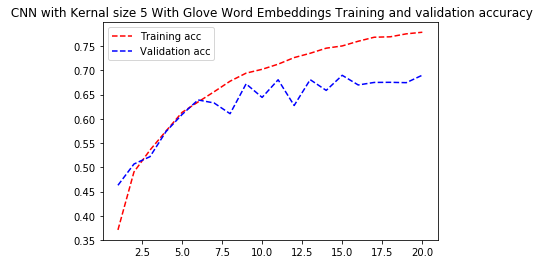

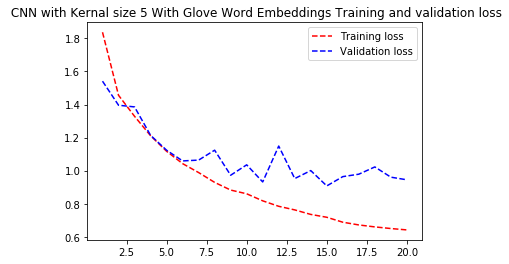

In [219]:
plothistory(  _kernel5_cnn, ' CNN with Kernal size 5 With Glove Word Embeddings')

In [220]:
evaluate_model('saved_models/weights.best.cnnkernel5_glovevectors.hdf5', x_val, y_val)

saved_models/weights.best.cnnkernel5_glovevectors.hdf5
acc: 68.97%
loss: 0.91%


#### Convolutional Neural Network 64 Filters

In [221]:
#build_cnn_with_glove_vectors(num_filters, kernel_size, pooling_num, dense_size, num_classes, dropout_level)
simple_cnn_64_model = build_simple_cnn_with_glove_vectors(64, 4, 2, 24, num_classes, 0.25)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 1000, 100)         852900    
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 997, 64)           25664     
_________________________________________________________________
dropout_12 (Dropout)         (None, 997, 64)           0         
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 498, 64)           0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 31872)             0         
_________________________________________________________________
dense_17 (Dense)             (None, 24)                764952    
__________

In [222]:
callbacks = setup_callbacks('saved_models/weights.best.cnnfilter64_glovevectors.hdf5', 5)

In [223]:
 _filters64_cnn = train_model(simple_cnn_64_model, x_train, y_train, x_val, y_val, callbacks, 50, batch_size)

Train on 16064 samples, validate on 4016 samples
Epoch 1/50


 3248/16064 [=====>........................] - ETA: 4:51 - loss: 2.5668 - acc: 0.125 - ETA: 3:23 - loss: 2.5110 - acc: 0.187 - ETA: 2:54 - loss: 2.4018 - acc: 0.250 - ETA: 2:47 - loss: 2.5539 - acc: 0.234 - ETA: 2:35 - loss: 2.4971 - acc: 0.237 - ETA: 2:26 - loss: 2.4784 - acc: 0.218 - ETA: 2:20 - loss: 2.4945 - acc: 0.187 - ETA: 2:16 - loss: 2.4781 - acc: 0.187 - ETA: 2:13 - loss: 2.4669 - acc: 0.187 - ETA: 2:10 - loss: 2.4644 - acc: 0.187 - ETA: 2:08 - loss: 2.4562 - acc: 0.193 - ETA: 2:06 - loss: 2.4490 - acc: 0.192 - ETA: 2:04 - loss: 2.4495 - acc: 0.192 - ETA: 2:03 - loss: 2.4470 - acc: 0.178 - ETA: 2:02 - loss: 2.4413 - acc: 0.175 - ETA: 2:01 - loss: 2.4329 - acc: 0.179 - ETA: 2:00 - loss: 2.4255 - acc: 0.191 - ETA: 1:59 - loss: 2.4237 - acc: 0.191 - ETA: 1:58 - loss: 2.4223 - acc: 0.194 - ETA: 1:58 - loss: 2.4123 - acc: 0.193 - ETA: 1:58 - loss: 2.4079 - acc: 0.190 - ETA: 1:57 - loss: 2.4026 - acc: 0.187 - ETA: 1:57 - loss: 2.3939 - acc: 0.195 - ETA: 1:56 - loss: 2.3916 - acc: 0

 9888/16064 [=================>............] - ETA: 1:07 - loss: 1.9826 - acc: 0.330 - ETA: 1:07 - loss: 1.9814 - acc: 0.330 - ETA: 1:07 - loss: 1.9805 - acc: 0.330 - ETA: 1:07 - loss: 1.9800 - acc: 0.330 - ETA: 1:07 - loss: 1.9788 - acc: 0.331 - ETA: 1:07 - loss: 1.9791 - acc: 0.331 - ETA: 1:07 - loss: 1.9781 - acc: 0.331 - ETA: 1:07 - loss: 1.9774 - acc: 0.331 - ETA: 1:06 - loss: 1.9769 - acc: 0.331 - ETA: 1:06 - loss: 1.9756 - acc: 0.332 - ETA: 1:06 - loss: 1.9739 - acc: 0.332 - ETA: 1:06 - loss: 1.9738 - acc: 0.332 - ETA: 1:06 - loss: 1.9739 - acc: 0.332 - ETA: 1:06 - loss: 1.9716 - acc: 0.333 - ETA: 1:06 - loss: 1.9717 - acc: 0.333 - ETA: 1:06 - loss: 1.9708 - acc: 0.333 - ETA: 1:06 - loss: 1.9698 - acc: 0.333 - ETA: 1:05 - loss: 1.9692 - acc: 0.333 - ETA: 1:05 - loss: 1.9683 - acc: 0.334 - ETA: 1:05 - loss: 1.9679 - acc: 0.334 - ETA: 1:05 - loss: 1.9675 - acc: 0.334 - ETA: 1:05 - loss: 1.9675 - acc: 0.334 - ETA: 1:05 - loss: 1.9657 - acc: 0.334 - ETA: 1:05 - loss: 1.9647 - acc: 0

13328/16064 [=======================>......] - ETA: 44s - loss: 1.8610 - acc: 0.36 - ETA: 44s - loss: 1.8610 - acc: 0.36 - ETA: 44s - loss: 1.8606 - acc: 0.36 - ETA: 44s - loss: 1.8601 - acc: 0.36 - ETA: 44s - loss: 1.8597 - acc: 0.36 - ETA: 43s - loss: 1.8597 - acc: 0.36 - ETA: 43s - loss: 1.8594 - acc: 0.36 - ETA: 43s - loss: 1.8604 - acc: 0.36 - ETA: 43s - loss: 1.8601 - acc: 0.36 - ETA: 43s - loss: 1.8596 - acc: 0.36 - ETA: 43s - loss: 1.8589 - acc: 0.36 - ETA: 43s - loss: 1.8585 - acc: 0.36 - ETA: 43s - loss: 1.8582 - acc: 0.36 - ETA: 43s - loss: 1.8577 - acc: 0.37 - ETA: 42s - loss: 1.8575 - acc: 0.37 - ETA: 42s - loss: 1.8577 - acc: 0.37 - ETA: 42s - loss: 1.8562 - acc: 0.37 - ETA: 42s - loss: 1.8556 - acc: 0.37 - ETA: 42s - loss: 1.8556 - acc: 0.37 - ETA: 42s - loss: 1.8549 - acc: 0.37 - ETA: 42s - loss: 1.8545 - acc: 0.37 - ETA: 42s - loss: 1.8537 - acc: 0.37 - ETA: 41s - loss: 1.8529 - acc: 0.37 - ETA: 41s - loss: 1.8525 - acc: 0.37 - ETA: 41s - loss: 1.8517 - acc: 0.37 - ETA

16064/16064 [==============================] - ETA: 19s - loss: 1.7894 - acc: 0.39 - ETA: 19s - loss: 1.7889 - acc: 0.39 - ETA: 19s - loss: 1.7879 - acc: 0.39 - ETA: 19s - loss: 1.7875 - acc: 0.39 - ETA: 19s - loss: 1.7873 - acc: 0.39 - ETA: 19s - loss: 1.7867 - acc: 0.39 - ETA: 19s - loss: 1.7859 - acc: 0.39 - ETA: 19s - loss: 1.7857 - acc: 0.39 - ETA: 18s - loss: 1.7848 - acc: 0.39 - ETA: 18s - loss: 1.7849 - acc: 0.39 - ETA: 18s - loss: 1.7848 - acc: 0.39 - ETA: 18s - loss: 1.7849 - acc: 0.39 - ETA: 18s - loss: 1.7843 - acc: 0.39 - ETA: 18s - loss: 1.7844 - acc: 0.39 - ETA: 18s - loss: 1.7837 - acc: 0.39 - ETA: 18s - loss: 1.7836 - acc: 0.39 - ETA: 17s - loss: 1.7832 - acc: 0.39 - ETA: 17s - loss: 1.7823 - acc: 0.39 - ETA: 17s - loss: 1.7827 - acc: 0.39 - ETA: 17s - loss: 1.7825 - acc: 0.39 - ETA: 17s - loss: 1.7825 - acc: 0.39 - ETA: 17s - loss: 1.7824 - acc: 0.39 - ETA: 17s - loss: 1.7821 - acc: 0.39 - ETA: 17s - loss: 1.7815 - acc: 0.39 - ETA: 17s - loss: 1.7815 - acc: 0.39 - ETA

 3264/16064 [=====>........................] - ETA: 2:04 - loss: 1.9095 - acc: 0.375 - ETA: 2:06 - loss: 1.7882 - acc: 0.312 - ETA: 2:05 - loss: 1.9535 - acc: 0.270 - ETA: 2:04 - loss: 1.7535 - acc: 0.375 - ETA: 2:01 - loss: 1.8225 - acc: 0.337 - ETA: 1:59 - loss: 1.8298 - acc: 0.343 - ETA: 1:57 - loss: 1.7263 - acc: 0.392 - ETA: 1:56 - loss: 1.6594 - acc: 0.429 - ETA: 1:55 - loss: 1.5900 - acc: 0.451 - ETA: 1:55 - loss: 1.5953 - acc: 0.443 - ETA: 1:54 - loss: 1.5695 - acc: 0.448 - ETA: 1:54 - loss: 1.5726 - acc: 0.442 - ETA: 1:53 - loss: 1.5424 - acc: 0.447 - ETA: 1:52 - loss: 1.5422 - acc: 0.446 - ETA: 1:52 - loss: 1.5267 - acc: 0.445 - ETA: 1:52 - loss: 1.5066 - acc: 0.453 - ETA: 1:52 - loss: 1.4766 - acc: 0.474 - ETA: 1:51 - loss: 1.4713 - acc: 0.468 - ETA: 1:51 - loss: 1.4825 - acc: 0.467 - ETA: 1:51 - loss: 1.4646 - acc: 0.475 - ETA: 1:51 - loss: 1.4605 - acc: 0.482 - ETA: 1:51 - loss: 1.4673 - acc: 0.480 - ETA: 1:50 - loss: 1.4574 - acc: 0.483 - ETA: 1:50 - loss: 1.4455 - acc: 0

 9904/16064 [=================>............] - ETA: 1:09 - loss: 1.3936 - acc: 0.505 - ETA: 1:09 - loss: 1.3921 - acc: 0.505 - ETA: 1:09 - loss: 1.3913 - acc: 0.505 - ETA: 1:09 - loss: 1.3923 - acc: 0.505 - ETA: 1:09 - loss: 1.3927 - acc: 0.505 - ETA: 1:08 - loss: 1.3920 - acc: 0.505 - ETA: 1:08 - loss: 1.3901 - acc: 0.505 - ETA: 1:08 - loss: 1.3896 - acc: 0.506 - ETA: 1:08 - loss: 1.3885 - acc: 0.506 - ETA: 1:08 - loss: 1.3879 - acc: 0.506 - ETA: 1:08 - loss: 1.3881 - acc: 0.506 - ETA: 1:08 - loss: 1.3880 - acc: 0.506 - ETA: 1:08 - loss: 1.3886 - acc: 0.506 - ETA: 1:07 - loss: 1.3878 - acc: 0.507 - ETA: 1:07 - loss: 1.3893 - acc: 0.506 - ETA: 1:07 - loss: 1.3879 - acc: 0.507 - ETA: 1:07 - loss: 1.3880 - acc: 0.507 - ETA: 1:07 - loss: 1.3889 - acc: 0.506 - ETA: 1:07 - loss: 1.3889 - acc: 0.506 - ETA: 1:07 - loss: 1.3883 - acc: 0.506 - ETA: 1:07 - loss: 1.3893 - acc: 0.506 - ETA: 1:07 - loss: 1.3890 - acc: 0.506 - ETA: 1:06 - loss: 1.3900 - acc: 0.506 - ETA: 1:06 - loss: 1.3897 - acc: 0

13344/16064 [=======================>......] - ETA: 44s - loss: 1.3705 - acc: 0.51 - ETA: 44s - loss: 1.3707 - acc: 0.51 - ETA: 44s - loss: 1.3706 - acc: 0.51 - ETA: 44s - loss: 1.3705 - acc: 0.51 - ETA: 44s - loss: 1.3703 - acc: 0.51 - ETA: 44s - loss: 1.3705 - acc: 0.51 - ETA: 44s - loss: 1.3713 - acc: 0.51 - ETA: 44s - loss: 1.3714 - acc: 0.51 - ETA: 44s - loss: 1.3719 - acc: 0.51 - ETA: 43s - loss: 1.3721 - acc: 0.51 - ETA: 43s - loss: 1.3725 - acc: 0.51 - ETA: 43s - loss: 1.3720 - acc: 0.51 - ETA: 43s - loss: 1.3721 - acc: 0.51 - ETA: 43s - loss: 1.3727 - acc: 0.51 - ETA: 43s - loss: 1.3731 - acc: 0.51 - ETA: 43s - loss: 1.3733 - acc: 0.51 - ETA: 43s - loss: 1.3731 - acc: 0.51 - ETA: 42s - loss: 1.3734 - acc: 0.51 - ETA: 42s - loss: 1.3731 - acc: 0.51 - ETA: 42s - loss: 1.3735 - acc: 0.51 - ETA: 42s - loss: 1.3738 - acc: 0.51 - ETA: 42s - loss: 1.3738 - acc: 0.51 - ETA: 42s - loss: 1.3742 - acc: 0.51 - ETA: 42s - loss: 1.3748 - acc: 0.51 - ETA: 42s - loss: 1.3754 - acc: 0.51 - ETA

16064/16064 [==============================] - ETA: 19s - loss: 1.3597 - acc: 0.51 - ETA: 19s - loss: 1.3606 - acc: 0.51 - ETA: 19s - loss: 1.3604 - acc: 0.51 - ETA: 19s - loss: 1.3603 - acc: 0.51 - ETA: 19s - loss: 1.3601 - acc: 0.51 - ETA: 19s - loss: 1.3602 - acc: 0.51 - ETA: 19s - loss: 1.3604 - acc: 0.51 - ETA: 18s - loss: 1.3605 - acc: 0.51 - ETA: 18s - loss: 1.3604 - acc: 0.51 - ETA: 18s - loss: 1.3609 - acc: 0.51 - ETA: 18s - loss: 1.3610 - acc: 0.51 - ETA: 18s - loss: 1.3608 - acc: 0.51 - ETA: 18s - loss: 1.3600 - acc: 0.51 - ETA: 18s - loss: 1.3595 - acc: 0.51 - ETA: 18s - loss: 1.3601 - acc: 0.51 - ETA: 18s - loss: 1.3595 - acc: 0.51 - ETA: 17s - loss: 1.3596 - acc: 0.51 - ETA: 17s - loss: 1.3594 - acc: 0.51 - ETA: 17s - loss: 1.3591 - acc: 0.51 - ETA: 17s - loss: 1.3582 - acc: 0.51 - ETA: 17s - loss: 1.3582 - acc: 0.51 - ETA: 17s - loss: 1.3579 - acc: 0.51 - ETA: 17s - loss: 1.3579 - acc: 0.51 - ETA: 17s - loss: 1.3580 - acc: 0.51 - ETA: 16s - loss: 1.3582 - acc: 0.51 - ETA

 3264/16064 [=====>........................] - ETA: 2:14 - loss: 1.0324 - acc: 0.500 - ETA: 1:59 - loss: 0.8705 - acc: 0.625 - ETA: 1:56 - loss: 1.0289 - acc: 0.625 - ETA: 1:53 - loss: 1.0321 - acc: 0.609 - ETA: 1:52 - loss: 1.0685 - acc: 0.612 - ETA: 1:52 - loss: 1.1520 - acc: 0.572 - ETA: 1:52 - loss: 1.1096 - acc: 0.589 - ETA: 1:52 - loss: 1.1310 - acc: 0.562 - ETA: 1:52 - loss: 1.1443 - acc: 0.562 - ETA: 1:51 - loss: 1.1812 - acc: 0.550 - ETA: 1:51 - loss: 1.1415 - acc: 0.568 - ETA: 1:50 - loss: 1.1235 - acc: 0.583 - ETA: 1:51 - loss: 1.0910 - acc: 0.596 - ETA: 1:52 - loss: 1.0857 - acc: 0.598 - ETA: 1:52 - loss: 1.1055 - acc: 0.583 - ETA: 1:52 - loss: 1.0891 - acc: 0.585 - ETA: 1:52 - loss: 1.0951 - acc: 0.580 - ETA: 1:52 - loss: 1.0920 - acc: 0.586 - ETA: 1:52 - loss: 1.0900 - acc: 0.592 - ETA: 1:52 - loss: 1.0928 - acc: 0.590 - ETA: 1:52 - loss: 1.1025 - acc: 0.583 - ETA: 1:52 - loss: 1.1010 - acc: 0.582 - ETA: 1:52 - loss: 1.1032 - acc: 0.581 - ETA: 1:53 - loss: 1.0992 - acc: 0

 9888/16064 [=================>............] - ETA: 1:10 - loss: 1.1250 - acc: 0.593 - ETA: 1:10 - loss: 1.1258 - acc: 0.593 - ETA: 1:10 - loss: 1.1261 - acc: 0.593 - ETA: 1:10 - loss: 1.1255 - acc: 0.593 - ETA: 1:10 - loss: 1.1262 - acc: 0.593 - ETA: 1:10 - loss: 1.1263 - acc: 0.593 - ETA: 1:09 - loss: 1.1273 - acc: 0.593 - ETA: 1:09 - loss: 1.1277 - acc: 0.593 - ETA: 1:09 - loss: 1.1265 - acc: 0.593 - ETA: 1:09 - loss: 1.1263 - acc: 0.593 - ETA: 1:09 - loss: 1.1261 - acc: 0.594 - ETA: 1:09 - loss: 1.1263 - acc: 0.593 - ETA: 1:09 - loss: 1.1265 - acc: 0.593 - ETA: 1:09 - loss: 1.1264 - acc: 0.593 - ETA: 1:09 - loss: 1.1268 - acc: 0.594 - ETA: 1:08 - loss: 1.1262 - acc: 0.594 - ETA: 1:08 - loss: 1.1259 - acc: 0.594 - ETA: 1:08 - loss: 1.1262 - acc: 0.593 - ETA: 1:08 - loss: 1.1267 - acc: 0.593 - ETA: 1:08 - loss: 1.1268 - acc: 0.593 - ETA: 1:08 - loss: 1.1266 - acc: 0.594 - ETA: 1:08 - loss: 1.1269 - acc: 0.593 - ETA: 1:08 - loss: 1.1263 - acc: 0.594 - ETA: 1:07 - loss: 1.1264 - acc: 0

13328/16064 [=======================>......] - ETA: 45s - loss: 1.1250 - acc: 0.59 - ETA: 45s - loss: 1.1254 - acc: 0.59 - ETA: 45s - loss: 1.1259 - acc: 0.59 - ETA: 45s - loss: 1.1255 - acc: 0.59 - ETA: 45s - loss: 1.1262 - acc: 0.59 - ETA: 45s - loss: 1.1267 - acc: 0.59 - ETA: 45s - loss: 1.1271 - acc: 0.59 - ETA: 45s - loss: 1.1276 - acc: 0.59 - ETA: 44s - loss: 1.1275 - acc: 0.59 - ETA: 44s - loss: 1.1277 - acc: 0.59 - ETA: 44s - loss: 1.1283 - acc: 0.59 - ETA: 44s - loss: 1.1281 - acc: 0.59 - ETA: 44s - loss: 1.1280 - acc: 0.59 - ETA: 44s - loss: 1.1278 - acc: 0.59 - ETA: 44s - loss: 1.1276 - acc: 0.59 - ETA: 44s - loss: 1.1277 - acc: 0.59 - ETA: 43s - loss: 1.1274 - acc: 0.59 - ETA: 43s - loss: 1.1275 - acc: 0.59 - ETA: 43s - loss: 1.1283 - acc: 0.59 - ETA: 43s - loss: 1.1280 - acc: 0.59 - ETA: 43s - loss: 1.1281 - acc: 0.59 - ETA: 43s - loss: 1.1277 - acc: 0.59 - ETA: 43s - loss: 1.1275 - acc: 0.59 - ETA: 43s - loss: 1.1277 - acc: 0.59 - ETA: 42s - loss: 1.1275 - acc: 0.59 - ETA

16064/16064 [==============================] - ETA: 20s - loss: 1.1399 - acc: 0.59 - ETA: 20s - loss: 1.1398 - acc: 0.59 - ETA: 19s - loss: 1.1396 - acc: 0.59 - ETA: 19s - loss: 1.1399 - acc: 0.59 - ETA: 19s - loss: 1.1395 - acc: 0.59 - ETA: 19s - loss: 1.1395 - acc: 0.59 - ETA: 19s - loss: 1.1396 - acc: 0.59 - ETA: 19s - loss: 1.1397 - acc: 0.59 - ETA: 19s - loss: 1.1394 - acc: 0.59 - ETA: 19s - loss: 1.1391 - acc: 0.59 - ETA: 18s - loss: 1.1392 - acc: 0.59 - ETA: 18s - loss: 1.1390 - acc: 0.59 - ETA: 18s - loss: 1.1389 - acc: 0.59 - ETA: 18s - loss: 1.1389 - acc: 0.59 - ETA: 18s - loss: 1.1391 - acc: 0.59 - ETA: 18s - loss: 1.1397 - acc: 0.59 - ETA: 18s - loss: 1.1403 - acc: 0.59 - ETA: 18s - loss: 1.1400 - acc: 0.59 - ETA: 17s - loss: 1.1396 - acc: 0.59 - ETA: 17s - loss: 1.1394 - acc: 0.59 - ETA: 17s - loss: 1.1398 - acc: 0.59 - ETA: 17s - loss: 1.1402 - acc: 0.59 - ETA: 17s - loss: 1.1404 - acc: 0.59 - ETA: 17s - loss: 1.1403 - acc: 0.59 - ETA: 17s - loss: 1.1404 - acc: 0.59 - ETA

 3264/16064 [=====>........................] - ETA: 1:43 - loss: 0.9633 - acc: 0.687 - ETA: 1:47 - loss: 1.1396 - acc: 0.562 - ETA: 1:49 - loss: 1.0458 - acc: 0.583 - ETA: 1:49 - loss: 1.0674 - acc: 0.593 - ETA: 1:52 - loss: 1.0688 - acc: 0.575 - ETA: 1:54 - loss: 1.0524 - acc: 0.583 - ETA: 1:54 - loss: 1.0754 - acc: 0.589 - ETA: 1:53 - loss: 1.0636 - acc: 0.601 - ETA: 1:52 - loss: 1.0108 - acc: 0.631 - ETA: 1:52 - loss: 1.0019 - acc: 0.637 - ETA: 1:52 - loss: 0.9674 - acc: 0.653 - ETA: 1:52 - loss: 0.9587 - acc: 0.661 - ETA: 1:52 - loss: 0.9752 - acc: 0.653 - ETA: 1:51 - loss: 0.9613 - acc: 0.660 - ETA: 1:51 - loss: 0.9970 - acc: 0.641 - ETA: 1:52 - loss: 0.9991 - acc: 0.640 - ETA: 1:52 - loss: 0.9901 - acc: 0.643 - ETA: 1:52 - loss: 0.9825 - acc: 0.642 - ETA: 1:52 - loss: 0.9595 - acc: 0.651 - ETA: 1:51 - loss: 0.9799 - acc: 0.640 - ETA: 1:51 - loss: 0.9819 - acc: 0.636 - ETA: 1:51 - loss: 0.9926 - acc: 0.636 - ETA: 1:51 - loss: 0.9935 - acc: 0.641 - ETA: 1:51 - loss: 0.9863 - acc: 0

 9888/16064 [=================>............] - ETA: 1:09 - loss: 0.9739 - acc: 0.655 - ETA: 1:09 - loss: 0.9729 - acc: 0.655 - ETA: 1:09 - loss: 0.9730 - acc: 0.655 - ETA: 1:08 - loss: 0.9732 - acc: 0.655 - ETA: 1:08 - loss: 0.9736 - acc: 0.655 - ETA: 1:08 - loss: 0.9736 - acc: 0.655 - ETA: 1:08 - loss: 0.9727 - acc: 0.656 - ETA: 1:08 - loss: 0.9733 - acc: 0.656 - ETA: 1:08 - loss: 0.9734 - acc: 0.655 - ETA: 1:08 - loss: 0.9731 - acc: 0.656 - ETA: 1:08 - loss: 0.9723 - acc: 0.656 - ETA: 1:08 - loss: 0.9732 - acc: 0.656 - ETA: 1:07 - loss: 0.9733 - acc: 0.655 - ETA: 1:07 - loss: 0.9730 - acc: 0.655 - ETA: 1:07 - loss: 0.9731 - acc: 0.655 - ETA: 1:07 - loss: 0.9732 - acc: 0.655 - ETA: 1:07 - loss: 0.9737 - acc: 0.655 - ETA: 1:07 - loss: 0.9732 - acc: 0.655 - ETA: 1:07 - loss: 0.9732 - acc: 0.655 - ETA: 1:07 - loss: 0.9737 - acc: 0.654 - ETA: 1:07 - loss: 0.9737 - acc: 0.654 - ETA: 1:06 - loss: 0.9732 - acc: 0.655 - ETA: 1:06 - loss: 0.9734 - acc: 0.655 - ETA: 1:06 - loss: 0.9728 - acc: 0

13328/16064 [=======================>......] - ETA: 45s - loss: 0.9723 - acc: 0.65 - ETA: 44s - loss: 0.9717 - acc: 0.65 - ETA: 44s - loss: 0.9717 - acc: 0.65 - ETA: 44s - loss: 0.9714 - acc: 0.65 - ETA: 44s - loss: 0.9719 - acc: 0.65 - ETA: 44s - loss: 0.9734 - acc: 0.65 - ETA: 44s - loss: 0.9734 - acc: 0.65 - ETA: 44s - loss: 0.9728 - acc: 0.65 - ETA: 44s - loss: 0.9730 - acc: 0.65 - ETA: 43s - loss: 0.9735 - acc: 0.65 - ETA: 43s - loss: 0.9736 - acc: 0.65 - ETA: 43s - loss: 0.9737 - acc: 0.65 - ETA: 43s - loss: 0.9736 - acc: 0.65 - ETA: 43s - loss: 0.9744 - acc: 0.65 - ETA: 43s - loss: 0.9740 - acc: 0.65 - ETA: 43s - loss: 0.9735 - acc: 0.65 - ETA: 43s - loss: 0.9736 - acc: 0.65 - ETA: 43s - loss: 0.9736 - acc: 0.65 - ETA: 42s - loss: 0.9736 - acc: 0.65 - ETA: 42s - loss: 0.9728 - acc: 0.65 - ETA: 42s - loss: 0.9732 - acc: 0.65 - ETA: 42s - loss: 0.9728 - acc: 0.65 - ETA: 42s - loss: 0.9722 - acc: 0.65 - ETA: 42s - loss: 0.9719 - acc: 0.65 - ETA: 42s - loss: 0.9719 - acc: 0.65 - ETA

16064/16064 [==============================] - ETA: 19s - loss: 0.9764 - acc: 0.65 - ETA: 19s - loss: 0.9766 - acc: 0.65 - ETA: 19s - loss: 0.9769 - acc: 0.65 - ETA: 19s - loss: 0.9769 - acc: 0.65 - ETA: 19s - loss: 0.9769 - acc: 0.65 - ETA: 19s - loss: 0.9771 - acc: 0.65 - ETA: 19s - loss: 0.9773 - acc: 0.65 - ETA: 19s - loss: 0.9773 - acc: 0.65 - ETA: 18s - loss: 0.9781 - acc: 0.65 - ETA: 18s - loss: 0.9783 - acc: 0.65 - ETA: 18s - loss: 0.9781 - acc: 0.65 - ETA: 18s - loss: 0.9781 - acc: 0.65 - ETA: 18s - loss: 0.9784 - acc: 0.65 - ETA: 18s - loss: 0.9779 - acc: 0.65 - ETA: 18s - loss: 0.9775 - acc: 0.65 - ETA: 18s - loss: 0.9776 - acc: 0.65 - ETA: 17s - loss: 0.9781 - acc: 0.65 - ETA: 17s - loss: 0.9787 - acc: 0.65 - ETA: 17s - loss: 0.9788 - acc: 0.65 - ETA: 17s - loss: 0.9787 - acc: 0.65 - ETA: 17s - loss: 0.9789 - acc: 0.65 - ETA: 17s - loss: 0.9790 - acc: 0.65 - ETA: 17s - loss: 0.9795 - acc: 0.65 - ETA: 17s - loss: 0.9795 - acc: 0.65 - ETA: 17s - loss: 0.9796 - acc: 0.65 - ETA

 3264/16064 [=====>........................] - ETA: 2:02 - loss: 0.7899 - acc: 0.625 - ETA: 1:57 - loss: 0.8991 - acc: 0.625 - ETA: 1:56 - loss: 0.8145 - acc: 0.687 - ETA: 1:55 - loss: 0.8064 - acc: 0.703 - ETA: 1:54 - loss: 0.8250 - acc: 0.712 - ETA: 1:57 - loss: 0.8313 - acc: 0.697 - ETA: 1:58 - loss: 0.7695 - acc: 0.741 - ETA: 1:58 - loss: 0.7461 - acc: 0.757 - ETA: 1:59 - loss: 0.7603 - acc: 0.750 - ETA: 1:58 - loss: 0.7423 - acc: 0.768 - ETA: 1:59 - loss: 0.7387 - acc: 0.755 - ETA: 2:01 - loss: 0.7476 - acc: 0.750 - ETA: 2:01 - loss: 0.7450 - acc: 0.740 - ETA: 2:02 - loss: 0.7612 - acc: 0.732 - ETA: 2:02 - loss: 0.7718 - acc: 0.729 - ETA: 2:03 - loss: 0.7698 - acc: 0.730 - ETA: 2:03 - loss: 0.7539 - acc: 0.742 - ETA: 2:03 - loss: 0.7613 - acc: 0.732 - ETA: 2:02 - loss: 0.7498 - acc: 0.736 - ETA: 2:02 - loss: 0.7494 - acc: 0.737 - ETA: 2:01 - loss: 0.7476 - acc: 0.735 - ETA: 2:01 - loss: 0.7567 - acc: 0.733 - ETA: 2:01 - loss: 0.7559 - acc: 0.739 - ETA: 2:00 - loss: 0.7793 - acc: 0

 9904/16064 [=================>............] - ETA: 1:09 - loss: 0.7948 - acc: 0.712 - ETA: 1:09 - loss: 0.7947 - acc: 0.712 - ETA: 1:09 - loss: 0.7947 - acc: 0.712 - ETA: 1:09 - loss: 0.7946 - acc: 0.712 - ETA: 1:08 - loss: 0.7946 - acc: 0.712 - ETA: 1:08 - loss: 0.7943 - acc: 0.712 - ETA: 1:08 - loss: 0.7934 - acc: 0.712 - ETA: 1:08 - loss: 0.7932 - acc: 0.712 - ETA: 1:08 - loss: 0.7934 - acc: 0.712 - ETA: 1:08 - loss: 0.7928 - acc: 0.712 - ETA: 1:08 - loss: 0.7932 - acc: 0.713 - ETA: 1:08 - loss: 0.7933 - acc: 0.713 - ETA: 1:08 - loss: 0.7937 - acc: 0.713 - ETA: 1:07 - loss: 0.7935 - acc: 0.713 - ETA: 1:07 - loss: 0.7936 - acc: 0.713 - ETA: 1:07 - loss: 0.7940 - acc: 0.713 - ETA: 1:07 - loss: 0.7937 - acc: 0.713 - ETA: 1:07 - loss: 0.7942 - acc: 0.713 - ETA: 1:07 - loss: 0.7942 - acc: 0.713 - ETA: 1:07 - loss: 0.7952 - acc: 0.712 - ETA: 1:07 - loss: 0.7951 - acc: 0.712 - ETA: 1:06 - loss: 0.7952 - acc: 0.712 - ETA: 1:06 - loss: 0.7948 - acc: 0.712 - ETA: 1:06 - loss: 0.7945 - acc: 0

13344/16064 [=======================>......] - ETA: 44s - loss: 0.8106 - acc: 0.70 - ETA: 44s - loss: 0.8112 - acc: 0.70 - ETA: 44s - loss: 0.8112 - acc: 0.70 - ETA: 44s - loss: 0.8114 - acc: 0.70 - ETA: 44s - loss: 0.8114 - acc: 0.70 - ETA: 44s - loss: 0.8116 - acc: 0.70 - ETA: 44s - loss: 0.8124 - acc: 0.70 - ETA: 43s - loss: 0.8125 - acc: 0.70 - ETA: 43s - loss: 0.8128 - acc: 0.70 - ETA: 43s - loss: 0.8125 - acc: 0.70 - ETA: 43s - loss: 0.8130 - acc: 0.70 - ETA: 43s - loss: 0.8127 - acc: 0.70 - ETA: 43s - loss: 0.8124 - acc: 0.70 - ETA: 43s - loss: 0.8130 - acc: 0.70 - ETA: 43s - loss: 0.8127 - acc: 0.70 - ETA: 43s - loss: 0.8132 - acc: 0.70 - ETA: 42s - loss: 0.8137 - acc: 0.70 - ETA: 42s - loss: 0.8129 - acc: 0.70 - ETA: 42s - loss: 0.8129 - acc: 0.70 - ETA: 42s - loss: 0.8129 - acc: 0.70 - ETA: 42s - loss: 0.8127 - acc: 0.70 - ETA: 42s - loss: 0.8129 - acc: 0.70 - ETA: 42s - loss: 0.8134 - acc: 0.70 - ETA: 42s - loss: 0.8138 - acc: 0.70 - ETA: 42s - loss: 0.8139 - acc: 0.70 - ETA

16064/16064 [==============================] - ETA: 19s - loss: 0.8253 - acc: 0.70 - ETA: 19s - loss: 0.8251 - acc: 0.70 - ETA: 19s - loss: 0.8251 - acc: 0.70 - ETA: 19s - loss: 0.8250 - acc: 0.70 - ETA: 19s - loss: 0.8250 - acc: 0.70 - ETA: 19s - loss: 0.8248 - acc: 0.70 - ETA: 19s - loss: 0.8247 - acc: 0.70 - ETA: 18s - loss: 0.8257 - acc: 0.70 - ETA: 18s - loss: 0.8259 - acc: 0.70 - ETA: 18s - loss: 0.8258 - acc: 0.70 - ETA: 18s - loss: 0.8258 - acc: 0.70 - ETA: 18s - loss: 0.8266 - acc: 0.70 - ETA: 18s - loss: 0.8265 - acc: 0.70 - ETA: 18s - loss: 0.8266 - acc: 0.70 - ETA: 18s - loss: 0.8272 - acc: 0.70 - ETA: 17s - loss: 0.8275 - acc: 0.70 - ETA: 17s - loss: 0.8281 - acc: 0.70 - ETA: 17s - loss: 0.8282 - acc: 0.70 - ETA: 17s - loss: 0.8279 - acc: 0.70 - ETA: 17s - loss: 0.8285 - acc: 0.70 - ETA: 17s - loss: 0.8289 - acc: 0.70 - ETA: 17s - loss: 0.8294 - acc: 0.70 - ETA: 17s - loss: 0.8291 - acc: 0.70 - ETA: 17s - loss: 0.8289 - acc: 0.70 - ETA: 16s - loss: 0.8286 - acc: 0.70 - ETA

 3264/16064 [=====>........................] - ETA: 2:15 - loss: 0.5728 - acc: 0.750 - ETA: 2:07 - loss: 0.6810 - acc: 0.750 - ETA: 2:08 - loss: 0.8359 - acc: 0.708 - ETA: 2:07 - loss: 0.7829 - acc: 0.734 - ETA: 2:04 - loss: 0.7322 - acc: 0.750 - ETA: 2:07 - loss: 0.6697 - acc: 0.781 - ETA: 2:06 - loss: 0.6447 - acc: 0.803 - ETA: 2:05 - loss: 0.6036 - acc: 0.804 - ETA: 2:04 - loss: 0.6095 - acc: 0.812 - ETA: 2:03 - loss: 0.6126 - acc: 0.812 - ETA: 2:03 - loss: 0.6494 - acc: 0.795 - ETA: 2:02 - loss: 0.6301 - acc: 0.791 - ETA: 2:01 - loss: 0.6284 - acc: 0.793 - ETA: 2:02 - loss: 0.6380 - acc: 0.785 - ETA: 2:01 - loss: 0.6444 - acc: 0.783 - ETA: 2:01 - loss: 0.6551 - acc: 0.777 - ETA: 2:01 - loss: 0.6546 - acc: 0.775 - ETA: 2:01 - loss: 0.6499 - acc: 0.781 - ETA: 2:00 - loss: 0.6424 - acc: 0.786 - ETA: 2:00 - loss: 0.6375 - acc: 0.787 - ETA: 2:00 - loss: 0.6614 - acc: 0.779 - ETA: 2:00 - loss: 0.6490 - acc: 0.781 - ETA: 2:00 - loss: 0.6798 - acc: 0.766 - ETA: 2:00 - loss: 0.6801 - acc: 0

 9888/16064 [=================>............] - ETA: 1:09 - loss: 0.6500 - acc: 0.775 - ETA: 1:09 - loss: 0.6506 - acc: 0.774 - ETA: 1:09 - loss: 0.6503 - acc: 0.774 - ETA: 1:09 - loss: 0.6503 - acc: 0.774 - ETA: 1:09 - loss: 0.6503 - acc: 0.774 - ETA: 1:09 - loss: 0.6498 - acc: 0.774 - ETA: 1:09 - loss: 0.6503 - acc: 0.774 - ETA: 1:08 - loss: 0.6502 - acc: 0.774 - ETA: 1:08 - loss: 0.6497 - acc: 0.774 - ETA: 1:08 - loss: 0.6516 - acc: 0.773 - ETA: 1:08 - loss: 0.6511 - acc: 0.774 - ETA: 1:08 - loss: 0.6511 - acc: 0.774 - ETA: 1:08 - loss: 0.6507 - acc: 0.774 - ETA: 1:08 - loss: 0.6506 - acc: 0.774 - ETA: 1:08 - loss: 0.6506 - acc: 0.774 - ETA: 1:07 - loss: 0.6509 - acc: 0.773 - ETA: 1:07 - loss: 0.6508 - acc: 0.774 - ETA: 1:07 - loss: 0.6517 - acc: 0.773 - ETA: 1:07 - loss: 0.6510 - acc: 0.773 - ETA: 1:07 - loss: 0.6517 - acc: 0.773 - ETA: 1:07 - loss: 0.6517 - acc: 0.773 - ETA: 1:07 - loss: 0.6515 - acc: 0.774 - ETA: 1:07 - loss: 0.6516 - acc: 0.774 - ETA: 1:07 - loss: 0.6513 - acc: 0

13328/16064 [=======================>......] - ETA: 45s - loss: 0.6860 - acc: 0.75 - ETA: 44s - loss: 0.6856 - acc: 0.75 - ETA: 44s - loss: 0.6859 - acc: 0.75 - ETA: 44s - loss: 0.6853 - acc: 0.75 - ETA: 44s - loss: 0.6856 - acc: 0.75 - ETA: 44s - loss: 0.6853 - acc: 0.75 - ETA: 44s - loss: 0.6855 - acc: 0.75 - ETA: 44s - loss: 0.6855 - acc: 0.75 - ETA: 44s - loss: 0.6859 - acc: 0.75 - ETA: 43s - loss: 0.6863 - acc: 0.75 - ETA: 43s - loss: 0.6863 - acc: 0.75 - ETA: 43s - loss: 0.6862 - acc: 0.75 - ETA: 43s - loss: 0.6856 - acc: 0.75 - ETA: 43s - loss: 0.6853 - acc: 0.75 - ETA: 43s - loss: 0.6856 - acc: 0.75 - ETA: 43s - loss: 0.6859 - acc: 0.75 - ETA: 43s - loss: 0.6861 - acc: 0.75 - ETA: 43s - loss: 0.6867 - acc: 0.75 - ETA: 42s - loss: 0.6861 - acc: 0.75 - ETA: 42s - loss: 0.6864 - acc: 0.75 - ETA: 42s - loss: 0.6866 - acc: 0.75 - ETA: 42s - loss: 0.6864 - acc: 0.75 - ETA: 42s - loss: 0.6868 - acc: 0.75 - ETA: 42s - loss: 0.6870 - acc: 0.75 - ETA: 42s - loss: 0.6864 - acc: 0.75 - ETA

16064/16064 [==============================] - ETA: 19s - loss: 0.7019 - acc: 0.75 - ETA: 19s - loss: 0.7024 - acc: 0.75 - ETA: 19s - loss: 0.7022 - acc: 0.75 - ETA: 19s - loss: 0.7030 - acc: 0.75 - ETA: 19s - loss: 0.7031 - acc: 0.75 - ETA: 19s - loss: 0.7030 - acc: 0.75 - ETA: 19s - loss: 0.7026 - acc: 0.75 - ETA: 19s - loss: 0.7026 - acc: 0.75 - ETA: 18s - loss: 0.7027 - acc: 0.75 - ETA: 18s - loss: 0.7028 - acc: 0.75 - ETA: 18s - loss: 0.7029 - acc: 0.75 - ETA: 18s - loss: 0.7032 - acc: 0.75 - ETA: 18s - loss: 0.7035 - acc: 0.75 - ETA: 18s - loss: 0.7034 - acc: 0.75 - ETA: 18s - loss: 0.7036 - acc: 0.75 - ETA: 18s - loss: 0.7039 - acc: 0.75 - ETA: 17s - loss: 0.7039 - acc: 0.75 - ETA: 17s - loss: 0.7040 - acc: 0.75 - ETA: 17s - loss: 0.7043 - acc: 0.75 - ETA: 17s - loss: 0.7044 - acc: 0.75 - ETA: 17s - loss: 0.7040 - acc: 0.75 - ETA: 17s - loss: 0.7039 - acc: 0.75 - ETA: 17s - loss: 0.7037 - acc: 0.75 - ETA: 17s - loss: 0.7036 - acc: 0.75 - ETA: 17s - loss: 0.7035 - acc: 0.75 - ETA

 3264/16064 [=====>........................] - ETA: 2:03 - loss: 0.6398 - acc: 0.750 - ETA: 2:03 - loss: 0.5905 - acc: 0.750 - ETA: 2:00 - loss: 0.4944 - acc: 0.812 - ETA: 1:58 - loss: 0.4984 - acc: 0.828 - ETA: 1:56 - loss: 0.5445 - acc: 0.800 - ETA: 1:56 - loss: 0.5669 - acc: 0.770 - ETA: 1:58 - loss: 0.5693 - acc: 0.767 - ETA: 2:00 - loss: 0.5573 - acc: 0.789 - ETA: 2:00 - loss: 0.5432 - acc: 0.798 - ETA: 2:00 - loss: 0.5209 - acc: 0.818 - ETA: 2:00 - loss: 0.5327 - acc: 0.806 - ETA: 1:59 - loss: 0.5134 - acc: 0.817 - ETA: 2:00 - loss: 0.5213 - acc: 0.822 - ETA: 2:00 - loss: 0.5340 - acc: 0.821 - ETA: 1:59 - loss: 0.5398 - acc: 0.816 - ETA: 2:00 - loss: 0.5409 - acc: 0.824 - ETA: 2:00 - loss: 0.5468 - acc: 0.819 - ETA: 2:00 - loss: 0.5540 - acc: 0.819 - ETA: 1:59 - loss: 0.5520 - acc: 0.825 - ETA: 1:59 - loss: 0.5531 - acc: 0.828 - ETA: 1:59 - loss: 0.5485 - acc: 0.833 - ETA: 1:58 - loss: 0.5441 - acc: 0.835 - ETA: 1:58 - loss: 0.5480 - acc: 0.834 - ETA: 1:58 - loss: 0.5541 - acc: 0

 9888/16064 [=================>............] - ETA: 1:09 - loss: 0.5728 - acc: 0.797 - ETA: 1:09 - loss: 0.5728 - acc: 0.797 - ETA: 1:09 - loss: 0.5734 - acc: 0.797 - ETA: 1:09 - loss: 0.5733 - acc: 0.797 - ETA: 1:09 - loss: 0.5743 - acc: 0.797 - ETA: 1:09 - loss: 0.5745 - acc: 0.797 - ETA: 1:09 - loss: 0.5746 - acc: 0.797 - ETA: 1:09 - loss: 0.5743 - acc: 0.797 - ETA: 1:08 - loss: 0.5739 - acc: 0.797 - ETA: 1:08 - loss: 0.5739 - acc: 0.797 - ETA: 1:08 - loss: 0.5738 - acc: 0.797 - ETA: 1:08 - loss: 0.5741 - acc: 0.797 - ETA: 1:08 - loss: 0.5742 - acc: 0.797 - ETA: 1:08 - loss: 0.5747 - acc: 0.796 - ETA: 1:08 - loss: 0.5747 - acc: 0.796 - ETA: 1:08 - loss: 0.5765 - acc: 0.796 - ETA: 1:07 - loss: 0.5761 - acc: 0.796 - ETA: 1:07 - loss: 0.5755 - acc: 0.796 - ETA: 1:07 - loss: 0.5756 - acc: 0.796 - ETA: 1:07 - loss: 0.5756 - acc: 0.796 - ETA: 1:07 - loss: 0.5754 - acc: 0.796 - ETA: 1:07 - loss: 0.5750 - acc: 0.796 - ETA: 1:07 - loss: 0.5759 - acc: 0.796 - ETA: 1:07 - loss: 0.5754 - acc: 0

13328/16064 [=======================>......] - ETA: 44s - loss: 0.5875 - acc: 0.79 - ETA: 44s - loss: 0.5875 - acc: 0.79 - ETA: 44s - loss: 0.5871 - acc: 0.79 - ETA: 44s - loss: 0.5872 - acc: 0.79 - ETA: 44s - loss: 0.5869 - acc: 0.79 - ETA: 44s - loss: 0.5871 - acc: 0.79 - ETA: 44s - loss: 0.5870 - acc: 0.79 - ETA: 44s - loss: 0.5873 - acc: 0.79 - ETA: 44s - loss: 0.5876 - acc: 0.79 - ETA: 43s - loss: 0.5880 - acc: 0.79 - ETA: 43s - loss: 0.5877 - acc: 0.79 - ETA: 43s - loss: 0.5872 - acc: 0.79 - ETA: 43s - loss: 0.5870 - acc: 0.79 - ETA: 43s - loss: 0.5869 - acc: 0.79 - ETA: 43s - loss: 0.5869 - acc: 0.79 - ETA: 43s - loss: 0.5865 - acc: 0.79 - ETA: 43s - loss: 0.5873 - acc: 0.79 - ETA: 43s - loss: 0.5877 - acc: 0.79 - ETA: 42s - loss: 0.5877 - acc: 0.79 - ETA: 42s - loss: 0.5885 - acc: 0.79 - ETA: 42s - loss: 0.5880 - acc: 0.79 - ETA: 42s - loss: 0.5889 - acc: 0.79 - ETA: 42s - loss: 0.5888 - acc: 0.79 - ETA: 42s - loss: 0.5889 - acc: 0.79 - ETA: 42s - loss: 0.5887 - acc: 0.79 - ETA

16064/16064 [==============================] - ETA: 19s - loss: 0.6069 - acc: 0.78 - ETA: 19s - loss: 0.6074 - acc: 0.78 - ETA: 19s - loss: 0.6073 - acc: 0.78 - ETA: 19s - loss: 0.6075 - acc: 0.78 - ETA: 19s - loss: 0.6072 - acc: 0.78 - ETA: 19s - loss: 0.6074 - acc: 0.78 - ETA: 19s - loss: 0.6073 - acc: 0.78 - ETA: 19s - loss: 0.6076 - acc: 0.78 - ETA: 18s - loss: 0.6076 - acc: 0.78 - ETA: 18s - loss: 0.6080 - acc: 0.78 - ETA: 18s - loss: 0.6077 - acc: 0.78 - ETA: 18s - loss: 0.6072 - acc: 0.78 - ETA: 18s - loss: 0.6077 - acc: 0.78 - ETA: 18s - loss: 0.6084 - acc: 0.78 - ETA: 18s - loss: 0.6087 - acc: 0.78 - ETA: 18s - loss: 0.6084 - acc: 0.78 - ETA: 17s - loss: 0.6081 - acc: 0.78 - ETA: 17s - loss: 0.6084 - acc: 0.78 - ETA: 17s - loss: 0.6082 - acc: 0.78 - ETA: 17s - loss: 0.6083 - acc: 0.78 - ETA: 17s - loss: 0.6084 - acc: 0.78 - ETA: 17s - loss: 0.6081 - acc: 0.78 - ETA: 17s - loss: 0.6081 - acc: 0.78 - ETA: 17s - loss: 0.6079 - acc: 0.78 - ETA: 17s - loss: 0.6080 - acc: 0.78 - ETA

 3264/16064 [=====>........................] - ETA: 2:04 - loss: 0.4334 - acc: 0.937 - ETA: 2:02 - loss: 0.4389 - acc: 0.906 - ETA: 2:00 - loss: 0.6465 - acc: 0.750 - ETA: 1:59 - loss: 0.7052 - acc: 0.781 - ETA: 1:58 - loss: 0.6665 - acc: 0.787 - ETA: 1:57 - loss: 0.6730 - acc: 0.791 - ETA: 1:59 - loss: 0.6835 - acc: 0.767 - ETA: 1:59 - loss: 0.6324 - acc: 0.789 - ETA: 1:59 - loss: 0.6067 - acc: 0.798 - ETA: 1:58 - loss: 0.5800 - acc: 0.800 - ETA: 1:57 - loss: 0.5710 - acc: 0.795 - ETA: 1:57 - loss: 0.5562 - acc: 0.796 - ETA: 1:57 - loss: 0.5362 - acc: 0.807 - ETA: 1:56 - loss: 0.5450 - acc: 0.799 - ETA: 1:55 - loss: 0.5358 - acc: 0.800 - ETA: 1:55 - loss: 0.5293 - acc: 0.800 - ETA: 1:54 - loss: 0.5148 - acc: 0.805 - ETA: 1:54 - loss: 0.4987 - acc: 0.812 - ETA: 1:53 - loss: 0.5015 - acc: 0.812 - ETA: 1:53 - loss: 0.4994 - acc: 0.812 - ETA: 1:52 - loss: 0.4990 - acc: 0.812 - ETA: 1:52 - loss: 0.5034 - acc: 0.812 - ETA: 1:52 - loss: 0.5191 - acc: 0.807 - ETA: 1:51 - loss: 0.5133 - acc: 0

 9904/16064 [=================>............] - ETA: 1:09 - loss: 0.5212 - acc: 0.814 - ETA: 1:09 - loss: 0.5208 - acc: 0.814 - ETA: 1:09 - loss: 0.5212 - acc: 0.814 - ETA: 1:09 - loss: 0.5211 - acc: 0.814 - ETA: 1:08 - loss: 0.5211 - acc: 0.814 - ETA: 1:08 - loss: 0.5217 - acc: 0.814 - ETA: 1:08 - loss: 0.5221 - acc: 0.813 - ETA: 1:08 - loss: 0.5216 - acc: 0.814 - ETA: 1:08 - loss: 0.5223 - acc: 0.813 - ETA: 1:08 - loss: 0.5223 - acc: 0.813 - ETA: 1:08 - loss: 0.5218 - acc: 0.814 - ETA: 1:08 - loss: 0.5230 - acc: 0.813 - ETA: 1:08 - loss: 0.5238 - acc: 0.813 - ETA: 1:07 - loss: 0.5242 - acc: 0.812 - ETA: 1:07 - loss: 0.5248 - acc: 0.812 - ETA: 1:07 - loss: 0.5242 - acc: 0.812 - ETA: 1:07 - loss: 0.5245 - acc: 0.812 - ETA: 1:07 - loss: 0.5253 - acc: 0.812 - ETA: 1:07 - loss: 0.5257 - acc: 0.812 - ETA: 1:07 - loss: 0.5259 - acc: 0.812 - ETA: 1:07 - loss: 0.5268 - acc: 0.811 - ETA: 1:06 - loss: 0.5272 - acc: 0.811 - ETA: 1:06 - loss: 0.5268 - acc: 0.812 - ETA: 1:06 - loss: 0.5278 - acc: 0

13344/16064 [=======================>......] - ETA: 44s - loss: 0.5387 - acc: 0.80 - ETA: 44s - loss: 0.5385 - acc: 0.80 - ETA: 44s - loss: 0.5388 - acc: 0.80 - ETA: 44s - loss: 0.5395 - acc: 0.80 - ETA: 44s - loss: 0.5395 - acc: 0.80 - ETA: 44s - loss: 0.5391 - acc: 0.80 - ETA: 44s - loss: 0.5395 - acc: 0.80 - ETA: 44s - loss: 0.5398 - acc: 0.80 - ETA: 43s - loss: 0.5397 - acc: 0.80 - ETA: 43s - loss: 0.5402 - acc: 0.80 - ETA: 43s - loss: 0.5403 - acc: 0.80 - ETA: 43s - loss: 0.5402 - acc: 0.80 - ETA: 43s - loss: 0.5400 - acc: 0.80 - ETA: 43s - loss: 0.5396 - acc: 0.80 - ETA: 43s - loss: 0.5396 - acc: 0.80 - ETA: 43s - loss: 0.5395 - acc: 0.80 - ETA: 42s - loss: 0.5399 - acc: 0.80 - ETA: 42s - loss: 0.5399 - acc: 0.80 - ETA: 42s - loss: 0.5403 - acc: 0.80 - ETA: 42s - loss: 0.5403 - acc: 0.80 - ETA: 42s - loss: 0.5399 - acc: 0.80 - ETA: 42s - loss: 0.5402 - acc: 0.80 - ETA: 42s - loss: 0.5398 - acc: 0.80 - ETA: 42s - loss: 0.5396 - acc: 0.80 - ETA: 41s - loss: 0.5391 - acc: 0.80 - ETA

16064/16064 [==============================] - ETA: 19s - loss: 0.5411 - acc: 0.80 - ETA: 19s - loss: 0.5415 - acc: 0.80 - ETA: 19s - loss: 0.5412 - acc: 0.80 - ETA: 19s - loss: 0.5414 - acc: 0.80 - ETA: 19s - loss: 0.5419 - acc: 0.80 - ETA: 19s - loss: 0.5420 - acc: 0.80 - ETA: 19s - loss: 0.5419 - acc: 0.80 - ETA: 18s - loss: 0.5416 - acc: 0.80 - ETA: 18s - loss: 0.5420 - acc: 0.80 - ETA: 18s - loss: 0.5415 - acc: 0.80 - ETA: 18s - loss: 0.5415 - acc: 0.80 - ETA: 18s - loss: 0.5416 - acc: 0.80 - ETA: 18s - loss: 0.5420 - acc: 0.80 - ETA: 18s - loss: 0.5426 - acc: 0.80 - ETA: 18s - loss: 0.5424 - acc: 0.80 - ETA: 18s - loss: 0.5422 - acc: 0.80 - ETA: 17s - loss: 0.5422 - acc: 0.80 - ETA: 17s - loss: 0.5427 - acc: 0.80 - ETA: 17s - loss: 0.5425 - acc: 0.80 - ETA: 17s - loss: 0.5423 - acc: 0.80 - ETA: 17s - loss: 0.5421 - acc: 0.80 - ETA: 17s - loss: 0.5419 - acc: 0.80 - ETA: 17s - loss: 0.5419 - acc: 0.80 - ETA: 17s - loss: 0.5417 - acc: 0.80 - ETA: 16s - loss: 0.5417 - acc: 0.80 - ETA

 3264/16064 [=====>........................] - ETA: 2:14 - loss: 0.7180 - acc: 0.750 - ETA: 2:10 - loss: 0.6159 - acc: 0.812 - ETA: 2:06 - loss: 0.5002 - acc: 0.833 - ETA: 2:03 - loss: 0.4676 - acc: 0.859 - ETA: 2:01 - loss: 0.4963 - acc: 0.850 - ETA: 2:01 - loss: 0.4961 - acc: 0.854 - ETA: 2:02 - loss: 0.5047 - acc: 0.830 - ETA: 2:02 - loss: 0.4830 - acc: 0.835 - ETA: 2:00 - loss: 0.4788 - acc: 0.826 - ETA: 1:58 - loss: 0.4795 - acc: 0.825 - ETA: 1:58 - loss: 0.4513 - acc: 0.840 - ETA: 1:56 - loss: 0.4630 - acc: 0.838 - ETA: 1:56 - loss: 0.4503 - acc: 0.836 - ETA: 1:55 - loss: 0.4561 - acc: 0.834 - ETA: 1:55 - loss: 0.4535 - acc: 0.833 - ETA: 1:54 - loss: 0.4706 - acc: 0.832 - ETA: 1:54 - loss: 0.4864 - acc: 0.827 - ETA: 1:53 - loss: 0.4982 - acc: 0.833 - ETA: 1:53 - loss: 0.4952 - acc: 0.835 - ETA: 1:53 - loss: 0.5047 - acc: 0.834 - ETA: 1:53 - loss: 0.4975 - acc: 0.836 - ETA: 1:53 - loss: 0.4900 - acc: 0.838 - ETA: 1:52 - loss: 0.4787 - acc: 0.839 - ETA: 1:52 - loss: 0.4809 - acc: 0

 9888/16064 [=================>............] - ETA: 1:09 - loss: 0.4484 - acc: 0.843 - ETA: 1:09 - loss: 0.4481 - acc: 0.843 - ETA: 1:09 - loss: 0.4485 - acc: 0.842 - ETA: 1:09 - loss: 0.4485 - acc: 0.842 - ETA: 1:09 - loss: 0.4478 - acc: 0.843 - ETA: 1:09 - loss: 0.4476 - acc: 0.843 - ETA: 1:09 - loss: 0.4486 - acc: 0.843 - ETA: 1:08 - loss: 0.4490 - acc: 0.843 - ETA: 1:08 - loss: 0.4495 - acc: 0.842 - ETA: 1:08 - loss: 0.4495 - acc: 0.842 - ETA: 1:08 - loss: 0.4497 - acc: 0.842 - ETA: 1:08 - loss: 0.4498 - acc: 0.842 - ETA: 1:08 - loss: 0.4510 - acc: 0.842 - ETA: 1:08 - loss: 0.4520 - acc: 0.842 - ETA: 1:08 - loss: 0.4517 - acc: 0.842 - ETA: 1:08 - loss: 0.4510 - acc: 0.842 - ETA: 1:07 - loss: 0.4512 - acc: 0.842 - ETA: 1:07 - loss: 0.4506 - acc: 0.842 - ETA: 1:07 - loss: 0.4505 - acc: 0.842 - ETA: 1:07 - loss: 0.4518 - acc: 0.842 - ETA: 1:07 - loss: 0.4515 - acc: 0.842 - ETA: 1:07 - loss: 0.4516 - acc: 0.842 - ETA: 1:07 - loss: 0.4515 - acc: 0.842 - ETA: 1:07 - loss: 0.4514 - acc: 0

13328/16064 [=======================>......] - ETA: 45s - loss: 0.4620 - acc: 0.83 - ETA: 44s - loss: 0.4624 - acc: 0.83 - ETA: 44s - loss: 0.4623 - acc: 0.83 - ETA: 44s - loss: 0.4631 - acc: 0.83 - ETA: 44s - loss: 0.4636 - acc: 0.83 - ETA: 44s - loss: 0.4642 - acc: 0.83 - ETA: 44s - loss: 0.4643 - acc: 0.83 - ETA: 44s - loss: 0.4645 - acc: 0.83 - ETA: 44s - loss: 0.4644 - acc: 0.83 - ETA: 43s - loss: 0.4645 - acc: 0.83 - ETA: 43s - loss: 0.4647 - acc: 0.83 - ETA: 43s - loss: 0.4646 - acc: 0.83 - ETA: 43s - loss: 0.4646 - acc: 0.83 - ETA: 43s - loss: 0.4644 - acc: 0.83 - ETA: 43s - loss: 0.4644 - acc: 0.83 - ETA: 43s - loss: 0.4652 - acc: 0.83 - ETA: 43s - loss: 0.4656 - acc: 0.83 - ETA: 43s - loss: 0.4659 - acc: 0.83 - ETA: 42s - loss: 0.4657 - acc: 0.83 - ETA: 42s - loss: 0.4656 - acc: 0.83 - ETA: 42s - loss: 0.4654 - acc: 0.83 - ETA: 42s - loss: 0.4659 - acc: 0.83 - ETA: 42s - loss: 0.4660 - acc: 0.83 - ETA: 42s - loss: 0.4664 - acc: 0.83 - ETA: 42s - loss: 0.4660 - acc: 0.83 - ETA

16064/16064 [==============================] - ETA: 19s - loss: 0.4757 - acc: 0.82 - ETA: 19s - loss: 0.4756 - acc: 0.82 - ETA: 19s - loss: 0.4758 - acc: 0.82 - ETA: 19s - loss: 0.4758 - acc: 0.82 - ETA: 19s - loss: 0.4758 - acc: 0.82 - ETA: 19s - loss: 0.4760 - acc: 0.82 - ETA: 19s - loss: 0.4764 - acc: 0.82 - ETA: 19s - loss: 0.4767 - acc: 0.82 - ETA: 18s - loss: 0.4766 - acc: 0.82 - ETA: 18s - loss: 0.4766 - acc: 0.82 - ETA: 18s - loss: 0.4769 - acc: 0.82 - ETA: 18s - loss: 0.4771 - acc: 0.82 - ETA: 18s - loss: 0.4770 - acc: 0.82 - ETA: 18s - loss: 0.4768 - acc: 0.82 - ETA: 18s - loss: 0.4771 - acc: 0.82 - ETA: 18s - loss: 0.4771 - acc: 0.82 - ETA: 18s - loss: 0.4772 - acc: 0.82 - ETA: 17s - loss: 0.4768 - acc: 0.82 - ETA: 17s - loss: 0.4766 - acc: 0.82 - ETA: 17s - loss: 0.4766 - acc: 0.82 - ETA: 17s - loss: 0.4766 - acc: 0.82 - ETA: 17s - loss: 0.4765 - acc: 0.82 - ETA: 17s - loss: 0.4761 - acc: 0.82 - ETA: 17s - loss: 0.4760 - acc: 0.82 - ETA: 17s - loss: 0.4760 - acc: 0.82 - ETA

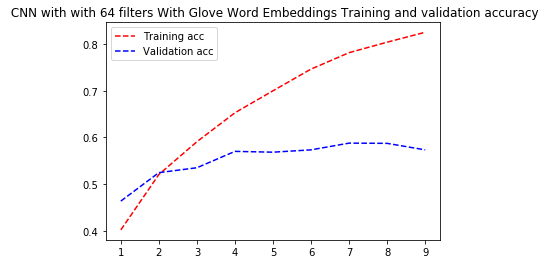

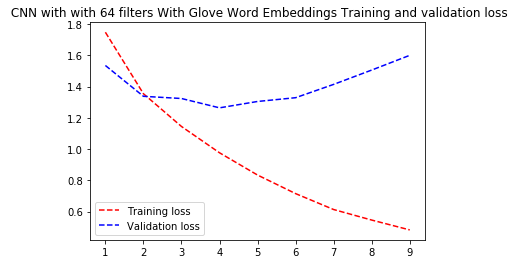

In [224]:
plothistory(   _filters64_cnn, ' CNN with with 64 filters With Glove Word Embeddings')

In [225]:
evaluate_model('saved_models/weights.best.cnnfilter64_glovevectors.hdf5', x_val, y_val)

saved_models/weights.best.cnnfilter64_glovevectors.hdf5
acc: 57.00%
loss: 1.26%


### Convolutional Neural Network Window Size 3

In [226]:
#build_cnn_with_glove_vectors(num_filters, kernel_size, pooling_num, dense_size, num_classes, dropout_level)
simple_cnn_3_model = build_simple_cnn_with_glove_vectors(32, 3, 2, 24, num_classes, 0.25)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 1000, 100)         852900    
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 998, 32)           9632      
_________________________________________________________________
dropout_13 (Dropout)         (None, 998, 32)           0         
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 499, 32)           0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 15968)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 24)                383256    
__________

In [227]:
callbacks = setup_callbacks('saved_models/weights.best.cnnfilter3_glovevectors.hdf5', 5)

In [228]:
_kernel3_cnn = train_model(simple_cnn_3_model, x_train, y_train, x_val, y_val, callbacks, 50, batch_size)

Train on 16064 samples, validate on 4016 samples
Epoch 1/50


 3360/16064 [=====>........................] - ETA: 4:25 - loss: 2.5964 - acc: 0.0000e+0 - ETA: 2:43 - loss: 2.4729 - acc: 0.1250    - ETA: 2:07 - loss: 2.5603 - acc: 0.145 - ETA: 1:48 - loss: 2.5087 - acc: 0.171 - ETA: 1:38 - loss: 2.4949 - acc: 0.162 - ETA: 1:30 - loss: 2.5197 - acc: 0.177 - ETA: 1:26 - loss: 2.4615 - acc: 0.205 - ETA: 1:24 - loss: 2.5014 - acc: 0.179 - ETA: 1:22 - loss: 2.5075 - acc: 0.180 - ETA: 1:19 - loss: 2.5092 - acc: 0.187 - ETA: 1:17 - loss: 2.4906 - acc: 0.187 - ETA: 1:15 - loss: 2.4849 - acc: 0.187 - ETA: 1:13 - loss: 2.4927 - acc: 0.177 - ETA: 1:12 - loss: 2.4903 - acc: 0.178 - ETA: 1:11 - loss: 2.4870 - acc: 0.179 - ETA: 1:10 - loss: 2.4935 - acc: 0.171 - ETA: 1:09 - loss: 2.4896 - acc: 0.165 - ETA: 1:08 - loss: 2.4725 - acc: 0.180 - ETA: 1:07 - loss: 2.4757 - acc: 0.174 - ETA: 1:07 - loss: 2.4665 - acc: 0.178 - ETA: 1:06 - loss: 2.4663 - acc: 0.175 - ETA: 1:05 - loss: 2.4662 - acc: 0.167 - ETA: 1:05 - loss: 2.4591 - acc: 0.165 - ETA: 1:04 - loss: 2.4547 

13680/16064 [========================>.....] - ETA: 21s - loss: 1.9779 - acc: 0.31 - ETA: 21s - loss: 1.9772 - acc: 0.31 - ETA: 21s - loss: 1.9765 - acc: 0.31 - ETA: 21s - loss: 1.9756 - acc: 0.31 - ETA: 21s - loss: 1.9751 - acc: 0.31 - ETA: 21s - loss: 1.9740 - acc: 0.31 - ETA: 21s - loss: 1.9739 - acc: 0.31 - ETA: 21s - loss: 1.9733 - acc: 0.31 - ETA: 21s - loss: 1.9728 - acc: 0.31 - ETA: 21s - loss: 1.9723 - acc: 0.31 - ETA: 20s - loss: 1.9719 - acc: 0.31 - ETA: 20s - loss: 1.9714 - acc: 0.31 - ETA: 20s - loss: 1.9709 - acc: 0.31 - ETA: 20s - loss: 1.9706 - acc: 0.31 - ETA: 20s - loss: 1.9693 - acc: 0.31 - ETA: 20s - loss: 1.9681 - acc: 0.31 - ETA: 20s - loss: 1.9677 - acc: 0.31 - ETA: 20s - loss: 1.9678 - acc: 0.31 - ETA: 20s - loss: 1.9671 - acc: 0.31 - ETA: 20s - loss: 1.9670 - acc: 0.31 - ETA: 20s - loss: 1.9663 - acc: 0.31 - ETA: 20s - loss: 1.9659 - acc: 0.31 - ETA: 20s - loss: 1.9661 - acc: 0.31 - ETA: 20s - loss: 1.9654 - acc: 0.31 - ETA: 20s - loss: 1.9657 - acc: 0.31 - ETA

16064/16064 [==============================] - ETA: 8s - loss: 1.8936 - acc: 0.338 - ETA: 8s - loss: 1.8929 - acc: 0.339 - ETA: 8s - loss: 1.8926 - acc: 0.339 - ETA: 8s - loss: 1.8924 - acc: 0.339 - ETA: 8s - loss: 1.8921 - acc: 0.339 - ETA: 8s - loss: 1.8919 - acc: 0.339 - ETA: 8s - loss: 1.8919 - acc: 0.339 - ETA: 8s - loss: 1.8918 - acc: 0.339 - ETA: 8s - loss: 1.8916 - acc: 0.340 - ETA: 8s - loss: 1.8909 - acc: 0.340 - ETA: 8s - loss: 1.8907 - acc: 0.340 - ETA: 8s - loss: 1.8905 - acc: 0.340 - ETA: 8s - loss: 1.8907 - acc: 0.340 - ETA: 8s - loss: 1.8903 - acc: 0.340 - ETA: 8s - loss: 1.8897 - acc: 0.340 - ETA: 7s - loss: 1.8894 - acc: 0.340 - ETA: 7s - loss: 1.8892 - acc: 0.340 - ETA: 7s - loss: 1.8888 - acc: 0.340 - ETA: 7s - loss: 1.8885 - acc: 0.341 - ETA: 7s - loss: 1.8885 - acc: 0.341 - ETA: 7s - loss: 1.8882 - acc: 0.341 - ETA: 7s - loss: 1.8888 - acc: 0.340 - ETA: 7s - loss: 1.8880 - acc: 0.341 - ETA: 7s - loss: 1.8875 - acc: 0.341 - ETA: 7s - loss: 1.8875 - acc: 0.341 - ETA

 3408/16064 [=====>........................] - ETA: 1:06 - loss: 1.5121 - acc: 0.500 - ETA: 1:04 - loss: 1.5774 - acc: 0.437 - ETA: 1:05 - loss: 1.4340 - acc: 0.458 - ETA: 1:04 - loss: 1.4888 - acc: 0.437 - ETA: 1:03 - loss: 1.5066 - acc: 0.437 - ETA: 1:02 - loss: 1.4683 - acc: 0.458 - ETA: 1:01 - loss: 1.4392 - acc: 0.455 - ETA: 1:01 - loss: 1.4413 - acc: 0.453 - ETA: 1:01 - loss: 1.4074 - acc: 0.472 - ETA: 1:01 - loss: 1.4556 - acc: 0.462 - ETA: 1:01 - loss: 1.4961 - acc: 0.448 - ETA: 1:01 - loss: 1.5155 - acc: 0.447 - ETA: 1:00 - loss: 1.4831 - acc: 0.456 - ETA: 1:01 - loss: 1.4738 - acc: 0.455 - ETA: 1:01 - loss: 1.4639 - acc: 0.450 - ETA: 1:01 - loss: 1.4714 - acc: 0.445 - ETA: 1:00 - loss: 1.4791 - acc: 0.441 - ETA: 1:01 - loss: 1.5018 - acc: 0.437 - ETA: 1:01 - loss: 1.5289 - acc: 0.440 - ETA: 1:01 - loss: 1.5380 - acc: 0.434 - ETA: 1:00 - loss: 1.5371 - acc: 0.440 - ETA: 1:00 - loss: 1.5423 - acc: 0.443 - ETA: 1:00 - loss: 1.5465 - acc: 0.440 - ETA: 1:00 - loss: 1.5183 - acc: 0

10288/16064 [==================>...........] - ETA: 35s - loss: 1.4336 - acc: 0.49 - ETA: 35s - loss: 1.4335 - acc: 0.49 - ETA: 35s - loss: 1.4337 - acc: 0.49 - ETA: 35s - loss: 1.4341 - acc: 0.49 - ETA: 35s - loss: 1.4332 - acc: 0.49 - ETA: 35s - loss: 1.4322 - acc: 0.49 - ETA: 34s - loss: 1.4322 - acc: 0.49 - ETA: 34s - loss: 1.4324 - acc: 0.49 - ETA: 34s - loss: 1.4316 - acc: 0.49 - ETA: 34s - loss: 1.4314 - acc: 0.49 - ETA: 34s - loss: 1.4301 - acc: 0.49 - ETA: 34s - loss: 1.4303 - acc: 0.49 - ETA: 34s - loss: 1.4301 - acc: 0.49 - ETA: 34s - loss: 1.4305 - acc: 0.49 - ETA: 34s - loss: 1.4302 - acc: 0.49 - ETA: 34s - loss: 1.4300 - acc: 0.49 - ETA: 34s - loss: 1.4296 - acc: 0.49 - ETA: 34s - loss: 1.4298 - acc: 0.49 - ETA: 34s - loss: 1.4302 - acc: 0.49 - ETA: 34s - loss: 1.4305 - acc: 0.49 - ETA: 34s - loss: 1.4301 - acc: 0.49 - ETA: 34s - loss: 1.4287 - acc: 0.49 - ETA: 34s - loss: 1.4278 - acc: 0.49 - ETA: 33s - loss: 1.4271 - acc: 0.49 - ETA: 33s - loss: 1.4265 - acc: 0.49 - ETA

13728/16064 [========================>.....] - ETA: 22s - loss: 1.4161 - acc: 0.50 - ETA: 22s - loss: 1.4158 - acc: 0.50 - ETA: 22s - loss: 1.4157 - acc: 0.50 - ETA: 22s - loss: 1.4159 - acc: 0.50 - ETA: 22s - loss: 1.4152 - acc: 0.50 - ETA: 21s - loss: 1.4151 - acc: 0.50 - ETA: 21s - loss: 1.4147 - acc: 0.50 - ETA: 21s - loss: 1.4152 - acc: 0.50 - ETA: 21s - loss: 1.4149 - acc: 0.50 - ETA: 21s - loss: 1.4143 - acc: 0.50 - ETA: 21s - loss: 1.4141 - acc: 0.50 - ETA: 21s - loss: 1.4140 - acc: 0.50 - ETA: 21s - loss: 1.4141 - acc: 0.50 - ETA: 21s - loss: 1.4140 - acc: 0.50 - ETA: 21s - loss: 1.4134 - acc: 0.50 - ETA: 21s - loss: 1.4136 - acc: 0.50 - ETA: 21s - loss: 1.4136 - acc: 0.50 - ETA: 21s - loss: 1.4137 - acc: 0.50 - ETA: 21s - loss: 1.4140 - acc: 0.50 - ETA: 21s - loss: 1.4145 - acc: 0.50 - ETA: 21s - loss: 1.4147 - acc: 0.50 - ETA: 20s - loss: 1.4146 - acc: 0.50 - ETA: 20s - loss: 1.4141 - acc: 0.50 - ETA: 20s - loss: 1.4142 - acc: 0.50 - ETA: 20s - loss: 1.4139 - acc: 0.50 - ETA

16064/16064 [==============================] - ETA: 8s - loss: 1.4082 - acc: 0.504 - ETA: 8s - loss: 1.4084 - acc: 0.503 - ETA: 8s - loss: 1.4086 - acc: 0.503 - ETA: 8s - loss: 1.4085 - acc: 0.503 - ETA: 8s - loss: 1.4083 - acc: 0.503 - ETA: 8s - loss: 1.4085 - acc: 0.503 - ETA: 8s - loss: 1.4086 - acc: 0.503 - ETA: 8s - loss: 1.4084 - acc: 0.503 - ETA: 8s - loss: 1.4087 - acc: 0.503 - ETA: 8s - loss: 1.4086 - acc: 0.503 - ETA: 8s - loss: 1.4082 - acc: 0.503 - ETA: 8s - loss: 1.4078 - acc: 0.504 - ETA: 8s - loss: 1.4079 - acc: 0.503 - ETA: 8s - loss: 1.4083 - acc: 0.503 - ETA: 8s - loss: 1.4089 - acc: 0.503 - ETA: 8s - loss: 1.4092 - acc: 0.503 - ETA: 7s - loss: 1.4092 - acc: 0.503 - ETA: 7s - loss: 1.4089 - acc: 0.503 - ETA: 7s - loss: 1.4085 - acc: 0.504 - ETA: 7s - loss: 1.4088 - acc: 0.503 - ETA: 7s - loss: 1.4093 - acc: 0.503 - ETA: 7s - loss: 1.4094 - acc: 0.503 - ETA: 7s - loss: 1.4093 - acc: 0.503 - ETA: 7s - loss: 1.4094 - acc: 0.503 - ETA: 7s - loss: 1.4094 - acc: 0.503 - ETA

 3440/16064 [=====>........................] - ETA: 58s - loss: 1.2434 - acc: 0.62 - ETA: 57s - loss: 1.2380 - acc: 0.62 - ETA: 57s - loss: 1.1692 - acc: 0.60 - ETA: 57s - loss: 1.1355 - acc: 0.59 - ETA: 58s - loss: 1.1434 - acc: 0.60 - ETA: 58s - loss: 1.1409 - acc: 0.60 - ETA: 58s - loss: 1.1235 - acc: 0.61 - ETA: 58s - loss: 1.0780 - acc: 0.64 - ETA: 59s - loss: 1.0671 - acc: 0.62 - ETA: 59s - loss: 1.0593 - acc: 0.62 - ETA: 59s - loss: 1.0728 - acc: 0.61 - ETA: 1:00 - loss: 1.0801 - acc: 0.604 - ETA: 1:00 - loss: 1.0454 - acc: 0.625 - ETA: 1:00 - loss: 1.0618 - acc: 0.620 - ETA: 1:00 - loss: 1.0535 - acc: 0.625 - ETA: 1:00 - loss: 1.0691 - acc: 0.621 - ETA: 1:00 - loss: 1.0702 - acc: 0.621 - ETA: 59s - loss: 1.1065 - acc: 0.611 - ETA: 59s - loss: 1.1149 - acc: 0.61 - ETA: 59s - loss: 1.1207 - acc: 0.61 - ETA: 59s - loss: 1.1234 - acc: 0.61 - ETA: 59s - loss: 1.1354 - acc: 0.60 - ETA: 59s - loss: 1.1542 - acc: 0.60 - ETA: 59s - loss: 1.1519 - acc: 0.60 - ETA: 59s - loss: 1.1533 - ac

10320/16064 [==================>...........] - ETA: 34s - loss: 1.2257 - acc: 0.56 - ETA: 34s - loss: 1.2249 - acc: 0.56 - ETA: 34s - loss: 1.2248 - acc: 0.56 - ETA: 34s - loss: 1.2256 - acc: 0.56 - ETA: 34s - loss: 1.2258 - acc: 0.56 - ETA: 34s - loss: 1.2251 - acc: 0.56 - ETA: 34s - loss: 1.2249 - acc: 0.56 - ETA: 34s - loss: 1.2266 - acc: 0.56 - ETA: 34s - loss: 1.2256 - acc: 0.56 - ETA: 34s - loss: 1.2253 - acc: 0.56 - ETA: 34s - loss: 1.2262 - acc: 0.56 - ETA: 34s - loss: 1.2272 - acc: 0.56 - ETA: 34s - loss: 1.2280 - acc: 0.56 - ETA: 34s - loss: 1.2286 - acc: 0.56 - ETA: 34s - loss: 1.2295 - acc: 0.55 - ETA: 34s - loss: 1.2291 - acc: 0.55 - ETA: 33s - loss: 1.2286 - acc: 0.56 - ETA: 33s - loss: 1.2298 - acc: 0.55 - ETA: 33s - loss: 1.2304 - acc: 0.55 - ETA: 33s - loss: 1.2301 - acc: 0.56 - ETA: 33s - loss: 1.2306 - acc: 0.55 - ETA: 33s - loss: 1.2307 - acc: 0.55 - ETA: 33s - loss: 1.2297 - acc: 0.55 - ETA: 33s - loss: 1.2292 - acc: 0.55 - ETA: 33s - loss: 1.2281 - acc: 0.56 - ETA

13760/16064 [========================>.....] - ETA: 21s - loss: 1.2250 - acc: 0.55 - ETA: 21s - loss: 1.2243 - acc: 0.55 - ETA: 21s - loss: 1.2237 - acc: 0.55 - ETA: 21s - loss: 1.2239 - acc: 0.55 - ETA: 21s - loss: 1.2240 - acc: 0.55 - ETA: 21s - loss: 1.2250 - acc: 0.55 - ETA: 21s - loss: 1.2254 - acc: 0.55 - ETA: 21s - loss: 1.2254 - acc: 0.55 - ETA: 21s - loss: 1.2250 - acc: 0.55 - ETA: 21s - loss: 1.2250 - acc: 0.55 - ETA: 21s - loss: 1.2250 - acc: 0.55 - ETA: 21s - loss: 1.2248 - acc: 0.55 - ETA: 21s - loss: 1.2256 - acc: 0.55 - ETA: 21s - loss: 1.2266 - acc: 0.55 - ETA: 21s - loss: 1.2262 - acc: 0.55 - ETA: 20s - loss: 1.2259 - acc: 0.55 - ETA: 20s - loss: 1.2264 - acc: 0.55 - ETA: 20s - loss: 1.2268 - acc: 0.55 - ETA: 20s - loss: 1.2266 - acc: 0.55 - ETA: 20s - loss: 1.2264 - acc: 0.55 - ETA: 20s - loss: 1.2260 - acc: 0.55 - ETA: 20s - loss: 1.2265 - acc: 0.55 - ETA: 20s - loss: 1.2266 - acc: 0.55 - ETA: 20s - loss: 1.2266 - acc: 0.55 - ETA: 20s - loss: 1.2268 - acc: 0.55 - ETA

16064/16064 [==============================] - ETA: 8s - loss: 1.2188 - acc: 0.561 - ETA: 8s - loss: 1.2183 - acc: 0.561 - ETA: 8s - loss: 1.2185 - acc: 0.561 - ETA: 8s - loss: 1.2186 - acc: 0.561 - ETA: 8s - loss: 1.2187 - acc: 0.561 - ETA: 8s - loss: 1.2186 - acc: 0.561 - ETA: 8s - loss: 1.2187 - acc: 0.561 - ETA: 8s - loss: 1.2193 - acc: 0.561 - ETA: 8s - loss: 1.2191 - acc: 0.561 - ETA: 8s - loss: 1.2191 - acc: 0.561 - ETA: 8s - loss: 1.2193 - acc: 0.560 - ETA: 8s - loss: 1.2195 - acc: 0.560 - ETA: 8s - loss: 1.2196 - acc: 0.561 - ETA: 7s - loss: 1.2194 - acc: 0.561 - ETA: 7s - loss: 1.2191 - acc: 0.561 - ETA: 7s - loss: 1.2192 - acc: 0.561 - ETA: 7s - loss: 1.2188 - acc: 0.561 - ETA: 7s - loss: 1.2188 - acc: 0.561 - ETA: 7s - loss: 1.2184 - acc: 0.561 - ETA: 7s - loss: 1.2188 - acc: 0.561 - ETA: 7s - loss: 1.2192 - acc: 0.561 - ETA: 7s - loss: 1.2192 - acc: 0.561 - ETA: 7s - loss: 1.2195 - acc: 0.561 - ETA: 7s - loss: 1.2195 - acc: 0.561 - ETA: 7s - loss: 1.2193 - acc: 0.561 - ETA

 3424/16064 [=====>........................] - ETA: 1:04 - loss: 0.5934 - acc: 0.750 - ETA: 59s - loss: 0.8765 - acc: 0.687 - ETA: 58s - loss: 1.0648 - acc: 0.58 - ETA: 58s - loss: 1.1467 - acc: 0.54 - ETA: 58s - loss: 1.1763 - acc: 0.55 - ETA: 58s - loss: 1.1850 - acc: 0.56 - ETA: 57s - loss: 1.1019 - acc: 0.58 - ETA: 58s - loss: 1.0493 - acc: 0.60 - ETA: 59s - loss: 1.0270 - acc: 0.61 - ETA: 59s - loss: 1.0408 - acc: 0.60 - ETA: 59s - loss: 1.0719 - acc: 0.59 - ETA: 59s - loss: 1.0750 - acc: 0.59 - ETA: 1:00 - loss: 1.0514 - acc: 0.605 - ETA: 1:00 - loss: 1.0477 - acc: 0.602 - ETA: 1:01 - loss: 1.0413 - acc: 0.604 - ETA: 1:00 - loss: 1.0302 - acc: 0.601 - ETA: 1:00 - loss: 1.0233 - acc: 0.599 - ETA: 1:00 - loss: 1.0209 - acc: 0.600 - ETA: 1:00 - loss: 1.0073 - acc: 0.605 - ETA: 1:00 - loss: 1.0208 - acc: 0.606 - ETA: 1:00 - loss: 1.0368 - acc: 0.598 - ETA: 1:00 - loss: 1.0440 - acc: 0.588 - ETA: 59s - loss: 1.0384 - acc: 0.595 - ETA: 59s - loss: 1.0322 - acc: 0.59 - ETA: 59s - loss: 

10304/16064 [==================>...........] - ETA: 35s - loss: 1.0783 - acc: 0.60 - ETA: 35s - loss: 1.0787 - acc: 0.60 - ETA: 35s - loss: 1.0790 - acc: 0.60 - ETA: 35s - loss: 1.0791 - acc: 0.60 - ETA: 35s - loss: 1.0793 - acc: 0.60 - ETA: 34s - loss: 1.0797 - acc: 0.60 - ETA: 34s - loss: 1.0798 - acc: 0.60 - ETA: 34s - loss: 1.0799 - acc: 0.60 - ETA: 34s - loss: 1.0805 - acc: 0.60 - ETA: 34s - loss: 1.0809 - acc: 0.60 - ETA: 34s - loss: 1.0818 - acc: 0.60 - ETA: 34s - loss: 1.0822 - acc: 0.60 - ETA: 34s - loss: 1.0823 - acc: 0.60 - ETA: 34s - loss: 1.0827 - acc: 0.60 - ETA: 34s - loss: 1.0831 - acc: 0.60 - ETA: 34s - loss: 1.0832 - acc: 0.60 - ETA: 34s - loss: 1.0834 - acc: 0.60 - ETA: 34s - loss: 1.0849 - acc: 0.60 - ETA: 34s - loss: 1.0858 - acc: 0.60 - ETA: 34s - loss: 1.0851 - acc: 0.60 - ETA: 34s - loss: 1.0864 - acc: 0.60 - ETA: 34s - loss: 1.0856 - acc: 0.60 - ETA: 33s - loss: 1.0856 - acc: 0.60 - ETA: 33s - loss: 1.0857 - acc: 0.60 - ETA: 33s - loss: 1.0860 - acc: 0.59 - ETA

13744/16064 [========================>.....] - ETA: 22s - loss: 1.0833 - acc: 0.60 - ETA: 21s - loss: 1.0832 - acc: 0.60 - ETA: 21s - loss: 1.0835 - acc: 0.60 - ETA: 21s - loss: 1.0833 - acc: 0.60 - ETA: 21s - loss: 1.0831 - acc: 0.60 - ETA: 21s - loss: 1.0835 - acc: 0.60 - ETA: 21s - loss: 1.0842 - acc: 0.60 - ETA: 21s - loss: 1.0845 - acc: 0.60 - ETA: 21s - loss: 1.0844 - acc: 0.60 - ETA: 21s - loss: 1.0845 - acc: 0.60 - ETA: 21s - loss: 1.0845 - acc: 0.60 - ETA: 21s - loss: 1.0847 - acc: 0.60 - ETA: 21s - loss: 1.0840 - acc: 0.60 - ETA: 21s - loss: 1.0834 - acc: 0.60 - ETA: 21s - loss: 1.0835 - acc: 0.60 - ETA: 21s - loss: 1.0832 - acc: 0.60 - ETA: 21s - loss: 1.0827 - acc: 0.60 - ETA: 20s - loss: 1.0828 - acc: 0.60 - ETA: 20s - loss: 1.0830 - acc: 0.60 - ETA: 20s - loss: 1.0827 - acc: 0.60 - ETA: 20s - loss: 1.0828 - acc: 0.60 - ETA: 20s - loss: 1.0831 - acc: 0.60 - ETA: 20s - loss: 1.0835 - acc: 0.60 - ETA: 20s - loss: 1.0836 - acc: 0.60 - ETA: 20s - loss: 1.0835 - acc: 0.60 - ETA

16064/16064 [==============================] - ETA: 8s - loss: 1.0931 - acc: 0.602 - ETA: 8s - loss: 1.0934 - acc: 0.602 - ETA: 8s - loss: 1.0936 - acc: 0.602 - ETA: 8s - loss: 1.0937 - acc: 0.602 - ETA: 8s - loss: 1.0938 - acc: 0.602 - ETA: 8s - loss: 1.0940 - acc: 0.602 - ETA: 8s - loss: 1.0939 - acc: 0.602 - ETA: 8s - loss: 1.0935 - acc: 0.602 - ETA: 8s - loss: 1.0936 - acc: 0.602 - ETA: 8s - loss: 1.0930 - acc: 0.602 - ETA: 8s - loss: 1.0933 - acc: 0.602 - ETA: 8s - loss: 1.0939 - acc: 0.602 - ETA: 8s - loss: 1.0949 - acc: 0.602 - ETA: 8s - loss: 1.0952 - acc: 0.601 - ETA: 7s - loss: 1.0950 - acc: 0.601 - ETA: 7s - loss: 1.0953 - acc: 0.601 - ETA: 7s - loss: 1.0950 - acc: 0.601 - ETA: 7s - loss: 1.0950 - acc: 0.601 - ETA: 7s - loss: 1.0952 - acc: 0.601 - ETA: 7s - loss: 1.0958 - acc: 0.601 - ETA: 7s - loss: 1.0958 - acc: 0.601 - ETA: 7s - loss: 1.0959 - acc: 0.601 - ETA: 7s - loss: 1.0958 - acc: 0.601 - ETA: 7s - loss: 1.0954 - acc: 0.601 - ETA: 7s - loss: 1.0953 - acc: 0.601 - ETA

 3440/16064 [=====>........................] - ETA: 57s - loss: 1.4508 - acc: 0.43 - ETA: 1:03 - loss: 1.2115 - acc: 0.531 - ETA: 1:00 - loss: 1.1947 - acc: 0.562 - ETA: 59s - loss: 1.1385 - acc: 0.625 - ETA: 58s - loss: 1.0924 - acc: 0.65 - ETA: 58s - loss: 1.0894 - acc: 0.62 - ETA: 58s - loss: 1.0480 - acc: 0.63 - ETA: 59s - loss: 1.0456 - acc: 0.64 - ETA: 58s - loss: 1.0208 - acc: 0.65 - ETA: 59s - loss: 1.0776 - acc: 0.62 - ETA: 59s - loss: 1.0809 - acc: 0.60 - ETA: 59s - loss: 1.0565 - acc: 0.61 - ETA: 1:00 - loss: 1.0105 - acc: 0.644 - ETA: 59s - loss: 0.9916 - acc: 0.647 - ETA: 59s - loss: 0.9943 - acc: 0.64 - ETA: 59s - loss: 0.9866 - acc: 0.64 - ETA: 59s - loss: 0.9819 - acc: 0.65 - ETA: 59s - loss: 0.9729 - acc: 0.65 - ETA: 59s - loss: 0.9893 - acc: 0.64 - ETA: 59s - loss: 0.9988 - acc: 0.63 - ETA: 59s - loss: 0.9828 - acc: 0.64 - ETA: 59s - loss: 0.9872 - acc: 0.64 - ETA: 59s - loss: 0.9662 - acc: 0.64 - ETA: 59s - loss: 0.9740 - acc: 0.64 - ETA: 59s - loss: 0.9703 - acc: 0.

10320/16064 [==================>...........] - ETA: 35s - loss: 0.9651 - acc: 0.65 - ETA: 34s - loss: 0.9651 - acc: 0.65 - ETA: 34s - loss: 0.9649 - acc: 0.65 - ETA: 34s - loss: 0.9658 - acc: 0.65 - ETA: 34s - loss: 0.9659 - acc: 0.65 - ETA: 34s - loss: 0.9646 - acc: 0.65 - ETA: 34s - loss: 0.9636 - acc: 0.65 - ETA: 34s - loss: 0.9632 - acc: 0.65 - ETA: 34s - loss: 0.9629 - acc: 0.65 - ETA: 34s - loss: 0.9629 - acc: 0.65 - ETA: 34s - loss: 0.9629 - acc: 0.65 - ETA: 34s - loss: 0.9623 - acc: 0.65 - ETA: 34s - loss: 0.9628 - acc: 0.65 - ETA: 34s - loss: 0.9624 - acc: 0.65 - ETA: 34s - loss: 0.9623 - acc: 0.65 - ETA: 34s - loss: 0.9627 - acc: 0.65 - ETA: 34s - loss: 0.9634 - acc: 0.65 - ETA: 33s - loss: 0.9631 - acc: 0.65 - ETA: 33s - loss: 0.9630 - acc: 0.65 - ETA: 33s - loss: 0.9628 - acc: 0.65 - ETA: 33s - loss: 0.9631 - acc: 0.65 - ETA: 33s - loss: 0.9632 - acc: 0.65 - ETA: 33s - loss: 0.9635 - acc: 0.65 - ETA: 33s - loss: 0.9628 - acc: 0.65 - ETA: 33s - loss: 0.9624 - acc: 0.65 - ETA

13760/16064 [========================>.....] - ETA: 21s - loss: 0.9789 - acc: 0.64 - ETA: 21s - loss: 0.9788 - acc: 0.64 - ETA: 21s - loss: 0.9788 - acc: 0.64 - ETA: 21s - loss: 0.9788 - acc: 0.64 - ETA: 21s - loss: 0.9789 - acc: 0.64 - ETA: 21s - loss: 0.9791 - acc: 0.64 - ETA: 21s - loss: 0.9788 - acc: 0.64 - ETA: 21s - loss: 0.9788 - acc: 0.64 - ETA: 21s - loss: 0.9798 - acc: 0.64 - ETA: 21s - loss: 0.9801 - acc: 0.64 - ETA: 21s - loss: 0.9802 - acc: 0.64 - ETA: 21s - loss: 0.9802 - acc: 0.64 - ETA: 21s - loss: 0.9811 - acc: 0.64 - ETA: 21s - loss: 0.9812 - acc: 0.64 - ETA: 21s - loss: 0.9814 - acc: 0.64 - ETA: 20s - loss: 0.9818 - acc: 0.64 - ETA: 20s - loss: 0.9820 - acc: 0.64 - ETA: 20s - loss: 0.9819 - acc: 0.64 - ETA: 20s - loss: 0.9818 - acc: 0.64 - ETA: 20s - loss: 0.9821 - acc: 0.64 - ETA: 20s - loss: 0.9822 - acc: 0.64 - ETA: 20s - loss: 0.9827 - acc: 0.64 - ETA: 20s - loss: 0.9827 - acc: 0.64 - ETA: 20s - loss: 0.9831 - acc: 0.64 - ETA: 20s - loss: 0.9825 - acc: 0.64 - ETA

16064/16064 [==============================] - ETA: 8s - loss: 0.9956 - acc: 0.640 - ETA: 8s - loss: 0.9956 - acc: 0.640 - ETA: 8s - loss: 0.9952 - acc: 0.640 - ETA: 8s - loss: 0.9954 - acc: 0.640 - ETA: 8s - loss: 0.9957 - acc: 0.640 - ETA: 8s - loss: 0.9957 - acc: 0.640 - ETA: 8s - loss: 0.9957 - acc: 0.640 - ETA: 8s - loss: 0.9957 - acc: 0.640 - ETA: 8s - loss: 0.9959 - acc: 0.640 - ETA: 8s - loss: 0.9958 - acc: 0.640 - ETA: 8s - loss: 0.9957 - acc: 0.640 - ETA: 8s - loss: 0.9960 - acc: 0.640 - ETA: 8s - loss: 0.9961 - acc: 0.640 - ETA: 7s - loss: 0.9957 - acc: 0.640 - ETA: 7s - loss: 0.9961 - acc: 0.640 - ETA: 7s - loss: 0.9965 - acc: 0.640 - ETA: 7s - loss: 0.9969 - acc: 0.640 - ETA: 7s - loss: 0.9972 - acc: 0.640 - ETA: 7s - loss: 0.9970 - acc: 0.640 - ETA: 7s - loss: 0.9975 - acc: 0.640 - ETA: 7s - loss: 0.9971 - acc: 0.640 - ETA: 7s - loss: 0.9973 - acc: 0.640 - ETA: 7s - loss: 0.9974 - acc: 0.640 - ETA: 7s - loss: 0.9974 - acc: 0.640 - ETA: 7s - loss: 0.9982 - acc: 0.640 - ETA

 3424/16064 [=====>........................] - ETA: 1:00 - loss: 0.7929 - acc: 0.812 - ETA: 58s - loss: 0.7422 - acc: 0.718 - ETA: 57s - loss: 0.9268 - acc: 0.64 - ETA: 57s - loss: 0.8569 - acc: 0.67 - ETA: 57s - loss: 0.8260 - acc: 0.67 - ETA: 57s - loss: 0.8929 - acc: 0.64 - ETA: 57s - loss: 0.8564 - acc: 0.66 - ETA: 57s - loss: 0.9053 - acc: 0.65 - ETA: 57s - loss: 0.9051 - acc: 0.66 - ETA: 58s - loss: 0.9088 - acc: 0.68 - ETA: 59s - loss: 0.9102 - acc: 0.68 - ETA: 59s - loss: 0.9025 - acc: 0.69 - ETA: 59s - loss: 0.8863 - acc: 0.69 - ETA: 1:00 - loss: 0.8770 - acc: 0.700 - ETA: 1:00 - loss: 0.8954 - acc: 0.679 - ETA: 1:00 - loss: 0.8955 - acc: 0.671 - ETA: 1:00 - loss: 0.8801 - acc: 0.676 - ETA: 1:00 - loss: 0.8938 - acc: 0.673 - ETA: 1:00 - loss: 0.8912 - acc: 0.674 - ETA: 59s - loss: 0.8796 - acc: 0.681 - ETA: 59s - loss: 0.9037 - acc: 0.67 - ETA: 59s - loss: 0.8910 - acc: 0.67 - ETA: 59s - loss: 0.8859 - acc: 0.67 - ETA: 59s - loss: 0.8836 - acc: 0.67 - ETA: 59s - loss: 0.8804 -

10304/16064 [==================>...........] - ETA: 35s - loss: 0.8802 - acc: 0.68 - ETA: 35s - loss: 0.8797 - acc: 0.68 - ETA: 35s - loss: 0.8790 - acc: 0.68 - ETA: 35s - loss: 0.8778 - acc: 0.68 - ETA: 35s - loss: 0.8784 - acc: 0.68 - ETA: 35s - loss: 0.8784 - acc: 0.68 - ETA: 34s - loss: 0.8783 - acc: 0.68 - ETA: 34s - loss: 0.8778 - acc: 0.68 - ETA: 34s - loss: 0.8784 - acc: 0.68 - ETA: 34s - loss: 0.8778 - acc: 0.68 - ETA: 34s - loss: 0.8777 - acc: 0.68 - ETA: 34s - loss: 0.8769 - acc: 0.68 - ETA: 34s - loss: 0.8766 - acc: 0.68 - ETA: 34s - loss: 0.8770 - acc: 0.68 - ETA: 34s - loss: 0.8770 - acc: 0.68 - ETA: 34s - loss: 0.8766 - acc: 0.68 - ETA: 34s - loss: 0.8766 - acc: 0.68 - ETA: 34s - loss: 0.8768 - acc: 0.68 - ETA: 34s - loss: 0.8765 - acc: 0.68 - ETA: 34s - loss: 0.8760 - acc: 0.68 - ETA: 34s - loss: 0.8755 - acc: 0.68 - ETA: 34s - loss: 0.8754 - acc: 0.68 - ETA: 33s - loss: 0.8761 - acc: 0.68 - ETA: 33s - loss: 0.8763 - acc: 0.68 - ETA: 33s - loss: 0.8760 - acc: 0.68 - ETA

13744/16064 [========================>.....] - ETA: 22s - loss: 0.8895 - acc: 0.68 - ETA: 22s - loss: 0.8892 - acc: 0.68 - ETA: 21s - loss: 0.8890 - acc: 0.68 - ETA: 21s - loss: 0.8892 - acc: 0.68 - ETA: 21s - loss: 0.8892 - acc: 0.68 - ETA: 21s - loss: 0.8896 - acc: 0.68 - ETA: 21s - loss: 0.8892 - acc: 0.68 - ETA: 21s - loss: 0.8897 - acc: 0.68 - ETA: 21s - loss: 0.8894 - acc: 0.68 - ETA: 21s - loss: 0.8895 - acc: 0.68 - ETA: 21s - loss: 0.8892 - acc: 0.68 - ETA: 21s - loss: 0.8899 - acc: 0.68 - ETA: 21s - loss: 0.8896 - acc: 0.68 - ETA: 21s - loss: 0.8898 - acc: 0.68 - ETA: 21s - loss: 0.8894 - acc: 0.68 - ETA: 21s - loss: 0.8897 - acc: 0.68 - ETA: 21s - loss: 0.8899 - acc: 0.68 - ETA: 21s - loss: 0.8899 - acc: 0.68 - ETA: 20s - loss: 0.8895 - acc: 0.68 - ETA: 20s - loss: 0.8894 - acc: 0.68 - ETA: 20s - loss: 0.8893 - acc: 0.68 - ETA: 20s - loss: 0.8894 - acc: 0.68 - ETA: 20s - loss: 0.8898 - acc: 0.68 - ETA: 20s - loss: 0.8904 - acc: 0.68 - ETA: 20s - loss: 0.8898 - acc: 0.68 - ETA

16064/16064 [==============================] - ETA: 8s - loss: 0.9078 - acc: 0.675 - ETA: 8s - loss: 0.9083 - acc: 0.675 - ETA: 8s - loss: 0.9082 - acc: 0.675 - ETA: 8s - loss: 0.9085 - acc: 0.675 - ETA: 8s - loss: 0.9086 - acc: 0.674 - ETA: 8s - loss: 0.9086 - acc: 0.675 - ETA: 8s - loss: 0.9088 - acc: 0.675 - ETA: 8s - loss: 0.9083 - acc: 0.675 - ETA: 8s - loss: 0.9083 - acc: 0.675 - ETA: 8s - loss: 0.9084 - acc: 0.675 - ETA: 8s - loss: 0.9082 - acc: 0.675 - ETA: 8s - loss: 0.9079 - acc: 0.675 - ETA: 8s - loss: 0.9081 - acc: 0.675 - ETA: 8s - loss: 0.9083 - acc: 0.675 - ETA: 8s - loss: 0.9087 - acc: 0.675 - ETA: 7s - loss: 0.9090 - acc: 0.675 - ETA: 7s - loss: 0.9090 - acc: 0.675 - ETA: 7s - loss: 0.9093 - acc: 0.675 - ETA: 7s - loss: 0.9091 - acc: 0.675 - ETA: 7s - loss: 0.9092 - acc: 0.675 - ETA: 7s - loss: 0.9092 - acc: 0.675 - ETA: 7s - loss: 0.9089 - acc: 0.675 - ETA: 7s - loss: 0.9088 - acc: 0.675 - ETA: 7s - loss: 0.9084 - acc: 0.675 - ETA: 7s - loss: 0.9084 - acc: 0.675 - ETA

 3408/16064 [=====>........................] - ETA: 1:00 - loss: 0.8514 - acc: 0.687 - ETA: 57s - loss: 1.0305 - acc: 0.656 - ETA: 56s - loss: 0.8235 - acc: 0.72 - ETA: 56s - loss: 0.8226 - acc: 0.70 - ETA: 57s - loss: 0.9316 - acc: 0.66 - ETA: 57s - loss: 0.9177 - acc: 0.66 - ETA: 58s - loss: 0.9185 - acc: 0.66 - ETA: 59s - loss: 0.8795 - acc: 0.69 - ETA: 59s - loss: 0.9254 - acc: 0.68 - ETA: 1:00 - loss: 0.9406 - acc: 0.675 - ETA: 1:00 - loss: 0.9439 - acc: 0.681 - ETA: 1:00 - loss: 0.9440 - acc: 0.677 - ETA: 1:00 - loss: 0.9101 - acc: 0.697 - ETA: 1:00 - loss: 0.9160 - acc: 0.692 - ETA: 1:00 - loss: 0.8994 - acc: 0.691 - ETA: 1:00 - loss: 0.8861 - acc: 0.695 - ETA: 1:00 - loss: 0.8701 - acc: 0.702 - ETA: 1:00 - loss: 0.8757 - acc: 0.701 - ETA: 1:00 - loss: 0.8556 - acc: 0.707 - ETA: 1:00 - loss: 0.8556 - acc: 0.703 - ETA: 1:00 - loss: 0.8607 - acc: 0.699 - ETA: 1:01 - loss: 0.8767 - acc: 0.690 - ETA: 1:01 - loss: 0.8842 - acc: 0.687 - ETA: 1:01 - loss: 0.8664 - acc: 0.695 - ETA: 1:0

10288/16064 [==================>...........] - ETA: 35s - loss: 0.8354 - acc: 0.69 - ETA: 35s - loss: 0.8359 - acc: 0.69 - ETA: 35s - loss: 0.8357 - acc: 0.69 - ETA: 34s - loss: 0.8357 - acc: 0.69 - ETA: 34s - loss: 0.8351 - acc: 0.69 - ETA: 34s - loss: 0.8351 - acc: 0.69 - ETA: 34s - loss: 0.8349 - acc: 0.69 - ETA: 34s - loss: 0.8351 - acc: 0.69 - ETA: 34s - loss: 0.8347 - acc: 0.69 - ETA: 34s - loss: 0.8353 - acc: 0.69 - ETA: 34s - loss: 0.8356 - acc: 0.69 - ETA: 34s - loss: 0.8372 - acc: 0.69 - ETA: 34s - loss: 0.8362 - acc: 0.69 - ETA: 34s - loss: 0.8357 - acc: 0.69 - ETA: 34s - loss: 0.8352 - acc: 0.69 - ETA: 34s - loss: 0.8354 - acc: 0.69 - ETA: 34s - loss: 0.8353 - acc: 0.69 - ETA: 34s - loss: 0.8345 - acc: 0.69 - ETA: 34s - loss: 0.8343 - acc: 0.69 - ETA: 34s - loss: 0.8339 - acc: 0.69 - ETA: 33s - loss: 0.8333 - acc: 0.69 - ETA: 33s - loss: 0.8342 - acc: 0.69 - ETA: 33s - loss: 0.8350 - acc: 0.69 - ETA: 33s - loss: 0.8353 - acc: 0.69 - ETA: 33s - loss: 0.8355 - acc: 0.69 - ETA

13728/16064 [========================>.....] - ETA: 21s - loss: 0.8494 - acc: 0.69 - ETA: 21s - loss: 0.8495 - acc: 0.69 - ETA: 21s - loss: 0.8491 - acc: 0.69 - ETA: 21s - loss: 0.8497 - acc: 0.69 - ETA: 21s - loss: 0.8500 - acc: 0.69 - ETA: 21s - loss: 0.8495 - acc: 0.69 - ETA: 21s - loss: 0.8494 - acc: 0.69 - ETA: 21s - loss: 0.8491 - acc: 0.69 - ETA: 21s - loss: 0.8495 - acc: 0.69 - ETA: 21s - loss: 0.8487 - acc: 0.69 - ETA: 21s - loss: 0.8485 - acc: 0.69 - ETA: 21s - loss: 0.8485 - acc: 0.69 - ETA: 21s - loss: 0.8481 - acc: 0.69 - ETA: 21s - loss: 0.8481 - acc: 0.69 - ETA: 21s - loss: 0.8480 - acc: 0.69 - ETA: 21s - loss: 0.8482 - acc: 0.69 - ETA: 21s - loss: 0.8482 - acc: 0.69 - ETA: 20s - loss: 0.8482 - acc: 0.69 - ETA: 20s - loss: 0.8480 - acc: 0.69 - ETA: 20s - loss: 0.8484 - acc: 0.69 - ETA: 20s - loss: 0.8487 - acc: 0.69 - ETA: 20s - loss: 0.8487 - acc: 0.69 - ETA: 20s - loss: 0.8482 - acc: 0.69 - ETA: 20s - loss: 0.8485 - acc: 0.69 - ETA: 20s - loss: 0.8479 - acc: 0.69 - ETA

16064/16064 [==============================] - ETA: 8s - loss: 0.8525 - acc: 0.691 - ETA: 8s - loss: 0.8530 - acc: 0.691 - ETA: 8s - loss: 0.8528 - acc: 0.691 - ETA: 8s - loss: 0.8527 - acc: 0.691 - ETA: 8s - loss: 0.8532 - acc: 0.691 - ETA: 8s - loss: 0.8530 - acc: 0.691 - ETA: 8s - loss: 0.8530 - acc: 0.691 - ETA: 8s - loss: 0.8535 - acc: 0.690 - ETA: 8s - loss: 0.8537 - acc: 0.690 - ETA: 8s - loss: 0.8533 - acc: 0.691 - ETA: 8s - loss: 0.8528 - acc: 0.691 - ETA: 8s - loss: 0.8527 - acc: 0.691 - ETA: 8s - loss: 0.8525 - acc: 0.691 - ETA: 8s - loss: 0.8524 - acc: 0.691 - ETA: 7s - loss: 0.8523 - acc: 0.691 - ETA: 7s - loss: 0.8521 - acc: 0.691 - ETA: 7s - loss: 0.8523 - acc: 0.691 - ETA: 7s - loss: 0.8525 - acc: 0.691 - ETA: 7s - loss: 0.8523 - acc: 0.691 - ETA: 7s - loss: 0.8524 - acc: 0.691 - ETA: 7s - loss: 0.8523 - acc: 0.691 - ETA: 7s - loss: 0.8528 - acc: 0.691 - ETA: 7s - loss: 0.8523 - acc: 0.691 - ETA: 7s - loss: 0.8520 - acc: 0.691 - ETA: 7s - loss: 0.8520 - acc: 0.691 - ETA

 3424/16064 [=====>........................] - ETA: 1:01 - loss: 1.0708 - acc: 0.625 - ETA: 1:02 - loss: 0.9766 - acc: 0.718 - ETA: 1:00 - loss: 0.7980 - acc: 0.708 - ETA: 59s - loss: 0.7348 - acc: 0.718 - ETA: 59s - loss: 0.7687 - acc: 0.72 - ETA: 1:00 - loss: 0.7221 - acc: 0.760 - ETA: 1:00 - loss: 0.6861 - acc: 0.767 - ETA: 1:00 - loss: 0.6830 - acc: 0.757 - ETA: 1:00 - loss: 0.6538 - acc: 0.756 - ETA: 1:00 - loss: 0.7109 - acc: 0.743 - ETA: 1:00 - loss: 0.7132 - acc: 0.744 - ETA: 1:00 - loss: 0.7274 - acc: 0.750 - ETA: 1:00 - loss: 0.7120 - acc: 0.759 - ETA: 1:00 - loss: 0.7369 - acc: 0.758 - ETA: 1:00 - loss: 0.7486 - acc: 0.758 - ETA: 1:00 - loss: 0.7498 - acc: 0.746 - ETA: 59s - loss: 0.7484 - acc: 0.746 - ETA: 59s - loss: 0.7446 - acc: 0.75 - ETA: 59s - loss: 0.7431 - acc: 0.75 - ETA: 59s - loss: 0.7342 - acc: 0.75 - ETA: 59s - loss: 0.7357 - acc: 0.75 - ETA: 59s - loss: 0.7244 - acc: 0.75 - ETA: 58s - loss: 0.7250 - acc: 0.75 - ETA: 58s - loss: 0.7210 - acc: 0.76 - ETA: 58s - 

10304/16064 [==================>...........] - ETA: 36s - loss: 0.7809 - acc: 0.71 - ETA: 36s - loss: 0.7815 - acc: 0.71 - ETA: 36s - loss: 0.7815 - acc: 0.71 - ETA: 36s - loss: 0.7810 - acc: 0.71 - ETA: 36s - loss: 0.7814 - acc: 0.71 - ETA: 36s - loss: 0.7809 - acc: 0.71 - ETA: 36s - loss: 0.7808 - acc: 0.71 - ETA: 36s - loss: 0.7808 - acc: 0.71 - ETA: 35s - loss: 0.7807 - acc: 0.71 - ETA: 35s - loss: 0.7803 - acc: 0.71 - ETA: 35s - loss: 0.7811 - acc: 0.71 - ETA: 35s - loss: 0.7806 - acc: 0.71 - ETA: 35s - loss: 0.7815 - acc: 0.71 - ETA: 35s - loss: 0.7815 - acc: 0.71 - ETA: 35s - loss: 0.7817 - acc: 0.71 - ETA: 35s - loss: 0.7807 - acc: 0.71 - ETA: 35s - loss: 0.7819 - acc: 0.71 - ETA: 35s - loss: 0.7817 - acc: 0.71 - ETA: 35s - loss: 0.7822 - acc: 0.71 - ETA: 35s - loss: 0.7815 - acc: 0.71 - ETA: 35s - loss: 0.7824 - acc: 0.71 - ETA: 35s - loss: 0.7826 - acc: 0.71 - ETA: 35s - loss: 0.7826 - acc: 0.71 - ETA: 34s - loss: 0.7822 - acc: 0.71 - ETA: 34s - loss: 0.7829 - acc: 0.71 - ETA

13744/16064 [========================>.....] - ETA: 22s - loss: 0.7847 - acc: 0.71 - ETA: 22s - loss: 0.7851 - acc: 0.71 - ETA: 22s - loss: 0.7848 - acc: 0.71 - ETA: 22s - loss: 0.7852 - acc: 0.71 - ETA: 22s - loss: 0.7870 - acc: 0.71 - ETA: 22s - loss: 0.7865 - acc: 0.71 - ETA: 22s - loss: 0.7867 - acc: 0.71 - ETA: 22s - loss: 0.7867 - acc: 0.71 - ETA: 22s - loss: 0.7863 - acc: 0.71 - ETA: 21s - loss: 0.7863 - acc: 0.71 - ETA: 21s - loss: 0.7864 - acc: 0.71 - ETA: 21s - loss: 0.7860 - acc: 0.71 - ETA: 21s - loss: 0.7859 - acc: 0.71 - ETA: 21s - loss: 0.7864 - acc: 0.71 - ETA: 21s - loss: 0.7865 - acc: 0.71 - ETA: 21s - loss: 0.7869 - acc: 0.71 - ETA: 21s - loss: 0.7870 - acc: 0.71 - ETA: 21s - loss: 0.7868 - acc: 0.71 - ETA: 21s - loss: 0.7866 - acc: 0.71 - ETA: 21s - loss: 0.7861 - acc: 0.71 - ETA: 21s - loss: 0.7865 - acc: 0.71 - ETA: 21s - loss: 0.7861 - acc: 0.71 - ETA: 21s - loss: 0.7863 - acc: 0.71 - ETA: 21s - loss: 0.7858 - acc: 0.72 - ETA: 21s - loss: 0.7862 - acc: 0.71 - ETA

16064/16064 [==============================] - ETA: 8s - loss: 0.7945 - acc: 0.717 - ETA: 8s - loss: 0.7947 - acc: 0.717 - ETA: 8s - loss: 0.7945 - acc: 0.717 - ETA: 8s - loss: 0.7944 - acc: 0.717 - ETA: 8s - loss: 0.7947 - acc: 0.717 - ETA: 8s - loss: 0.7948 - acc: 0.717 - ETA: 8s - loss: 0.7948 - acc: 0.717 - ETA: 8s - loss: 0.7946 - acc: 0.717 - ETA: 8s - loss: 0.7944 - acc: 0.717 - ETA: 8s - loss: 0.7942 - acc: 0.717 - ETA: 8s - loss: 0.7947 - acc: 0.717 - ETA: 8s - loss: 0.7952 - acc: 0.717 - ETA: 8s - loss: 0.7955 - acc: 0.717 - ETA: 8s - loss: 0.7950 - acc: 0.717 - ETA: 8s - loss: 0.7952 - acc: 0.717 - ETA: 8s - loss: 0.7951 - acc: 0.717 - ETA: 7s - loss: 0.7954 - acc: 0.717 - ETA: 7s - loss: 0.7950 - acc: 0.717 - ETA: 7s - loss: 0.7955 - acc: 0.717 - ETA: 7s - loss: 0.7953 - acc: 0.717 - ETA: 7s - loss: 0.7951 - acc: 0.717 - ETA: 7s - loss: 0.7956 - acc: 0.717 - ETA: 7s - loss: 0.7956 - acc: 0.717 - ETA: 7s - loss: 0.7952 - acc: 0.717 - ETA: 7s - loss: 0.7952 - acc: 0.717 - ETA

 3408/16064 [=====>........................] - ETA: 1:08 - loss: 0.3693 - acc: 0.875 - ETA: 1:08 - loss: 0.6763 - acc: 0.781 - ETA: 1:06 - loss: 0.6494 - acc: 0.791 - ETA: 1:05 - loss: 0.6437 - acc: 0.828 - ETA: 1:04 - loss: 0.6154 - acc: 0.825 - ETA: 1:03 - loss: 0.6004 - acc: 0.822 - ETA: 1:02 - loss: 0.5605 - acc: 0.830 - ETA: 1:02 - loss: 0.5489 - acc: 0.828 - ETA: 1:02 - loss: 0.5889 - acc: 0.812 - ETA: 1:01 - loss: 0.5775 - acc: 0.818 - ETA: 1:02 - loss: 0.5907 - acc: 0.812 - ETA: 1:02 - loss: 0.5810 - acc: 0.812 - ETA: 1:01 - loss: 0.5978 - acc: 0.802 - ETA: 1:01 - loss: 0.6174 - acc: 0.794 - ETA: 1:00 - loss: 0.6003 - acc: 0.804 - ETA: 1:00 - loss: 0.6106 - acc: 0.796 - ETA: 1:00 - loss: 0.6114 - acc: 0.794 - ETA: 1:00 - loss: 0.6129 - acc: 0.791 - ETA: 1:00 - loss: 0.6210 - acc: 0.779 - ETA: 1:00 - loss: 0.6213 - acc: 0.778 - ETA: 1:00 - loss: 0.6240 - acc: 0.779 - ETA: 1:00 - loss: 0.6182 - acc: 0.781 - ETA: 1:00 - loss: 0.6100 - acc: 0.785 - ETA: 1:00 - loss: 0.6265 - acc: 0

10288/16064 [==================>...........] - ETA: 35s - loss: 0.7147 - acc: 0.74 - ETA: 35s - loss: 0.7142 - acc: 0.74 - ETA: 34s - loss: 0.7144 - acc: 0.74 - ETA: 34s - loss: 0.7159 - acc: 0.74 - ETA: 34s - loss: 0.7158 - acc: 0.74 - ETA: 34s - loss: 0.7154 - acc: 0.74 - ETA: 34s - loss: 0.7155 - acc: 0.74 - ETA: 34s - loss: 0.7147 - acc: 0.75 - ETA: 34s - loss: 0.7146 - acc: 0.75 - ETA: 34s - loss: 0.7136 - acc: 0.75 - ETA: 34s - loss: 0.7130 - acc: 0.75 - ETA: 34s - loss: 0.7137 - acc: 0.75 - ETA: 34s - loss: 0.7139 - acc: 0.75 - ETA: 34s - loss: 0.7129 - acc: 0.75 - ETA: 34s - loss: 0.7124 - acc: 0.75 - ETA: 34s - loss: 0.7133 - acc: 0.75 - ETA: 34s - loss: 0.7132 - acc: 0.75 - ETA: 34s - loss: 0.7135 - acc: 0.75 - ETA: 34s - loss: 0.7135 - acc: 0.75 - ETA: 33s - loss: 0.7144 - acc: 0.75 - ETA: 33s - loss: 0.7149 - acc: 0.74 - ETA: 33s - loss: 0.7152 - acc: 0.74 - ETA: 33s - loss: 0.7145 - acc: 0.75 - ETA: 33s - loss: 0.7145 - acc: 0.75 - ETA: 33s - loss: 0.7139 - acc: 0.75 - ETA

13728/16064 [========================>.....] - ETA: 21s - loss: 0.7226 - acc: 0.75 - ETA: 21s - loss: 0.7219 - acc: 0.75 - ETA: 21s - loss: 0.7218 - acc: 0.75 - ETA: 21s - loss: 0.7224 - acc: 0.74 - ETA: 21s - loss: 0.7225 - acc: 0.74 - ETA: 21s - loss: 0.7229 - acc: 0.74 - ETA: 21s - loss: 0.7226 - acc: 0.74 - ETA: 21s - loss: 0.7220 - acc: 0.74 - ETA: 21s - loss: 0.7224 - acc: 0.74 - ETA: 21s - loss: 0.7220 - acc: 0.74 - ETA: 21s - loss: 0.7220 - acc: 0.74 - ETA: 21s - loss: 0.7219 - acc: 0.74 - ETA: 21s - loss: 0.7231 - acc: 0.74 - ETA: 21s - loss: 0.7227 - acc: 0.74 - ETA: 21s - loss: 0.7228 - acc: 0.74 - ETA: 21s - loss: 0.7225 - acc: 0.74 - ETA: 21s - loss: 0.7238 - acc: 0.74 - ETA: 20s - loss: 0.7234 - acc: 0.74 - ETA: 20s - loss: 0.7235 - acc: 0.74 - ETA: 20s - loss: 0.7241 - acc: 0.74 - ETA: 20s - loss: 0.7237 - acc: 0.74 - ETA: 20s - loss: 0.7234 - acc: 0.74 - ETA: 20s - loss: 0.7231 - acc: 0.74 - ETA: 20s - loss: 0.7236 - acc: 0.74 - ETA: 20s - loss: 0.7242 - acc: 0.74 - ETA

16064/16064 [==============================] - ETA: 8s - loss: 0.7288 - acc: 0.747 - ETA: 8s - loss: 0.7284 - acc: 0.747 - ETA: 8s - loss: 0.7283 - acc: 0.747 - ETA: 8s - loss: 0.7282 - acc: 0.747 - ETA: 8s - loss: 0.7277 - acc: 0.747 - ETA: 8s - loss: 0.7274 - acc: 0.748 - ETA: 8s - loss: 0.7280 - acc: 0.747 - ETA: 8s - loss: 0.7274 - acc: 0.748 - ETA: 8s - loss: 0.7280 - acc: 0.748 - ETA: 8s - loss: 0.7277 - acc: 0.748 - ETA: 8s - loss: 0.7279 - acc: 0.748 - ETA: 8s - loss: 0.7275 - acc: 0.748 - ETA: 8s - loss: 0.7271 - acc: 0.748 - ETA: 8s - loss: 0.7273 - acc: 0.748 - ETA: 8s - loss: 0.7272 - acc: 0.748 - ETA: 7s - loss: 0.7271 - acc: 0.748 - ETA: 7s - loss: 0.7269 - acc: 0.748 - ETA: 7s - loss: 0.7268 - acc: 0.748 - ETA: 7s - loss: 0.7270 - acc: 0.748 - ETA: 7s - loss: 0.7271 - acc: 0.748 - ETA: 7s - loss: 0.7274 - acc: 0.748 - ETA: 7s - loss: 0.7277 - acc: 0.748 - ETA: 7s - loss: 0.7275 - acc: 0.748 - ETA: 7s - loss: 0.7277 - acc: 0.748 - ETA: 7s - loss: 0.7283 - acc: 0.747 - ETA

 3440/16064 [=====>........................] - ETA: 59s - loss: 0.5081 - acc: 0.81 - ETA: 1:02 - loss: 0.5607 - acc: 0.812 - ETA: 1:01 - loss: 0.5953 - acc: 0.791 - ETA: 1:00 - loss: 0.5675 - acc: 0.812 - ETA: 59s - loss: 0.5920 - acc: 0.787 - ETA: 59s - loss: 0.6369 - acc: 0.78 - ETA: 58s - loss: 0.6981 - acc: 0.74 - ETA: 58s - loss: 0.6369 - acc: 0.77 - ETA: 58s - loss: 0.6432 - acc: 0.77 - ETA: 58s - loss: 0.6271 - acc: 0.78 - ETA: 58s - loss: 0.6591 - acc: 0.75 - ETA: 59s - loss: 0.6616 - acc: 0.76 - ETA: 59s - loss: 0.6916 - acc: 0.74 - ETA: 59s - loss: 0.6847 - acc: 0.75 - ETA: 59s - loss: 0.6683 - acc: 0.76 - ETA: 59s - loss: 0.6615 - acc: 0.76 - ETA: 59s - loss: 0.6467 - acc: 0.77 - ETA: 59s - loss: 0.6547 - acc: 0.77 - ETA: 59s - loss: 0.6502 - acc: 0.77 - ETA: 59s - loss: 0.6624 - acc: 0.76 - ETA: 59s - loss: 0.6605 - acc: 0.76 - ETA: 58s - loss: 0.6593 - acc: 0.76 - ETA: 58s - loss: 0.6530 - acc: 0.76 - ETA: 58s - loss: 0.6560 - acc: 0.76 - ETA: 58s - loss: 0.6601 - acc: 0.7

10320/16064 [==================>...........] - ETA: 35s - loss: 0.6727 - acc: 0.76 - ETA: 35s - loss: 0.6726 - acc: 0.76 - ETA: 35s - loss: 0.6728 - acc: 0.76 - ETA: 35s - loss: 0.6722 - acc: 0.76 - ETA: 34s - loss: 0.6723 - acc: 0.75 - ETA: 34s - loss: 0.6723 - acc: 0.75 - ETA: 34s - loss: 0.6723 - acc: 0.75 - ETA: 34s - loss: 0.6725 - acc: 0.75 - ETA: 34s - loss: 0.6723 - acc: 0.76 - ETA: 34s - loss: 0.6725 - acc: 0.75 - ETA: 34s - loss: 0.6725 - acc: 0.75 - ETA: 34s - loss: 0.6716 - acc: 0.76 - ETA: 34s - loss: 0.6718 - acc: 0.76 - ETA: 34s - loss: 0.6718 - acc: 0.75 - ETA: 34s - loss: 0.6718 - acc: 0.75 - ETA: 34s - loss: 0.6723 - acc: 0.75 - ETA: 34s - loss: 0.6723 - acc: 0.75 - ETA: 34s - loss: 0.6725 - acc: 0.75 - ETA: 34s - loss: 0.6731 - acc: 0.75 - ETA: 34s - loss: 0.6728 - acc: 0.75 - ETA: 33s - loss: 0.6733 - acc: 0.75 - ETA: 33s - loss: 0.6730 - acc: 0.75 - ETA: 33s - loss: 0.6724 - acc: 0.75 - ETA: 33s - loss: 0.6726 - acc: 0.75 - ETA: 33s - loss: 0.6722 - acc: 0.76 - ETA

13760/16064 [========================>.....] - ETA: 21s - loss: 0.6897 - acc: 0.75 - ETA: 21s - loss: 0.6895 - acc: 0.75 - ETA: 21s - loss: 0.6894 - acc: 0.75 - ETA: 21s - loss: 0.6897 - acc: 0.75 - ETA: 21s - loss: 0.6905 - acc: 0.75 - ETA: 21s - loss: 0.6907 - acc: 0.75 - ETA: 21s - loss: 0.6917 - acc: 0.75 - ETA: 21s - loss: 0.6916 - acc: 0.75 - ETA: 21s - loss: 0.6920 - acc: 0.75 - ETA: 21s - loss: 0.6921 - acc: 0.75 - ETA: 21s - loss: 0.6926 - acc: 0.75 - ETA: 21s - loss: 0.6925 - acc: 0.75 - ETA: 21s - loss: 0.6931 - acc: 0.75 - ETA: 21s - loss: 0.6927 - acc: 0.75 - ETA: 21s - loss: 0.6929 - acc: 0.75 - ETA: 21s - loss: 0.6938 - acc: 0.75 - ETA: 20s - loss: 0.6937 - acc: 0.75 - ETA: 20s - loss: 0.6934 - acc: 0.75 - ETA: 20s - loss: 0.6933 - acc: 0.75 - ETA: 20s - loss: 0.6933 - acc: 0.75 - ETA: 20s - loss: 0.6933 - acc: 0.75 - ETA: 20s - loss: 0.6931 - acc: 0.75 - ETA: 20s - loss: 0.6926 - acc: 0.75 - ETA: 20s - loss: 0.6929 - acc: 0.75 - ETA: 20s - loss: 0.6937 - acc: 0.75 - ETA

16064/16064 [==============================] - ETA: 8s - loss: 0.6997 - acc: 0.753 - ETA: 8s - loss: 0.7001 - acc: 0.753 - ETA: 8s - loss: 0.7000 - acc: 0.753 - ETA: 8s - loss: 0.7000 - acc: 0.753 - ETA: 8s - loss: 0.6999 - acc: 0.753 - ETA: 8s - loss: 0.6999 - acc: 0.753 - ETA: 8s - loss: 0.7003 - acc: 0.753 - ETA: 8s - loss: 0.7002 - acc: 0.753 - ETA: 8s - loss: 0.7004 - acc: 0.753 - ETA: 8s - loss: 0.7002 - acc: 0.753 - ETA: 8s - loss: 0.7003 - acc: 0.753 - ETA: 8s - loss: 0.7003 - acc: 0.753 - ETA: 8s - loss: 0.7009 - acc: 0.753 - ETA: 7s - loss: 0.7009 - acc: 0.753 - ETA: 7s - loss: 0.7009 - acc: 0.753 - ETA: 7s - loss: 0.7018 - acc: 0.753 - ETA: 7s - loss: 0.7021 - acc: 0.752 - ETA: 7s - loss: 0.7020 - acc: 0.753 - ETA: 7s - loss: 0.7020 - acc: 0.752 - ETA: 7s - loss: 0.7019 - acc: 0.752 - ETA: 7s - loss: 0.7017 - acc: 0.753 - ETA: 7s - loss: 0.7019 - acc: 0.753 - ETA: 7s - loss: 0.7021 - acc: 0.753 - ETA: 7s - loss: 0.7023 - acc: 0.753 - ETA: 7s - loss: 0.7019 - acc: 0.753 - ETA

 3424/16064 [=====>........................] - ETA: 56s - loss: 0.3574 - acc: 0.87 - ETA: 1:01 - loss: 0.4477 - acc: 0.812 - ETA: 1:00 - loss: 0.5502 - acc: 0.729 - ETA: 1:00 - loss: 0.6747 - acc: 0.671 - ETA: 1:00 - loss: 0.6574 - acc: 0.700 - ETA: 1:00 - loss: 0.5936 - acc: 0.729 - ETA: 59s - loss: 0.5822 - acc: 0.732 - ETA: 59s - loss: 0.6108 - acc: 0.72 - ETA: 59s - loss: 0.6451 - acc: 0.72 - ETA: 59s - loss: 0.6360 - acc: 0.72 - ETA: 59s - loss: 0.5978 - acc: 0.74 - ETA: 59s - loss: 0.6079 - acc: 0.73 - ETA: 59s - loss: 0.5916 - acc: 0.75 - ETA: 59s - loss: 0.5655 - acc: 0.77 - ETA: 59s - loss: 0.5579 - acc: 0.77 - ETA: 59s - loss: 0.5573 - acc: 0.78 - ETA: 59s - loss: 0.5647 - acc: 0.77 - ETA: 1:00 - loss: 0.5486 - acc: 0.784 - ETA: 1:00 - loss: 0.5269 - acc: 0.796 - ETA: 1:00 - loss: 0.5345 - acc: 0.793 - ETA: 59s - loss: 0.5384 - acc: 0.788 - ETA: 59s - loss: 0.5565 - acc: 0.78 - ETA: 1:00 - loss: 0.5565 - acc: 0.782 - ETA: 1:00 - loss: 0.5583 - acc: 0.781 - ETA: 1:00 - loss: 0

10304/16064 [==================>...........] - ETA: 34s - loss: 0.6099 - acc: 0.78 - ETA: 34s - loss: 0.6102 - acc: 0.78 - ETA: 34s - loss: 0.6095 - acc: 0.78 - ETA: 34s - loss: 0.6096 - acc: 0.78 - ETA: 34s - loss: 0.6093 - acc: 0.78 - ETA: 34s - loss: 0.6091 - acc: 0.78 - ETA: 34s - loss: 0.6090 - acc: 0.78 - ETA: 34s - loss: 0.6090 - acc: 0.78 - ETA: 34s - loss: 0.6100 - acc: 0.78 - ETA: 34s - loss: 0.6113 - acc: 0.78 - ETA: 34s - loss: 0.6109 - acc: 0.78 - ETA: 34s - loss: 0.6115 - acc: 0.78 - ETA: 34s - loss: 0.6113 - acc: 0.78 - ETA: 34s - loss: 0.6112 - acc: 0.78 - ETA: 34s - loss: 0.6117 - acc: 0.78 - ETA: 34s - loss: 0.6111 - acc: 0.78 - ETA: 34s - loss: 0.6107 - acc: 0.78 - ETA: 33s - loss: 0.6108 - acc: 0.78 - ETA: 33s - loss: 0.6104 - acc: 0.78 - ETA: 33s - loss: 0.6102 - acc: 0.78 - ETA: 33s - loss: 0.6104 - acc: 0.78 - ETA: 33s - loss: 0.6114 - acc: 0.78 - ETA: 33s - loss: 0.6118 - acc: 0.78 - ETA: 33s - loss: 0.6116 - acc: 0.78 - ETA: 33s - loss: 0.6115 - acc: 0.78 - ETA

13744/16064 [========================>.....] - ETA: 22s - loss: 0.6194 - acc: 0.78 - ETA: 21s - loss: 0.6195 - acc: 0.78 - ETA: 21s - loss: 0.6193 - acc: 0.78 - ETA: 21s - loss: 0.6196 - acc: 0.78 - ETA: 21s - loss: 0.6198 - acc: 0.78 - ETA: 21s - loss: 0.6202 - acc: 0.78 - ETA: 21s - loss: 0.6204 - acc: 0.78 - ETA: 21s - loss: 0.6207 - acc: 0.78 - ETA: 21s - loss: 0.6205 - acc: 0.78 - ETA: 21s - loss: 0.6206 - acc: 0.78 - ETA: 21s - loss: 0.6208 - acc: 0.78 - ETA: 21s - loss: 0.6212 - acc: 0.78 - ETA: 21s - loss: 0.6208 - acc: 0.78 - ETA: 21s - loss: 0.6209 - acc: 0.78 - ETA: 21s - loss: 0.6216 - acc: 0.78 - ETA: 21s - loss: 0.6213 - acc: 0.78 - ETA: 21s - loss: 0.6215 - acc: 0.78 - ETA: 21s - loss: 0.6218 - acc: 0.78 - ETA: 20s - loss: 0.6215 - acc: 0.78 - ETA: 20s - loss: 0.6217 - acc: 0.78 - ETA: 20s - loss: 0.6217 - acc: 0.78 - ETA: 20s - loss: 0.6219 - acc: 0.78 - ETA: 20s - loss: 0.6214 - acc: 0.78 - ETA: 20s - loss: 0.6219 - acc: 0.78 - ETA: 20s - loss: 0.6213 - acc: 0.78 - ETA

16064/16064 [==============================] - ETA: 8s - loss: 0.6282 - acc: 0.779 - ETA: 8s - loss: 0.6280 - acc: 0.779 - ETA: 8s - loss: 0.6281 - acc: 0.779 - ETA: 8s - loss: 0.6279 - acc: 0.779 - ETA: 8s - loss: 0.6281 - acc: 0.779 - ETA: 8s - loss: 0.6281 - acc: 0.779 - ETA: 8s - loss: 0.6280 - acc: 0.779 - ETA: 8s - loss: 0.6282 - acc: 0.779 - ETA: 8s - loss: 0.6279 - acc: 0.779 - ETA: 8s - loss: 0.6276 - acc: 0.779 - ETA: 8s - loss: 0.6278 - acc: 0.779 - ETA: 8s - loss: 0.6280 - acc: 0.778 - ETA: 8s - loss: 0.6285 - acc: 0.778 - ETA: 8s - loss: 0.6286 - acc: 0.778 - ETA: 7s - loss: 0.6288 - acc: 0.778 - ETA: 7s - loss: 0.6291 - acc: 0.778 - ETA: 7s - loss: 0.6293 - acc: 0.778 - ETA: 7s - loss: 0.6294 - acc: 0.778 - ETA: 7s - loss: 0.6293 - acc: 0.778 - ETA: 7s - loss: 0.6291 - acc: 0.778 - ETA: 7s - loss: 0.6291 - acc: 0.778 - ETA: 7s - loss: 0.6291 - acc: 0.778 - ETA: 7s - loss: 0.6287 - acc: 0.778 - ETA: 7s - loss: 0.6286 - acc: 0.778 - ETA: 7s - loss: 0.6288 - acc: 0.778 - ETA

 3424/16064 [=====>........................] - ETA: 58s - loss: 0.5759 - acc: 0.75 - ETA: 1:02 - loss: 0.6063 - acc: 0.812 - ETA: 1:01 - loss: 0.5314 - acc: 0.833 - ETA: 1:00 - loss: 0.5267 - acc: 0.812 - ETA: 1:00 - loss: 0.5019 - acc: 0.825 - ETA: 1:00 - loss: 0.5233 - acc: 0.812 - ETA: 1:00 - loss: 0.5026 - acc: 0.830 - ETA: 1:00 - loss: 0.5424 - acc: 0.812 - ETA: 1:00 - loss: 0.5549 - acc: 0.791 - ETA: 59s - loss: 0.5361 - acc: 0.793 - ETA: 59s - loss: 0.5057 - acc: 0.80 - ETA: 59s - loss: 0.4968 - acc: 0.80 - ETA: 59s - loss: 0.4976 - acc: 0.81 - ETA: 59s - loss: 0.5078 - acc: 0.80 - ETA: 1:00 - loss: 0.4918 - acc: 0.816 - ETA: 1:00 - loss: 0.4836 - acc: 0.824 - ETA: 1:00 - loss: 0.5066 - acc: 0.808 - ETA: 1:00 - loss: 0.5099 - acc: 0.809 - ETA: 1:00 - loss: 0.5135 - acc: 0.805 - ETA: 1:00 - loss: 0.5368 - acc: 0.803 - ETA: 1:00 - loss: 0.5564 - acc: 0.797 - ETA: 59s - loss: 0.5525 - acc: 0.801 - ETA: 59s - loss: 0.5665 - acc: 0.79 - ETA: 59s - loss: 0.5555 - acc: 0.80 - ETA: 59s 

10304/16064 [==================>...........] - ETA: 35s - loss: 0.5944 - acc: 0.78 - ETA: 35s - loss: 0.5941 - acc: 0.78 - ETA: 35s - loss: 0.5943 - acc: 0.78 - ETA: 35s - loss: 0.5941 - acc: 0.78 - ETA: 34s - loss: 0.5933 - acc: 0.78 - ETA: 34s - loss: 0.5927 - acc: 0.78 - ETA: 34s - loss: 0.5925 - acc: 0.78 - ETA: 34s - loss: 0.5924 - acc: 0.78 - ETA: 34s - loss: 0.5920 - acc: 0.78 - ETA: 34s - loss: 0.5917 - acc: 0.78 - ETA: 34s - loss: 0.5913 - acc: 0.78 - ETA: 34s - loss: 0.5921 - acc: 0.78 - ETA: 34s - loss: 0.5928 - acc: 0.78 - ETA: 34s - loss: 0.5925 - acc: 0.78 - ETA: 34s - loss: 0.5932 - acc: 0.78 - ETA: 34s - loss: 0.5931 - acc: 0.78 - ETA: 34s - loss: 0.5934 - acc: 0.78 - ETA: 34s - loss: 0.5942 - acc: 0.78 - ETA: 34s - loss: 0.5940 - acc: 0.78 - ETA: 34s - loss: 0.5933 - acc: 0.78 - ETA: 33s - loss: 0.5933 - acc: 0.78 - ETA: 33s - loss: 0.5928 - acc: 0.78 - ETA: 33s - loss: 0.5925 - acc: 0.78 - ETA: 33s - loss: 0.5931 - acc: 0.78 - ETA: 33s - loss: 0.5925 - acc: 0.78 - ETA

13744/16064 [========================>.....] - ETA: 22s - loss: 0.5978 - acc: 0.78 - ETA: 21s - loss: 0.5984 - acc: 0.78 - ETA: 21s - loss: 0.5981 - acc: 0.78 - ETA: 21s - loss: 0.5978 - acc: 0.78 - ETA: 21s - loss: 0.5980 - acc: 0.78 - ETA: 21s - loss: 0.5981 - acc: 0.78 - ETA: 21s - loss: 0.5985 - acc: 0.78 - ETA: 21s - loss: 0.5980 - acc: 0.78 - ETA: 21s - loss: 0.5979 - acc: 0.78 - ETA: 21s - loss: 0.5977 - acc: 0.78 - ETA: 21s - loss: 0.5977 - acc: 0.78 - ETA: 21s - loss: 0.5970 - acc: 0.78 - ETA: 21s - loss: 0.5970 - acc: 0.78 - ETA: 21s - loss: 0.5976 - acc: 0.78 - ETA: 21s - loss: 0.5979 - acc: 0.78 - ETA: 21s - loss: 0.5982 - acc: 0.78 - ETA: 21s - loss: 0.5987 - acc: 0.78 - ETA: 20s - loss: 0.5984 - acc: 0.78 - ETA: 20s - loss: 0.5990 - acc: 0.78 - ETA: 20s - loss: 0.5994 - acc: 0.78 - ETA: 20s - loss: 0.5992 - acc: 0.78 - ETA: 20s - loss: 0.5989 - acc: 0.78 - ETA: 20s - loss: 0.5989 - acc: 0.78 - ETA: 20s - loss: 0.5991 - acc: 0.78 - ETA: 20s - loss: 0.5993 - acc: 0.78 - ETA

16064/16064 [==============================] - ETA: 8s - loss: 0.6065 - acc: 0.783 - ETA: 8s - loss: 0.6072 - acc: 0.783 - ETA: 8s - loss: 0.6071 - acc: 0.783 - ETA: 8s - loss: 0.6067 - acc: 0.783 - ETA: 8s - loss: 0.6069 - acc: 0.783 - ETA: 8s - loss: 0.6068 - acc: 0.784 - ETA: 8s - loss: 0.6068 - acc: 0.784 - ETA: 8s - loss: 0.6068 - acc: 0.784 - ETA: 8s - loss: 0.6068 - acc: 0.784 - ETA: 8s - loss: 0.6067 - acc: 0.784 - ETA: 8s - loss: 0.6065 - acc: 0.784 - ETA: 8s - loss: 0.6065 - acc: 0.784 - ETA: 8s - loss: 0.6064 - acc: 0.784 - ETA: 8s - loss: 0.6061 - acc: 0.784 - ETA: 7s - loss: 0.6059 - acc: 0.784 - ETA: 7s - loss: 0.6064 - acc: 0.784 - ETA: 7s - loss: 0.6066 - acc: 0.784 - ETA: 7s - loss: 0.6067 - acc: 0.784 - ETA: 7s - loss: 0.6069 - acc: 0.784 - ETA: 7s - loss: 0.6071 - acc: 0.784 - ETA: 7s - loss: 0.6069 - acc: 0.784 - ETA: 7s - loss: 0.6068 - acc: 0.784 - ETA: 7s - loss: 0.6069 - acc: 0.784 - ETA: 7s - loss: 0.6071 - acc: 0.784 - ETA: 7s - loss: 0.6074 - acc: 0.784 - ETA

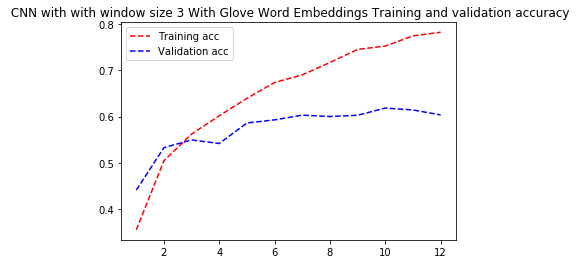

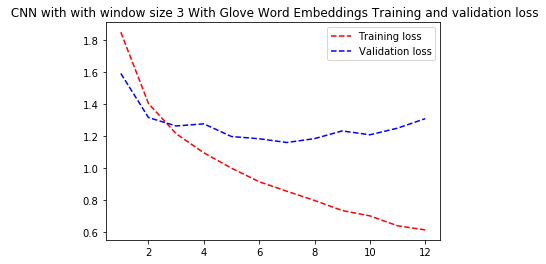

In [229]:
plothistory(   _kernel3_cnn, ' CNN with with window size 3 With Glove Word Embeddings')

In [230]:
#load the model

In [231]:
evaluate_model('saved_models/weights.best.cnnfilter3_glovevectors.hdf5', x_val, y_val)

saved_models/weights.best.cnnfilter3_glovevectors.hdf5
acc: 60.31%
loss: 1.16%


In [242]:
#convert results to a dataframe and view
allresults =  pd.DataFrame(results)
allresults.head(10)

,0,1,2,3,4
0,saved_models/weights.best.initialcnn_glovevect...,acc,69.148406,loss,0.924313
1,saved_models/weights.best.initiallstemglovevec...,acc,21.937251,loss,3.443821
2,saved_models/weights.best.simplecnn_glovevecto...,acc,61.279880,loss,1.174589
3,saved_models/weights.best.cnnkernel10_glovevec...,acc,66.982072,loss,0.984393
4,saved_models/weights.best.cnnkernel5_glovevect...,acc,68.974104,loss,0.907668
5,saved_models/weights.best.cnnfilter64_glovevec...,acc,56.997012,loss,1.263619
6,saved_models/weights.best.cnnfilter3_glovevect...,acc,60.308765,loss,1.160620


### Make Predictions on the Test Set with The Best Performing Model

In [233]:
X_test_df = df.iloc[X_test]
Y_test = X_test_df[OUTPUT_COLUMN]

In [234]:
#load the tokenizer
with open('tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)
    


In [236]:
test_set_text = cleanup_text(X_test_df[TEXT_COLUMN], True)

Processed 1000 out of 5021 documents.
Processed 2000 out of 5021 documents.
Processed 3000 out of 5021 documents.
Processed 4000 out of 5021 documents.
Processed 5000 out of 5021 documents.


In [237]:
#vectorize the text to pass to the model
test_sequences = tokenizer.texts_to_sequences(test_set_text)



print('Pad Sequences to be {} long'.format(MAX_SEQUENCE_LENGTH))
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

Pad Sequences to be 1000 long


In [238]:
#Load the model
# model to load is saved_models/weights.best.initialcnn_glovevectors.hdf5
best_model = load_trained_model('saved_models/weights.best.initialcnn_glovevectors.hdf5')


In [239]:
from sklearn.metrics import accuracy_score, log_loss
predicted = best_model.predict_proba(test_data)
log_loss(Y_test, predicted)

0.947156489687307

In [240]:
next_best_model = load_trained_model('saved_models/weights.best.cnnkernel5_glovevectors.hdf5')

In [241]:
predicted = next_best_model.predict_proba(test_data)
log_loss(Y_test, predicted)

0.9259077303480481